**Q2.Convolutional Neural Network**

In [ ]:
import torch
import torchvision.models as models
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform =   transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        # transforms.Grayscale(num_output_channels=3),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
        # transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# resize = transforms.Resize((224))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1421: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1436: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


In [ ]:

class FashionMNIST(Dataset):
    def __init__(self, img_file, classes):
        self.img_file= img_file
        self.classes = classes
        
    def __getitem__(self, i):
        return self.img_file[i], self.classes[i]
     
    
    def __len__(self):
        return len(self.classes)
            

In [ ]:

Train = pd.read_csv('/content/drive/MyDrive/fashion-mnist_train.csv')
Test = pd.read_csv('/content/drive/MyDrive/fashion-mnist_test.csv')


In [ ]:


Train_Y = np.array(Train['label'])
Test_Y = np.array(Test['label'])




In [ ]:

Train.drop('label',axis=1, inplace=True)
Test.drop('label',axis=1, inplace=True)

In [ ]:
Train = np.dstack([Train]*3)
Test = np.dstack([Test]*3)

In [ ]:


Train_X = np.array(Train).reshape(Train.shape[0],3,28,28)
Test_X = np.array(Test).reshape(Test.shape[0],3,28,28)


In [ ]:
Train_X, Val_X, Train_Y, Val_Y = train_test_split(Train_X, Train_Y, test_size=0.2)

In [ ]:
Train_X = torch.LongTensor(Train_X)
Train_Y = torch.LongTensor(Train_Y)


In [ ]:
Test_X = torch.LongTensor(Test_X)
Test_Y= torch.LongTensor(Test_Y)

In [ ]:

Val_X= torch.LongTensor(Val_X)
Val_Y = torch.LongTensor(Val_Y)

In [ ]:
Train_dataset = FashionMNIST(Train_X, Train_Y)
Test_dataset = FashionMNIST(Test_X, Test_Y)
Val_dataset = FashionMNIST(Val_X, Val_Y)



In [ ]:

batch_size = 64
Train_Dataloader = DataLoader(Train_dataset,batch_size=batch_size, shuffle=True)
Test_Dataoader = DataLoader(Test_dataset, batch_size=batch_size, shuffle=True)
Val_Dataloader = DataLoader(Val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
model.classifier[0] = torch.nn.Linear(in_features=25088, out_features=128, bias=True)

In [ ]:
model.classifier[3] = torch.nn.Linear(in_features=128, out_features=64, bias=True)
model.classifier[6] = torch.nn.Linear(in_features=64, out_features=10, bias=True)

In [ ]:
model = model.to(device)

In [ ]:
Freeze = True

if Freeze:
    # num_freeze_layers = 5
    
    for layers_i, layer in enumerate(model.features.parameters()):
        if layers_i <= 26:
            layer.requires_grad = False
        

Epochs = 1
Criterion = torch.nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model.parameters())
eval_after_steps = 10
steps = 0

In [ ]:



for Epoch in tqdm(range(Epochs)):
    model.train()
    run_Loss = 0
    run_Corrects = 0
    Train_loss = 0.0
    Valid_loss = 0.0

    Train_acc = 0
    Valid_acc = 0
    for Inputs, labels in tqdm(Train_Dataloader):
        steps += 1
        Inputs = transform(Inputs.float())
        labels = labels.long()
        Inputs = Inputs.to(device)
        labels = labels.to(device)
        
        Optimizer.zero_grad()
        
        Output = model(Inputs)

        Loss = Criterion(Output, labels)
        
        Loss.backward()
        Optimizer.step()
        Train_loss += Loss.item() * Inputs.size(0)

        _, pred = torch.max(Output, dim=1)
        correct_tensor = pred.eq(labels.data.view_as(pred))
        
        accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
        print(accuracy)
        # Multiply average accuracy times the number of examples in batch
        Train_acc += accuracy.item() * Inputs.size(0)
        
        if steps%eval_after_steps==0:
            model.eval()
            with torch.no_grad():
                for Inputs, labels in tqdm(Val_Dataloader):
        
                    Inputs = transform(Inputs.float())
                    labels = labels.long()
                    Inputs = Inputs.to(device)
                    labels = labels.to(device)
                    
                    # otransform =   transforms.Compose([

                    
                    Output = model(Inputs)
            
                    Loss = Criterion(Output, labels)
                    
                    print(Loss.item())
        
                    print("Eval", torch.sum(torch.argmax(Output, axis=1) == labels.data)/labels.shape[0])
                    
            model.train()

  0%|          | 1/750 [00:01<22:21,  1.79s/it]

tensor(0.4375)



  0%|          | 2/750 [00:03<22:25,  1.80s/it]

tensor(0.4844)



  0%|          | 3/750 [00:05<22:25,  1.80s/it]

tensor(0.4531)



  1%|          | 4/750 [00:07<22:11,  1.78s/it]

tensor(0.3125)



  1%|          | 5/750 [00:08<21:41,  1.75s/it]

tensor(0.1094)



  1%|          | 6/750 [00:10<21:29,  1.73s/it]

tensor(0.4375)



  1%|          | 7/750 [00:12<21:39,  1.75s/it]

tensor(0.4531)



  1%|          | 8/750 [00:14<21:46,  1.76s/it]

tensor(0.4219)



  1%|          | 9/750 [00:15<22:07,  1.79s/it]

tensor(0.5156)
tensor(0.5469)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:19,  1.71s/it]

1.0502738952636719
Eval tensor(0.5781, device='cuda:0')




  1%|          | 2/188 [00:03<05:18,  1.71s/it]

1.210685133934021
Eval tensor(0.5625, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:26,  1.77s/it]

1.118764877319336
Eval tensor(0.5625, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:30,  1.80s/it]

2.5209052562713623
Eval tensor(0.0938, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:26,  1.78s/it]

0.8388421535491943
Eval tensor(0.7188, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:20,  1.76s/it]

1.6926953792572021
Eval tensor(0.3281, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:13,  1.73s/it]

1.2830673456192017
Eval tensor(0.5156, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:07,  1.71s/it]

1.6760056018829346
Eval tensor(0.3906, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:06,  1.71s/it]

1.0875461101531982
Eval tensor(0.5469, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:08,  1.73s/it]

1.558173656463623
Eval tensor(0.4062, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:02,  1.71s/it]

2.302839756011963
Eval tensor(0.0625, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:01,  1.72s/it]

1.175594687461853
Eval tensor(0.4531, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:06,  1.75s/it]

1.1593323945999146
Eval tensor(0.4844, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:11,  1.79s/it]

1.7447490692138672
Eval tensor(0.2344, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:00,  1.74s/it]

2.3131661415100098
Eval tensor(0.1094, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:58,  1.73s/it]

1.1416840553283691
Eval tensor(0.5625, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:57,  1.74s/it]

1.1432173252105713
Eval tensor(0.5938, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:55,  1.74s/it]

1.031805157661438
Eval tensor(0.5469, device='cuda:0')




 10%|█         | 19/188 [00:33<04:51,  1.73s/it]

1.8468118906021118
Eval tensor(0.2969, device='cuda:0')




 11%|█         | 20/188 [00:34<04:48,  1.72s/it]

1.0161683559417725
Eval tensor(0.6250, device='cuda:0')




 11%|█         | 21/188 [00:36<04:46,  1.72s/it]

1.1577531099319458
Eval tensor(0.6406, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:42,  1.70s/it]

1.1132596731185913
Eval tensor(0.6094, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:40,  1.70s/it]

1.1078232526779175
Eval tensor(0.6875, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:39,  1.70s/it]

1.0949208736419678
Eval tensor(0.5469, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:39,  1.71s/it]

1.1606024503707886
Eval tensor(0.6094, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:40,  1.73s/it]

1.5229002237319946
Eval tensor(0.4688, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:37,  1.72s/it]

2.324268341064453
Eval tensor(0.1094, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:41,  1.76s/it]

1.4004952907562256
Eval tensor(0.4531, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:42,  1.77s/it]

1.9930140972137451
Eval tensor(0.2812, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:34,  1.74s/it]

0.9888558983802795
Eval tensor(0.6250, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:35,  1.76s/it]

1.9301618337631226
Eval tensor(0.2969, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:30,  1.73s/it]

1.4228243827819824
Eval tensor(0.5156, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:30,  1.75s/it]

1.1869250535964966
Eval tensor(0.5938, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:28,  1.74s/it]

1.2759751081466675
Eval tensor(0.5000, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:26,  1.74s/it]

1.3459572792053223
Eval tensor(0.4375, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:22,  1.73s/it]

1.1233799457550049
Eval tensor(0.6094, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:20,  1.72s/it]

1.9537103176116943
Eval tensor(0.3125, device='cuda:0')




 20%|██        | 38/188 [01:05<04:18,  1.72s/it]

1.1899523735046387
Eval tensor(0.6719, device='cuda:0')




 21%|██        | 39/188 [01:07<04:17,  1.73s/it]

0.9120222926139832
Eval tensor(0.6406, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:16,  1.73s/it]

1.0667518377304077
Eval tensor(0.5938, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:12,  1.72s/it]

2.197439193725586
Eval tensor(0.1562, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:12,  1.73s/it]

1.1504896879196167
Eval tensor(0.5938, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:09,  1.72s/it]

2.3000335693359375
Eval tensor(0.1250, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:08,  1.73s/it]

1.1582330465316772
Eval tensor(0.5469, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:13,  1.77s/it]

2.3086535930633545
Eval tensor(0.1250, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:10,  1.76s/it]

1.424518346786499
Eval tensor(0.5312, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:07,  1.76s/it]

1.2290118932724
Eval tensor(0.5781, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:10,  1.79s/it]

1.7438730001449585
Eval tensor(0.3281, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:05,  1.77s/it]

1.2593355178833008
Eval tensor(0.5625, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:05,  1.78s/it]

1.322417974472046
Eval tensor(0.5625, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:59,  1.75s/it]

0.983963668346405
Eval tensor(0.6094, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:57,  1.75s/it]

2.310270309448242
Eval tensor(0.0938, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:56,  1.75s/it]

1.7561924457550049
Eval tensor(0.4375, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:53,  1.74s/it]

1.8207777738571167
Eval tensor(0.3125, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:54,  1.76s/it]

1.0779625177383423
Eval tensor(0.5781, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:51,  1.75s/it]

2.317950487136841
Eval tensor(0.1406, device='cuda:0')




 30%|███       | 57/188 [01:39<03:52,  1.78s/it]

1.0349493026733398
Eval tensor(0.6406, device='cuda:0')




 31%|███       | 58/188 [01:41<03:48,  1.76s/it]

1.0150434970855713
Eval tensor(0.5625, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:45,  1.75s/it]

1.0308244228363037
Eval tensor(0.5312, device='cuda:0')




 32%|███▏      | 60/188 [01:44<03:44,  1.76s/it]

1.1982969045639038
Eval tensor(0.5625, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:46,  1.79s/it]

0.9703825116157532
Eval tensor(0.6719, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:42,  1.77s/it]

1.2312397956848145
Eval tensor(0.5938, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:40,  1.76s/it]

1.2647854089736938
Eval tensor(0.5000, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:39,  1.77s/it]

1.0162997245788574
Eval tensor(0.6250, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:37,  1.77s/it]

1.2798234224319458
Eval tensor(0.4375, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:34,  1.76s/it]

0.9922180771827698
Eval tensor(0.6562, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:33,  1.76s/it]

1.45108163356781
Eval tensor(0.4375, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:28,  1.73s/it]

1.6715617179870605
Eval tensor(0.4062, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:30,  1.77s/it]

1.3341113328933716
Eval tensor(0.4375, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:27,  1.75s/it]

1.1768041849136353
Eval tensor(0.5156, device='cuda:0')




 38%|███▊      | 71/188 [02:03<03:26,  1.76s/it]

1.183892011642456
Eval tensor(0.4844, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:28,  1.79s/it]

1.2618507146835327
Eval tensor(0.4844, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:23,  1.77s/it]

2.323180675506592
Eval tensor(0.0781, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:18,  1.74s/it]

1.404515027999878
Eval tensor(0.4375, device='cuda:0')




 40%|███▉      | 75/188 [02:10<03:16,  1.74s/it]

1.013251781463623
Eval tensor(0.6250, device='cuda:0')




 40%|████      | 76/188 [02:12<03:16,  1.75s/it]

1.9050198793411255
Eval tensor(0.3281, device='cuda:0')




 41%|████      | 77/188 [02:14<03:15,  1.76s/it]

1.076396107673645
Eval tensor(0.5469, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:13,  1.76s/it]

1.5475413799285889
Eval tensor(0.3750, device='cuda:0')




 42%|████▏     | 79/188 [02:17<03:08,  1.73s/it]

1.1747708320617676
Eval tensor(0.5781, device='cuda:0')




 43%|████▎     | 80/188 [02:19<03:07,  1.74s/it]

2.33166766166687
Eval tensor(0.0312, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:06,  1.74s/it]

0.9752798676490784
Eval tensor(0.6562, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:04,  1.74s/it]

1.150937557220459
Eval tensor(0.5625, device='cuda:0')




 44%|████▍     | 83/188 [02:24<03:02,  1.74s/it]

1.0244401693344116
Eval tensor(0.5938, device='cuda:0')




 45%|████▍     | 84/188 [02:26<03:00,  1.74s/it]

1.2294902801513672
Eval tensor(0.4688, device='cuda:0')




 45%|████▌     | 85/188 [02:28<02:58,  1.73s/it]

1.2174726724624634
Eval tensor(0.5469, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:58,  1.75s/it]

1.1006501913070679
Eval tensor(0.5156, device='cuda:0')




 46%|████▋     | 87/188 [02:31<02:57,  1.76s/it]

1.2617971897125244
Eval tensor(0.5312, device='cuda:0')




 47%|████▋     | 88/188 [02:33<02:53,  1.74s/it]

2.3379476070404053
Eval tensor(0.0156, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:51,  1.73s/it]

1.1306376457214355
Eval tensor(0.5156, device='cuda:0')




 48%|████▊     | 90/188 [02:36<02:48,  1.72s/it]

1.4459837675094604
Eval tensor(0.4375, device='cuda:0')




 48%|████▊     | 91/188 [02:38<02:49,  1.75s/it]

1.6914485692977905
Eval tensor(0.3281, device='cuda:0')




 49%|████▉     | 92/188 [02:40<02:50,  1.78s/it]

2.5556252002716064
Eval tensor(0.0938, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:47,  1.76s/it]

1.0452513694763184
Eval tensor(0.5781, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:49,  1.80s/it]

1.242567777633667
Eval tensor(0.5312, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:46,  1.79s/it]

1.3339990377426147
Eval tensor(0.5156, device='cuda:0')




 51%|█████     | 96/188 [02:47<02:45,  1.79s/it]

1.9254189729690552
Eval tensor(0.3281, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:42,  1.79s/it]

1.1225810050964355
Eval tensor(0.6094, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:40,  1.78s/it]

1.2531135082244873
Eval tensor(0.5781, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:40,  1.81s/it]

1.1778262853622437
Eval tensor(0.5781, device='cuda:0')




 53%|█████▎    | 100/188 [02:54<02:36,  1.78s/it]

2.320282220840454
Eval tensor(0.1094, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:34,  1.78s/it]

1.7277592420578003
Eval tensor(0.3438, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:32,  1.77s/it]

1.348212480545044
Eval tensor(0.5312, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:29,  1.76s/it]

0.9868699908256531
Eval tensor(0.6406, device='cuda:0')




 55%|█████▌    | 104/188 [03:01<02:26,  1.74s/it]

1.2602331638336182
Eval tensor(0.5781, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:23,  1.73s/it]

1.4738636016845703
Eval tensor(0.4531, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:21,  1.73s/it]

1.001228928565979
Eval tensor(0.5781, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:20,  1.74s/it]

0.9133082032203674
Eval tensor(0.6719, device='cuda:0')




 57%|█████▋    | 108/188 [03:08<02:19,  1.75s/it]

2.182065486907959
Eval tensor(0.2188, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:17,  1.75s/it]

1.7763751745224
Eval tensor(0.3906, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:16,  1.75s/it]

1.0810807943344116
Eval tensor(0.5625, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:13,  1.73s/it]

1.4404758214950562
Eval tensor(0.5000, device='cuda:0')




 60%|█████▉    | 112/188 [03:15<02:12,  1.75s/it]

1.3302280902862549
Eval tensor(0.5000, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:10,  1.75s/it]

1.2396769523620605
Eval tensor(0.5781, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:11,  1.78s/it]

0.9309085607528687
Eval tensor(0.7031, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:08,  1.76s/it]

1.0931615829467773
Eval tensor(0.5625, device='cuda:0')




 62%|██████▏   | 116/188 [03:22<02:04,  1.74s/it]

1.2103673219680786
Eval tensor(0.4844, device='cuda:0')




 62%|██████▏   | 117/188 [03:24<02:02,  1.73s/it]

2.3055593967437744
Eval tensor(0.1250, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:01,  1.74s/it]

1.7999255657196045
Eval tensor(0.3125, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<01:59,  1.73s/it]

1.348791480064392
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 120/188 [03:29<01:56,  1.72s/it]

2.306220769882202
Eval tensor(0.1875, device='cuda:0')




 64%|██████▍   | 121/188 [03:31<01:54,  1.71s/it]

1.1351573467254639
Eval tensor(0.5469, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:52,  1.70s/it]

2.312052011489868
Eval tensor(0.0938, device='cuda:0')




 65%|██████▌   | 123/188 [03:34<01:50,  1.71s/it]

1.427294373512268
Eval tensor(0.4375, device='cuda:0')




 66%|██████▌   | 124/188 [03:36<01:50,  1.73s/it]

1.3019750118255615
Eval tensor(0.4844, device='cuda:0')




 66%|██████▋   | 125/188 [03:38<01:47,  1.71s/it]

1.087957739830017
Eval tensor(0.5938, device='cuda:0')




 67%|██████▋   | 126/188 [03:39<01:45,  1.70s/it]

1.3741047382354736
Eval tensor(0.4375, device='cuda:0')




 68%|██████▊   | 127/188 [03:41<01:44,  1.71s/it]

1.046382188796997
Eval tensor(0.6562, device='cuda:0')




 68%|██████▊   | 128/188 [03:43<01:42,  1.71s/it]

1.1388369798660278
Eval tensor(0.5625, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:43,  1.76s/it]

1.1924021244049072
Eval tensor(0.5781, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:41,  1.75s/it]

1.1449593305587769
Eval tensor(0.5781, device='cuda:0')




 70%|██████▉   | 131/188 [03:48<01:38,  1.73s/it]

1.6957708597183228
Eval tensor(0.3438, device='cuda:0')




 70%|███████   | 132/188 [03:50<01:39,  1.78s/it]

1.4939240217208862
Eval tensor(0.3281, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:36,  1.76s/it]

1.181071162223816
Eval tensor(0.5469, device='cuda:0')




 71%|███████▏  | 134/188 [03:53<01:33,  1.72s/it]

1.3345504999160767
Eval tensor(0.4844, device='cuda:0')




 72%|███████▏  | 135/188 [03:55<01:32,  1.74s/it]

1.8223812580108643
Eval tensor(0.2812, device='cuda:0')




 72%|███████▏  | 136/188 [03:57<01:32,  1.78s/it]

1.2185518741607666
Eval tensor(0.4844, device='cuda:0')




 73%|███████▎  | 137/188 [03:59<01:29,  1.76s/it]

1.7625408172607422
Eval tensor(0.3438, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:27,  1.75s/it]

1.283247470855713
Eval tensor(0.5469, device='cuda:0')




 74%|███████▍  | 139/188 [04:02<01:25,  1.75s/it]

1.0705320835113525
Eval tensor(0.6094, device='cuda:0')




 74%|███████▍  | 140/188 [04:04<01:23,  1.74s/it]

2.014526128768921
Eval tensor(0.2031, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:21,  1.73s/it]

1.14163339138031
Eval tensor(0.5625, device='cuda:0')




 76%|███████▌  | 142/188 [04:07<01:19,  1.73s/it]

1.1937315464019775
Eval tensor(0.5938, device='cuda:0')




 76%|███████▌  | 143/188 [04:09<01:18,  1.74s/it]

1.2394251823425293
Eval tensor(0.5625, device='cuda:0')




 77%|███████▋  | 144/188 [04:11<01:16,  1.75s/it]

2.3543074131011963
Eval tensor(0.0156, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:18,  1.83s/it]

1.2573893070220947
Eval tensor(0.4375, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:16,  1.81s/it]

1.922734022140503
Eval tensor(0.2969, device='cuda:0')




 78%|███████▊  | 147/188 [04:16<01:12,  1.78s/it]

1.4806703329086304
Eval tensor(0.4844, device='cuda:0')




 79%|███████▊  | 148/188 [04:18<01:09,  1.75s/it]

1.0911097526550293
Eval tensor(0.6094, device='cuda:0')




 79%|███████▉  | 149/188 [04:20<01:09,  1.78s/it]

1.1534520387649536
Eval tensor(0.5469, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:06,  1.76s/it]

0.8934995532035828
Eval tensor(0.6250, device='cuda:0')




 80%|████████  | 151/188 [04:23<01:05,  1.76s/it]

1.5728585720062256
Eval tensor(0.4219, device='cuda:0')




 81%|████████  | 152/188 [04:25<01:04,  1.79s/it]

1.2430223226547241
Eval tensor(0.5312, device='cuda:0')




 81%|████████▏ | 153/188 [04:27<01:01,  1.77s/it]

1.0424330234527588
Eval tensor(0.6406, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<00:59,  1.76s/it]

0.9884563088417053
Eval tensor(0.5469, device='cuda:0')




 82%|████████▏ | 155/188 [04:30<00:57,  1.74s/it]

1.0074716806411743
Eval tensor(0.6406, device='cuda:0')




 83%|████████▎ | 156/188 [04:32<00:55,  1.73s/it]

0.9884979128837585
Eval tensor(0.7344, device='cuda:0')




 84%|████████▎ | 157/188 [04:34<00:53,  1.72s/it]

1.1737505197525024
Eval tensor(0.5156, device='cuda:0')




 84%|████████▍ | 158/188 [04:36<00:52,  1.75s/it]

1.8401129245758057
Eval tensor(0.2031, device='cuda:0')




 85%|████████▍ | 159/188 [04:37<00:50,  1.73s/it]

1.1680943965911865
Eval tensor(0.6406, device='cuda:0')




 85%|████████▌ | 160/188 [04:39<00:48,  1.75s/it]

0.9478045701980591
Eval tensor(0.6875, device='cuda:0')




 86%|████████▌ | 161/188 [04:41<00:47,  1.77s/it]

1.0823661088943481
Eval tensor(0.5938, device='cuda:0')




 86%|████████▌ | 162/188 [04:43<00:45,  1.74s/it]

0.9873682260513306
Eval tensor(0.6875, device='cuda:0')




 87%|████████▋ | 163/188 [04:44<00:43,  1.74s/it]

1.0215418338775635
Eval tensor(0.6562, device='cuda:0')




 87%|████████▋ | 164/188 [04:46<00:41,  1.72s/it]

2.023564100265503
Eval tensor(0.1719, device='cuda:0')




 88%|████████▊ | 165/188 [04:48<00:39,  1.72s/it]

3.065349817276001
Eval tensor(0.0312, device='cuda:0')




 88%|████████▊ | 166/188 [04:49<00:37,  1.71s/it]

1.1250635385513306
Eval tensor(0.6406, device='cuda:0')




 89%|████████▉ | 167/188 [04:51<00:36,  1.72s/it]

1.0416144132614136
Eval tensor(0.5781, device='cuda:0')




 89%|████████▉ | 168/188 [04:53<00:34,  1.72s/it]

2.2925758361816406
Eval tensor(0.0469, device='cuda:0')




 90%|████████▉ | 169/188 [04:55<00:32,  1.70s/it]

2.33314847946167
Eval tensor(0.1562, device='cuda:0')




 90%|█████████ | 170/188 [04:56<00:30,  1.70s/it]

2.2945919036865234
Eval tensor(0.1250, device='cuda:0')




 91%|█████████ | 171/188 [04:58<00:29,  1.72s/it]

1.6512683629989624
Eval tensor(0.3750, device='cuda:0')




 91%|█████████▏| 172/188 [05:00<00:27,  1.72s/it]

1.5376547574996948
Eval tensor(0.3438, device='cuda:0')




 92%|█████████▏| 173/188 [05:01<00:25,  1.70s/it]

1.244490385055542
Eval tensor(0.5625, device='cuda:0')




 93%|█████████▎| 174/188 [05:03<00:24,  1.72s/it]

1.2723489999771118
Eval tensor(0.5156, device='cuda:0')




 93%|█████████▎| 175/188 [05:05<00:22,  1.74s/it]

1.7780052423477173
Eval tensor(0.4375, device='cuda:0')




 94%|█████████▎| 176/188 [05:07<00:20,  1.74s/it]

1.242514729499817
Eval tensor(0.5156, device='cuda:0')




 94%|█████████▍| 177/188 [05:08<00:18,  1.72s/it]

2.28658127784729
Eval tensor(0.1562, device='cuda:0')




 95%|█████████▍| 178/188 [05:10<00:17,  1.70s/it]

2.296868085861206
Eval tensor(0.0938, device='cuda:0')




 95%|█████████▌| 179/188 [05:12<00:15,  1.69s/it]

1.105362057685852
Eval tensor(0.5625, device='cuda:0')




 96%|█████████▌| 180/188 [05:14<00:13,  1.74s/it]

2.386988639831543
Eval tensor(0.1719, device='cuda:0')




 96%|█████████▋| 181/188 [05:15<00:12,  1.74s/it]

0.9164337515830994
Eval tensor(0.6562, device='cuda:0')




 97%|█████████▋| 182/188 [05:17<00:10,  1.70s/it]

1.2588251829147339
Eval tensor(0.4844, device='cuda:0')




 97%|█████████▋| 183/188 [05:19<00:08,  1.74s/it]

1.5515172481536865
Eval tensor(0.2969, device='cuda:0')




 98%|█████████▊| 184/188 [05:20<00:06,  1.71s/it]

1.522546410560608
Eval tensor(0.4688, device='cuda:0')




 98%|█████████▊| 185/188 [05:22<00:05,  1.75s/it]

1.1776472330093384
Eval tensor(0.4375, device='cuda:0')




 99%|█████████▉| 186/188 [05:24<00:03,  1.74s/it]

2.3708033561706543
Eval tensor(0.0312, device='cuda:0')




 99%|█████████▉| 187/188 [05:26<00:01,  1.75s/it]

1.698044776916504
Eval tensor(0.2969, device='cuda:0')




100%|██████████| 188/188 [05:27<00:00,  1.74s/it]

  1%|▏         | 10/750 [05:44<21:07:52, 102.80s/it]

2.072004556655884
Eval tensor(0.2188, device='cuda:0')



  1%|▏         | 11/750 [05:46<14:45:09, 71.87s/it] 

tensor(0.0625)



  2%|▏         | 12/750 [05:48<10:21:24, 50.52s/it]

tensor(0.4062)



  2%|▏         | 13/750 [05:50<7:19:07, 35.75s/it] 

tensor(0.5156)



  2%|▏         | 14/750 [05:52<5:13:18, 25.54s/it]

tensor(0.3438)



  2%|▏         | 15/750 [05:53<3:44:55, 18.36s/it]

tensor(0.2969)



  2%|▏         | 16/750 [05:55<2:43:14, 13.34s/it]

tensor(0.4062)



  2%|▏         | 17/750 [05:57<2:00:19,  9.85s/it]

tensor(0.5000)



  2%|▏         | 18/750 [05:58<1:30:24,  7.41s/it]

tensor(0.1094)



  3%|▎         | 19/750 [06:00<1:09:21,  5.69s/it]

tensor(0.2344)
tensor(0.4062)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:36,  1.80s/it]

1.4068174362182617
Eval tensor(0.5625, device='cuda:0')




  1%|          | 2/188 [00:03<05:21,  1.73s/it]

1.3511345386505127
Eval tensor(0.5000, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:21,  1.74s/it]

1.1057926416397095
Eval tensor(0.6406, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:29,  1.79s/it]

1.3035237789154053
Eval tensor(0.5156, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:23,  1.77s/it]

2.312239646911621
Eval tensor(0.1406, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:27,  1.80s/it]

1.4458951950073242
Eval tensor(0.4688, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:24,  1.79s/it]

1.0744913816452026
Eval tensor(0.5469, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:27,  1.82s/it]

1.238412618637085
Eval tensor(0.5781, device='cuda:0')




  5%|▍         | 9/188 [00:16<05:21,  1.79s/it]

1.2723703384399414
Eval tensor(0.4844, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:16,  1.78s/it]

1.7334325313568115
Eval tensor(0.3906, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:10,  1.75s/it]

1.2901400327682495
Eval tensor(0.5625, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:10,  1.77s/it]

1.2975760698318481
Eval tensor(0.5156, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:09,  1.77s/it]

1.2245962619781494
Eval tensor(0.5938, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:03,  1.74s/it]

1.2623194456100464
Eval tensor(0.5781, device='cuda:0')




  8%|▊         | 15/188 [00:26<04:59,  1.73s/it]

1.2850497961044312
Eval tensor(0.5156, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:04,  1.77s/it]

1.2387950420379639
Eval tensor(0.6719, device='cuda:0')




  9%|▉         | 17/188 [00:30<04:57,  1.74s/it]

1.512811541557312
Eval tensor(0.5000, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:52,  1.72s/it]

1.780152440071106
Eval tensor(0.3750, device='cuda:0')




 10%|█         | 19/188 [00:33<04:52,  1.73s/it]

1.2697705030441284
Eval tensor(0.5781, device='cuda:0')




 11%|█         | 20/188 [00:35<04:51,  1.74s/it]

2.4065194129943848
Eval tensor(0.0781, device='cuda:0')




 11%|█         | 21/188 [00:36<04:48,  1.73s/it]

2.343384265899658
Eval tensor(0.0781, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:43,  1.71s/it]

1.6035258769989014
Eval tensor(0.4219, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:44,  1.72s/it]

2.105701208114624
Eval tensor(0.2344, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:41,  1.72s/it]

1.085684061050415
Eval tensor(0.5625, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:39,  1.72s/it]

1.284943699836731
Eval tensor(0.5625, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:37,  1.71s/it]

1.165125846862793
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:41,  1.75s/it]

1.7629907131195068
Eval tensor(0.3281, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:39,  1.75s/it]

1.3856487274169922
Eval tensor(0.5312, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:37,  1.75s/it]

1.5813441276550293
Eval tensor(0.5000, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:34,  1.74s/it]

1.2084671258926392
Eval tensor(0.5312, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:35,  1.75s/it]

1.3618338108062744
Eval tensor(0.5156, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:34,  1.76s/it]

1.42751145362854
Eval tensor(0.4844, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:31,  1.75s/it]

1.6969150304794312
Eval tensor(0.4688, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:32,  1.77s/it]

1.0984712839126587
Eval tensor(0.6562, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:30,  1.77s/it]

1.1338342428207397
Eval tensor(0.6406, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:24,  1.74s/it]

1.2727934122085571
Eval tensor(0.6406, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:27,  1.77s/it]

1.553400993347168
Eval tensor(0.4062, device='cuda:0')




 20%|██        | 38/188 [01:06<04:20,  1.74s/it]

2.322505474090576
Eval tensor(0.0938, device='cuda:0')




 21%|██        | 39/188 [01:08<04:20,  1.75s/it]

1.9415370225906372
Eval tensor(0.3125, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:15,  1.73s/it]

1.4105771780014038
Eval tensor(0.5625, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:12,  1.72s/it]

1.139475703239441
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:11,  1.72s/it]

0.9290248155593872
Eval tensor(0.7188, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:11,  1.74s/it]

1.1760209798812866
Eval tensor(0.6094, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:06,  1.71s/it]

1.056373119354248
Eval tensor(0.6562, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:05,  1.71s/it]

1.2891101837158203
Eval tensor(0.5156, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:01,  1.70s/it]

1.9100944995880127
Eval tensor(0.2969, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:04,  1.73s/it]

1.1880093812942505
Eval tensor(0.5469, device='cuda:0')




 26%|██▌       | 48/188 [01:23<03:58,  1.71s/it]

1.8592935800552368
Eval tensor(0.3438, device='cuda:0')




 26%|██▌       | 49/188 [01:25<03:58,  1.72s/it]

1.1456992626190186
Eval tensor(0.5938, device='cuda:0')




 27%|██▋       | 50/188 [01:27<03:55,  1.71s/it]

1.4161555767059326
Eval tensor(0.4844, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:54,  1.71s/it]

2.120241165161133
Eval tensor(0.1562, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:50,  1.69s/it]

2.061293363571167
Eval tensor(0.2344, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:48,  1.69s/it]

0.9058076739311218
Eval tensor(0.7500, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:48,  1.71s/it]

1.1164385080337524
Eval tensor(0.6406, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:45,  1.69s/it]

1.0457314252853394
Eval tensor(0.6562, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:43,  1.70s/it]

1.3283767700195312
Eval tensor(0.5000, device='cuda:0')




 30%|███       | 57/188 [01:38<03:41,  1.69s/it]

1.0816328525543213
Eval tensor(0.5781, device='cuda:0')




 31%|███       | 58/188 [01:40<03:39,  1.69s/it]

2.297814130783081
Eval tensor(0.0625, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:35,  1.67s/it]

1.0884438753128052
Eval tensor(0.6094, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:34,  1.68s/it]

2.026672124862671
Eval tensor(0.2656, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:36,  1.70s/it]

1.600195288658142
Eval tensor(0.2969, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:35,  1.71s/it]

1.460769534111023
Eval tensor(0.5469, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:33,  1.71s/it]

2.3077094554901123
Eval tensor(0.0781, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:29,  1.69s/it]

1.8851139545440674
Eval tensor(0.3281, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:28,  1.70s/it]

1.2991079092025757
Eval tensor(0.5625, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:28,  1.71s/it]

1.3347338438034058
Eval tensor(0.5469, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:29,  1.73s/it]

1.220353364944458
Eval tensor(0.5156, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:28,  1.73s/it]

1.0287036895751953
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:25,  1.73s/it]

2.306854724884033
Eval tensor(0.1562, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:28,  1.76s/it]

1.651242971420288
Eval tensor(0.3125, device='cuda:0')




 38%|███▊      | 71/188 [02:03<03:25,  1.76s/it]

0.9807287454605103
Eval tensor(0.6406, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:25,  1.77s/it]

1.8514152765274048
Eval tensor(0.2812, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:20,  1.75s/it]

1.8907533884048462
Eval tensor(0.3750, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:17,  1.73s/it]

0.8839892148971558
Eval tensor(0.8594, device='cuda:0')




 40%|███▉      | 75/188 [02:10<03:18,  1.76s/it]

1.0625438690185547
Eval tensor(0.6094, device='cuda:0')




 40%|████      | 76/188 [02:11<03:14,  1.74s/it]

0.9984912276268005
Eval tensor(0.6406, device='cuda:0')




 41%|████      | 77/188 [02:13<03:12,  1.74s/it]

1.3863168954849243
Eval tensor(0.4844, device='cuda:0')




 41%|████▏     | 78/188 [02:15<03:10,  1.73s/it]

1.1831146478652954
Eval tensor(0.6875, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:06,  1.72s/it]

1.385588526725769
Eval tensor(0.4531, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:08,  1.74s/it]

1.322624921798706
Eval tensor(0.5625, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:06,  1.74s/it]

1.5478061437606812
Eval tensor(0.5000, device='cuda:0')




 44%|████▎     | 82/188 [02:22<03:03,  1.73s/it]

1.1072486639022827
Eval tensor(0.6094, device='cuda:0')




 44%|████▍     | 83/188 [02:23<03:04,  1.75s/it]

2.344151735305786
Eval tensor(0.1875, device='cuda:0')




 45%|████▍     | 84/188 [02:25<03:06,  1.79s/it]

1.3533909320831299
Eval tensor(0.5625, device='cuda:0')




 45%|████▌     | 85/188 [02:27<03:05,  1.80s/it]

2.113693952560425
Eval tensor(0.2656, device='cuda:0')




 46%|████▌     | 86/188 [02:29<03:00,  1.77s/it]

2.2966866493225098
Eval tensor(0.0625, device='cuda:0')




 46%|████▋     | 87/188 [02:31<02:57,  1.76s/it]

2.3178579807281494
Eval tensor(0.0781, device='cuda:0')




 47%|████▋     | 88/188 [02:32<02:55,  1.76s/it]

1.2516112327575684
Eval tensor(0.5938, device='cuda:0')




 47%|████▋     | 89/188 [02:34<02:53,  1.75s/it]

1.0187575817108154
Eval tensor(0.6719, device='cuda:0')




 48%|████▊     | 90/188 [02:36<02:50,  1.73s/it]

1.2874358892440796
Eval tensor(0.6406, device='cuda:0')




 48%|████▊     | 91/188 [02:37<02:46,  1.72s/it]

1.587350845336914
Eval tensor(0.4062, device='cuda:0')




 49%|████▉     | 92/188 [02:39<02:44,  1.72s/it]

1.160300850868225
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:41<02:44,  1.73s/it]

2.562225103378296
Eval tensor(0.0312, device='cuda:0')




 50%|█████     | 94/188 [02:43<02:42,  1.72s/it]

0.9740417003631592
Eval tensor(0.6562, device='cuda:0')




 51%|█████     | 95/188 [02:44<02:40,  1.73s/it]

1.3668245077133179
Eval tensor(0.4531, device='cuda:0')




 51%|█████     | 96/188 [02:46<02:38,  1.73s/it]

1.0607420206069946
Eval tensor(0.5781, device='cuda:0')




 52%|█████▏    | 97/188 [02:48<02:36,  1.72s/it]

1.2422633171081543
Eval tensor(0.4688, device='cuda:0')




 52%|█████▏    | 98/188 [02:50<02:36,  1.74s/it]

2.4266085624694824
Eval tensor(0.1406, device='cuda:0')




 53%|█████▎    | 99/188 [02:51<02:33,  1.72s/it]

1.183251142501831
Eval tensor(0.7344, device='cuda:0')




 53%|█████▎    | 100/188 [02:53<02:33,  1.74s/it]

2.3495593070983887
Eval tensor(0.1406, device='cuda:0')




 54%|█████▎    | 101/188 [02:55<02:29,  1.72s/it]

2.133287191390991
Eval tensor(0.2188, device='cuda:0')




 54%|█████▍    | 102/188 [02:56<02:26,  1.70s/it]

1.0843050479888916
Eval tensor(0.6250, device='cuda:0')




 55%|█████▍    | 103/188 [02:58<02:25,  1.71s/it]

1.5010037422180176
Eval tensor(0.4531, device='cuda:0')




 55%|█████▌    | 104/188 [03:00<02:24,  1.72s/it]

1.3578003644943237
Eval tensor(0.5000, device='cuda:0')




 56%|█████▌    | 105/188 [03:02<02:21,  1.70s/it]

2.3207685947418213
Eval tensor(0.1094, device='cuda:0')




 56%|█████▋    | 106/188 [03:03<02:17,  1.68s/it]

1.1647547483444214
Eval tensor(0.6094, device='cuda:0')




 57%|█████▋    | 107/188 [03:05<02:15,  1.68s/it]

2.3190019130706787
Eval tensor(0.0938, device='cuda:0')




 57%|█████▋    | 108/188 [03:07<02:14,  1.69s/it]

1.0997004508972168
Eval tensor(0.7188, device='cuda:0')




 58%|█████▊    | 109/188 [03:08<02:13,  1.68s/it]

2.295109510421753
Eval tensor(0.0938, device='cuda:0')




 59%|█████▊    | 110/188 [03:10<02:11,  1.69s/it]

2.288954496383667
Eval tensor(0.1562, device='cuda:0')




 59%|█████▉    | 111/188 [03:12<02:12,  1.71s/it]

1.0250680446624756
Eval tensor(0.6094, device='cuda:0')




 60%|█████▉    | 112/188 [03:13<02:08,  1.69s/it]

1.7280001640319824
Eval tensor(0.4062, device='cuda:0')




 60%|██████    | 113/188 [03:15<02:08,  1.71s/it]

1.277225136756897
Eval tensor(0.5312, device='cuda:0')




 61%|██████    | 114/188 [03:17<02:05,  1.70s/it]

1.252922534942627
Eval tensor(0.4531, device='cuda:0')




 61%|██████    | 115/188 [03:18<02:04,  1.70s/it]

1.1424446105957031
Eval tensor(0.5938, device='cuda:0')




 62%|██████▏   | 116/188 [03:20<02:06,  1.75s/it]

0.962395966053009
Eval tensor(0.6094, device='cuda:0')




 62%|██████▏   | 117/188 [03:22<02:03,  1.74s/it]

1.5813226699829102
Eval tensor(0.4531, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:03,  1.77s/it]

1.1974680423736572
Eval tensor(0.6250, device='cuda:0')




 63%|██████▎   | 119/188 [03:26<02:00,  1.75s/it]

1.1076040267944336
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 120/188 [03:27<02:01,  1.78s/it]

2.6937623023986816
Eval tensor(0.0938, device='cuda:0')




 64%|██████▍   | 121/188 [03:29<01:57,  1.76s/it]

1.1150788068771362
Eval tensor(0.5000, device='cuda:0')




 65%|██████▍   | 122/188 [03:31<01:56,  1.77s/it]

0.8549469113349915
Eval tensor(0.7969, device='cuda:0')




 65%|██████▌   | 123/188 [03:33<01:55,  1.77s/it]

1.0600411891937256
Eval tensor(0.6094, device='cuda:0')




 66%|██████▌   | 124/188 [03:34<01:52,  1.75s/it]

1.111971139907837
Eval tensor(0.5938, device='cuda:0')




 66%|██████▋   | 125/188 [03:36<01:48,  1.72s/it]

1.0618040561676025
Eval tensor(0.5781, device='cuda:0')




 67%|██████▋   | 126/188 [03:38<01:45,  1.70s/it]

1.816782832145691
Eval tensor(0.3281, device='cuda:0')




 68%|██████▊   | 127/188 [03:39<01:45,  1.73s/it]

1.0439168214797974
Eval tensor(0.5625, device='cuda:0')




 68%|██████▊   | 128/188 [03:41<01:43,  1.72s/it]

1.2817399501800537
Eval tensor(0.6562, device='cuda:0')




 69%|██████▊   | 129/188 [03:43<01:41,  1.72s/it]

1.6803326606750488
Eval tensor(0.4219, device='cuda:0')




 69%|██████▉   | 130/188 [03:45<01:38,  1.70s/it]

1.5146987438201904
Eval tensor(0.3906, device='cuda:0')




 70%|██████▉   | 131/188 [03:46<01:37,  1.71s/it]

1.1397556066513062
Eval tensor(0.5469, device='cuda:0')




 70%|███████   | 132/188 [03:48<01:36,  1.72s/it]

1.604636549949646
Eval tensor(0.5156, device='cuda:0')




 71%|███████   | 133/188 [03:50<01:34,  1.73s/it]

1.708324909210205
Eval tensor(0.4375, device='cuda:0')




 71%|███████▏  | 134/188 [03:52<01:34,  1.75s/it]

2.526076078414917
Eval tensor(0.1094, device='cuda:0')




 72%|███████▏  | 135/188 [03:53<01:32,  1.74s/it]

2.2915773391723633
Eval tensor(0.1406, device='cuda:0')




 72%|███████▏  | 136/188 [03:55<01:30,  1.75s/it]

1.7266072034835815
Eval tensor(0.3594, device='cuda:0')




 73%|███████▎  | 137/188 [03:57<01:29,  1.75s/it]

1.0488253831863403
Eval tensor(0.5938, device='cuda:0')




 73%|███████▎  | 138/188 [03:59<01:26,  1.73s/it]

1.221139669418335
Eval tensor(0.6094, device='cuda:0')




 74%|███████▍  | 139/188 [04:00<01:24,  1.72s/it]

0.9848177433013916
Eval tensor(0.6719, device='cuda:0')




 74%|███████▍  | 140/188 [04:02<01:22,  1.72s/it]

1.596265435218811
Eval tensor(0.4531, device='cuda:0')




 75%|███████▌  | 141/188 [04:04<01:22,  1.76s/it]

2.4727532863616943
Eval tensor(0.1094, device='cuda:0')




 76%|███████▌  | 142/188 [04:06<01:21,  1.77s/it]

1.0452537536621094
Eval tensor(0.6250, device='cuda:0')




 76%|███████▌  | 143/188 [04:07<01:18,  1.75s/it]

1.1100924015045166
Eval tensor(0.6562, device='cuda:0')




 77%|███████▋  | 144/188 [04:09<01:16,  1.73s/it]

1.386215090751648
Eval tensor(0.5000, device='cuda:0')




 77%|███████▋  | 145/188 [04:11<01:15,  1.75s/it]

1.1931962966918945
Eval tensor(0.6250, device='cuda:0')




 78%|███████▊  | 146/188 [04:12<01:13,  1.74s/it]

1.1667200326919556
Eval tensor(0.6406, device='cuda:0')




 78%|███████▊  | 147/188 [04:14<01:10,  1.72s/it]

1.2625316381454468
Eval tensor(0.5938, device='cuda:0')




 79%|███████▊  | 148/188 [04:16<01:09,  1.74s/it]

1.2152591943740845
Eval tensor(0.5625, device='cuda:0')




 79%|███████▉  | 149/188 [04:18<01:09,  1.78s/it]

1.2876839637756348
Eval tensor(0.6094, device='cuda:0')




 80%|███████▉  | 150/188 [04:19<01:06,  1.75s/it]

2.182999849319458
Eval tensor(0.1875, device='cuda:0')




 80%|████████  | 151/188 [04:21<01:03,  1.73s/it]

1.1440708637237549
Eval tensor(0.5938, device='cuda:0')




 81%|████████  | 152/188 [04:23<01:02,  1.74s/it]

1.7372472286224365
Eval tensor(0.4688, device='cuda:0')




 81%|████████▏ | 153/188 [04:25<00:59,  1.71s/it]

1.264264702796936
Eval tensor(0.5938, device='cuda:0')




 82%|████████▏ | 154/188 [04:26<00:58,  1.73s/it]

1.2578928470611572
Eval tensor(0.6250, device='cuda:0')




 82%|████████▏ | 155/188 [04:28<00:56,  1.70s/it]

1.1967835426330566
Eval tensor(0.5781, device='cuda:0')




 83%|████████▎ | 156/188 [04:30<00:54,  1.70s/it]

2.305494785308838
Eval tensor(0.1094, device='cuda:0')




 84%|████████▎ | 157/188 [04:31<00:52,  1.71s/it]

1.0258558988571167
Eval tensor(0.6250, device='cuda:0')




 84%|████████▍ | 158/188 [04:33<00:52,  1.75s/it]

1.4594886302947998
Eval tensor(0.4219, device='cuda:0')




 85%|████████▍ | 159/188 [04:35<00:51,  1.77s/it]

2.332976818084717
Eval tensor(0.0781, device='cuda:0')




 85%|████████▌ | 160/188 [04:37<00:50,  1.79s/it]

1.044956922531128
Eval tensor(0.5938, device='cuda:0')




 86%|████████▌ | 161/188 [04:39<00:47,  1.75s/it]

1.1871249675750732
Eval tensor(0.5938, device='cuda:0')




 86%|████████▌ | 162/188 [04:40<00:45,  1.75s/it]

1.4620810747146606
Eval tensor(0.4531, device='cuda:0')




 87%|████████▋ | 163/188 [04:42<00:42,  1.71s/it]

2.3118038177490234
Eval tensor(0.1406, device='cuda:0')




 87%|████████▋ | 164/188 [04:44<00:41,  1.73s/it]

0.9251255393028259
Eval tensor(0.6562, device='cuda:0')




 88%|████████▊ | 165/188 [04:45<00:39,  1.70s/it]

1.2160173654556274
Eval tensor(0.5625, device='cuda:0')




 88%|████████▊ | 166/188 [04:47<00:38,  1.74s/it]

1.968817949295044
Eval tensor(0.2969, device='cuda:0')




 89%|████████▉ | 167/188 [04:49<00:36,  1.73s/it]

0.9352440237998962
Eval tensor(0.6719, device='cuda:0')




 89%|████████▉ | 168/188 [04:51<00:34,  1.71s/it]

1.1889287233352661
Eval tensor(0.6094, device='cuda:0')




 90%|████████▉ | 169/188 [04:52<00:33,  1.77s/it]

1.3854260444641113
Eval tensor(0.4219, device='cuda:0')




 90%|█████████ | 170/188 [04:54<00:32,  1.80s/it]

1.2969796657562256
Eval tensor(0.4688, device='cuda:0')




 91%|█████████ | 171/188 [04:56<00:30,  1.81s/it]

1.1119917631149292
Eval tensor(0.5625, device='cuda:0')




 91%|█████████▏| 172/188 [04:58<00:28,  1.77s/it]

1.3618199825286865
Eval tensor(0.4688, device='cuda:0')




 92%|█████████▏| 173/188 [04:59<00:26,  1.73s/it]

1.0616037845611572
Eval tensor(0.5938, device='cuda:0')




 93%|█████████▎| 174/188 [05:01<00:24,  1.72s/it]

2.335411787033081
Eval tensor(0.0156, device='cuda:0')




 93%|█████████▎| 175/188 [05:03<00:22,  1.70s/it]

1.2516024112701416
Eval tensor(0.5156, device='cuda:0')




 94%|█████████▎| 176/188 [05:05<00:20,  1.71s/it]

2.294020652770996
Eval tensor(0.0938, device='cuda:0')




 94%|█████████▍| 177/188 [05:06<00:19,  1.74s/it]

1.5255346298217773
Eval tensor(0.4531, device='cuda:0')




 95%|█████████▍| 178/188 [05:08<00:17,  1.76s/it]

1.2438414096832275
Eval tensor(0.6719, device='cuda:0')




 95%|█████████▌| 179/188 [05:10<00:15,  1.74s/it]

1.181003451347351
Eval tensor(0.7031, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:13,  1.71s/it]

2.3013672828674316
Eval tensor(0.0938, device='cuda:0')




 96%|█████████▋| 181/188 [05:13<00:11,  1.71s/it]

1.167144536972046
Eval tensor(0.5625, device='cuda:0')




 97%|█████████▋| 182/188 [05:15<00:10,  1.71s/it]

1.130233645439148
Eval tensor(0.5312, device='cuda:0')




 97%|█████████▋| 183/188 [05:17<00:08,  1.69s/it]

2.33174467086792
Eval tensor(0.1250, device='cuda:0')




 98%|█████████▊| 184/188 [05:18<00:06,  1.70s/it]

1.2261567115783691
Eval tensor(0.5625, device='cuda:0')




 98%|█████████▊| 185/188 [05:20<00:05,  1.70s/it]

1.0963157415390015
Eval tensor(0.6562, device='cuda:0')




 99%|█████████▉| 186/188 [05:22<00:03,  1.74s/it]

1.3947199583053589
Eval tensor(0.4062, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.75s/it]

1.3257007598876953
Eval tensor(0.5000, device='cuda:0')




100%|██████████| 188/188 [05:25<00:00,  1.73s/it]

  3%|▎         | 20/750 [11:27<20:42:09, 102.10s/it]

1.7784827947616577
Eval tensor(0.3125, device='cuda:0')



  3%|▎         | 21/750 [11:29<14:34:41, 71.99s/it] 

tensor(0.2656)



  3%|▎         | 22/750 [11:30<10:17:27, 50.89s/it]

tensor(0.3281)



  3%|▎         | 23/750 [11:32<7:18:10, 36.16s/it] 

tensor(0.4688)



  3%|▎         | 24/750 [11:34<5:12:43, 25.84s/it]

tensor(0.4844)



  3%|▎         | 25/750 [11:36<3:44:58, 18.62s/it]

tensor(0.4531)



  3%|▎         | 26/750 [11:37<2:43:26, 13.55s/it]

tensor(0.2656)



  4%|▎         | 27/750 [11:39<2:00:20,  9.99s/it]

tensor(0.1875)



  4%|▎         | 28/750 [11:41<1:30:05,  7.49s/it]

tensor(0.6094)



  4%|▍         | 29/750 [11:43<1:09:07,  5.75s/it]

tensor(0.4844)
tensor(0.5625)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:17,  1.70s/it]

1.3619883060455322
Eval tensor(0.4531, device='cuda:0')




  1%|          | 2/188 [00:03<05:17,  1.70s/it]

1.306939721107483
Eval tensor(0.3906, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:10,  1.68s/it]

1.0969915390014648
Eval tensor(0.6250, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:14,  1.71s/it]

1.8739638328552246
Eval tensor(0.3594, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:08,  1.68s/it]

2.3488194942474365
Eval tensor(0.0938, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:10,  1.71s/it]

1.1718047857284546
Eval tensor(0.5625, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:15,  1.74s/it]

1.4016625881195068
Eval tensor(0.5000, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:22,  1.79s/it]

0.9985364079475403
Eval tensor(0.6562, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:14,  1.76s/it]

1.2874761819839478
Eval tensor(0.4062, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:08,  1.73s/it]

1.7902356386184692
Eval tensor(0.3281, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:12,  1.77s/it]

1.2280148267745972
Eval tensor(0.4844, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:11,  1.77s/it]

1.4810419082641602
Eval tensor(0.3906, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

1.1938306093215942
Eval tensor(0.5938, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:01,  1.73s/it]

1.1982877254486084
Eval tensor(0.5625, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.11772620677948
Eval tensor(0.5781, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:57,  1.73s/it]

1.2675479650497437
Eval tensor(0.4844, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:55,  1.73s/it]

1.1277538537979126
Eval tensor(0.5938, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:56,  1.74s/it]

1.6701463460922241
Eval tensor(0.3906, device='cuda:0')




 10%|█         | 19/188 [00:33<04:58,  1.76s/it]

1.1514784097671509
Eval tensor(0.4844, device='cuda:0')




 11%|█         | 20/188 [00:34<04:56,  1.77s/it]

1.1488702297210693
Eval tensor(0.5312, device='cuda:0')




 11%|█         | 21/188 [00:36<04:57,  1.78s/it]

1.3781794309616089
Eval tensor(0.3594, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:53,  1.77s/it]

1.3922699689865112
Eval tensor(0.4688, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:51,  1.77s/it]

1.2739113569259644
Eval tensor(0.4844, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:50,  1.77s/it]

1.1809207201004028
Eval tensor(0.5625, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:52,  1.79s/it]

1.2144148349761963
Eval tensor(0.5469, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:49,  1.79s/it]

1.3533694744110107
Eval tensor(0.4688, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:43,  1.76s/it]

1.2860794067382812
Eval tensor(0.4375, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:38,  1.74s/it]

1.9226592779159546
Eval tensor(0.2969, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:40,  1.77s/it]

1.1086795330047607
Eval tensor(0.5625, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

2.2919633388519287
Eval tensor(0.1094, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:34,  1.75s/it]

2.301945447921753
Eval tensor(0.0938, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:37,  1.78s/it]

1.347325086593628
Eval tensor(0.5469, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:35,  1.78s/it]

1.5321850776672363
Eval tensor(0.4844, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:32,  1.77s/it]

1.0377827882766724
Eval tensor(0.6406, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:30,  1.77s/it]

1.708201289176941
Eval tensor(0.4531, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:26,  1.75s/it]

1.1502583026885986
Eval tensor(0.4844, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:24,  1.75s/it]

1.6949139833450317
Eval tensor(0.2500, device='cuda:0')




 20%|██        | 38/188 [01:06<04:20,  1.73s/it]

1.2386478185653687
Eval tensor(0.6094, device='cuda:0')




 21%|██        | 39/188 [01:08<04:18,  1.74s/it]

1.1245027780532837
Eval tensor(0.5312, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:14,  1.72s/it]

1.3906620740890503
Eval tensor(0.4531, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:12,  1.72s/it]

0.8769818544387817
Eval tensor(0.6875, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:13,  1.73s/it]

1.3312394618988037
Eval tensor(0.4062, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:18,  1.78s/it]

1.2251269817352295
Eval tensor(0.5156, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:15,  1.77s/it]

1.070841908454895
Eval tensor(0.4844, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:15,  1.79s/it]

1.4738328456878662
Eval tensor(0.5156, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:09,  1.75s/it]

1.8327465057373047
Eval tensor(0.2969, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:04,  1.74s/it]

1.1588892936706543
Eval tensor(0.6094, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:01,  1.73s/it]

1.7187516689300537
Eval tensor(0.3906, device='cuda:0')




 26%|██▌       | 49/188 [01:25<03:57,  1.71s/it]

1.2641915082931519
Eval tensor(0.5938, device='cuda:0')




 27%|██▋       | 50/188 [01:27<03:54,  1.70s/it]

1.8061795234680176
Eval tensor(0.2500, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:55,  1.72s/it]

1.4154027700424194
Eval tensor(0.4531, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:56,  1.74s/it]

2.1421351432800293
Eval tensor(0.2188, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:54,  1.74s/it]

2.301384687423706
Eval tensor(0.1250, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:53,  1.74s/it]

1.2524207830429077
Eval tensor(0.4531, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:51,  1.74s/it]

1.3505821228027344
Eval tensor(0.4531, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:51,  1.76s/it]

1.3708511590957642
Eval tensor(0.5625, device='cuda:0')




 30%|███       | 57/188 [01:39<03:48,  1.75s/it]

1.3272476196289062
Eval tensor(0.5469, device='cuda:0')




 31%|███       | 58/188 [01:41<03:48,  1.76s/it]

1.0750094652175903
Eval tensor(0.5156, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:47,  1.76s/it]

1.1292115449905396
Eval tensor(0.5938, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:50,  1.80s/it]

2.3705382347106934
Eval tensor(0.1406, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:45,  1.78s/it]

1.5155291557312012
Eval tensor(0.3594, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:39,  1.74s/it]

2.3188796043395996
Eval tensor(0.0469, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:36,  1.73s/it]

1.0311919450759888
Eval tensor(0.6250, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:34,  1.73s/it]

2.2857718467712402
Eval tensor(0.0781, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:32,  1.73s/it]

1.179797649383545
Eval tensor(0.5312, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:32,  1.75s/it]

1.0574798583984375
Eval tensor(0.5781, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:30,  1.74s/it]

1.096461534500122
Eval tensor(0.5156, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:27,  1.73s/it]

1.3100265264511108
Eval tensor(0.5312, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:25,  1.72s/it]

1.3941559791564941
Eval tensor(0.4688, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:22,  1.71s/it]

2.3236539363861084
Eval tensor(0.1250, device='cuda:0')




 38%|███▊      | 71/188 [02:03<03:21,  1.72s/it]

1.271381139755249
Eval tensor(0.5312, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:20,  1.73s/it]

2.3316447734832764
Eval tensor(0.0781, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:19,  1.73s/it]

1.0953377485275269
Eval tensor(0.5781, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:15,  1.72s/it]

1.0856589078903198
Eval tensor(0.6250, device='cuda:0')




 40%|███▉      | 75/188 [02:10<03:12,  1.71s/it]

1.2014307975769043
Eval tensor(0.5156, device='cuda:0')




 40%|████      | 76/188 [02:12<03:13,  1.73s/it]

1.1062102317810059
Eval tensor(0.5781, device='cuda:0')




 41%|████      | 77/188 [02:14<03:09,  1.71s/it]

1.1108288764953613
Eval tensor(0.5938, device='cuda:0')




 41%|████▏     | 78/188 [02:15<03:08,  1.71s/it]

1.1980860233306885
Eval tensor(0.5938, device='cuda:0')




 42%|████▏     | 79/188 [02:17<03:04,  1.69s/it]

2.3264660835266113
Eval tensor(0.0625, device='cuda:0')




 43%|████▎     | 80/188 [02:19<03:03,  1.70s/it]

1.0583332777023315
Eval tensor(0.5938, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:01,  1.70s/it]

1.192940354347229
Eval tensor(0.5156, device='cuda:0')




 44%|████▎     | 82/188 [02:22<03:00,  1.70s/it]

1.0927979946136475
Eval tensor(0.6406, device='cuda:0')




 44%|████▍     | 83/188 [02:24<02:59,  1.71s/it]

0.9904335737228394
Eval tensor(0.6562, device='cuda:0')




 45%|████▍     | 84/188 [02:26<02:58,  1.71s/it]

1.2086236476898193
Eval tensor(0.5469, device='cuda:0')




 45%|████▌     | 85/188 [02:28<02:59,  1.75s/it]

0.9893967509269714
Eval tensor(0.6250, device='cuda:0')




 46%|████▌     | 86/188 [02:29<02:57,  1.74s/it]

1.3242161273956299
Eval tensor(0.5312, device='cuda:0')




 46%|████▋     | 87/188 [02:31<02:57,  1.75s/it]

1.2834593057632446
Eval tensor(0.4844, device='cuda:0')




 47%|████▋     | 88/188 [02:33<02:53,  1.74s/it]

1.2155190706253052
Eval tensor(0.4844, device='cuda:0')




 47%|████▋     | 89/188 [02:34<02:50,  1.73s/it]

1.2806717157363892
Eval tensor(0.5938, device='cuda:0')




 48%|████▊     | 90/188 [02:36<02:50,  1.74s/it]

1.117314338684082
Eval tensor(0.5781, device='cuda:0')




 48%|████▊     | 91/188 [02:38<02:48,  1.74s/it]

1.5837608575820923
Eval tensor(0.4375, device='cuda:0')




 49%|████▉     | 92/188 [02:40<02:45,  1.73s/it]

1.1391884088516235
Eval tensor(0.6406, device='cuda:0')




 49%|████▉     | 93/188 [02:41<02:42,  1.71s/it]

1.219311237335205
Eval tensor(0.4219, device='cuda:0')




 50%|█████     | 94/188 [02:43<02:41,  1.72s/it]

1.3662861585617065
Eval tensor(0.4375, device='cuda:0')




 51%|█████     | 95/188 [02:45<02:39,  1.72s/it]

1.0560297966003418
Eval tensor(0.7188, device='cuda:0')




 51%|█████     | 96/188 [02:47<02:44,  1.79s/it]

1.8335094451904297
Eval tensor(0.2969, device='cuda:0')




 52%|█████▏    | 97/188 [02:48<02:39,  1.75s/it]

2.3254554271698
Eval tensor(0.0938, device='cuda:0')




 52%|█████▏    | 98/188 [02:50<02:37,  1.75s/it]

2.2894694805145264
Eval tensor(0.0625, device='cuda:0')




 53%|█████▎    | 99/188 [02:52<02:36,  1.76s/it]

1.1002674102783203
Eval tensor(0.5156, device='cuda:0')




 53%|█████▎    | 100/188 [02:54<02:35,  1.76s/it]

1.1290807723999023
Eval tensor(0.5625, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:35,  1.79s/it]

0.9659348130226135
Eval tensor(0.5781, device='cuda:0')




 54%|█████▍    | 102/188 [02:57<02:32,  1.77s/it]

1.1357004642486572
Eval tensor(0.5781, device='cuda:0')




 55%|█████▍    | 103/188 [02:59<02:28,  1.75s/it]

1.142673134803772
Eval tensor(0.6094, device='cuda:0')




 55%|█████▌    | 104/188 [03:01<02:29,  1.78s/it]

1.8441641330718994
Eval tensor(0.3125, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:27,  1.78s/it]

2.3314366340637207
Eval tensor(0.1406, device='cuda:0')




 56%|█████▋    | 106/188 [03:04<02:27,  1.80s/it]

1.5112886428833008
Eval tensor(0.4219, device='cuda:0')




 57%|█████▋    | 107/188 [03:06<02:22,  1.76s/it]

1.2388789653778076
Eval tensor(0.5000, device='cuda:0')




 57%|█████▋    | 108/188 [03:08<02:20,  1.75s/it]

1.5930943489074707
Eval tensor(0.3594, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:16,  1.73s/it]

1.1370484828948975
Eval tensor(0.4688, device='cuda:0')




 59%|█████▊    | 110/188 [03:11<02:15,  1.74s/it]

1.3188271522521973
Eval tensor(0.4844, device='cuda:0')




 59%|█████▉    | 111/188 [03:13<02:16,  1.77s/it]

1.117244839668274
Eval tensor(0.7031, device='cuda:0')




 60%|█████▉    | 112/188 [03:15<02:13,  1.76s/it]

1.6588636636734009
Eval tensor(0.3750, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:11,  1.75s/it]

2.3090322017669678
Eval tensor(0.1094, device='cuda:0')




 61%|██████    | 114/188 [03:18<02:12,  1.79s/it]

1.4333348274230957
Eval tensor(0.5312, device='cuda:0')




 61%|██████    | 115/188 [03:20<02:08,  1.76s/it]

2.3291754722595215
Eval tensor(0.0781, device='cuda:0')




 62%|██████▏   | 116/188 [03:22<02:08,  1.79s/it]

1.292931318283081
Eval tensor(0.4688, device='cuda:0')




 62%|██████▏   | 117/188 [03:24<02:07,  1.80s/it]

1.030403733253479
Eval tensor(0.5469, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:03,  1.77s/it]

1.0445916652679443
Eval tensor(0.6562, device='cuda:0')




 63%|██████▎   | 119/188 [03:27<02:00,  1.74s/it]

1.262176275253296
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 120/188 [03:29<01:58,  1.75s/it]

1.68407142162323
Eval tensor(0.3125, device='cuda:0')




 64%|██████▍   | 121/188 [03:31<01:58,  1.77s/it]

1.1744704246520996
Eval tensor(0.6562, device='cuda:0')




 65%|██████▍   | 122/188 [03:32<01:55,  1.75s/it]

1.2510380744934082
Eval tensor(0.4062, device='cuda:0')




 65%|██████▌   | 123/188 [03:34<01:56,  1.79s/it]

2.363102674484253
Eval tensor(0.1250, device='cuda:0')




 66%|██████▌   | 124/188 [03:36<01:52,  1.76s/it]

1.093191385269165
Eval tensor(0.5000, device='cuda:0')




 66%|██████▋   | 125/188 [03:38<01:50,  1.75s/it]

1.3187370300292969
Eval tensor(0.4219, device='cuda:0')




 67%|██████▋   | 126/188 [03:40<01:48,  1.75s/it]

1.5048919916152954
Eval tensor(0.4375, device='cuda:0')




 68%|██████▊   | 127/188 [03:41<01:47,  1.77s/it]

1.0654139518737793
Eval tensor(0.5938, device='cuda:0')




 68%|██████▊   | 128/188 [03:43<01:44,  1.75s/it]

1.9950361251831055
Eval tensor(0.2969, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:42,  1.74s/it]

2.304391384124756
Eval tensor(0.0781, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:42,  1.76s/it]

1.2019622325897217
Eval tensor(0.4688, device='cuda:0')




 70%|██████▉   | 131/188 [03:48<01:41,  1.77s/it]

1.2663958072662354
Eval tensor(0.4531, device='cuda:0')




 70%|███████   | 132/188 [03:50<01:38,  1.76s/it]

2.3181610107421875
Eval tensor(0.0938, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:36,  1.75s/it]

1.547800064086914
Eval tensor(0.3906, device='cuda:0')




 71%|███████▏  | 134/188 [03:54<01:35,  1.77s/it]

1.3305925130844116
Eval tensor(0.4531, device='cuda:0')




 72%|███████▏  | 135/188 [03:55<01:33,  1.77s/it]

1.1538619995117188
Eval tensor(0.5156, device='cuda:0')




 72%|███████▏  | 136/188 [03:57<01:31,  1.75s/it]

1.2563451528549194
Eval tensor(0.5156, device='cuda:0')




 73%|███████▎  | 137/188 [03:59<01:29,  1.75s/it]

1.8399478197097778
Eval tensor(0.3594, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:28,  1.78s/it]

1.4909887313842773
Eval tensor(0.4219, device='cuda:0')




 74%|███████▍  | 139/188 [04:02<01:26,  1.77s/it]

1.1988263130187988
Eval tensor(0.5156, device='cuda:0')




 74%|███████▍  | 140/188 [04:04<01:23,  1.75s/it]

2.318075180053711
Eval tensor(0.0781, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:21,  1.74s/it]

1.3226895332336426
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:19,  1.74s/it]

2.334845781326294
Eval tensor(0.0625, device='cuda:0')




 76%|███████▌  | 143/188 [04:09<01:18,  1.74s/it]

1.4677892923355103
Eval tensor(0.4375, device='cuda:0')




 77%|███████▋  | 144/188 [04:11<01:16,  1.74s/it]

1.8298546075820923
Eval tensor(0.3750, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:14,  1.73s/it]

2.2887349128723145
Eval tensor(0.0781, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:13,  1.75s/it]

1.1322985887527466
Eval tensor(0.4688, device='cuda:0')




 78%|███████▊  | 147/188 [04:16<01:12,  1.76s/it]

1.5032122135162354
Eval tensor(0.4375, device='cuda:0')




 79%|███████▊  | 148/188 [04:18<01:08,  1.72s/it]

1.8955628871917725
Eval tensor(0.3125, device='cuda:0')




 79%|███████▉  | 149/188 [04:20<01:08,  1.75s/it]

2.3802313804626465
Eval tensor(0.1562, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:05,  1.73s/it]

1.2417352199554443
Eval tensor(0.4688, device='cuda:0')




 80%|████████  | 151/188 [04:23<01:04,  1.74s/it]

1.3898088932037354
Eval tensor(0.4844, device='cuda:0')




 81%|████████  | 152/188 [04:25<01:01,  1.72s/it]

1.2740073204040527
Eval tensor(0.5469, device='cuda:0')




 81%|████████▏ | 153/188 [04:27<01:00,  1.72s/it]

1.583183765411377
Eval tensor(0.3281, device='cuda:0')




 82%|████████▏ | 154/188 [04:28<00:58,  1.73s/it]

1.0220922231674194
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 155/188 [04:30<00:56,  1.72s/it]

1.267184853553772
Eval tensor(0.5312, device='cuda:0')




 83%|████████▎ | 156/188 [04:32<00:56,  1.77s/it]

1.7220215797424316
Eval tensor(0.2656, device='cuda:0')




 84%|████████▎ | 157/188 [04:34<00:54,  1.74s/it]

1.9481441974639893
Eval tensor(0.2188, device='cuda:0')




 84%|████████▍ | 158/188 [04:36<00:52,  1.77s/it]

1.3250855207443237
Eval tensor(0.5156, device='cuda:0')




 85%|████████▍ | 159/188 [04:37<00:51,  1.77s/it]

2.4016873836517334
Eval tensor(0.1406, device='cuda:0')




 85%|████████▌ | 160/188 [04:39<00:49,  1.75s/it]

1.380372166633606
Eval tensor(0.3750, device='cuda:0')




 86%|████████▌ | 161/188 [04:41<00:47,  1.75s/it]

1.0123693943023682
Eval tensor(0.5000, device='cuda:0')




 86%|████████▌ | 162/188 [04:43<00:45,  1.77s/it]

1.6451935768127441
Eval tensor(0.3594, device='cuda:0')




 87%|████████▋ | 163/188 [04:44<00:43,  1.74s/it]

2.32610821723938
Eval tensor(0.0938, device='cuda:0')




 87%|████████▋ | 164/188 [04:46<00:41,  1.73s/it]

2.3047420978546143
Eval tensor(0.0938, device='cuda:0')




 88%|████████▊ | 165/188 [04:48<00:39,  1.71s/it]

2.3032150268554688
Eval tensor(0.1094, device='cuda:0')




 88%|████████▊ | 166/188 [04:50<00:39,  1.80s/it]

1.2203342914581299
Eval tensor(0.5312, device='cuda:0')




 89%|████████▉ | 167/188 [04:51<00:37,  1.76s/it]

1.1570663452148438
Eval tensor(0.5625, device='cuda:0')




 89%|████████▉ | 168/188 [04:53<00:34,  1.75s/it]

1.0666266679763794
Eval tensor(0.5781, device='cuda:0')




 90%|████████▉ | 169/188 [04:55<00:33,  1.76s/it]

1.253444790840149
Eval tensor(0.5625, device='cuda:0')




 90%|█████████ | 170/188 [04:57<00:31,  1.76s/it]

1.2045458555221558
Eval tensor(0.4688, device='cuda:0')




 91%|█████████ | 171/188 [04:58<00:30,  1.80s/it]

2.402176856994629
Eval tensor(0.1094, device='cuda:0')




 91%|█████████▏| 172/188 [05:00<00:28,  1.79s/it]

1.1608033180236816
Eval tensor(0.5469, device='cuda:0')




 92%|█████████▏| 173/188 [05:02<00:26,  1.77s/it]

1.2190426588058472
Eval tensor(0.5000, device='cuda:0')




 93%|█████████▎| 174/188 [05:04<00:24,  1.75s/it]

1.0685603618621826
Eval tensor(0.6406, device='cuda:0')




 93%|█████████▎| 175/188 [05:05<00:22,  1.74s/it]

1.2478176355361938
Eval tensor(0.4688, device='cuda:0')




 94%|█████████▎| 176/188 [05:07<00:21,  1.76s/it]

1.1750695705413818
Eval tensor(0.4531, device='cuda:0')




 94%|█████████▍| 177/188 [05:09<00:19,  1.75s/it]

1.4449403285980225
Eval tensor(0.5156, device='cuda:0')




 95%|█████████▍| 178/188 [05:11<00:17,  1.74s/it]

0.907480001449585
Eval tensor(0.6719, device='cuda:0')




 95%|█████████▌| 179/188 [05:12<00:15,  1.75s/it]

1.3223896026611328
Eval tensor(0.5156, device='cuda:0')




 96%|█████████▌| 180/188 [05:14<00:14,  1.77s/it]

1.1578372716903687
Eval tensor(0.5000, device='cuda:0')




 96%|█████████▋| 181/188 [05:16<00:12,  1.78s/it]

1.0623656511306763
Eval tensor(0.5781, device='cuda:0')




 97%|█████████▋| 182/188 [05:18<00:10,  1.76s/it]

2.304150104522705
Eval tensor(0.1250, device='cuda:0')




 97%|█████████▋| 183/188 [05:19<00:08,  1.74s/it]

1.659769058227539
Eval tensor(0.3906, device='cuda:0')




 98%|█████████▊| 184/188 [05:21<00:06,  1.74s/it]

1.0820467472076416
Eval tensor(0.5625, device='cuda:0')




 98%|█████████▊| 185/188 [05:23<00:05,  1.75s/it]

1.1247373819351196
Eval tensor(0.5312, device='cuda:0')




 99%|█████████▉| 186/188 [05:25<00:03,  1.73s/it]

1.8569941520690918
Eval tensor(0.3281, device='cuda:0')




 99%|█████████▉| 187/188 [05:26<00:01,  1.73s/it]

1.4636180400848389
Eval tensor(0.4375, device='cuda:0')




100%|██████████| 188/188 [05:27<00:00,  1.74s/it]

  4%|▍         | 30/750 [17:12<20:34:32, 102.88s/it]

0.917807400226593
Eval tensor(0.5000, device='cuda:0')



  4%|▍         | 31/750 [17:14<14:29:00, 72.52s/it] 

tensor(0.5469)



  4%|▍         | 32/750 [17:15<10:13:47, 51.29s/it]

tensor(0.3438)



  4%|▍         | 33/750 [17:17<7:15:24, 36.44s/it] 

tensor(0.5312)



  5%|▍         | 34/750 [17:19<5:10:45, 26.04s/it]

tensor(0.4844)



  5%|▍         | 35/750 [17:21<3:43:33, 18.76s/it]

tensor(0.3750)



  5%|▍         | 36/750 [17:23<2:42:55, 13.69s/it]

tensor(0.5156)



  5%|▍         | 37/750 [17:24<1:59:50, 10.08s/it]

tensor(0.2344)



  5%|▌         | 38/750 [17:26<1:30:15,  7.61s/it]

tensor(0.3906)



  5%|▌         | 39/750 [17:28<1:09:21,  5.85s/it]

tensor(0.4844)
tensor(0.1406)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:22,  1.72s/it]

1.1891355514526367
Eval tensor(0.5781, device='cuda:0')




  1%|          | 2/188 [00:03<05:34,  1.80s/it]

1.3296232223510742
Eval tensor(0.4062, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:28,  1.78s/it]

1.0842673778533936
Eval tensor(0.5625, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:22,  1.75s/it]

2.29990291595459
Eval tensor(0.0938, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:19,  1.75s/it]

1.4380748271942139
Eval tensor(0.4844, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:14,  1.73s/it]

2.2907557487487793
Eval tensor(0.1406, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:12,  1.73s/it]

2.125528573989868
Eval tensor(0.3438, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:08,  1.71s/it]

2.329252004623413
Eval tensor(0.0625, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:19,  1.78s/it]

1.2882477045059204
Eval tensor(0.5469, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:17,  1.78s/it]

1.1860169172286987
Eval tensor(0.5312, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:15,  1.78s/it]

2.3866543769836426
Eval tensor(0.0625, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:18,  1.81s/it]

1.7829575538635254
Eval tensor(0.3281, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:13,  1.79s/it]

2.3261196613311768
Eval tensor(0.1094, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

1.129940390586853
Eval tensor(0.5312, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:07,  1.78s/it]

1.2178473472595215
Eval tensor(0.6250, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:03,  1.77s/it]

1.919347882270813
Eval tensor(0.3281, device='cuda:0')




  9%|▉         | 17/188 [00:30<05:02,  1.77s/it]

1.2089356184005737
Eval tensor(0.4688, device='cuda:0')




 10%|▉         | 18/188 [00:31<05:08,  1.81s/it]

0.861651599407196
Eval tensor(0.7344, device='cuda:0')




 10%|█         | 19/188 [00:33<05:05,  1.81s/it]

1.769940733909607
Eval tensor(0.3594, device='cuda:0')




 11%|█         | 20/188 [00:35<05:00,  1.79s/it]

1.8549985885620117
Eval tensor(0.3750, device='cuda:0')




 11%|█         | 21/188 [00:37<04:55,  1.77s/it]

1.548578143119812
Eval tensor(0.5000, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:51,  1.76s/it]

1.5052781105041504
Eval tensor(0.5000, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:46,  1.73s/it]

2.3491313457489014
Eval tensor(0.0938, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:45,  1.74s/it]

1.2512174844741821
Eval tensor(0.5781, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:43,  1.74s/it]

1.3229092359542847
Eval tensor(0.5625, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:40,  1.73s/it]

1.556886076927185
Eval tensor(0.5000, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:39,  1.74s/it]

0.9811930656433105
Eval tensor(0.6562, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:43,  1.77s/it]

1.9900630712509155
Eval tensor(0.3125, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:45,  1.79s/it]

1.2675819396972656
Eval tensor(0.4688, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:46,  1.81s/it]

1.4701110124588013
Eval tensor(0.3906, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:41,  1.79s/it]

1.814000129699707
Eval tensor(0.3594, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:36,  1.77s/it]

1.7348231077194214
Eval tensor(0.3594, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:35,  1.78s/it]

2.303422451019287
Eval tensor(0.1562, device='cuda:0')




 18%|█▊        | 34/188 [01:00<04:33,  1.78s/it]

1.6750973463058472
Eval tensor(0.3750, device='cuda:0')




 19%|█▊        | 35/188 [01:02<04:36,  1.81s/it]

1.4838078022003174
Eval tensor(0.4375, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:31,  1.79s/it]

0.9718431234359741
Eval tensor(0.7031, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:27,  1.77s/it]

1.8400418758392334
Eval tensor(0.4219, device='cuda:0')




 20%|██        | 38/188 [01:07<04:24,  1.77s/it]

1.6130125522613525
Eval tensor(0.3906, device='cuda:0')




 21%|██        | 39/188 [01:09<04:22,  1.76s/it]

1.9881254434585571
Eval tensor(0.3125, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:18,  1.75s/it]

1.9617221355438232
Eval tensor(0.3750, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:20,  1.77s/it]

1.4008870124816895
Eval tensor(0.4062, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:20,  1.79s/it]

1.5363383293151855
Eval tensor(0.3906, device='cuda:0')




 23%|██▎       | 43/188 [01:16<04:14,  1.75s/it]

2.3352222442626953
Eval tensor(0.0938, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:09,  1.73s/it]

1.2257184982299805
Eval tensor(0.5312, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:08,  1.74s/it]

2.276592254638672
Eval tensor(0.1250, device='cuda:0')




 24%|██▍       | 46/188 [01:21<04:06,  1.74s/it]

1.9517931938171387
Eval tensor(0.2812, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:03,  1.72s/it]

1.66350257396698
Eval tensor(0.4844, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:04,  1.74s/it]

1.4654885530471802
Eval tensor(0.3906, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:00,  1.73s/it]

2.329543352127075
Eval tensor(0.0625, device='cuda:0')




 27%|██▋       | 50/188 [01:28<03:56,  1.72s/it]

1.1100215911865234
Eval tensor(0.5938, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:55,  1.72s/it]

2.2613492012023926
Eval tensor(0.1406, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:52,  1.71s/it]

1.2223012447357178
Eval tensor(0.5938, device='cuda:0')




 28%|██▊       | 53/188 [01:33<03:51,  1.72s/it]

2.3271191120147705
Eval tensor(0.0938, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:49,  1.72s/it]

1.2451395988464355
Eval tensor(0.4688, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:48,  1.72s/it]

1.580718994140625
Eval tensor(0.4688, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:47,  1.72s/it]

1.8566807508468628
Eval tensor(0.3594, device='cuda:0')




 30%|███       | 57/188 [01:40<03:48,  1.74s/it]

2.0686309337615967
Eval tensor(0.2500, device='cuda:0')




 31%|███       | 58/188 [01:42<03:51,  1.78s/it]

1.5600625276565552
Eval tensor(0.4531, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:47,  1.77s/it]

1.1904993057250977
Eval tensor(0.6562, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:46,  1.77s/it]

1.182847261428833
Eval tensor(0.4375, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:44,  1.77s/it]

1.5325345993041992
Eval tensor(0.3906, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:46,  1.80s/it]

2.058168411254883
Eval tensor(0.2344, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:39,  1.75s/it]

2.305401086807251
Eval tensor(0.1406, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:41,  1.79s/it]

1.5677168369293213
Eval tensor(0.3906, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:37,  1.77s/it]

1.0322622060775757
Eval tensor(0.6562, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:34,  1.76s/it]

2.3233206272125244
Eval tensor(0.0469, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:32,  1.76s/it]

2.2980234622955322
Eval tensor(0.1406, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:28,  1.74s/it]

1.652375340461731
Eval tensor(0.4375, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:25,  1.73s/it]

1.8448612689971924
Eval tensor(0.4062, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:22,  1.72s/it]

1.0420570373535156
Eval tensor(0.6250, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:24,  1.75s/it]

1.2425851821899414
Eval tensor(0.5781, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:20,  1.73s/it]

1.0772920846939087
Eval tensor(0.6094, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:18,  1.73s/it]

1.1419448852539062
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:20,  1.75s/it]

2.3160319328308105
Eval tensor(0.0312, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:17,  1.75s/it]

1.1985386610031128
Eval tensor(0.5312, device='cuda:0')




 40%|████      | 76/188 [02:13<03:14,  1.74s/it]

2.1082828044891357
Eval tensor(0.2344, device='cuda:0')




 41%|████      | 77/188 [02:15<03:11,  1.72s/it]

1.2861578464508057
Eval tensor(0.4688, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:09,  1.72s/it]

1.620526671409607
Eval tensor(0.3906, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:06,  1.71s/it]

1.6441677808761597
Eval tensor(0.4688, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:03,  1.70s/it]

1.773276686668396
Eval tensor(0.3594, device='cuda:0')




 43%|████▎     | 81/188 [02:22<03:05,  1.74s/it]

1.2837798595428467
Eval tensor(0.6250, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:04,  1.74s/it]

1.169999122619629
Eval tensor(0.5000, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:03,  1.75s/it]

1.3640471696853638
Eval tensor(0.5156, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:00,  1.74s/it]

1.1415927410125732
Eval tensor(0.6406, device='cuda:0')




 45%|████▌     | 85/188 [02:29<02:59,  1.74s/it]

1.2592085599899292
Eval tensor(0.4844, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:55,  1.72s/it]

1.772713541984558
Eval tensor(0.3281, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:53,  1.72s/it]

1.830753207206726
Eval tensor(0.4062, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:50,  1.70s/it]

1.2398678064346313
Eval tensor(0.6094, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:48,  1.71s/it]

2.317392587661743
Eval tensor(0.0312, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:50,  1.74s/it]

1.3942713737487793
Eval tensor(0.3906, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:49,  1.75s/it]

2.321770668029785
Eval tensor(0.0469, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:46,  1.73s/it]

2.295243501663208
Eval tensor(0.0938, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:42,  1.71s/it]

1.141467571258545
Eval tensor(0.6875, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:40,  1.71s/it]

2.327172040939331
Eval tensor(0.1250, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:38,  1.71s/it]

1.3652371168136597
Eval tensor(0.5000, device='cuda:0')




 51%|█████     | 96/188 [02:47<02:37,  1.71s/it]

1.510600209236145
Eval tensor(0.4219, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:35,  1.71s/it]

2.315828561782837
Eval tensor(0.0781, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:35,  1.73s/it]

1.374038577079773
Eval tensor(0.4688, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:33,  1.73s/it]

1.6492184400558472
Eval tensor(0.4375, device='cuda:0')




 53%|█████▎    | 100/188 [02:54<02:34,  1.75s/it]

1.2989991903305054
Eval tensor(0.5156, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:31,  1.74s/it]

2.347975492477417
Eval tensor(0.0469, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:31,  1.76s/it]

1.2905590534210205
Eval tensor(0.5469, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:27,  1.74s/it]

1.3324722051620483
Eval tensor(0.5312, device='cuda:0')




 55%|█████▌    | 104/188 [03:01<02:27,  1.75s/it]

2.3808321952819824
Eval tensor(0.1094, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:24,  1.74s/it]

2.3004419803619385
Eval tensor(0.1250, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:21,  1.72s/it]

1.2212653160095215
Eval tensor(0.5469, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:17,  1.70s/it]

1.115219235420227
Eval tensor(0.5625, device='cuda:0')




 57%|█████▋    | 108/188 [03:08<02:16,  1.71s/it]

1.2317745685577393
Eval tensor(0.5781, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:13,  1.69s/it]

1.6943467855453491
Eval tensor(0.4844, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:13,  1.71s/it]

1.2156120538711548
Eval tensor(0.5781, device='cuda:0')




 59%|█████▉    | 111/188 [03:13<02:11,  1.70s/it]

2.2954225540161133
Eval tensor(0.0938, device='cuda:0')




 60%|█████▉    | 112/188 [03:15<02:08,  1.70s/it]

2.2403528690338135
Eval tensor(0.1562, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:07,  1.70s/it]

1.4728285074234009
Eval tensor(0.4844, device='cuda:0')




 61%|██████    | 114/188 [03:18<02:05,  1.69s/it]

1.3049594163894653
Eval tensor(0.4688, device='cuda:0')




 61%|██████    | 115/188 [03:20<02:04,  1.71s/it]

0.9520946145057678
Eval tensor(0.6719, device='cuda:0')




 62%|██████▏   | 116/188 [03:22<02:02,  1.71s/it]

1.458465576171875
Eval tensor(0.4844, device='cuda:0')




 62%|██████▏   | 117/188 [03:24<02:03,  1.74s/it]

2.5745692253112793
Eval tensor(0.1250, device='cuda:0')




 63%|██████▎   | 118/188 [03:25<02:01,  1.73s/it]

2.267038345336914
Eval tensor(0.1562, device='cuda:0')




 63%|██████▎   | 119/188 [03:27<01:58,  1.72s/it]

1.040092945098877
Eval tensor(0.5781, device='cuda:0')




 64%|██████▍   | 120/188 [03:29<01:55,  1.71s/it]

1.2979426383972168
Eval tensor(0.6094, device='cuda:0')




 64%|██████▍   | 121/188 [03:30<01:53,  1.70s/it]

1.0347766876220703
Eval tensor(0.6875, device='cuda:0')




 65%|██████▍   | 122/188 [03:32<01:52,  1.70s/it]

2.3001456260681152
Eval tensor(0.1094, device='cuda:0')




 65%|██████▌   | 123/188 [03:34<01:50,  1.70s/it]

1.3003021478652954
Eval tensor(0.5000, device='cuda:0')




 66%|██████▌   | 124/188 [03:36<01:49,  1.71s/it]

1.9077937602996826
Eval tensor(0.2969, device='cuda:0')




 66%|██████▋   | 125/188 [03:37<01:47,  1.71s/it]

2.317423105239868
Eval tensor(0.0781, device='cuda:0')




 67%|██████▋   | 126/188 [03:39<01:46,  1.72s/it]

1.1474498510360718
Eval tensor(0.5156, device='cuda:0')




 68%|██████▊   | 127/188 [03:41<01:44,  1.71s/it]

1.2312381267547607
Eval tensor(0.6562, device='cuda:0')




 68%|██████▊   | 128/188 [03:42<01:42,  1.71s/it]

1.2319753170013428
Eval tensor(0.4844, device='cuda:0')




 69%|██████▊   | 129/188 [03:44<01:42,  1.74s/it]

1.1372976303100586
Eval tensor(0.6094, device='cuda:0')




 69%|██████▉   | 130/188 [03:46<01:40,  1.73s/it]

2.2943146228790283
Eval tensor(0.1250, device='cuda:0')




 70%|██████▉   | 131/188 [03:48<01:40,  1.76s/it]

1.8210716247558594
Eval tensor(0.3594, device='cuda:0')




 70%|███████   | 132/188 [03:49<01:37,  1.74s/it]

1.1294586658477783
Eval tensor(0.5781, device='cuda:0')




 71%|███████   | 133/188 [03:51<01:35,  1.74s/it]

1.3001558780670166
Eval tensor(0.5156, device='cuda:0')




 71%|███████▏  | 134/188 [03:53<01:34,  1.76s/it]

1.4756771326065063
Eval tensor(0.3906, device='cuda:0')




 72%|███████▏  | 135/188 [03:55<01:32,  1.74s/it]

1.2492280006408691
Eval tensor(0.6875, device='cuda:0')




 72%|███████▏  | 136/188 [03:56<01:29,  1.72s/it]

2.3104937076568604
Eval tensor(0.0938, device='cuda:0')




 73%|███████▎  | 137/188 [03:58<01:27,  1.71s/it]

2.2872869968414307
Eval tensor(0.0781, device='cuda:0')




 73%|███████▎  | 138/188 [04:00<01:25,  1.71s/it]

1.3039711713790894
Eval tensor(0.5156, device='cuda:0')




 74%|███████▍  | 139/188 [04:02<01:24,  1.73s/it]

1.1865895986557007
Eval tensor(0.5938, device='cuda:0')




 74%|███████▍  | 140/188 [04:03<01:23,  1.73s/it]

1.1549547910690308
Eval tensor(0.5781, device='cuda:0')




 75%|███████▌  | 141/188 [04:05<01:20,  1.71s/it]

2.304464101791382
Eval tensor(0.0938, device='cuda:0')




 76%|███████▌  | 142/188 [04:07<01:18,  1.71s/it]

1.2206343412399292
Eval tensor(0.5156, device='cuda:0')




 76%|███████▌  | 143/188 [04:09<01:18,  1.75s/it]

1.4371498823165894
Eval tensor(0.4375, device='cuda:0')




 77%|███████▋  | 144/188 [04:10<01:17,  1.75s/it]

1.179882287979126
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 145/188 [04:12<01:15,  1.76s/it]

1.4637542963027954
Eval tensor(0.4531, device='cuda:0')




 78%|███████▊  | 146/188 [04:14<01:12,  1.73s/it]

1.0064064264297485
Eval tensor(0.7031, device='cuda:0')




 78%|███████▊  | 147/188 [04:15<01:10,  1.71s/it]

1.9064300060272217
Eval tensor(0.3125, device='cuda:0')




 79%|███████▊  | 148/188 [04:17<01:08,  1.71s/it]

1.2139801979064941
Eval tensor(0.5156, device='cuda:0')




 79%|███████▉  | 149/188 [04:19<01:06,  1.72s/it]

2.317845344543457
Eval tensor(0.1406, device='cuda:0')




 80%|███████▉  | 150/188 [04:21<01:05,  1.71s/it]

1.0646476745605469
Eval tensor(0.5312, device='cuda:0')




 80%|████████  | 151/188 [04:22<01:02,  1.70s/it]

1.753190279006958
Eval tensor(0.3594, device='cuda:0')




 81%|████████  | 152/188 [04:24<01:01,  1.70s/it]

1.390597939491272
Eval tensor(0.5469, device='cuda:0')




 81%|████████▏ | 153/188 [04:26<00:59,  1.70s/it]

1.2499687671661377
Eval tensor(0.5156, device='cuda:0')




 82%|████████▏ | 154/188 [04:27<00:58,  1.72s/it]

0.9203945398330688
Eval tensor(0.5938, device='cuda:0')




 82%|████████▏ | 155/188 [04:29<00:56,  1.72s/it]

1.540846347808838
Eval tensor(0.5000, device='cuda:0')




 83%|████████▎ | 156/188 [04:31<00:55,  1.72s/it]

1.1388680934906006
Eval tensor(0.6094, device='cuda:0')




 84%|████████▎ | 157/188 [04:33<00:53,  1.73s/it]

1.1877135038375854
Eval tensor(0.5312, device='cuda:0')




 84%|████████▍ | 158/188 [04:34<00:51,  1.72s/it]

0.9929786920547485
Eval tensor(0.5781, device='cuda:0')




 85%|████████▍ | 159/188 [04:36<00:49,  1.72s/it]

2.3029561042785645
Eval tensor(0.1562, device='cuda:0')




 85%|████████▌ | 160/188 [04:38<00:47,  1.70s/it]

1.423215389251709
Eval tensor(0.4844, device='cuda:0')




 86%|████████▌ | 161/188 [04:39<00:46,  1.70s/it]

2.312812566757202
Eval tensor(0.1094, device='cuda:0')




 86%|████████▌ | 162/188 [04:41<00:44,  1.69s/it]

1.388534426689148
Eval tensor(0.5000, device='cuda:0')




 87%|████████▋ | 163/188 [04:43<00:42,  1.70s/it]

1.0470190048217773
Eval tensor(0.6094, device='cuda:0')




 87%|████████▋ | 164/188 [04:44<00:40,  1.69s/it]

1.425710678100586
Eval tensor(0.4375, device='cuda:0')




 88%|████████▊ | 165/188 [04:46<00:39,  1.74s/it]

1.557080864906311
Eval tensor(0.3594, device='cuda:0')




 88%|████████▊ | 166/188 [04:48<00:38,  1.74s/it]

1.6033544540405273
Eval tensor(0.4062, device='cuda:0')




 89%|████████▉ | 167/188 [04:50<00:36,  1.74s/it]

2.450493097305298
Eval tensor(0.1250, device='cuda:0')




 89%|████████▉ | 168/188 [04:52<00:34,  1.75s/it]

1.7869157791137695
Eval tensor(0.2500, device='cuda:0')




 90%|████████▉ | 169/188 [04:53<00:32,  1.73s/it]

1.938220739364624
Eval tensor(0.2656, device='cuda:0')




 90%|█████████ | 170/188 [04:55<00:30,  1.72s/it]

1.271018147468567
Eval tensor(0.5156, device='cuda:0')




 91%|█████████ | 171/188 [04:57<00:29,  1.75s/it]

1.3968913555145264
Eval tensor(0.4531, device='cuda:0')




 91%|█████████▏| 172/188 [04:58<00:27,  1.74s/it]

1.1280170679092407
Eval tensor(0.6562, device='cuda:0')




 92%|█████████▏| 173/188 [05:00<00:26,  1.75s/it]

1.1331124305725098
Eval tensor(0.5938, device='cuda:0')




 93%|█████████▎| 174/188 [05:02<00:24,  1.76s/it]

2.3054962158203125
Eval tensor(0.0938, device='cuda:0')




 93%|█████████▎| 175/188 [05:04<00:22,  1.75s/it]

0.9652134776115417
Eval tensor(0.5781, device='cuda:0')




 94%|█████████▎| 176/188 [05:05<00:21,  1.75s/it]

1.1494266986846924
Eval tensor(0.5938, device='cuda:0')




 94%|█████████▍| 177/188 [05:07<00:19,  1.73s/it]

1.1242982149124146
Eval tensor(0.5625, device='cuda:0')




 95%|█████████▍| 178/188 [05:09<00:17,  1.71s/it]

1.1150232553482056
Eval tensor(0.7031, device='cuda:0')




 95%|█████████▌| 179/188 [05:11<00:15,  1.75s/it]

1.5710009336471558
Eval tensor(0.4531, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:13,  1.73s/it]

1.098286747932434
Eval tensor(0.7031, device='cuda:0')




 96%|█████████▋| 181/188 [05:14<00:12,  1.72s/it]

1.2696024179458618
Eval tensor(0.5781, device='cuda:0')




 97%|█████████▋| 182/188 [05:16<00:10,  1.75s/it]

1.2736538648605347
Eval tensor(0.4531, device='cuda:0')




 97%|█████████▋| 183/188 [05:18<00:08,  1.75s/it]

1.2490636110305786
Eval tensor(0.6406, device='cuda:0')




 98%|█████████▊| 184/188 [05:19<00:06,  1.72s/it]

1.06875741481781
Eval tensor(0.6562, device='cuda:0')




 98%|█████████▊| 185/188 [05:21<00:05,  1.74s/it]

1.1880296468734741
Eval tensor(0.5938, device='cuda:0')




 99%|█████████▉| 186/188 [05:23<00:03,  1.73s/it]

1.4683066606521606
Eval tensor(0.4531, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.74s/it]

2.2486307621002197
Eval tensor(0.1094, device='cuda:0')




100%|██████████| 188/188 [05:25<00:00,  1.73s/it]

  5%|▌         | 40/750 [22:55<20:11:24, 102.37s/it]

2.2749972343444824
Eval tensor(0.1562, device='cuda:0')



  5%|▌         | 41/750 [22:57<14:12:53, 72.18s/it] 

tensor(0.3594)



  6%|▌         | 42/750 [22:59<10:02:32, 51.06s/it]

tensor(0.3281)



  6%|▌         | 43/750 [23:01<7:07:14, 36.26s/it] 

tensor(0.4688)



  6%|▌         | 44/750 [23:03<5:05:08, 25.93s/it]

tensor(0.0938)



  6%|▌         | 45/750 [23:04<3:39:17, 18.66s/it]

tensor(0.5000)



  6%|▌         | 46/750 [23:06<2:39:38, 13.61s/it]

tensor(0.2969)



  6%|▋         | 47/750 [23:08<1:57:37, 10.04s/it]

tensor(0.5625)



  6%|▋         | 48/750 [23:10<1:28:13,  7.54s/it]

tensor(0.4531)



  7%|▋         | 49/750 [23:11<1:07:25,  5.77s/it]

tensor(0.1250)
tensor(0.3438)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:39,  1.81s/it]

2.354794502258301
Eval tensor(0.2344, device='cuda:0')




  1%|          | 2/188 [00:03<05:26,  1.76s/it]

1.9532450437545776
Eval tensor(0.3281, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:19,  1.72s/it]

2.3039920330047607
Eval tensor(0.1562, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:14,  1.71s/it]

1.0298517942428589
Eval tensor(0.7344, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:15,  1.72s/it]

1.4958887100219727
Eval tensor(0.3594, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:11,  1.71s/it]

1.225134015083313
Eval tensor(0.5625, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:09,  1.71s/it]

1.130659818649292
Eval tensor(0.5938, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:12,  1.73s/it]

1.2843743562698364
Eval tensor(0.5000, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:07,  1.72s/it]

2.339186906814575
Eval tensor(0.0625, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:08,  1.73s/it]

2.356175661087036
Eval tensor(0.1562, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:08,  1.74s/it]

1.4267593622207642
Eval tensor(0.4844, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:05,  1.74s/it]

2.278393507003784
Eval tensor(0.2031, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:01,  1.72s/it]

1.036470651626587
Eval tensor(0.7031, device='cuda:0')




  7%|▋         | 14/188 [00:24<04:58,  1.72s/it]

1.1060795783996582
Eval tensor(0.6406, device='cuda:0')




  8%|▊         | 15/188 [00:25<04:59,  1.73s/it]

1.2853267192840576
Eval tensor(0.5312, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:54,  1.71s/it]

1.4694745540618896
Eval tensor(0.5000, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:54,  1.72s/it]

0.9968349933624268
Eval tensor(0.5625, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:55,  1.74s/it]

1.2155133485794067
Eval tensor(0.6094, device='cuda:0')




 10%|█         | 19/188 [00:32<04:49,  1.72s/it]

1.1446175575256348
Eval tensor(0.5625, device='cuda:0')




 11%|█         | 20/188 [00:34<04:56,  1.76s/it]

1.1216691732406616
Eval tensor(0.7188, device='cuda:0')




 11%|█         | 21/188 [00:36<04:54,  1.76s/it]

1.2916189432144165
Eval tensor(0.5000, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

1.7521426677703857
Eval tensor(0.3750, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:49,  1.75s/it]

1.2799630165100098
Eval tensor(0.5000, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:47,  1.75s/it]

1.0354864597320557
Eval tensor(0.7188, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:42,  1.73s/it]

1.2676159143447876
Eval tensor(0.5156, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:39,  1.73s/it]

2.286194324493408
Eval tensor(0.1094, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:36,  1.72s/it]

1.2389771938323975
Eval tensor(0.5625, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:35,  1.72s/it]

1.4790488481521606
Eval tensor(0.4062, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:36,  1.74s/it]

1.645734190940857
Eval tensor(0.3594, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:37,  1.76s/it]

1.9063606262207031
Eval tensor(0.2812, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:32,  1.74s/it]

2.3237969875335693
Eval tensor(0.0469, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:26,  1.71s/it]

1.1581885814666748
Eval tensor(0.5938, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:23,  1.70s/it]

2.291179656982422
Eval tensor(0.0938, device='cuda:0')




 18%|█▊        | 34/188 [00:58<04:23,  1.71s/it]

1.4938960075378418
Eval tensor(0.5625, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:21,  1.71s/it]

1.3503979444503784
Eval tensor(0.5156, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:22,  1.73s/it]

1.2401971817016602
Eval tensor(0.5469, device='cuda:0')




 20%|█▉        | 37/188 [01:03<04:19,  1.72s/it]

1.4840283393859863
Eval tensor(0.4844, device='cuda:0')




 20%|██        | 38/188 [01:05<04:18,  1.73s/it]

1.5547209978103638
Eval tensor(0.4219, device='cuda:0')




 21%|██        | 39/188 [01:07<04:15,  1.72s/it]

2.2878758907318115
Eval tensor(0.1094, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:12,  1.71s/it]

0.9910009503364563
Eval tensor(0.7344, device='cuda:0')




 22%|██▏       | 41/188 [01:10<04:12,  1.71s/it]

1.1262305974960327
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:08,  1.70s/it]

1.2492471933364868
Eval tensor(0.5625, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:05,  1.69s/it]

1.3187507390975952
Eval tensor(0.5156, device='cuda:0')




 23%|██▎       | 44/188 [01:15<04:05,  1.71s/it]

1.2174278497695923
Eval tensor(0.5469, device='cuda:0')




 24%|██▍       | 45/188 [01:17<04:04,  1.71s/it]

1.5714999437332153
Eval tensor(0.4375, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:03,  1.72s/it]

1.2943161725997925
Eval tensor(0.4844, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:06,  1.75s/it]

1.782810091972351
Eval tensor(0.4531, device='cuda:0')




 26%|██▌       | 48/188 [01:22<04:03,  1.74s/it]

1.6952935457229614
Eval tensor(0.4375, device='cuda:0')




 26%|██▌       | 49/188 [01:24<04:03,  1.75s/it]

1.337640404701233
Eval tensor(0.4688, device='cuda:0')




 27%|██▋       | 50/188 [01:26<04:04,  1.77s/it]

1.2154438495635986
Eval tensor(0.5938, device='cuda:0')




 27%|██▋       | 51/188 [01:28<04:01,  1.76s/it]

1.748407006263733
Eval tensor(0.3750, device='cuda:0')




 28%|██▊       | 52/188 [01:29<03:58,  1.76s/it]

2.66264271736145
Eval tensor(0.1719, device='cuda:0')




 28%|██▊       | 53/188 [01:31<04:00,  1.79s/it]

2.277876377105713
Eval tensor(0.1406, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:56,  1.77s/it]

1.386836290359497
Eval tensor(0.5469, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:51,  1.74s/it]

1.2692902088165283
Eval tensor(0.5625, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:50,  1.74s/it]

1.1327279806137085
Eval tensor(0.6562, device='cuda:0')




 30%|███       | 57/188 [01:38<03:46,  1.73s/it]

1.1560454368591309
Eval tensor(0.5781, device='cuda:0')




 31%|███       | 58/188 [01:40<03:47,  1.75s/it]

1.4998706579208374
Eval tensor(0.4531, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:46,  1.76s/it]

1.9009361267089844
Eval tensor(0.3438, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:41,  1.73s/it]

2.3264453411102295
Eval tensor(0.1094, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:41,  1.74s/it]

1.1168594360351562
Eval tensor(0.6406, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:39,  1.74s/it]

2.301394462585449
Eval tensor(0.0938, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:40,  1.76s/it]

2.5527729988098145
Eval tensor(0.1250, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:34,  1.73s/it]

1.106446385383606
Eval tensor(0.7188, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:30,  1.71s/it]

2.2977099418640137
Eval tensor(0.1250, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:26,  1.69s/it]

1.1661598682403564
Eval tensor(0.6406, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:28,  1.73s/it]

1.0418944358825684
Eval tensor(0.6406, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:24,  1.70s/it]

2.3131284713745117
Eval tensor(0.0625, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:20,  1.69s/it]

1.0845041275024414
Eval tensor(0.6250, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:22,  1.72s/it]

1.3481392860412598
Eval tensor(0.5469, device='cuda:0')




 38%|███▊      | 71/188 [02:02<03:17,  1.69s/it]

1.5432075262069702
Eval tensor(0.4688, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:17,  1.70s/it]

1.2238126993179321
Eval tensor(0.5469, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:17,  1.72s/it]

1.1590999364852905
Eval tensor(0.5625, device='cuda:0')




 39%|███▉      | 74/188 [02:07<03:17,  1.73s/it]

1.1368006467819214
Eval tensor(0.6250, device='cuda:0')




 40%|███▉      | 75/188 [02:09<03:15,  1.73s/it]

1.797590970993042
Eval tensor(0.3750, device='cuda:0')




 40%|████      | 76/188 [02:11<03:13,  1.73s/it]

1.0893670320510864
Eval tensor(0.6719, device='cuda:0')




 41%|████      | 77/188 [02:13<03:14,  1.75s/it]

1.2032663822174072
Eval tensor(0.6406, device='cuda:0')




 41%|████▏     | 78/188 [02:14<03:09,  1.72s/it]

1.4153896570205688
Eval tensor(0.4844, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:06,  1.71s/it]

2.3466429710388184
Eval tensor(0.0625, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:04,  1.71s/it]

1.439032793045044
Eval tensor(0.4062, device='cuda:0')




 43%|████▎     | 81/188 [02:19<03:01,  1.70s/it]

1.2443060874938965
Eval tensor(0.5469, device='cuda:0')




 44%|████▎     | 82/188 [02:21<03:01,  1.71s/it]

1.0491300821304321
Eval tensor(0.5938, device='cuda:0')




 44%|████▍     | 83/188 [02:23<03:03,  1.75s/it]

1.7280206680297852
Eval tensor(0.3281, device='cuda:0')




 45%|████▍     | 84/188 [02:25<02:59,  1.72s/it]

1.1980074644088745
Eval tensor(0.6250, device='cuda:0')




 45%|████▌     | 85/188 [02:27<03:00,  1.75s/it]

1.1957752704620361
Eval tensor(0.5469, device='cuda:0')




 46%|████▌     | 86/188 [02:28<03:01,  1.78s/it]

1.4015854597091675
Eval tensor(0.5469, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:57,  1.76s/it]

1.49882173538208
Eval tensor(0.5000, device='cuda:0')




 47%|████▋     | 88/188 [02:32<02:55,  1.75s/it]

1.6152814626693726
Eval tensor(0.3906, device='cuda:0')




 47%|████▋     | 89/188 [02:34<02:52,  1.74s/it]

1.2907702922821045
Eval tensor(0.5000, device='cuda:0')




 48%|████▊     | 90/188 [02:35<02:48,  1.72s/it]

2.3198540210723877
Eval tensor(0.0625, device='cuda:0')




 48%|████▊     | 91/188 [02:37<02:49,  1.75s/it]

1.3305071592330933
Eval tensor(0.6875, device='cuda:0')




 49%|████▉     | 92/188 [02:39<02:45,  1.72s/it]

1.3543801307678223
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:40<02:42,  1.71s/it]

2.3320586681365967
Eval tensor(0.0781, device='cuda:0')




 50%|█████     | 94/188 [02:42<02:40,  1.71s/it]

1.3238403797149658
Eval tensor(0.5938, device='cuda:0')




 51%|█████     | 95/188 [02:44<02:38,  1.71s/it]

1.2238901853561401
Eval tensor(0.5938, device='cuda:0')




 51%|█████     | 96/188 [02:45<02:37,  1.71s/it]

1.8228272199630737
Eval tensor(0.4531, device='cuda:0')




 52%|█████▏    | 97/188 [02:47<02:39,  1.75s/it]

1.2006142139434814
Eval tensor(0.5938, device='cuda:0')




 52%|█████▏    | 98/188 [02:49<02:38,  1.76s/it]

1.133155345916748
Eval tensor(0.7188, device='cuda:0')




 53%|█████▎    | 99/188 [02:51<02:35,  1.75s/it]

1.2400100231170654
Eval tensor(0.6250, device='cuda:0')




 53%|█████▎    | 100/188 [02:53<02:32,  1.73s/it]

1.1916728019714355
Eval tensor(0.5312, device='cuda:0')




 54%|█████▎    | 101/188 [02:54<02:33,  1.77s/it]

1.0080903768539429
Eval tensor(0.5781, device='cuda:0')




 54%|█████▍    | 102/188 [02:56<02:31,  1.76s/it]

1.5770487785339355
Eval tensor(0.5156, device='cuda:0')




 55%|█████▍    | 103/188 [02:58<02:28,  1.75s/it]

1.2275527715682983
Eval tensor(0.6562, device='cuda:0')




 55%|█████▌    | 104/188 [03:00<02:26,  1.74s/it]

1.1476510763168335
Eval tensor(0.5625, device='cuda:0')




 56%|█████▌    | 105/188 [03:01<02:23,  1.72s/it]

1.2820473909378052
Eval tensor(0.4844, device='cuda:0')




 56%|█████▋    | 106/188 [03:03<02:23,  1.75s/it]

1.3206794261932373
Eval tensor(0.4844, device='cuda:0')




 57%|█████▋    | 107/188 [03:05<02:20,  1.73s/it]

1.9234641790390015
Eval tensor(0.3125, device='cuda:0')




 57%|█████▋    | 108/188 [03:07<02:20,  1.76s/it]

1.2900896072387695
Eval tensor(0.4844, device='cuda:0')




 58%|█████▊    | 109/188 [03:08<02:18,  1.75s/it]

2.3306450843811035
Eval tensor(0.0625, device='cuda:0')




 59%|█████▊    | 110/188 [03:10<02:16,  1.75s/it]

1.2890557050704956
Eval tensor(0.5469, device='cuda:0')




 59%|█████▉    | 111/188 [03:12<02:17,  1.78s/it]

1.4731425046920776
Eval tensor(0.4531, device='cuda:0')




 60%|█████▉    | 112/188 [03:14<02:15,  1.79s/it]

1.4342774152755737
Eval tensor(0.4219, device='cuda:0')




 60%|██████    | 113/188 [03:15<02:11,  1.76s/it]

1.1143765449523926
Eval tensor(0.5781, device='cuda:0')




 61%|██████    | 114/188 [03:17<02:09,  1.76s/it]

2.3227529525756836
Eval tensor(0.1250, device='cuda:0')




 61%|██████    | 115/188 [03:19<02:06,  1.73s/it]

1.2077001333236694
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 116/188 [03:21<02:03,  1.72s/it]

1.2860305309295654
Eval tensor(0.6094, device='cuda:0')




 62%|██████▏   | 117/188 [03:22<02:03,  1.73s/it]

1.4691601991653442
Eval tensor(0.4375, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:00,  1.73s/it]

1.1790390014648438
Eval tensor(0.5781, device='cuda:0')




 63%|██████▎   | 119/188 [03:26<01:59,  1.73s/it]

2.3337433338165283
Eval tensor(0.0469, device='cuda:0')




 64%|██████▍   | 120/188 [03:27<01:56,  1.72s/it]

1.2971168756484985
Eval tensor(0.4844, device='cuda:0')




 64%|██████▍   | 121/188 [03:29<01:55,  1.72s/it]

1.354498267173767
Eval tensor(0.5312, device='cuda:0')




 65%|██████▍   | 122/188 [03:31<01:52,  1.71s/it]

1.665902853012085
Eval tensor(0.4219, device='cuda:0')




 65%|██████▌   | 123/188 [03:33<01:51,  1.71s/it]

1.5142574310302734
Eval tensor(0.4062, device='cuda:0')




 66%|██████▌   | 124/188 [03:34<01:48,  1.70s/it]

2.3138349056243896
Eval tensor(0.1094, device='cuda:0')




 66%|██████▋   | 125/188 [03:36<01:46,  1.69s/it]

2.3027243614196777
Eval tensor(0.0781, device='cuda:0')




 67%|██████▋   | 126/188 [03:38<01:43,  1.68s/it]

1.2216728925704956
Eval tensor(0.5781, device='cuda:0')




 68%|██████▊   | 127/188 [03:39<01:42,  1.68s/it]

1.095816731452942
Eval tensor(0.6406, device='cuda:0')




 68%|██████▊   | 128/188 [03:41<01:41,  1.69s/it]

1.1766736507415771
Eval tensor(0.6094, device='cuda:0')




 69%|██████▊   | 129/188 [03:43<01:39,  1.69s/it]

2.306516170501709
Eval tensor(0.1250, device='cuda:0')




 69%|██████▉   | 130/188 [03:44<01:37,  1.69s/it]

1.7716091871261597
Eval tensor(0.3906, device='cuda:0')




 70%|██████▉   | 131/188 [03:46<01:37,  1.70s/it]

2.313687324523926
Eval tensor(0.0781, device='cuda:0')




 70%|███████   | 132/188 [03:48<01:34,  1.69s/it]

1.9691201448440552
Eval tensor(0.3281, device='cuda:0')




 71%|███████   | 133/188 [03:49<01:32,  1.69s/it]

1.354394793510437
Eval tensor(0.6250, device='cuda:0')




 71%|███████▏  | 134/188 [03:51<01:32,  1.71s/it]

1.5161237716674805
Eval tensor(0.4531, device='cuda:0')




 72%|███████▏  | 135/188 [03:53<01:30,  1.71s/it]

1.3363564014434814
Eval tensor(0.5312, device='cuda:0')




 72%|███████▏  | 136/188 [03:55<01:28,  1.70s/it]

1.9172524213790894
Eval tensor(0.2812, device='cuda:0')




 73%|███████▎  | 137/188 [03:56<01:27,  1.71s/it]

2.3251216411590576
Eval tensor(0.0938, device='cuda:0')




 73%|███████▎  | 138/188 [03:58<01:24,  1.69s/it]

1.585370421409607
Eval tensor(0.5000, device='cuda:0')




 74%|███████▍  | 139/188 [04:00<01:22,  1.69s/it]

1.0909136533737183
Eval tensor(0.5938, device='cuda:0')




 74%|███████▍  | 140/188 [04:01<01:22,  1.72s/it]

1.337209939956665
Eval tensor(0.5625, device='cuda:0')




 75%|███████▌  | 141/188 [04:03<01:20,  1.72s/it]

1.017844557762146
Eval tensor(0.6094, device='cuda:0')




 76%|███████▌  | 142/188 [04:05<01:19,  1.74s/it]

1.7121243476867676
Eval tensor(0.3750, device='cuda:0')




 76%|███████▌  | 143/188 [04:07<01:17,  1.72s/it]

1.7244231700897217
Eval tensor(0.4375, device='cuda:0')




 77%|███████▋  | 144/188 [04:08<01:15,  1.71s/it]

1.1004782915115356
Eval tensor(0.5000, device='cuda:0')




 77%|███████▋  | 145/188 [04:10<01:15,  1.77s/it]

1.2757409811019897
Eval tensor(0.6719, device='cuda:0')




 78%|███████▊  | 146/188 [04:12<01:14,  1.77s/it]

1.2147564888000488
Eval tensor(0.5000, device='cuda:0')




 78%|███████▊  | 147/188 [04:14<01:11,  1.74s/it]

1.431057333946228
Eval tensor(0.4531, device='cuda:0')




 79%|███████▊  | 148/188 [04:15<01:09,  1.73s/it]

2.2708141803741455
Eval tensor(0.0938, device='cuda:0')




 79%|███████▉  | 149/188 [04:17<01:06,  1.71s/it]

2.2971951961517334
Eval tensor(0.1250, device='cuda:0')




 80%|███████▉  | 150/188 [04:19<01:04,  1.69s/it]

1.2390788793563843
Eval tensor(0.5938, device='cuda:0')




 80%|████████  | 151/188 [04:20<01:02,  1.69s/it]

1.345099687576294
Eval tensor(0.5625, device='cuda:0')




 81%|████████  | 152/188 [04:22<01:01,  1.69s/it]

0.9756009578704834
Eval tensor(0.7500, device='cuda:0')




 81%|████████▏ | 153/188 [04:24<01:00,  1.72s/it]

1.3216893672943115
Eval tensor(0.4688, device='cuda:0')




 82%|████████▏ | 154/188 [04:26<00:58,  1.73s/it]

1.5330278873443604
Eval tensor(0.3594, device='cuda:0')




 82%|████████▏ | 155/188 [04:27<00:58,  1.77s/it]

1.795872449874878
Eval tensor(0.3906, device='cuda:0')




 83%|████████▎ | 156/188 [04:29<00:56,  1.77s/it]

1.0682015419006348
Eval tensor(0.6562, device='cuda:0')




 84%|████████▎ | 157/188 [04:31<00:54,  1.75s/it]

1.1180402040481567
Eval tensor(0.5312, device='cuda:0')




 84%|████████▍ | 158/188 [04:33<00:52,  1.76s/it]

3.268097162246704
Eval tensor(0.0625, device='cuda:0')




 85%|████████▍ | 159/188 [04:35<00:51,  1.78s/it]

1.2779103517532349
Eval tensor(0.5938, device='cuda:0')




 85%|████████▌ | 160/188 [04:36<00:49,  1.78s/it]

1.1757951974868774
Eval tensor(0.6406, device='cuda:0')




 86%|████████▌ | 161/188 [04:38<00:48,  1.79s/it]

1.0710018873214722
Eval tensor(0.6875, device='cuda:0')




 86%|████████▌ | 162/188 [04:40<00:45,  1.76s/it]

1.6056091785430908
Eval tensor(0.4375, device='cuda:0')




 87%|████████▋ | 163/188 [04:42<00:44,  1.78s/it]

1.3426421880722046
Eval tensor(0.5312, device='cuda:0')




 87%|████████▋ | 164/188 [04:43<00:42,  1.78s/it]

1.2825733423233032
Eval tensor(0.5469, device='cuda:0')




 88%|████████▊ | 165/188 [04:45<00:40,  1.75s/it]

1.0379599332809448
Eval tensor(0.6875, device='cuda:0')




 88%|████████▊ | 166/188 [04:47<00:38,  1.75s/it]

1.0906057357788086
Eval tensor(0.5625, device='cuda:0')




 89%|████████▉ | 167/188 [04:49<00:37,  1.78s/it]

1.63515305519104
Eval tensor(0.4219, device='cuda:0')




 89%|████████▉ | 168/188 [04:50<00:35,  1.75s/it]

1.0954055786132812
Eval tensor(0.5000, device='cuda:0')




 90%|████████▉ | 169/188 [04:52<00:33,  1.77s/it]

1.398685336112976
Eval tensor(0.5469, device='cuda:0')




 90%|█████████ | 170/188 [04:54<00:31,  1.73s/it]

1.2043992280960083
Eval tensor(0.7031, device='cuda:0')




 91%|█████████ | 171/188 [04:56<00:29,  1.73s/it]

0.9446236491203308
Eval tensor(0.7656, device='cuda:0')




 91%|█████████▏| 172/188 [04:57<00:27,  1.74s/it]

1.1765110492706299
Eval tensor(0.6406, device='cuda:0')




 92%|█████████▏| 173/188 [04:59<00:26,  1.74s/it]

0.9246742129325867
Eval tensor(0.6094, device='cuda:0')




 93%|█████████▎| 174/188 [05:01<00:24,  1.76s/it]

1.0944892168045044
Eval tensor(0.5000, device='cuda:0')




 93%|█████████▎| 175/188 [05:03<00:22,  1.75s/it]

1.0162034034729004
Eval tensor(0.5781, device='cuda:0')




 94%|█████████▎| 176/188 [05:04<00:21,  1.75s/it]

1.4740031957626343
Eval tensor(0.5781, device='cuda:0')




 94%|█████████▍| 177/188 [05:06<00:19,  1.80s/it]

1.6297993659973145
Eval tensor(0.3281, device='cuda:0')




 95%|█████████▍| 178/188 [05:08<00:17,  1.77s/it]

1.0343689918518066
Eval tensor(0.6406, device='cuda:0')




 95%|█████████▌| 179/188 [05:10<00:16,  1.80s/it]

1.7952276468276978
Eval tensor(0.2969, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:14,  1.78s/it]

1.6994882822036743
Eval tensor(0.3750, device='cuda:0')




 96%|█████████▋| 181/188 [05:13<00:12,  1.75s/it]

0.9914847612380981
Eval tensor(0.7031, device='cuda:0')




 97%|█████████▋| 182/188 [05:15<00:10,  1.75s/it]

1.377294898033142
Eval tensor(0.5156, device='cuda:0')




 97%|█████████▋| 183/188 [05:17<00:08,  1.74s/it]

1.0771878957748413
Eval tensor(0.6094, device='cuda:0')




 98%|█████████▊| 184/188 [05:18<00:06,  1.73s/it]

1.0480140447616577
Eval tensor(0.6719, device='cuda:0')




 98%|█████████▊| 185/188 [05:20<00:05,  1.72s/it]

1.2623969316482544
Eval tensor(0.5625, device='cuda:0')




 99%|█████████▉| 186/188 [05:22<00:03,  1.71s/it]

1.1429709196090698
Eval tensor(0.5938, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.71s/it]

1.3777207136154175
Eval tensor(0.6094, device='cuda:0')




100%|██████████| 188/188 [05:24<00:00,  1.73s/it]

  7%|▋         | 50/750 [28:38<19:50:29, 102.04s/it]

2.5691003799438477
Eval tensor(0.1250, device='cuda:0')



  7%|▋         | 51/750 [28:39<13:58:00, 71.93s/it] 

tensor(0.4375)



  7%|▋         | 52/750 [28:41<9:51:44, 50.87s/it] 

tensor(0.4375)



  7%|▋         | 53/750 [28:43<6:59:38, 36.12s/it]

tensor(0.0625)



  7%|▋         | 54/750 [28:45<4:59:30, 25.82s/it]

tensor(0.3281)



  7%|▋         | 55/750 [28:46<3:35:22, 18.59s/it]

tensor(0.0312)



  7%|▋         | 56/750 [28:48<2:37:05, 13.58s/it]

tensor(0.4219)



  8%|▊         | 57/750 [28:50<1:55:51, 10.03s/it]

tensor(0.3750)



  8%|▊         | 58/750 [28:52<1:27:08,  7.56s/it]

tensor(0.3438)



  8%|▊         | 59/750 [28:54<1:06:50,  5.80s/it]

tensor(0.4062)
tensor(0.5469)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:37,  1.80s/it]

2.5217740535736084
Eval tensor(0.2344, device='cuda:0')




  1%|          | 2/188 [00:03<05:21,  1.73s/it]

2.3180274963378906
Eval tensor(0.1250, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:14,  1.70s/it]

2.3108952045440674
Eval tensor(0.0625, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:12,  1.70s/it]

1.8205878734588623
Eval tensor(0.3750, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:11,  1.70s/it]

1.3107160329818726
Eval tensor(0.4531, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:15,  1.73s/it]

1.3028724193572998
Eval tensor(0.5312, device='cuda:0')




  4%|▎         | 7/188 [00:11<05:09,  1.71s/it]

1.111086130142212
Eval tensor(0.6406, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:14,  1.75s/it]

1.170308232307434
Eval tensor(0.5312, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:14,  1.76s/it]

1.20697820186615
Eval tensor(0.5156, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:14,  1.77s/it]

1.6361497640609741
Eval tensor(0.3438, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:10,  1.75s/it]

2.307133674621582
Eval tensor(0.1094, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:13,  1.78s/it]

1.1342759132385254
Eval tensor(0.5781, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:07,  1.76s/it]

1.1703014373779297
Eval tensor(0.6094, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:03,  1.75s/it]

1.6553500890731812
Eval tensor(0.3438, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.2796697616577148
Eval tensor(0.5312, device='cuda:0')




  9%|▊         | 16/188 [00:27<05:03,  1.77s/it]

1.0121805667877197
Eval tensor(0.6250, device='cuda:0')




  9%|▉         | 17/188 [00:29<05:01,  1.76s/it]

1.0498822927474976
Eval tensor(0.6562, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:56,  1.75s/it]

1.3280916213989258
Eval tensor(0.5312, device='cuda:0')




 10%|█         | 19/188 [00:33<04:55,  1.75s/it]

1.6931356191635132
Eval tensor(0.4531, device='cuda:0')




 11%|█         | 20/188 [00:34<04:51,  1.73s/it]

2.3030471801757812
Eval tensor(0.0781, device='cuda:0')




 11%|█         | 21/188 [00:36<04:49,  1.73s/it]

2.3049328327178955
Eval tensor(0.0469, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:49,  1.75s/it]

1.2405681610107422
Eval tensor(0.5938, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:46,  1.73s/it]

1.3775875568389893
Eval tensor(0.5156, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:43,  1.73s/it]

1.731833815574646
Eval tensor(0.3594, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:44,  1.75s/it]

2.3466382026672363
Eval tensor(0.0938, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:41,  1.74s/it]

2.288210391998291
Eval tensor(0.1094, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:36,  1.72s/it]

1.8470637798309326
Eval tensor(0.2344, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:35,  1.72s/it]

1.2717710733413696
Eval tensor(0.5469, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:34,  1.73s/it]

1.174361228942871
Eval tensor(0.6094, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:31,  1.72s/it]

1.0758874416351318
Eval tensor(0.5469, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:31,  1.73s/it]

1.252676010131836
Eval tensor(0.6250, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:34,  1.76s/it]

2.3145973682403564
Eval tensor(0.0625, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:38,  1.80s/it]

1.3461097478866577
Eval tensor(0.4844, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:34,  1.78s/it]

1.7415356636047363
Eval tensor(0.4688, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:29,  1.76s/it]

2.3024303913116455
Eval tensor(0.1094, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:28,  1.77s/it]

1.1757280826568604
Eval tensor(0.5625, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:28,  1.78s/it]

1.010183572769165
Eval tensor(0.6562, device='cuda:0')




 20%|██        | 38/188 [01:06<04:26,  1.78s/it]

2.2908029556274414
Eval tensor(0.0781, device='cuda:0')




 21%|██        | 39/188 [01:08<04:21,  1.76s/it]

1.6728370189666748
Eval tensor(0.3125, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:18,  1.74s/it]

1.1971606016159058
Eval tensor(0.5625, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:14,  1.73s/it]

2.3015711307525635
Eval tensor(0.0625, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:14,  1.74s/it]

1.7523558139801025
Eval tensor(0.3594, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:12,  1.74s/it]

1.2873767614364624
Eval tensor(0.5469, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:09,  1.73s/it]

1.6920055150985718
Eval tensor(0.3125, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:10,  1.75s/it]

1.3636316061019897
Eval tensor(0.4531, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:07,  1.74s/it]

1.6499459743499756
Eval tensor(0.4062, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:07,  1.76s/it]

1.076246976852417
Eval tensor(0.6406, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:04,  1.75s/it]

1.0466383695602417
Eval tensor(0.7031, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:02,  1.74s/it]

1.19302237033844
Eval tensor(0.6250, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:02,  1.76s/it]

1.2146743535995483
Eval tensor(0.5312, device='cuda:0')




 27%|██▋       | 51/188 [01:29<04:01,  1.76s/it]

1.208427906036377
Eval tensor(0.6562, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:59,  1.76s/it]

1.4204200506210327
Eval tensor(0.4219, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:57,  1.76s/it]

1.600921392440796
Eval tensor(0.3906, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:53,  1.74s/it]

1.9574273824691772
Eval tensor(0.2812, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:51,  1.74s/it]

1.1963881254196167
Eval tensor(0.5156, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:49,  1.74s/it]

1.2668293714523315
Eval tensor(0.5000, device='cuda:0')




 30%|███       | 57/188 [01:39<03:48,  1.74s/it]

1.3346649408340454
Eval tensor(0.4844, device='cuda:0')




 31%|███       | 58/188 [01:41<03:44,  1.73s/it]

1.2812387943267822
Eval tensor(0.5625, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:47,  1.76s/it]

1.0500904321670532
Eval tensor(0.5781, device='cuda:0')




 32%|███▏      | 60/188 [01:44<03:42,  1.74s/it]

1.1849497556686401
Eval tensor(0.5938, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:40,  1.73s/it]

0.9817889332771301
Eval tensor(0.6875, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:37,  1.72s/it]

1.9245109558105469
Eval tensor(0.2812, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:34,  1.72s/it]

1.4545048475265503
Eval tensor(0.4375, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:32,  1.72s/it]

1.1519676446914673
Eval tensor(0.5312, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:37,  1.76s/it]

1.4018638134002686
Eval tensor(0.4375, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:35,  1.77s/it]

2.313936948776245
Eval tensor(0.0781, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:31,  1.75s/it]

2.2952120304107666
Eval tensor(0.1562, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:30,  1.76s/it]

1.1301158666610718
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:30,  1.77s/it]

1.2286795377731323
Eval tensor(0.6250, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:25,  1.74s/it]

1.7950620651245117
Eval tensor(0.3281, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:27,  1.77s/it]

1.6108604669570923
Eval tensor(0.4219, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:22,  1.75s/it]

0.9984613656997681
Eval tensor(0.6250, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:22,  1.76s/it]

1.6267824172973633
Eval tensor(0.3906, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:18,  1.74s/it]

1.5416847467422485
Eval tensor(0.5781, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:18,  1.75s/it]

1.2708826065063477
Eval tensor(0.4844, device='cuda:0')




 40%|████      | 76/188 [02:12<03:16,  1.75s/it]

1.2923877239227295
Eval tensor(0.5156, device='cuda:0')




 41%|████      | 77/188 [02:14<03:19,  1.79s/it]

2.219780921936035
Eval tensor(0.1719, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:15,  1.78s/it]

2.322981357574463
Eval tensor(0.0781, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:11,  1.76s/it]

1.112708568572998
Eval tensor(0.6094, device='cuda:0')




 43%|████▎     | 80/188 [02:19<03:10,  1.76s/it]

0.9500234127044678
Eval tensor(0.6094, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:08,  1.76s/it]

2.2945516109466553
Eval tensor(0.1406, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:03,  1.73s/it]

1.1889270544052124
Eval tensor(0.5156, device='cuda:0')




 44%|████▍     | 83/188 [02:24<03:00,  1.72s/it]

1.377298355102539
Eval tensor(0.5000, device='cuda:0')




 45%|████▍     | 84/188 [02:26<03:00,  1.73s/it]

1.7516275644302368
Eval tensor(0.4062, device='cuda:0')




 45%|████▌     | 85/188 [02:28<02:59,  1.75s/it]

2.281139373779297
Eval tensor(0.1562, device='cuda:0')




 46%|████▌     | 86/188 [02:30<03:01,  1.78s/it]

1.3515771627426147
Eval tensor(0.4219, device='cuda:0')




 46%|████▋     | 87/188 [02:32<03:03,  1.82s/it]

1.1960874795913696
Eval tensor(0.5625, device='cuda:0')




 47%|████▋     | 88/188 [02:34<03:00,  1.80s/it]

1.2882163524627686
Eval tensor(0.5000, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:56,  1.79s/it]

0.9839196801185608
Eval tensor(0.6875, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:57,  1.81s/it]

1.2727042436599731
Eval tensor(0.5781, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:57,  1.83s/it]

1.9660788774490356
Eval tensor(0.2812, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:51,  1.79s/it]

1.0297377109527588
Eval tensor(0.6250, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:47,  1.76s/it]

1.5328043699264526
Eval tensor(0.4062, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:45,  1.76s/it]

1.3006178140640259
Eval tensor(0.5000, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:46,  1.79s/it]

1.2057751417160034
Eval tensor(0.6094, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:46,  1.81s/it]

1.3380615711212158
Eval tensor(0.4375, device='cuda:0')




 52%|█████▏    | 97/188 [02:50<02:41,  1.78s/it]

1.0600857734680176
Eval tensor(0.5625, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:37,  1.75s/it]

1.7615911960601807
Eval tensor(0.2812, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:35,  1.75s/it]

1.2961348295211792
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:32,  1.73s/it]

1.1353178024291992
Eval tensor(0.5938, device='cuda:0')




 54%|█████▎    | 101/188 [02:57<02:31,  1.75s/it]

1.17314875125885
Eval tensor(0.5625, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:30,  1.75s/it]

2.3163793087005615
Eval tensor(0.0625, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:29,  1.76s/it]

1.982581377029419
Eval tensor(0.2656, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:27,  1.76s/it]

0.9707083106040955
Eval tensor(0.7188, device='cuda:0')




 56%|█████▌    | 105/188 [03:04<02:24,  1.74s/it]

1.2494972944259644
Eval tensor(0.5625, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:22,  1.74s/it]

2.3048226833343506
Eval tensor(0.0781, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:21,  1.75s/it]

2.2945291996002197
Eval tensor(0.1094, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:22,  1.78s/it]

1.1314634084701538
Eval tensor(0.5156, device='cuda:0')




 58%|█████▊    | 109/188 [03:11<02:20,  1.78s/it]

1.416838526725769
Eval tensor(0.3906, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:19,  1.79s/it]

1.4110333919525146
Eval tensor(0.4844, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:14,  1.75s/it]

1.3713263273239136
Eval tensor(0.4844, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:11,  1.73s/it]

1.0486865043640137
Eval tensor(0.6562, device='cuda:0')




 60%|██████    | 113/188 [03:18<02:10,  1.74s/it]

1.2920374870300293
Eval tensor(0.4844, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:07,  1.72s/it]

2.312194585800171
Eval tensor(0.0938, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:06,  1.73s/it]

1.2578381299972534
Eval tensor(0.4844, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:06,  1.76s/it]

1.4924544095993042
Eval tensor(0.4688, device='cuda:0')




 62%|██████▏   | 117/188 [03:25<02:06,  1.78s/it]

1.2965855598449707
Eval tensor(0.4688, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:05,  1.79s/it]

1.1594557762145996
Eval tensor(0.6719, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<02:02,  1.77s/it]

1.3978849649429321
Eval tensor(0.5156, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<02:00,  1.78s/it]

1.4995547533035278
Eval tensor(0.4219, device='cuda:0')




 64%|██████▍   | 121/188 [03:32<02:00,  1.79s/it]

1.173629879951477
Eval tensor(0.5625, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:55,  1.76s/it]

2.313967704772949
Eval tensor(0.0938, device='cuda:0')




 65%|██████▌   | 123/188 [03:35<01:53,  1.75s/it]

1.0958878993988037
Eval tensor(0.7031, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:51,  1.74s/it]

2.3062331676483154
Eval tensor(0.1719, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:50,  1.75s/it]

1.5095733404159546
Eval tensor(0.4688, device='cuda:0')




 67%|██████▋   | 126/188 [03:41<01:51,  1.79s/it]

1.8885186910629272
Eval tensor(0.3125, device='cuda:0')




 68%|██████▊   | 127/188 [03:42<01:48,  1.77s/it]

1.0698504447937012
Eval tensor(0.5938, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:48,  1.80s/it]

1.8147635459899902
Eval tensor(0.3125, device='cuda:0')




 69%|██████▊   | 129/188 [03:46<01:47,  1.82s/it]

2.2620182037353516
Eval tensor(0.2969, device='cuda:0')




 69%|██████▉   | 130/188 [03:48<01:44,  1.80s/it]

1.2636204957962036
Eval tensor(0.5156, device='cuda:0')




 70%|██████▉   | 131/188 [03:50<01:42,  1.80s/it]

1.061212420463562
Eval tensor(0.6719, device='cuda:0')




 70%|███████   | 132/188 [03:51<01:39,  1.77s/it]

0.9480845332145691
Eval tensor(0.5781, device='cuda:0')




 71%|███████   | 133/188 [03:53<01:39,  1.81s/it]

1.3014135360717773
Eval tensor(0.5156, device='cuda:0')




 71%|███████▏  | 134/188 [03:55<01:36,  1.79s/it]

1.3826135396957397
Eval tensor(0.4219, device='cuda:0')




 72%|███████▏  | 135/188 [03:57<01:35,  1.81s/it]

1.3786731958389282
Eval tensor(0.4531, device='cuda:0')




 72%|███████▏  | 136/188 [03:59<01:35,  1.83s/it]

2.408519744873047
Eval tensor(0.0625, device='cuda:0')




 73%|███████▎  | 137/188 [04:01<01:33,  1.83s/it]

1.7695149183273315
Eval tensor(0.2969, device='cuda:0')




 73%|███████▎  | 138/188 [04:02<01:32,  1.86s/it]

1.6067023277282715
Eval tensor(0.3906, device='cuda:0')




 74%|███████▍  | 139/188 [04:04<01:28,  1.81s/it]

1.2156485319137573
Eval tensor(0.6719, device='cuda:0')




 74%|███████▍  | 140/188 [04:06<01:26,  1.80s/it]

1.5986530780792236
Eval tensor(0.4688, device='cuda:0')




 75%|███████▌  | 141/188 [04:08<01:23,  1.78s/it]

1.3217118978500366
Eval tensor(0.6094, device='cuda:0')




 76%|███████▌  | 142/188 [04:09<01:21,  1.76s/it]

1.190916895866394
Eval tensor(0.5781, device='cuda:0')




 76%|███████▌  | 143/188 [04:11<01:20,  1.79s/it]

1.2239524126052856
Eval tensor(0.5000, device='cuda:0')




 77%|███████▋  | 144/188 [04:13<01:17,  1.77s/it]

1.2665423154830933
Eval tensor(0.6094, device='cuda:0')




 77%|███████▋  | 145/188 [04:15<01:16,  1.79s/it]

2.2962844371795654
Eval tensor(0.1562, device='cuda:0')




 78%|███████▊  | 146/188 [04:16<01:13,  1.76s/it]

1.5392069816589355
Eval tensor(0.4375, device='cuda:0')




 78%|███████▊  | 147/188 [04:18<01:13,  1.80s/it]

1.1708592176437378
Eval tensor(0.5156, device='cuda:0')




 79%|███████▊  | 148/188 [04:20<01:12,  1.82s/it]

1.772566318511963
Eval tensor(0.2812, device='cuda:0')




 79%|███████▉  | 149/188 [04:22<01:10,  1.81s/it]

1.5040618181228638
Eval tensor(0.5156, device='cuda:0')




 80%|███████▉  | 150/188 [04:24<01:07,  1.78s/it]

2.302189350128174
Eval tensor(0.0781, device='cuda:0')




 80%|████████  | 151/188 [04:26<01:06,  1.81s/it]

0.9781053066253662
Eval tensor(0.6250, device='cuda:0')




 81%|████████  | 152/188 [04:27<01:04,  1.79s/it]

1.1622183322906494
Eval tensor(0.5781, device='cuda:0')




 81%|████████▏ | 153/188 [04:29<01:03,  1.81s/it]

1.302178978919983
Eval tensor(0.5000, device='cuda:0')




 82%|████████▏ | 154/188 [04:31<01:02,  1.84s/it]

2.32627272605896
Eval tensor(0.0938, device='cuda:0')




 82%|████████▏ | 155/188 [04:33<00:59,  1.81s/it]

1.9379677772521973
Eval tensor(0.3281, device='cuda:0')




 83%|████████▎ | 156/188 [04:35<00:58,  1.82s/it]

1.6529914140701294
Eval tensor(0.4219, device='cuda:0')




 84%|████████▎ | 157/188 [04:36<00:55,  1.81s/it]

1.3375221490859985
Eval tensor(0.6406, device='cuda:0')




 84%|████████▍ | 158/188 [04:38<00:53,  1.79s/it]

1.4088447093963623
Eval tensor(0.6094, device='cuda:0')




 85%|████████▍ | 159/188 [04:40<00:52,  1.80s/it]

1.779481053352356
Eval tensor(0.2812, device='cuda:0')




 85%|████████▌ | 160/188 [04:42<00:50,  1.79s/it]

1.3327780961990356
Eval tensor(0.5000, device='cuda:0')




 86%|████████▌ | 161/188 [04:44<00:47,  1.77s/it]

1.637327790260315
Eval tensor(0.3906, device='cuda:0')




 86%|████████▌ | 162/188 [04:45<00:46,  1.78s/it]

1.412583589553833
Eval tensor(0.4688, device='cuda:0')




 87%|████████▋ | 163/188 [04:47<00:45,  1.81s/it]

1.3024286031723022
Eval tensor(0.5000, device='cuda:0')




 87%|████████▋ | 164/188 [04:49<00:42,  1.79s/it]

1.1208354234695435
Eval tensor(0.7031, device='cuda:0')




 88%|████████▊ | 165/188 [04:51<00:41,  1.79s/it]

1.5765966176986694
Eval tensor(0.4531, device='cuda:0')




 88%|████████▊ | 166/188 [04:52<00:38,  1.77s/it]

1.192198634147644
Eval tensor(0.5156, device='cuda:0')




 89%|████████▉ | 167/188 [04:54<00:37,  1.76s/it]

1.308775544166565
Eval tensor(0.5781, device='cuda:0')




 89%|████████▉ | 168/188 [04:56<00:35,  1.80s/it]

1.4855635166168213
Eval tensor(0.4375, device='cuda:0')




 90%|████████▉ | 169/188 [04:58<00:33,  1.77s/it]

0.9682060480117798
Eval tensor(0.7344, device='cuda:0')




 90%|█████████ | 170/188 [05:00<00:31,  1.75s/it]

1.7779613733291626
Eval tensor(0.3438, device='cuda:0')




 91%|█████████ | 171/188 [05:01<00:30,  1.78s/it]

1.2309303283691406
Eval tensor(0.4844, device='cuda:0')




 91%|█████████▏| 172/188 [05:03<00:28,  1.79s/it]

2.3663218021392822
Eval tensor(0.0781, device='cuda:0')




 92%|█████████▏| 173/188 [05:05<00:26,  1.77s/it]

1.5816155672073364
Eval tensor(0.3750, device='cuda:0')




 93%|█████████▎| 174/188 [05:07<00:24,  1.74s/it]

1.1652939319610596
Eval tensor(0.5625, device='cuda:0')




 93%|█████████▎| 175/188 [05:08<00:22,  1.73s/it]

1.0762157440185547
Eval tensor(0.5625, device='cuda:0')




 94%|█████████▎| 176/188 [05:10<00:20,  1.74s/it]

1.2402338981628418
Eval tensor(0.5469, device='cuda:0')




 94%|█████████▍| 177/188 [05:12<00:18,  1.73s/it]

2.3036372661590576
Eval tensor(0.0469, device='cuda:0')




 95%|█████████▍| 178/188 [05:13<00:17,  1.71s/it]

0.9917761087417603
Eval tensor(0.6562, device='cuda:0')




 95%|█████████▌| 179/188 [05:15<00:15,  1.71s/it]

1.3061187267303467
Eval tensor(0.5781, device='cuda:0')




 96%|█████████▌| 180/188 [05:17<00:13,  1.73s/it]

1.0077762603759766
Eval tensor(0.6562, device='cuda:0')




 96%|█████████▋| 181/188 [05:19<00:12,  1.77s/it]

2.15112566947937
Eval tensor(0.2656, device='cuda:0')




 97%|█████████▋| 182/188 [05:21<00:10,  1.79s/it]

1.7298680543899536
Eval tensor(0.4844, device='cuda:0')




 97%|█████████▋| 183/188 [05:22<00:08,  1.79s/it]

1.0522263050079346
Eval tensor(0.6406, device='cuda:0')




 98%|█████████▊| 184/188 [05:24<00:07,  1.80s/it]

1.5153788328170776
Eval tensor(0.3750, device='cuda:0')




 98%|█████████▊| 185/188 [05:26<00:05,  1.77s/it]

1.9761468172073364
Eval tensor(0.2812, device='cuda:0')




 99%|█████████▉| 186/188 [05:28<00:03,  1.80s/it]

1.1462379693984985
Eval tensor(0.5000, device='cuda:0')




 99%|█████████▉| 187/188 [05:30<00:01,  1.79s/it]

2.316974401473999
Eval tensor(0.0312, device='cuda:0')




100%|██████████| 188/188 [05:30<00:00,  1.76s/it]

  8%|▊         | 60/750 [34:26<19:54:47, 103.89s/it]

1.3806397914886475
Eval tensor(0.4375, device='cuda:0')



  8%|▊         | 61/750 [34:28<14:01:02, 73.24s/it] 

tensor(0.4531)



  8%|▊         | 62/750 [34:30<9:54:15, 51.82s/it] 

tensor(0.2969)



  8%|▊         | 63/750 [34:32<7:01:23, 36.80s/it]

tensor(0.4219)



  9%|▊         | 64/750 [34:33<5:00:45, 26.30s/it]

tensor(0.5312)



  9%|▊         | 65/750 [34:35<3:36:15, 18.94s/it]

tensor(0.3125)



  9%|▉         | 66/750 [34:37<2:37:05, 13.78s/it]

tensor(0.4688)



  9%|▉         | 67/750 [34:39<1:55:41, 10.16s/it]

tensor(0.4062)



  9%|▉         | 68/750 [34:40<1:26:37,  7.62s/it]

tensor(0.4844)



  9%|▉         | 69/750 [34:42<1:06:54,  5.89s/it]

tensor(0.6562)
tensor(0.5000)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:22,  1.73s/it]

1.4271053075790405
Eval tensor(0.4062, device='cuda:0')




  1%|          | 2/188 [00:03<05:18,  1.71s/it]

1.248967170715332
Eval tensor(0.6094, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:22,  1.74s/it]

1.0155493021011353
Eval tensor(0.6250, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:19,  1.74s/it]

1.8042627573013306
Eval tensor(0.2656, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:16,  1.73s/it]

1.182400107383728
Eval tensor(0.6875, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:12,  1.71s/it]

1.6894875764846802
Eval tensor(0.2969, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:09,  1.71s/it]

1.1758140325546265
Eval tensor(0.5156, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:07,  1.71s/it]

1.2891300916671753
Eval tensor(0.5469, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:12,  1.74s/it]

2.4369912147521973
Eval tensor(0.0625, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:09,  1.74s/it]

1.0514285564422607
Eval tensor(0.5938, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:12,  1.76s/it]

1.3698818683624268
Eval tensor(0.5156, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:10,  1.76s/it]

2.314932107925415
Eval tensor(0.0469, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:11,  1.78s/it]

1.0580711364746094
Eval tensor(0.6406, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

1.2005424499511719
Eval tensor(0.5469, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:07,  1.78s/it]

1.1480311155319214
Eval tensor(0.6250, device='cuda:0')




  9%|▊         | 16/188 [00:27<05:04,  1.77s/it]

1.4893349409103394
Eval tensor(0.4062, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:59,  1.75s/it]

1.3081412315368652
Eval tensor(0.5625, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:56,  1.75s/it]

1.1754499673843384
Eval tensor(0.5625, device='cuda:0')




 10%|█         | 19/188 [00:33<04:55,  1.75s/it]

1.3991401195526123
Eval tensor(0.5625, device='cuda:0')




 11%|█         | 20/188 [00:34<04:56,  1.77s/it]

1.4394506216049194
Eval tensor(0.4375, device='cuda:0')




 11%|█         | 21/188 [00:36<04:52,  1.75s/it]

1.6592804193496704
Eval tensor(0.4531, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:49,  1.74s/it]

1.0638667345046997
Eval tensor(0.6562, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:47,  1.74s/it]

1.4705833196640015
Eval tensor(0.4219, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:44,  1.74s/it]

1.0903375148773193
Eval tensor(0.6406, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:45,  1.75s/it]

1.3609236478805542
Eval tensor(0.5312, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:42,  1.74s/it]

1.0552526712417603
Eval tensor(0.6719, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:46,  1.78s/it]

1.2474898099899292
Eval tensor(0.5938, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:46,  1.79s/it]

2.3649165630340576
Eval tensor(0.0938, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:40,  1.77s/it]

1.3611090183258057
Eval tensor(0.4531, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:38,  1.77s/it]

1.55081307888031
Eval tensor(0.4375, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:40,  1.79s/it]

1.131108045578003
Eval tensor(0.5000, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:34,  1.76s/it]

1.7056949138641357
Eval tensor(0.4688, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:35,  1.78s/it]

0.9366363286972046
Eval tensor(0.6250, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:30,  1.76s/it]

1.1485308408737183
Eval tensor(0.4844, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:34,  1.80s/it]

1.2903116941452026
Eval tensor(0.5312, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:32,  1.80s/it]

0.9641304612159729
Eval tensor(0.6094, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:30,  1.79s/it]

1.2507737874984741
Eval tensor(0.5938, device='cuda:0')




 20%|██        | 38/188 [01:06<04:24,  1.77s/it]

1.7605022192001343
Eval tensor(0.2812, device='cuda:0')




 21%|██        | 39/188 [01:08<04:21,  1.75s/it]

1.3937113285064697
Eval tensor(0.5781, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:16,  1.74s/it]

1.4027947187423706
Eval tensor(0.4062, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:17,  1.75s/it]

1.1946080923080444
Eval tensor(0.5781, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:15,  1.75s/it]

2.2938692569732666
Eval tensor(0.1250, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:12,  1.74s/it]

1.4605333805084229
Eval tensor(0.4531, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:07,  1.72s/it]

1.8188258409500122
Eval tensor(0.2812, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:07,  1.73s/it]

1.2241061925888062
Eval tensor(0.6719, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:03,  1.72s/it]

1.2509748935699463
Eval tensor(0.5156, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:01,  1.72s/it]

2.0373735427856445
Eval tensor(0.2656, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:06,  1.76s/it]

1.4065778255462646
Eval tensor(0.4531, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:03,  1.75s/it]

1.3260910511016846
Eval tensor(0.5000, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:01,  1.75s/it]

1.786782145500183
Eval tensor(0.2812, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:58,  1.74s/it]

1.0853391885757446
Eval tensor(0.5625, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:54,  1.72s/it]

1.20610773563385
Eval tensor(0.4844, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:54,  1.74s/it]

1.115633249282837
Eval tensor(0.4688, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:57,  1.77s/it]

1.4103784561157227
Eval tensor(0.3906, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:53,  1.76s/it]

1.3273823261260986
Eval tensor(0.5156, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:51,  1.75s/it]

1.3149648904800415
Eval tensor(0.4531, device='cuda:0')




 30%|███       | 57/188 [01:39<03:47,  1.74s/it]

1.201838731765747
Eval tensor(0.6094, device='cuda:0')




 31%|███       | 58/188 [01:41<03:51,  1.78s/it]

2.408038377761841
Eval tensor(0.0469, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:45,  1.75s/it]

1.8022457361221313
Eval tensor(0.2656, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:43,  1.75s/it]

1.3335905075073242
Eval tensor(0.5625, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:44,  1.77s/it]

1.06653892993927
Eval tensor(0.6094, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:46,  1.80s/it]

1.6602705717086792
Eval tensor(0.3906, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:43,  1.79s/it]

1.1759264469146729
Eval tensor(0.5625, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:40,  1.78s/it]

1.6265957355499268
Eval tensor(0.2969, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:36,  1.76s/it]

2.314781904220581
Eval tensor(0.1406, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:32,  1.74s/it]

1.3159351348876953
Eval tensor(0.5000, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:29,  1.73s/it]

1.4590343236923218
Eval tensor(0.4531, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:28,  1.74s/it]

1.2375786304473877
Eval tensor(0.5000, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:25,  1.73s/it]

2.3362722396850586
Eval tensor(0.0938, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:23,  1.73s/it]

1.161487340927124
Eval tensor(0.5156, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:21,  1.73s/it]

2.3053574562072754
Eval tensor(0.0938, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:21,  1.74s/it]

2.4219870567321777
Eval tensor(0.0625, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:22,  1.76s/it]

1.2532188892364502
Eval tensor(0.5156, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:20,  1.76s/it]

1.2775578498840332
Eval tensor(0.5000, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:18,  1.76s/it]

1.3120678663253784
Eval tensor(0.4062, device='cuda:0')




 40%|████      | 76/188 [02:13<03:16,  1.76s/it]

1.7968181371688843
Eval tensor(0.3750, device='cuda:0')




 41%|████      | 77/188 [02:14<03:12,  1.73s/it]

1.1728538274765015
Eval tensor(0.5469, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:08,  1.71s/it]

1.6104350090026855
Eval tensor(0.4219, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:05,  1.70s/it]

1.4684293270111084
Eval tensor(0.4531, device='cuda:0')




 43%|████▎     | 80/188 [02:19<03:04,  1.71s/it]

2.2813732624053955
Eval tensor(0.1562, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:02,  1.71s/it]

1.7228937149047852
Eval tensor(0.4219, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:01,  1.71s/it]

1.4835325479507446
Eval tensor(0.4688, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:03,  1.75s/it]

2.2293684482574463
Eval tensor(0.2031, device='cuda:0')




 45%|████▍     | 84/188 [02:26<03:00,  1.74s/it]

1.1109002828598022
Eval tensor(0.6406, device='cuda:0')




 45%|████▌     | 85/188 [02:28<03:02,  1.77s/it]

1.4704053401947021
Eval tensor(0.4375, device='cuda:0')




 46%|████▌     | 86/188 [02:30<03:02,  1.79s/it]

1.2016286849975586
Eval tensor(0.5000, device='cuda:0')




 46%|████▋     | 87/188 [02:32<03:01,  1.80s/it]

0.9491466283798218
Eval tensor(0.6406, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:57,  1.77s/it]

1.02236807346344
Eval tensor(0.6094, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:58,  1.80s/it]

2.3337628841400146
Eval tensor(0.1094, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:54,  1.78s/it]

1.5911188125610352
Eval tensor(0.4375, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:55,  1.81s/it]

1.358095407485962
Eval tensor(0.4844, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:54,  1.82s/it]

1.1639513969421387
Eval tensor(0.6094, device='cuda:0')




 49%|████▉     | 93/188 [02:43<02:48,  1.77s/it]

1.2686378955841064
Eval tensor(0.5312, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:44,  1.75s/it]

1.6972764730453491
Eval tensor(0.4062, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:41,  1.74s/it]

1.401289463043213
Eval tensor(0.5312, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:39,  1.73s/it]

1.2653287649154663
Eval tensor(0.6562, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:36,  1.72s/it]

1.2234801054000854
Eval tensor(0.5000, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:36,  1.74s/it]

2.31917142868042
Eval tensor(0.1250, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:34,  1.74s/it]

1.3180276155471802
Eval tensor(0.5312, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:35,  1.77s/it]

1.3848857879638672
Eval tensor(0.4062, device='cuda:0')




 54%|█████▎    | 101/188 [02:57<02:33,  1.76s/it]

1.2796716690063477
Eval tensor(0.4375, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:34,  1.80s/it]

1.5505377054214478
Eval tensor(0.3906, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:32,  1.79s/it]

1.3456257581710815
Eval tensor(0.4688, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:28,  1.77s/it]

2.323723077774048
Eval tensor(0.0312, device='cuda:0')




 56%|█████▌    | 105/188 [03:04<02:25,  1.75s/it]

1.1276086568832397
Eval tensor(0.6562, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:24,  1.76s/it]

1.4304395914077759
Eval tensor(0.4375, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:22,  1.76s/it]

0.9222944378852844
Eval tensor(0.6250, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:18,  1.74s/it]

1.1991101503372192
Eval tensor(0.6562, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:15,  1.71s/it]

2.2927513122558594
Eval tensor(0.1562, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:13,  1.72s/it]

2.5355329513549805
Eval tensor(0.1719, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:12,  1.72s/it]

2.336354970932007
Eval tensor(0.0938, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:12,  1.74s/it]

1.8906995058059692
Eval tensor(0.2500, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:07,  1.70s/it]

2.30338716506958
Eval tensor(0.1562, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:07,  1.72s/it]

1.5999627113342285
Eval tensor(0.4375, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:06,  1.73s/it]

1.136124849319458
Eval tensor(0.5938, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:03,  1.72s/it]

1.1513524055480957
Eval tensor(0.4688, device='cuda:0')




 62%|██████▏   | 117/188 [03:24<02:04,  1.75s/it]

1.542942762374878
Eval tensor(0.4219, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:01,  1.74s/it]

1.1348228454589844
Eval tensor(0.7188, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<02:00,  1.74s/it]

1.1368470191955566
Eval tensor(0.6562, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<02:00,  1.78s/it]

1.1102460622787476
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 121/188 [03:31<01:57,  1.75s/it]

1.324198842048645
Eval tensor(0.5312, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:57,  1.78s/it]

1.1203222274780273
Eval tensor(0.6406, device='cuda:0')




 65%|██████▌   | 123/188 [03:35<01:55,  1.78s/it]

1.3504499197006226
Eval tensor(0.5312, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:53,  1.77s/it]

1.2751269340515137
Eval tensor(0.5312, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:52,  1.79s/it]

1.5308260917663574
Eval tensor(0.4688, device='cuda:0')




 67%|██████▋   | 126/188 [03:40<01:49,  1.76s/it]

1.2217391729354858
Eval tensor(0.5781, device='cuda:0')




 68%|██████▊   | 127/188 [03:42<01:49,  1.79s/it]

1.8606927394866943
Eval tensor(0.2969, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:45,  1.75s/it]

2.311467409133911
Eval tensor(0.0781, device='cuda:0')




 69%|██████▊   | 129/188 [03:46<01:43,  1.75s/it]

1.0078896284103394
Eval tensor(0.7188, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:40,  1.73s/it]

1.0778971910476685
Eval tensor(0.5156, device='cuda:0')




 70%|██████▉   | 131/188 [03:49<01:38,  1.73s/it]

1.233405590057373
Eval tensor(0.4062, device='cuda:0')




 70%|███████   | 132/188 [03:51<01:38,  1.75s/it]

1.1074674129486084
Eval tensor(0.6250, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:34,  1.72s/it]

1.184273600578308
Eval tensor(0.5469, device='cuda:0')




 71%|███████▏  | 134/188 [03:54<01:33,  1.72s/it]

1.3744410276412964
Eval tensor(0.4219, device='cuda:0')




 72%|███████▏  | 135/188 [03:56<01:31,  1.73s/it]

1.5461924076080322
Eval tensor(0.4688, device='cuda:0')




 72%|███████▏  | 136/188 [03:58<01:28,  1.70s/it]

1.8167784214019775
Eval tensor(0.3906, device='cuda:0')




 73%|███████▎  | 137/188 [03:59<01:26,  1.69s/it]

1.753713607788086
Eval tensor(0.3594, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:25,  1.70s/it]

1.4066367149353027
Eval tensor(0.5625, device='cuda:0')




 74%|███████▍  | 139/188 [04:03<01:23,  1.70s/it]

1.276443362236023
Eval tensor(0.5625, device='cuda:0')




 74%|███████▍  | 140/188 [04:04<01:21,  1.69s/it]

1.2149124145507812
Eval tensor(0.5781, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:19,  1.68s/it]

1.1872025728225708
Eval tensor(0.5781, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:18,  1.70s/it]

1.3502366542816162
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 143/188 [04:10<01:18,  1.74s/it]

1.1577595472335815
Eval tensor(0.6094, device='cuda:0')




 77%|███████▋  | 144/188 [04:11<01:17,  1.77s/it]

2.294872283935547
Eval tensor(0.1094, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:15,  1.76s/it]

0.9424823522567749
Eval tensor(0.6250, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:14,  1.77s/it]

1.631960153579712
Eval tensor(0.4219, device='cuda:0')




 78%|███████▊  | 147/188 [04:17<01:11,  1.76s/it]

1.239068865776062
Eval tensor(0.3906, device='cuda:0')




 79%|███████▊  | 148/188 [04:18<01:09,  1.74s/it]

2.302104949951172
Eval tensor(0.1094, device='cuda:0')




 79%|███████▉  | 149/188 [04:20<01:09,  1.77s/it]

1.130703330039978
Eval tensor(0.6094, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:06,  1.76s/it]

1.230484962463379
Eval tensor(0.5469, device='cuda:0')




 80%|████████  | 151/188 [04:24<01:05,  1.76s/it]

1.466025948524475
Eval tensor(0.3906, device='cuda:0')




 81%|████████  | 152/188 [04:25<01:03,  1.75s/it]

1.1675240993499756
Eval tensor(0.5625, device='cuda:0')




 81%|████████▏ | 153/188 [04:27<01:01,  1.76s/it]

1.2101505994796753
Eval tensor(0.5469, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<00:59,  1.76s/it]

1.4342283010482788
Eval tensor(0.5000, device='cuda:0')




 82%|████████▏ | 155/188 [04:31<00:57,  1.73s/it]

1.5593231916427612
Eval tensor(0.4375, device='cuda:0')




 83%|████████▎ | 156/188 [04:32<00:56,  1.76s/it]

1.080607533454895
Eval tensor(0.6562, device='cuda:0')




 84%|████████▎ | 157/188 [04:34<00:54,  1.74s/it]

1.3506563901901245
Eval tensor(0.4688, device='cuda:0')




 84%|████████▍ | 158/188 [04:36<00:53,  1.78s/it]

1.1487536430358887
Eval tensor(0.5781, device='cuda:0')




 85%|████████▍ | 159/188 [04:38<00:51,  1.76s/it]

1.123390555381775
Eval tensor(0.6094, device='cuda:0')




 85%|████████▌ | 160/188 [04:39<00:49,  1.75s/it]

2.3094468116760254
Eval tensor(0.0938, device='cuda:0')




 86%|████████▌ | 161/188 [04:41<00:46,  1.73s/it]

1.136367917060852
Eval tensor(0.5938, device='cuda:0')




 86%|████████▌ | 162/188 [04:43<00:45,  1.76s/it]

1.0069634914398193
Eval tensor(0.5625, device='cuda:0')




 87%|████████▋ | 163/188 [04:45<00:43,  1.73s/it]

1.1180438995361328
Eval tensor(0.6250, device='cuda:0')




 87%|████████▋ | 164/188 [04:46<00:41,  1.72s/it]

1.6891388893127441
Eval tensor(0.3438, device='cuda:0')




 88%|████████▊ | 165/188 [04:48<00:39,  1.71s/it]

1.8309214115142822
Eval tensor(0.2344, device='cuda:0')




 88%|████████▊ | 166/188 [04:50<00:37,  1.70s/it]

1.402164340019226
Eval tensor(0.4219, device='cuda:0')




 89%|████████▉ | 167/188 [04:51<00:35,  1.69s/it]

1.5490937232971191
Eval tensor(0.4062, device='cuda:0')




 89%|████████▉ | 168/188 [04:53<00:34,  1.74s/it]

1.2707527875900269
Eval tensor(0.4531, device='cuda:0')




 90%|████████▉ | 169/188 [04:55<00:33,  1.74s/it]

1.480275273323059
Eval tensor(0.4375, device='cuda:0')




 90%|█████████ | 170/188 [04:57<00:30,  1.72s/it]

1.5542287826538086
Eval tensor(0.3594, device='cuda:0')




 91%|█████████ | 171/188 [04:58<00:29,  1.74s/it]

2.322528839111328
Eval tensor(0.1250, device='cuda:0')




 91%|█████████▏| 172/188 [05:00<00:27,  1.74s/it]

1.0230430364608765
Eval tensor(0.5938, device='cuda:0')




 92%|█████████▏| 173/188 [05:02<00:26,  1.74s/it]

1.3688366413116455
Eval tensor(0.5781, device='cuda:0')




 93%|█████████▎| 174/188 [05:04<00:24,  1.73s/it]

0.9518755674362183
Eval tensor(0.6406, device='cuda:0')




 93%|█████████▎| 175/188 [05:05<00:22,  1.74s/it]

1.2759251594543457
Eval tensor(0.5469, device='cuda:0')




 94%|█████████▎| 176/188 [05:07<00:21,  1.77s/it]

1.2585909366607666
Eval tensor(0.4219, device='cuda:0')




 94%|█████████▍| 177/188 [05:09<00:19,  1.76s/it]

1.4123057126998901
Eval tensor(0.5625, device='cuda:0')




 95%|█████████▍| 178/188 [05:11<00:17,  1.74s/it]

1.2304372787475586
Eval tensor(0.5156, device='cuda:0')




 95%|█████████▌| 179/188 [05:12<00:15,  1.75s/it]

1.0769063234329224
Eval tensor(0.6875, device='cuda:0')




 96%|█████████▌| 180/188 [05:14<00:14,  1.78s/it]

2.3914895057678223
Eval tensor(0.1094, device='cuda:0')




 96%|█████████▋| 181/188 [05:16<00:12,  1.77s/it]

1.2428840398788452
Eval tensor(0.5469, device='cuda:0')




 97%|█████████▋| 182/188 [05:18<00:10,  1.80s/it]

1.1450749635696411
Eval tensor(0.5625, device='cuda:0')




 97%|█████████▋| 183/188 [05:20<00:08,  1.78s/it]

1.2765462398529053
Eval tensor(0.5781, device='cuda:0')




 98%|█████████▊| 184/188 [05:21<00:07,  1.78s/it]

1.0294932126998901
Eval tensor(0.6094, device='cuda:0')




 98%|█████████▊| 185/188 [05:23<00:05,  1.80s/it]

1.1369308233261108
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 186/188 [05:25<00:03,  1.79s/it]

1.6383750438690186
Eval tensor(0.4688, device='cuda:0')




 99%|█████████▉| 187/188 [05:27<00:01,  1.79s/it]

1.3973623514175415
Eval tensor(0.4531, device='cuda:0')




100%|██████████| 188/188 [05:28<00:00,  1.75s/it]

  9%|▉         | 70/750 [40:12<19:28:36, 103.11s/it]

1.7410401105880737
Eval tensor(0.3438, device='cuda:0')



  9%|▉         | 71/750 [40:14<13:42:50, 72.71s/it] 

tensor(0.4062)



 10%|▉         | 72/750 [40:16<9:41:08, 51.43s/it] 

tensor(0.3438)



 10%|▉         | 73/750 [40:17<6:51:55, 36.51s/it]

tensor(0.5469)



 10%|▉         | 74/750 [40:19<4:53:39, 26.06s/it]

tensor(0.3125)



 10%|█         | 75/750 [40:21<3:30:56, 18.75s/it]

tensor(0.4844)



 10%|█         | 76/750 [40:23<2:33:13, 13.64s/it]

tensor(0.5312)



 10%|█         | 77/750 [40:24<1:52:54, 10.07s/it]

tensor(0.4844)



 10%|█         | 78/750 [40:26<1:24:34,  7.55s/it]

tensor(0.3438)



 11%|█         | 79/750 [40:28<1:04:47,  5.79s/it]

tensor(0.1250)
tensor(0.5000)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:14,  1.68s/it]

1.9631928205490112
Eval tensor(0.3281, device='cuda:0')




  1%|          | 2/188 [00:03<05:18,  1.71s/it]

1.2431226968765259
Eval tensor(0.5938, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:12,  1.69s/it]

1.3208744525909424
Eval tensor(0.5000, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:11,  1.69s/it]

1.7422798871994019
Eval tensor(0.4062, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:21,  1.76s/it]

1.3406970500946045
Eval tensor(0.4688, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:16,  1.74s/it]

1.5945266485214233
Eval tensor(0.4375, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:13,  1.73s/it]

1.1356383562088013
Eval tensor(0.5156, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:13,  1.74s/it]

0.9986936450004578
Eval tensor(0.6406, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:08,  1.72s/it]

1.1663758754730225
Eval tensor(0.6562, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:07,  1.73s/it]

1.5685639381408691
Eval tensor(0.3906, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:07,  1.74s/it]

1.844910740852356
Eval tensor(0.3125, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:04,  1.73s/it]

1.2562580108642578
Eval tensor(0.5625, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:03,  1.73s/it]

1.2619916200637817
Eval tensor(0.5938, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:09,  1.78s/it]

1.179632306098938
Eval tensor(0.5938, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:12,  1.81s/it]

1.1296483278274536
Eval tensor(0.5625, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:10,  1.81s/it]

1.0200269222259521
Eval tensor(0.6562, device='cuda:0')




  9%|▉         | 17/188 [00:29<05:03,  1.77s/it]

1.181982398033142
Eval tensor(0.6250, device='cuda:0')




 10%|▉         | 18/188 [00:31<05:00,  1.77s/it]

1.3224622011184692
Eval tensor(0.4844, device='cuda:0')




 10%|█         | 19/188 [00:33<05:04,  1.80s/it]

1.3970197439193726
Eval tensor(0.5000, device='cuda:0')




 11%|█         | 20/188 [00:35<04:57,  1.77s/it]

1.37824547290802
Eval tensor(0.5625, device='cuda:0')




 11%|█         | 21/188 [00:36<04:50,  1.74s/it]

1.34493887424469
Eval tensor(0.5312, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:45,  1.72s/it]

2.344182252883911
Eval tensor(0.0938, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:45,  1.73s/it]

1.0120227336883545
Eval tensor(0.6406, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:43,  1.73s/it]

1.038243293762207
Eval tensor(0.6250, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:39,  1.71s/it]

1.3177673816680908
Eval tensor(0.5156, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:41,  1.74s/it]

1.5636073350906372
Eval tensor(0.3906, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:39,  1.74s/it]

1.141507625579834
Eval tensor(0.6406, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:41,  1.76s/it]

1.0591806173324585
Eval tensor(0.7500, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:36,  1.74s/it]

1.7286523580551147
Eval tensor(0.3438, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:36,  1.75s/it]

1.2999926805496216
Eval tensor(0.5938, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:33,  1.74s/it]

0.9967054724693298
Eval tensor(0.6875, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:30,  1.74s/it]

1.290858507156372
Eval tensor(0.5625, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:26,  1.72s/it]

1.2501925230026245
Eval tensor(0.6562, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:25,  1.72s/it]

1.1783769130706787
Eval tensor(0.5938, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:25,  1.73s/it]

1.0505787134170532
Eval tensor(0.6562, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:21,  1.72s/it]

1.7935373783111572
Eval tensor(0.4219, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:20,  1.73s/it]

1.198061466217041
Eval tensor(0.5938, device='cuda:0')




 20%|██        | 38/188 [01:06<04:20,  1.74s/it]

1.2480032444000244
Eval tensor(0.5312, device='cuda:0')




 21%|██        | 39/188 [01:07<04:18,  1.73s/it]

1.3113449811935425
Eval tensor(0.5000, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:16,  1.73s/it]

1.0358834266662598
Eval tensor(0.6719, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:18,  1.76s/it]

2.341204881668091
Eval tensor(0.0469, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:16,  1.76s/it]

1.1400666236877441
Eval tensor(0.6875, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:14,  1.75s/it]

1.205736517906189
Eval tensor(0.5000, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:09,  1.73s/it]

1.0147467851638794
Eval tensor(0.6406, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:07,  1.73s/it]

1.5542610883712769
Eval tensor(0.5156, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:04,  1.72s/it]

1.172256350517273
Eval tensor(0.5312, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:02,  1.72s/it]

1.7419874668121338
Eval tensor(0.4062, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:01,  1.72s/it]

1.1346452236175537
Eval tensor(0.6719, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:07,  1.78s/it]

1.3006298542022705
Eval tensor(0.6094, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:08,  1.80s/it]

1.6387853622436523
Eval tensor(0.4688, device='cuda:0')




 27%|██▋       | 51/188 [01:29<04:08,  1.82s/it]

1.278254747390747
Eval tensor(0.4531, device='cuda:0')




 28%|██▊       | 52/188 [01:30<04:04,  1.80s/it]

1.3040398359298706
Eval tensor(0.5938, device='cuda:0')




 28%|██▊       | 53/188 [01:32<04:00,  1.78s/it]

1.3022043704986572
Eval tensor(0.5156, device='cuda:0')




 29%|██▊       | 54/188 [01:34<04:03,  1.82s/it]

1.8495771884918213
Eval tensor(0.2969, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:57,  1.79s/it]

1.2489036321640015
Eval tensor(0.5469, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:53,  1.77s/it]

1.0222631692886353
Eval tensor(0.6562, device='cuda:0')




 30%|███       | 57/188 [01:39<03:51,  1.77s/it]

1.5597479343414307
Eval tensor(0.5625, device='cuda:0')




 31%|███       | 58/188 [01:41<03:45,  1.74s/it]

1.181993842124939
Eval tensor(0.6406, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:41,  1.72s/it]

1.4423080682754517
Eval tensor(0.4844, device='cuda:0')




 32%|███▏      | 60/188 [01:44<03:44,  1.75s/it]

1.5712686777114868
Eval tensor(0.4844, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:41,  1.74s/it]

1.1124721765518188
Eval tensor(0.5781, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:40,  1.75s/it]

1.6448535919189453
Eval tensor(0.4219, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:38,  1.75s/it]

1.7906361818313599
Eval tensor(0.3125, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:36,  1.75s/it]

1.4910606145858765
Eval tensor(0.5000, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:34,  1.74s/it]

2.325336217880249
Eval tensor(0.1250, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:35,  1.77s/it]

1.5330009460449219
Eval tensor(0.3906, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:30,  1.74s/it]

1.3239566087722778
Eval tensor(0.5469, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:30,  1.76s/it]

1.5557900667190552
Eval tensor(0.4219, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:27,  1.75s/it]

1.093316674232483
Eval tensor(0.5469, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:29,  1.77s/it]

1.872586727142334
Eval tensor(0.3281, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:25,  1.76s/it]

1.1642718315124512
Eval tensor(0.5938, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:22,  1.74s/it]

1.28262197971344
Eval tensor(0.6250, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:19,  1.73s/it]

1.7116172313690186
Eval tensor(0.3438, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:16,  1.73s/it]

1.8549211025238037
Eval tensor(0.2812, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:20,  1.78s/it]

1.3833837509155273
Eval tensor(0.5781, device='cuda:0')




 40%|████      | 76/188 [02:13<03:21,  1.80s/it]

1.3139681816101074
Eval tensor(0.5781, device='cuda:0')




 41%|████      | 77/188 [02:14<03:15,  1.76s/it]

1.1537725925445557
Eval tensor(0.6094, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:12,  1.75s/it]

1.228040099143982
Eval tensor(0.6406, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:13,  1.78s/it]

1.3713948726654053
Eval tensor(0.3906, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:12,  1.78s/it]

1.1448678970336914
Eval tensor(0.5312, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:08,  1.76s/it]

1.3560818433761597
Eval tensor(0.4688, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:05,  1.75s/it]

0.9489122033119202
Eval tensor(0.7031, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:02,  1.74s/it]

0.9157690405845642
Eval tensor(0.6562, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:01,  1.75s/it]

1.0616875886917114
Eval tensor(0.5625, device='cuda:0')




 45%|████▌     | 85/188 [02:28<02:59,  1.74s/it]

2.3151612281799316
Eval tensor(0.0625, device='cuda:0')




 46%|████▌     | 86/188 [02:30<03:00,  1.77s/it]

1.5223259925842285
Eval tensor(0.3906, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:59,  1.77s/it]

1.2255043983459473
Eval tensor(0.6406, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:55,  1.76s/it]

1.8282145261764526
Eval tensor(0.3906, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:51,  1.73s/it]

1.1190375089645386
Eval tensor(0.6094, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:49,  1.73s/it]

1.2287638187408447
Eval tensor(0.5938, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:46,  1.72s/it]

1.6282860040664673
Eval tensor(0.4531, device='cuda:0')




 49%|████▉     | 92/188 [02:40<02:44,  1.71s/it]

2.170461654663086
Eval tensor(0.1406, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:43,  1.72s/it]

1.215235710144043
Eval tensor(0.5938, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:43,  1.74s/it]

1.021894097328186
Eval tensor(0.6406, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:42,  1.75s/it]

1.2261728048324585
Eval tensor(0.5469, device='cuda:0')




 51%|█████     | 96/188 [02:47<02:40,  1.74s/it]

1.2391005754470825
Eval tensor(0.5938, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:39,  1.75s/it]

1.7615841627120972
Eval tensor(0.3594, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:36,  1.74s/it]

1.2474658489227295
Eval tensor(0.5000, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:32,  1.72s/it]

1.1824920177459717
Eval tensor(0.5625, device='cuda:0')




 53%|█████▎    | 100/188 [02:54<02:32,  1.74s/it]

1.2900782823562622
Eval tensor(0.5312, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:32,  1.75s/it]

1.5727413892745972
Eval tensor(0.4375, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:28,  1.72s/it]

2.2835888862609863
Eval tensor(0.1562, device='cuda:0')




 55%|█████▍    | 103/188 [02:59<02:24,  1.70s/it]

2.2998666763305664
Eval tensor(0.1406, device='cuda:0')




 55%|█████▌    | 104/188 [03:01<02:25,  1.73s/it]

0.9980549216270447
Eval tensor(0.6562, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:22,  1.72s/it]

2.292567253112793
Eval tensor(0.1250, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:20,  1.71s/it]

1.079759120941162
Eval tensor(0.6094, device='cuda:0')




 57%|█████▋    | 107/188 [03:06<02:19,  1.72s/it]

1.7786657810211182
Eval tensor(0.3906, device='cuda:0')




 57%|█████▋    | 108/188 [03:08<02:20,  1.75s/it]

1.070119023323059
Eval tensor(0.5312, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:17,  1.74s/it]

1.0314531326293945
Eval tensor(0.6250, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:13,  1.72s/it]

1.2607133388519287
Eval tensor(0.5625, device='cuda:0')




 59%|█████▉    | 111/188 [03:13<02:11,  1.70s/it]

1.4092371463775635
Eval tensor(0.4844, device='cuda:0')




 60%|█████▉    | 112/188 [03:15<02:14,  1.77s/it]

2.3265669345855713
Eval tensor(0.1406, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:11,  1.75s/it]

1.5068962574005127
Eval tensor(0.5469, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:09,  1.75s/it]

1.1552119255065918
Eval tensor(0.5312, device='cuda:0')




 61%|██████    | 115/188 [03:20<02:07,  1.75s/it]

1.81086266040802
Eval tensor(0.3281, device='cuda:0')




 62%|██████▏   | 116/188 [03:22<02:04,  1.73s/it]

1.3050857782363892
Eval tensor(0.5781, device='cuda:0')




 62%|██████▏   | 117/188 [03:24<02:04,  1.75s/it]

1.0858497619628906
Eval tensor(0.5625, device='cuda:0')




 63%|██████▎   | 118/188 [03:25<02:00,  1.73s/it]

1.2353167533874512
Eval tensor(0.5000, device='cuda:0')




 63%|██████▎   | 119/188 [03:27<01:58,  1.72s/it]

1.4147039651870728
Eval tensor(0.5312, device='cuda:0')




 64%|██████▍   | 120/188 [03:29<01:57,  1.73s/it]

1.252179741859436
Eval tensor(0.5000, device='cuda:0')




 64%|██████▍   | 121/188 [03:31<01:58,  1.77s/it]

1.9304189682006836
Eval tensor(0.1875, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:56,  1.76s/it]

1.2350142002105713
Eval tensor(0.6094, device='cuda:0')




 65%|██████▌   | 123/188 [03:34<01:53,  1.74s/it]

1.5463873147964478
Eval tensor(0.4062, device='cuda:0')




 66%|██████▌   | 124/188 [03:36<01:51,  1.74s/it]

0.9114648699760437
Eval tensor(0.7031, device='cuda:0')




 66%|██████▋   | 125/188 [03:38<01:48,  1.73s/it]

2.2992353439331055
Eval tensor(0.1406, device='cuda:0')




 67%|██████▋   | 126/188 [03:39<01:46,  1.72s/it]

1.7715692520141602
Eval tensor(0.4219, device='cuda:0')




 68%|██████▊   | 127/188 [03:41<01:44,  1.71s/it]

1.1497917175292969
Eval tensor(0.6719, device='cuda:0')




 68%|██████▊   | 128/188 [03:43<01:45,  1.75s/it]

1.9651137590408325
Eval tensor(0.2656, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:45,  1.79s/it]

1.4302960634231567
Eval tensor(0.4688, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:43,  1.79s/it]

2.288722038269043
Eval tensor(0.1406, device='cuda:0')




 70%|██████▉   | 131/188 [03:48<01:40,  1.76s/it]

1.0699734687805176
Eval tensor(0.5625, device='cuda:0')




 70%|███████   | 132/188 [03:50<01:39,  1.78s/it]

1.1187502145767212
Eval tensor(0.5938, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:38,  1.80s/it]

2.308493137359619
Eval tensor(0.0938, device='cuda:0')




 71%|███████▏  | 134/188 [03:54<01:35,  1.76s/it]

1.496734380722046
Eval tensor(0.4531, device='cuda:0')




 72%|███████▏  | 135/188 [03:55<01:33,  1.76s/it]

2.1254968643188477
Eval tensor(0.1406, device='cuda:0')




 72%|███████▏  | 136/188 [03:57<01:30,  1.74s/it]

1.164423942565918
Eval tensor(0.5781, device='cuda:0')




 73%|███████▎  | 137/188 [03:59<01:29,  1.75s/it]

1.2533965110778809
Eval tensor(0.5469, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:28,  1.76s/it]

2.304574966430664
Eval tensor(0.0625, device='cuda:0')




 74%|███████▍  | 139/188 [04:02<01:26,  1.77s/it]

1.2670395374298096
Eval tensor(0.5781, device='cuda:0')




 74%|███████▍  | 140/188 [04:04<01:25,  1.78s/it]

1.1145364046096802
Eval tensor(0.6719, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:23,  1.77s/it]

1.3013098239898682
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:20,  1.75s/it]

1.199764609336853
Eval tensor(0.6094, device='cuda:0')




 76%|███████▌  | 143/188 [04:09<01:17,  1.73s/it]

1.3207014799118042
Eval tensor(0.5312, device='cuda:0')




 77%|███████▋  | 144/188 [04:11<01:16,  1.73s/it]

1.2688510417938232
Eval tensor(0.5625, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:14,  1.74s/it]

1.089678168296814
Eval tensor(0.6094, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:12,  1.73s/it]

1.8617347478866577
Eval tensor(0.2812, device='cuda:0')




 78%|███████▊  | 147/188 [04:16<01:11,  1.75s/it]

2.317293643951416
Eval tensor(0.0781, device='cuda:0')




 79%|███████▊  | 148/188 [04:18<01:09,  1.73s/it]

1.070704698562622
Eval tensor(0.5938, device='cuda:0')




 79%|███████▉  | 149/188 [04:20<01:07,  1.74s/it]

1.1535829305648804
Eval tensor(0.5625, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:06,  1.74s/it]

1.6008753776550293
Eval tensor(0.3906, device='cuda:0')




 80%|████████  | 151/188 [04:23<01:05,  1.76s/it]

1.8887121677398682
Eval tensor(0.2656, device='cuda:0')




 81%|████████  | 152/188 [04:25<01:03,  1.77s/it]

1.0804880857467651
Eval tensor(0.6719, device='cuda:0')




 81%|████████▏ | 153/188 [04:27<01:00,  1.74s/it]

1.2676115036010742
Eval tensor(0.4844, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<00:58,  1.73s/it]

2.3291115760803223
Eval tensor(0.1094, device='cuda:0')




 82%|████████▏ | 155/188 [04:30<00:56,  1.71s/it]

1.2049671411514282
Eval tensor(0.5938, device='cuda:0')




 83%|████████▎ | 156/188 [04:32<00:55,  1.75s/it]

2.320810317993164
Eval tensor(0.1875, device='cuda:0')




 84%|████████▎ | 157/188 [04:34<00:53,  1.74s/it]

1.1763681173324585
Eval tensor(0.5469, device='cuda:0')




 84%|████████▍ | 158/188 [04:35<00:52,  1.74s/it]

1.6858223676681519
Eval tensor(0.3281, device='cuda:0')




 85%|████████▍ | 159/188 [04:37<00:50,  1.74s/it]

1.0374325513839722
Eval tensor(0.6250, device='cuda:0')




 85%|████████▌ | 160/188 [04:39<00:48,  1.74s/it]

2.3194375038146973
Eval tensor(0.1094, device='cuda:0')




 86%|████████▌ | 161/188 [04:41<00:46,  1.73s/it]

1.199903964996338
Eval tensor(0.6719, device='cuda:0')




 86%|████████▌ | 162/188 [04:42<00:45,  1.74s/it]

1.4695743322372437
Eval tensor(0.5000, device='cuda:0')




 87%|████████▋ | 163/188 [04:44<00:43,  1.76s/it]

1.4723222255706787
Eval tensor(0.4219, device='cuda:0')




 87%|████████▋ | 164/188 [04:46<00:41,  1.75s/it]

1.5644912719726562
Eval tensor(0.4219, device='cuda:0')




 88%|████████▊ | 165/188 [04:48<00:41,  1.78s/it]

1.133239507675171
Eval tensor(0.6406, device='cuda:0')




 88%|████████▊ | 166/188 [04:50<00:38,  1.77s/it]

1.4423127174377441
Eval tensor(0.5000, device='cuda:0')




 89%|████████▉ | 167/188 [04:51<00:37,  1.77s/it]

1.2259864807128906
Eval tensor(0.6250, device='cuda:0')




 89%|████████▉ | 168/188 [04:53<00:35,  1.76s/it]

1.4556294679641724
Eval tensor(0.5156, device='cuda:0')




 90%|████████▉ | 169/188 [04:55<00:33,  1.78s/it]

1.2732914686203003
Eval tensor(0.5938, device='cuda:0')




 90%|█████████ | 170/188 [04:57<00:31,  1.77s/it]

0.8881812691688538
Eval tensor(0.7500, device='cuda:0')




 91%|█████████ | 171/188 [04:58<00:29,  1.76s/it]

1.0484261512756348
Eval tensor(0.5781, device='cuda:0')




 91%|█████████▏| 172/188 [05:00<00:27,  1.74s/it]

1.3606915473937988
Eval tensor(0.4844, device='cuda:0')




 92%|█████████▏| 173/188 [05:02<00:26,  1.75s/it]

1.3196814060211182
Eval tensor(0.5312, device='cuda:0')




 93%|█████████▎| 174/188 [05:04<00:24,  1.78s/it]

2.20566725730896
Eval tensor(0.2344, device='cuda:0')




 93%|█████████▎| 175/188 [05:05<00:22,  1.74s/it]

1.2166045904159546
Eval tensor(0.4688, device='cuda:0')




 94%|█████████▎| 176/188 [05:07<00:20,  1.73s/it]

1.1587666273117065
Eval tensor(0.6094, device='cuda:0')




 94%|█████████▍| 177/188 [05:09<00:19,  1.76s/it]

2.1796047687530518
Eval tensor(0.1719, device='cuda:0')




 95%|█████████▍| 178/188 [05:11<00:17,  1.75s/it]

2.223417043685913
Eval tensor(0.1094, device='cuda:0')




 95%|█████████▌| 179/188 [05:12<00:15,  1.73s/it]

1.0317537784576416
Eval tensor(0.6875, device='cuda:0')




 96%|█████████▌| 180/188 [05:14<00:14,  1.75s/it]

1.2250144481658936
Eval tensor(0.5625, device='cuda:0')




 96%|█████████▋| 181/188 [05:16<00:12,  1.77s/it]

1.317807912826538
Eval tensor(0.5469, device='cuda:0')




 97%|█████████▋| 182/188 [05:18<00:10,  1.76s/it]

1.1848163604736328
Eval tensor(0.4844, device='cuda:0')




 97%|█████████▋| 183/188 [05:19<00:08,  1.76s/it]

2.3141093254089355
Eval tensor(0.1094, device='cuda:0')




 98%|█████████▊| 184/188 [05:21<00:06,  1.73s/it]

1.6803618669509888
Eval tensor(0.4219, device='cuda:0')




 98%|█████████▊| 185/188 [05:23<00:05,  1.73s/it]

1.2518457174301147
Eval tensor(0.5625, device='cuda:0')




 99%|█████████▉| 186/188 [05:24<00:03,  1.73s/it]

1.4707751274108887
Eval tensor(0.5312, device='cuda:0')




 99%|█████████▉| 187/188 [05:26<00:01,  1.73s/it]

2.4100966453552246
Eval tensor(0.1406, device='cuda:0')




100%|██████████| 188/188 [05:27<00:00,  1.74s/it]

 11%|█         | 80/750 [45:57<19:08:46, 102.88s/it]

1.4210586547851562
Eval tensor(0.3750, device='cuda:0')



 11%|█         | 81/750 [45:59<13:28:39, 72.53s/it] 

tensor(0.5625)



 11%|█         | 82/750 [46:00<9:30:54, 51.28s/it] 

tensor(0.3281)



 11%|█         | 83/750 [46:02<6:44:52, 36.42s/it]

tensor(0.4688)



 11%|█         | 84/750 [46:04<4:48:37, 26.00s/it]

tensor(0.5312)



 11%|█▏        | 85/750 [46:06<3:27:49, 18.75s/it]

tensor(0.2969)



 11%|█▏        | 86/750 [46:07<2:31:05, 13.65s/it]

tensor(0.4844)



 12%|█▏        | 87/750 [46:09<1:51:31, 10.09s/it]

tensor(0.5000)



 12%|█▏        | 88/750 [46:11<1:23:46,  7.59s/it]

tensor(0.3906)



 12%|█▏        | 89/750 [46:13<1:04:34,  5.86s/it]

tensor(0.3594)
tensor(0.4219)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:36,  1.80s/it]

1.4241434335708618
Eval tensor(0.5781, device='cuda:0')




  1%|          | 2/188 [00:03<05:36,  1.81s/it]

1.123075008392334
Eval tensor(0.7188, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:22,  1.74s/it]

1.211559534072876
Eval tensor(0.4531, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:20,  1.74s/it]

1.724746584892273
Eval tensor(0.4219, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:12,  1.71s/it]

1.129677414894104
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:09,  1.70s/it]

1.5655767917633057
Eval tensor(0.4375, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:05,  1.69s/it]

1.1758947372436523
Eval tensor(0.5781, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:04,  1.69s/it]

1.278564453125
Eval tensor(0.5312, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:07,  1.72s/it]

1.096285104751587
Eval tensor(0.5312, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:06,  1.72s/it]

2.3135972023010254
Eval tensor(0.0469, device='cuda:0')




  6%|▌         | 11/188 [00:18<05:07,  1.74s/it]

2.4072015285491943
Eval tensor(0.1094, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:02,  1.72s/it]

1.8973901271820068
Eval tensor(0.3281, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:00,  1.72s/it]

1.0297647714614868
Eval tensor(0.6562, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:04,  1.75s/it]

0.9839619398117065
Eval tensor(0.7344, device='cuda:0')




  8%|▊         | 15/188 [00:25<04:59,  1.73s/it]

1.546077013015747
Eval tensor(0.4375, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:55,  1.72s/it]

1.0382369756698608
Eval tensor(0.6719, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:58,  1.75s/it]

1.1309523582458496
Eval tensor(0.6250, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:54,  1.73s/it]

1.1198017597198486
Eval tensor(0.5938, device='cuda:0')




 10%|█         | 19/188 [00:32<04:51,  1.72s/it]

2.3129210472106934
Eval tensor(0.1094, device='cuda:0')




 11%|█         | 20/188 [00:34<04:49,  1.73s/it]

1.4529790878295898
Eval tensor(0.4531, device='cuda:0')




 11%|█         | 21/188 [00:36<04:46,  1.71s/it]

1.1270307302474976
Eval tensor(0.5625, device='cuda:0')




 12%|█▏        | 22/188 [00:37<04:45,  1.72s/it]

1.2573750019073486
Eval tensor(0.5938, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:41,  1.70s/it]

2.3338775634765625
Eval tensor(0.1094, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:39,  1.70s/it]

1.5942785739898682
Eval tensor(0.4062, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:37,  1.70s/it]

1.0359251499176025
Eval tensor(0.6250, device='cuda:0')




 14%|█▍        | 26/188 [00:44<04:33,  1.69s/it]

1.1822453737258911
Eval tensor(0.6406, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:34,  1.70s/it]

1.7191585302352905
Eval tensor(0.3594, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:34,  1.72s/it]

1.1372791528701782
Eval tensor(0.6094, device='cuda:0')




 15%|█▌        | 29/188 [00:49<04:32,  1.72s/it]

2.283184289932251
Eval tensor(0.1562, device='cuda:0')




 16%|█▌        | 30/188 [00:51<04:31,  1.72s/it]

1.4109971523284912
Eval tensor(0.4688, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:29,  1.72s/it]

1.2357522249221802
Eval tensor(0.5156, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:26,  1.71s/it]

0.9987446069717407
Eval tensor(0.5938, device='cuda:0')




 18%|█▊        | 33/188 [00:56<04:25,  1.71s/it]

1.1355000734329224
Eval tensor(0.5000, device='cuda:0')




 18%|█▊        | 34/188 [00:58<04:23,  1.71s/it]

1.3804752826690674
Eval tensor(0.5625, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:21,  1.71s/it]

1.9885334968566895
Eval tensor(0.2969, device='cuda:0')




 19%|█▉        | 36/188 [01:01<04:24,  1.74s/it]

1.4988950490951538
Eval tensor(0.4531, device='cuda:0')




 20%|█▉        | 37/188 [01:03<04:18,  1.71s/it]

1.8969429731369019
Eval tensor(0.3438, device='cuda:0')




 20%|██        | 38/188 [01:05<04:17,  1.72s/it]

1.2776509523391724
Eval tensor(0.5000, device='cuda:0')




 21%|██        | 39/188 [01:07<04:15,  1.72s/it]

1.8361670970916748
Eval tensor(0.3281, device='cuda:0')




 21%|██▏       | 40/188 [01:08<04:21,  1.76s/it]

1.0959776639938354
Eval tensor(0.6719, device='cuda:0')




 22%|██▏       | 41/188 [01:10<04:15,  1.74s/it]

2.287447452545166
Eval tensor(0.1406, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:11,  1.72s/it]

1.1161859035491943
Eval tensor(0.5469, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:17,  1.77s/it]

1.5018309354782104
Eval tensor(0.4531, device='cuda:0')




 23%|██▎       | 44/188 [01:15<04:16,  1.78s/it]

1.578102707862854
Eval tensor(0.4531, device='cuda:0')




 24%|██▍       | 45/188 [01:17<04:16,  1.79s/it]

0.9905411601066589
Eval tensor(0.6250, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:08,  1.75s/it]

1.7848769426345825
Eval tensor(0.3438, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:05,  1.74s/it]

1.014072060585022
Eval tensor(0.6562, device='cuda:0')




 26%|██▌       | 48/188 [01:22<04:06,  1.76s/it]

1.657538652420044
Eval tensor(0.3438, device='cuda:0')




 26%|██▌       | 49/188 [01:24<04:03,  1.75s/it]

1.815150499343872
Eval tensor(0.3906, device='cuda:0')




 27%|██▋       | 50/188 [01:26<04:01,  1.75s/it]

1.22837495803833
Eval tensor(0.5000, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:58,  1.74s/it]

1.4251258373260498
Eval tensor(0.4531, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:59,  1.76s/it]

1.3675334453582764
Eval tensor(0.3750, device='cuda:0')




 28%|██▊       | 53/188 [01:31<04:00,  1.78s/it]

2.363037586212158
Eval tensor(0.0625, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:56,  1.77s/it]

1.1223429441452026
Eval tensor(0.5625, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:54,  1.77s/it]

1.5982789993286133
Eval tensor(0.4062, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:54,  1.77s/it]

0.8948392868041992
Eval tensor(0.6719, device='cuda:0')




 30%|███       | 57/188 [01:38<03:54,  1.79s/it]

1.8295599222183228
Eval tensor(0.4062, device='cuda:0')




 31%|███       | 58/188 [01:40<03:47,  1.75s/it]

2.2660868167877197
Eval tensor(0.0781, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:42,  1.73s/it]

1.0367178916931152
Eval tensor(0.5312, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:37,  1.70s/it]

1.0912506580352783
Eval tensor(0.5781, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:34,  1.69s/it]

1.7517805099487305
Eval tensor(0.3125, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:34,  1.70s/it]

1.4614791870117188
Eval tensor(0.5156, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:34,  1.71s/it]

1.4246082305908203
Eval tensor(0.4688, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:31,  1.71s/it]

1.110349416732788
Eval tensor(0.6094, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:31,  1.72s/it]

1.1471222639083862
Eval tensor(0.6094, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:30,  1.72s/it]

2.301968574523926
Eval tensor(0.0781, device='cuda:0')




 36%|███▌      | 67/188 [01:55<03:25,  1.70s/it]

1.2498682737350464
Eval tensor(0.5781, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:26,  1.72s/it]

1.2648893594741821
Eval tensor(0.5938, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:28,  1.75s/it]

1.1170252561569214
Eval tensor(0.6250, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:25,  1.74s/it]

1.1231824159622192
Eval tensor(0.6406, device='cuda:0')




 38%|███▊      | 71/188 [02:02<03:22,  1.73s/it]

1.028640866279602
Eval tensor(0.5469, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:21,  1.73s/it]

1.474745512008667
Eval tensor(0.4219, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:21,  1.75s/it]

1.6352319717407227
Eval tensor(0.3594, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:18,  1.74s/it]

2.3184947967529297
Eval tensor(0.0469, device='cuda:0')




 40%|███▉      | 75/188 [02:09<03:17,  1.75s/it]

1.351300597190857
Eval tensor(0.5156, device='cuda:0')




 40%|████      | 76/188 [02:11<03:12,  1.72s/it]

1.6675938367843628
Eval tensor(0.4062, device='cuda:0')




 41%|████      | 77/188 [02:13<03:10,  1.71s/it]

1.0882601737976074
Eval tensor(0.5938, device='cuda:0')




 41%|████▏     | 78/188 [02:15<03:09,  1.73s/it]

2.3150370121002197
Eval tensor(0.0938, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:09,  1.74s/it]

1.473387360572815
Eval tensor(0.3906, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:10,  1.77s/it]

1.4097859859466553
Eval tensor(0.4062, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:04,  1.73s/it]

1.189560055732727
Eval tensor(0.6094, device='cuda:0')




 44%|████▎     | 82/188 [02:21<03:00,  1.71s/it]

1.0158653259277344
Eval tensor(0.6875, device='cuda:0')




 44%|████▍     | 83/188 [02:23<02:59,  1.71s/it]

0.9952519536018372
Eval tensor(0.7188, device='cuda:0')




 45%|████▍     | 84/188 [02:25<02:57,  1.71s/it]

1.7071831226348877
Eval tensor(0.4531, device='cuda:0')




 45%|████▌     | 85/188 [02:27<02:56,  1.71s/it]

1.7015007734298706
Eval tensor(0.4062, device='cuda:0')




 46%|████▌     | 86/188 [02:28<02:55,  1.72s/it]

1.1374342441558838
Eval tensor(0.5625, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:54,  1.73s/it]

0.9868353009223938
Eval tensor(0.5938, device='cuda:0')




 47%|████▋     | 88/188 [02:32<02:51,  1.71s/it]

1.2106142044067383
Eval tensor(0.5000, device='cuda:0')




 47%|████▋     | 89/188 [02:33<02:50,  1.73s/it]

1.0724989175796509
Eval tensor(0.6406, device='cuda:0')




 48%|████▊     | 90/188 [02:35<02:50,  1.74s/it]

2.304044246673584
Eval tensor(0.1406, device='cuda:0')




 48%|████▊     | 91/188 [02:37<02:48,  1.74s/it]

1.2330760955810547
Eval tensor(0.5469, device='cuda:0')




 49%|████▉     | 92/188 [02:39<02:48,  1.75s/it]

1.017831563949585
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:41<02:46,  1.75s/it]

2.3171188831329346
Eval tensor(0.0938, device='cuda:0')




 50%|█████     | 94/188 [02:42<02:41,  1.72s/it]

1.7567551136016846
Eval tensor(0.3438, device='cuda:0')




 51%|█████     | 95/188 [02:44<02:44,  1.77s/it]

1.5108921527862549
Eval tensor(0.4531, device='cuda:0')




 51%|█████     | 96/188 [02:46<02:40,  1.75s/it]

2.2880818843841553
Eval tensor(0.1250, device='cuda:0')




 52%|█████▏    | 97/188 [02:48<02:40,  1.76s/it]

1.0232295989990234
Eval tensor(0.7031, device='cuda:0')




 52%|█████▏    | 98/188 [02:49<02:37,  1.75s/it]

2.6332547664642334
Eval tensor(0.0781, device='cuda:0')




 53%|█████▎    | 99/188 [02:51<02:32,  1.72s/it]

1.1277961730957031
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 100/188 [02:53<02:34,  1.76s/it]

1.314018726348877
Eval tensor(0.4688, device='cuda:0')




 54%|█████▎    | 101/188 [02:54<02:32,  1.75s/it]

1.6758456230163574
Eval tensor(0.3750, device='cuda:0')




 54%|█████▍    | 102/188 [02:56<02:29,  1.74s/it]

1.1787474155426025
Eval tensor(0.5938, device='cuda:0')




 55%|█████▍    | 103/188 [02:58<02:27,  1.74s/it]

1.4363324642181396
Eval tensor(0.5156, device='cuda:0')




 55%|█████▌    | 104/188 [03:00<02:25,  1.74s/it]

1.0822902917861938
Eval tensor(0.6250, device='cuda:0')




 56%|█████▌    | 105/188 [03:01<02:23,  1.73s/it]

1.2215145826339722
Eval tensor(0.6562, device='cuda:0')




 56%|█████▋    | 106/188 [03:03<02:20,  1.71s/it]

2.275618076324463
Eval tensor(0.0625, device='cuda:0')




 57%|█████▋    | 107/188 [03:05<02:20,  1.73s/it]

1.784677267074585
Eval tensor(0.2812, device='cuda:0')




 57%|█████▋    | 108/188 [03:07<02:20,  1.75s/it]

1.0902098417282104
Eval tensor(0.6094, device='cuda:0')




 58%|█████▊    | 109/188 [03:09<02:22,  1.80s/it]

1.0070655345916748
Eval tensor(0.6250, device='cuda:0')




 59%|█████▊    | 110/188 [03:10<02:17,  1.77s/it]

1.5469989776611328
Eval tensor(0.5000, device='cuda:0')




 59%|█████▉    | 111/188 [03:12<02:19,  1.81s/it]

1.6773858070373535
Eval tensor(0.4375, device='cuda:0')




 60%|█████▉    | 112/188 [03:14<02:17,  1.81s/it]

2.3882734775543213
Eval tensor(0.1250, device='cuda:0')




 60%|██████    | 113/188 [03:16<02:12,  1.77s/it]

1.1141197681427002
Eval tensor(0.6250, device='cuda:0')




 61%|██████    | 114/188 [03:17<02:09,  1.75s/it]

0.946913480758667
Eval tensor(0.6094, device='cuda:0')




 61%|██████    | 115/188 [03:19<02:07,  1.75s/it]

1.1527442932128906
Eval tensor(0.5469, device='cuda:0')




 62%|██████▏   | 116/188 [03:21<02:04,  1.73s/it]

1.1252522468566895
Eval tensor(0.5938, device='cuda:0')




 62%|██████▏   | 117/188 [03:23<02:05,  1.76s/it]

1.2845568656921387
Eval tensor(0.5781, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:02,  1.75s/it]

1.349432110786438
Eval tensor(0.5312, device='cuda:0')




 63%|██████▎   | 119/188 [03:26<02:00,  1.74s/it]

2.274260997772217
Eval tensor(0.1719, device='cuda:0')




 64%|██████▍   | 120/188 [03:28<01:57,  1.73s/it]

1.0334079265594482
Eval tensor(0.6875, device='cuda:0')




 64%|██████▍   | 121/188 [03:29<01:56,  1.74s/it]

1.2640535831451416
Eval tensor(0.4844, device='cuda:0')




 65%|██████▍   | 122/188 [03:31<01:54,  1.73s/it]

1.1313732862472534
Eval tensor(0.6094, device='cuda:0')




 65%|██████▌   | 123/188 [03:33<01:53,  1.75s/it]

2.346276044845581
Eval tensor(0.1094, device='cuda:0')




 66%|██████▌   | 124/188 [03:35<01:52,  1.77s/it]

1.0275381803512573
Eval tensor(0.6406, device='cuda:0')




 66%|██████▋   | 125/188 [03:37<01:51,  1.77s/it]

0.9577075242996216
Eval tensor(0.5625, device='cuda:0')




 67%|██████▋   | 126/188 [03:38<01:48,  1.75s/it]

1.1915230751037598
Eval tensor(0.6094, device='cuda:0')




 68%|██████▊   | 127/188 [03:40<01:46,  1.74s/it]

2.2972419261932373
Eval tensor(0.0938, device='cuda:0')




 68%|██████▊   | 128/188 [03:42<01:42,  1.71s/it]

1.822271466255188
Eval tensor(0.3281, device='cuda:0')




 69%|██████▊   | 129/188 [03:43<01:41,  1.72s/it]

1.6500235795974731
Eval tensor(0.3906, device='cuda:0')




 69%|██████▉   | 130/188 [03:45<01:40,  1.73s/it]

2.3146824836730957
Eval tensor(0.1094, device='cuda:0')




 70%|██████▉   | 131/188 [03:47<01:38,  1.73s/it]

1.7763924598693848
Eval tensor(0.3125, device='cuda:0')




 70%|███████   | 132/188 [03:49<01:37,  1.73s/it]

1.1319156885147095
Eval tensor(0.6094, device='cuda:0')




 71%|███████   | 133/188 [03:50<01:36,  1.75s/it]

1.8410319089889526
Eval tensor(0.4219, device='cuda:0')




 71%|███████▏  | 134/188 [03:52<01:34,  1.75s/it]

1.0411847829818726
Eval tensor(0.5938, device='cuda:0')




 72%|███████▏  | 135/188 [03:54<01:32,  1.75s/it]

1.107115626335144
Eval tensor(0.5781, device='cuda:0')




 72%|███████▏  | 136/188 [03:56<01:30,  1.73s/it]

1.2917224168777466
Eval tensor(0.5312, device='cuda:0')




 73%|███████▎  | 137/188 [03:57<01:30,  1.77s/it]

1.1800323724746704
Eval tensor(0.6719, device='cuda:0')




 73%|███████▎  | 138/188 [03:59<01:29,  1.78s/it]

1.7506482601165771
Eval tensor(0.4062, device='cuda:0')




 74%|███████▍  | 139/188 [04:01<01:28,  1.80s/it]

0.9502185583114624
Eval tensor(0.6719, device='cuda:0')




 74%|███████▍  | 140/188 [04:03<01:26,  1.80s/it]

1.1043376922607422
Eval tensor(0.5625, device='cuda:0')




 75%|███████▌  | 141/188 [04:05<01:24,  1.79s/it]

1.1243969202041626
Eval tensor(0.6094, device='cuda:0')




 76%|███████▌  | 142/188 [04:06<01:21,  1.76s/it]

1.2566289901733398
Eval tensor(0.5469, device='cuda:0')




 76%|███████▌  | 143/188 [04:08<01:18,  1.74s/it]

2.324706792831421
Eval tensor(0.0938, device='cuda:0')




 77%|███████▋  | 144/188 [04:10<01:16,  1.74s/it]

1.1605364084243774
Eval tensor(0.6250, device='cuda:0')




 77%|███████▋  | 145/188 [04:12<01:16,  1.79s/it]

2.307088851928711
Eval tensor(0.0938, device='cuda:0')




 78%|███████▊  | 146/188 [04:13<01:14,  1.77s/it]

1.9188950061798096
Eval tensor(0.2969, device='cuda:0')




 78%|███████▊  | 147/188 [04:15<01:12,  1.77s/it]

1.3815488815307617
Eval tensor(0.4375, device='cuda:0')




 79%|███████▊  | 148/188 [04:17<01:11,  1.78s/it]

1.16987144947052
Eval tensor(0.6094, device='cuda:0')




 79%|███████▉  | 149/188 [04:19<01:09,  1.78s/it]

1.1282336711883545
Eval tensor(0.5469, device='cuda:0')




 80%|███████▉  | 150/188 [04:21<01:07,  1.78s/it]

1.2959239482879639
Eval tensor(0.5469, device='cuda:0')




 80%|████████  | 151/188 [04:22<01:04,  1.75s/it]

1.0863615274429321
Eval tensor(0.6094, device='cuda:0')




 81%|████████  | 152/188 [04:24<01:03,  1.75s/it]

1.3274341821670532
Eval tensor(0.5312, device='cuda:0')




 81%|████████▏ | 153/188 [04:26<01:00,  1.73s/it]

1.132584571838379
Eval tensor(0.5781, device='cuda:0')




 82%|████████▏ | 154/188 [04:27<00:59,  1.74s/it]

1.0651644468307495
Eval tensor(0.6250, device='cuda:0')




 82%|████████▏ | 155/188 [04:29<00:57,  1.73s/it]

1.4684066772460938
Eval tensor(0.4844, device='cuda:0')




 83%|████████▎ | 156/188 [04:31<00:55,  1.74s/it]

2.4536960124969482
Eval tensor(0.1250, device='cuda:0')




 84%|████████▎ | 157/188 [04:33<00:53,  1.74s/it]

1.5795537233352661
Eval tensor(0.4375, device='cuda:0')




 84%|████████▍ | 158/188 [04:34<00:52,  1.73s/it]

1.1614056825637817
Eval tensor(0.5469, device='cuda:0')




 85%|████████▍ | 159/188 [04:36<00:50,  1.73s/it]

1.2363975048065186
Eval tensor(0.4219, device='cuda:0')




 85%|████████▌ | 160/188 [04:38<00:48,  1.75s/it]

2.3385660648345947
Eval tensor(0.1250, device='cuda:0')




 86%|████████▌ | 161/188 [04:40<00:47,  1.75s/it]

2.2427215576171875
Eval tensor(0.1094, device='cuda:0')




 86%|████████▌ | 162/188 [04:41<00:45,  1.74s/it]

1.1313035488128662
Eval tensor(0.6406, device='cuda:0')




 87%|████████▋ | 163/188 [04:43<00:44,  1.77s/it]

1.2471082210540771
Eval tensor(0.4375, device='cuda:0')




 87%|████████▋ | 164/188 [04:45<00:42,  1.76s/it]

1.5425231456756592
Eval tensor(0.4688, device='cuda:0')




 88%|████████▊ | 165/188 [04:47<00:40,  1.75s/it]

1.462525486946106
Eval tensor(0.5625, device='cuda:0')




 88%|████████▊ | 166/188 [04:48<00:38,  1.76s/it]

2.3248796463012695
Eval tensor(0.1406, device='cuda:0')




 89%|████████▉ | 167/188 [04:50<00:36,  1.75s/it]

2.2782223224639893
Eval tensor(0.0938, device='cuda:0')




 89%|████████▉ | 168/188 [04:52<00:34,  1.74s/it]

0.9379300475120544
Eval tensor(0.6250, device='cuda:0')




 90%|████████▉ | 169/188 [04:54<00:33,  1.75s/it]

2.3395462036132812
Eval tensor(0.0938, device='cuda:0')




 90%|█████████ | 170/188 [04:55<00:31,  1.72s/it]

2.335287570953369
Eval tensor(0.0781, device='cuda:0')




 91%|█████████ | 171/188 [04:57<00:29,  1.71s/it]

1.2557175159454346
Eval tensor(0.5469, device='cuda:0')




 91%|█████████▏| 172/188 [04:59<00:27,  1.74s/it]

1.3466095924377441
Eval tensor(0.4531, device='cuda:0')




 92%|█████████▏| 173/188 [05:01<00:26,  1.74s/it]

1.393713355064392
Eval tensor(0.4844, device='cuda:0')




 93%|█████████▎| 174/188 [05:02<00:24,  1.75s/it]

1.1544405221939087
Eval tensor(0.6562, device='cuda:0')




 93%|█████████▎| 175/188 [05:04<00:22,  1.72s/it]

1.0745031833648682
Eval tensor(0.6406, device='cuda:0')




 94%|█████████▎| 176/188 [05:06<00:21,  1.75s/it]

0.8243971467018127
Eval tensor(0.6406, device='cuda:0')




 94%|█████████▍| 177/188 [05:08<00:19,  1.75s/it]

2.2864861488342285
Eval tensor(0.1406, device='cuda:0')




 95%|█████████▍| 178/188 [05:09<00:17,  1.76s/it]

1.2557907104492188
Eval tensor(0.5781, device='cuda:0')




 95%|█████████▌| 179/188 [05:11<00:15,  1.74s/it]

1.334640622138977
Eval tensor(0.5469, device='cuda:0')




 96%|█████████▌| 180/188 [05:13<00:13,  1.72s/it]

1.7638567686080933
Eval tensor(0.3438, device='cuda:0')




 96%|█████████▋| 181/188 [05:14<00:12,  1.72s/it]

1.73542320728302
Eval tensor(0.3594, device='cuda:0')




 97%|█████████▋| 182/188 [05:16<00:10,  1.73s/it]

1.6044464111328125
Eval tensor(0.4531, device='cuda:0')




 97%|█████████▋| 183/188 [05:18<00:08,  1.72s/it]

1.2176162004470825
Eval tensor(0.6406, device='cuda:0')




 98%|█████████▊| 184/188 [05:20<00:06,  1.73s/it]

0.9719142913818359
Eval tensor(0.7031, device='cuda:0')




 98%|█████████▊| 185/188 [05:21<00:05,  1.73s/it]

0.9096786379814148
Eval tensor(0.8125, device='cuda:0')




 99%|█████████▉| 186/188 [05:23<00:03,  1.72s/it]

1.2060675621032715
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 187/188 [05:25<00:01,  1.73s/it]

1.1784402132034302
Eval tensor(0.6406, device='cuda:0')




100%|██████████| 188/188 [05:26<00:00,  1.74s/it]

 12%|█▏        | 90/750 [51:41<18:47:23, 102.49s/it]

1.098669409751892
Eval tensor(0.6250, device='cuda:0')



 12%|█▏        | 91/750 [51:43<13:13:54, 72.28s/it] 

tensor(0.5625)



 12%|█▏        | 92/750 [51:44<9:20:38, 51.12s/it] 

tensor(0.1250)



 12%|█▏        | 93/750 [51:46<6:37:34, 36.31s/it]

tensor(0.4219)



 13%|█▎        | 94/750 [51:48<4:43:36, 25.94s/it]

tensor(0.5781)



 13%|█▎        | 95/750 [51:50<3:24:17, 18.71s/it]

tensor(0.0781)



 13%|█▎        | 96/750 [51:51<2:28:20, 13.61s/it]

tensor(0.3281)



 13%|█▎        | 97/750 [51:53<1:49:22, 10.05s/it]

tensor(0.6094)



 13%|█▎        | 98/750 [51:55<1:22:10,  7.56s/it]

tensor(0.5469)



 13%|█▎        | 99/750 [51:57<1:02:53,  5.80s/it]

tensor(0.2500)
tensor(0.4531)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:21,  1.72s/it]

1.3864853382110596
Eval tensor(0.4375, device='cuda:0')




  1%|          | 2/188 [00:03<05:26,  1.76s/it]

1.9132013320922852
Eval tensor(0.2500, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:22,  1.74s/it]

1.094065546989441
Eval tensor(0.5312, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:19,  1.74s/it]

1.0970969200134277
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:25,  1.78s/it]

1.253503441810608
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:21,  1.77s/it]

2.3064169883728027
Eval tensor(0.1094, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:16,  1.75s/it]

0.9807732105255127
Eval tensor(0.6094, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:11,  1.73s/it]

1.2300976514816284
Eval tensor(0.5781, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:08,  1.72s/it]

2.2837440967559814
Eval tensor(0.0781, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:09,  1.74s/it]

2.055133819580078
Eval tensor(0.2344, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:06,  1.73s/it]

1.1243125200271606
Eval tensor(0.6094, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:05,  1.73s/it]

1.6768345832824707
Eval tensor(0.3906, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:06,  1.75s/it]

1.1295849084854126
Eval tensor(0.6094, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

1.4253172874450684
Eval tensor(0.4844, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:03,  1.75s/it]

2.3328044414520264
Eval tensor(0.1094, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:59,  1.74s/it]

1.3181049823760986
Eval tensor(0.6250, device='cuda:0')




  9%|▉         | 17/188 [00:29<05:01,  1.76s/it]

1.164774775505066
Eval tensor(0.5469, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:55,  1.74s/it]

1.3426156044006348
Eval tensor(0.4688, device='cuda:0')




 10%|█         | 19/188 [00:33<04:53,  1.74s/it]

2.339984893798828
Eval tensor(0.0625, device='cuda:0')




 11%|█         | 20/188 [00:34<04:49,  1.72s/it]

2.3020827770233154
Eval tensor(0.1250, device='cuda:0')




 11%|█         | 21/188 [00:36<04:47,  1.72s/it]

0.9531893730163574
Eval tensor(0.6094, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:42,  1.70s/it]

1.7187690734863281
Eval tensor(0.3906, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:37,  1.68s/it]

2.290639877319336
Eval tensor(0.1406, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:36,  1.69s/it]

0.8276320695877075
Eval tensor(0.7031, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:41,  1.73s/it]

1.2049216032028198
Eval tensor(0.5000, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:38,  1.72s/it]

1.177071213722229
Eval tensor(0.5469, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:43,  1.76s/it]

1.4034178256988525
Eval tensor(0.3906, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:40,  1.75s/it]

0.939423680305481
Eval tensor(0.6562, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:36,  1.74s/it]

1.7871195077896118
Eval tensor(0.5000, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:36,  1.75s/it]

2.3354339599609375
Eval tensor(0.0781, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:33,  1.74s/it]

2.3070499897003174
Eval tensor(0.0469, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:31,  1.74s/it]

1.1478725671768188
Eval tensor(0.5312, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:27,  1.73s/it]

1.2920873165130615
Eval tensor(0.6250, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:27,  1.74s/it]

1.326472282409668
Eval tensor(0.5312, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:26,  1.74s/it]

2.316215753555298
Eval tensor(0.1250, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:28,  1.77s/it]

1.2303036451339722
Eval tensor(0.5938, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:28,  1.78s/it]

1.3210861682891846
Eval tensor(0.5156, device='cuda:0')




 20%|██        | 38/188 [01:06<04:24,  1.76s/it]

1.2381157875061035
Eval tensor(0.5625, device='cuda:0')




 21%|██        | 39/188 [01:08<04:25,  1.78s/it]

2.2888286113739014
Eval tensor(0.0938, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:25,  1.79s/it]

2.348865270614624
Eval tensor(0.0781, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:19,  1.76s/it]

2.3185436725616455
Eval tensor(0.0781, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:16,  1.76s/it]

1.2062674760818481
Eval tensor(0.5781, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:13,  1.75s/it]

2.319782018661499
Eval tensor(0.0625, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:15,  1.78s/it]

1.3840762376785278
Eval tensor(0.4062, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:12,  1.76s/it]

1.1824045181274414
Eval tensor(0.5312, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:08,  1.75s/it]

1.7109915018081665
Eval tensor(0.3906, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:06,  1.75s/it]

1.083485722541809
Eval tensor(0.5938, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:05,  1.75s/it]

1.1658892631530762
Eval tensor(0.6250, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:08,  1.78s/it]

0.9292792677879333
Eval tensor(0.6875, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:01,  1.75s/it]

1.6964281797409058
Eval tensor(0.3594, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:56,  1.73s/it]

0.9839105606079102
Eval tensor(0.6094, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:52,  1.71s/it]

1.4792661666870117
Eval tensor(0.4531, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:53,  1.73s/it]

0.9136978983879089
Eval tensor(0.7031, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:55,  1.76s/it]

2.355405330657959
Eval tensor(0.0938, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:53,  1.76s/it]

1.0620169639587402
Eval tensor(0.5781, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:54,  1.78s/it]

1.2892752885818481
Eval tensor(0.6719, device='cuda:0')




 30%|███       | 57/188 [01:39<03:50,  1.76s/it]

0.9450967311859131
Eval tensor(0.6250, device='cuda:0')




 31%|███       | 58/188 [01:41<03:47,  1.75s/it]

1.3358255624771118
Eval tensor(0.5469, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:47,  1.76s/it]

2.0099709033966064
Eval tensor(0.2188, device='cuda:0')




 32%|███▏      | 60/188 [01:44<03:43,  1.75s/it]

1.0287851095199585
Eval tensor(0.5469, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:42,  1.75s/it]

1.0977970361709595
Eval tensor(0.6719, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:44,  1.78s/it]

1.3237255811691284
Eval tensor(0.4688, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:41,  1.77s/it]

1.5375375747680664
Eval tensor(0.5156, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:36,  1.74s/it]

1.1954604387283325
Eval tensor(0.5938, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:34,  1.75s/it]

1.3644802570343018
Eval tensor(0.5156, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:37,  1.79s/it]

2.0203657150268555
Eval tensor(0.3125, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:37,  1.80s/it]

1.0860708951950073
Eval tensor(0.6719, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:33,  1.78s/it]

1.5059908628463745
Eval tensor(0.4375, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:29,  1.76s/it]

1.018239974975586
Eval tensor(0.6250, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:30,  1.78s/it]

1.6553823947906494
Eval tensor(0.3594, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:25,  1.76s/it]

1.6870346069335938
Eval tensor(0.4062, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:21,  1.74s/it]

1.4140715599060059
Eval tensor(0.4375, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:20,  1.74s/it]

2.2738306522369385
Eval tensor(0.1094, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:22,  1.77s/it]

1.4825907945632935
Eval tensor(0.4844, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:21,  1.78s/it]

2.3021647930145264
Eval tensor(0.0625, device='cuda:0')




 40%|████      | 76/188 [02:13<03:15,  1.74s/it]

1.4332079887390137
Eval tensor(0.5469, device='cuda:0')




 41%|████      | 77/188 [02:14<03:11,  1.73s/it]

1.8424642086029053
Eval tensor(0.2969, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:09,  1.73s/it]

1.6878353357315063
Eval tensor(0.4219, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:08,  1.73s/it]

1.1018353700637817
Eval tensor(0.5469, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:09,  1.76s/it]

1.1087619066238403
Eval tensor(0.6094, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:07,  1.75s/it]

1.0025668144226074
Eval tensor(0.5938, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:03,  1.74s/it]

2.314187526702881
Eval tensor(0.0625, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:03,  1.75s/it]

2.271070718765259
Eval tensor(0.1406, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:03,  1.77s/it]

1.114844560623169
Eval tensor(0.6406, device='cuda:0')




 45%|████▌     | 85/188 [02:28<03:00,  1.76s/it]

0.9196827411651611
Eval tensor(0.6406, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:56,  1.73s/it]

1.8459830284118652
Eval tensor(0.3750, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:59,  1.77s/it]

1.1422913074493408
Eval tensor(0.5938, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:55,  1.75s/it]

1.2261390686035156
Eval tensor(0.4688, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:53,  1.75s/it]

1.0878723859786987
Eval tensor(0.6094, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:54,  1.78s/it]

2.288911819458008
Eval tensor(0.1094, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:50,  1.76s/it]

1.928778886795044
Eval tensor(0.2656, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:47,  1.75s/it]

1.7978283166885376
Eval tensor(0.3750, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:46,  1.75s/it]

1.491652488708496
Eval tensor(0.4219, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:48,  1.80s/it]

1.325789451599121
Eval tensor(0.4375, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:47,  1.80s/it]

2.304285764694214
Eval tensor(0.1250, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:46,  1.81s/it]

1.0323840379714966
Eval tensor(0.5938, device='cuda:0')




 52%|█████▏    | 97/188 [02:50<02:43,  1.79s/it]

1.5759620666503906
Eval tensor(0.4844, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:43,  1.82s/it]

2.3231277465820312
Eval tensor(0.1094, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:37,  1.77s/it]

1.5469061136245728
Eval tensor(0.3906, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:33,  1.75s/it]

1.0246518850326538
Eval tensor(0.5781, device='cuda:0')




 54%|█████▎    | 101/188 [02:57<02:31,  1.74s/it]

1.3026591539382935
Eval tensor(0.4688, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:28,  1.73s/it]

1.1852104663848877
Eval tensor(0.5625, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:27,  1.73s/it]

1.6252546310424805
Eval tensor(0.4219, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:26,  1.74s/it]

1.07859468460083
Eval tensor(0.6250, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:23,  1.73s/it]

1.3071894645690918
Eval tensor(0.5938, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:21,  1.73s/it]

1.4057352542877197
Eval tensor(0.5000, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:21,  1.74s/it]

1.2855218648910522
Eval tensor(0.4844, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:21,  1.77s/it]

1.4250849485397339
Eval tensor(0.4531, device='cuda:0')




 58%|█████▊    | 109/188 [03:11<02:19,  1.77s/it]

1.05795419216156
Eval tensor(0.6406, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:20,  1.80s/it]

2.063074827194214
Eval tensor(0.2344, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:16,  1.77s/it]

1.1693278551101685
Eval tensor(0.5625, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:16,  1.80s/it]

1.235161304473877
Eval tensor(0.6250, device='cuda:0')




 60%|██████    | 113/188 [03:18<02:15,  1.81s/it]

1.1998214721679688
Eval tensor(0.5000, device='cuda:0')




 61%|██████    | 114/188 [03:20<02:11,  1.78s/it]

1.1838160753250122
Eval tensor(0.5625, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:08,  1.76s/it]

1.3514368534088135
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:04,  1.73s/it]

1.0227831602096558
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 117/188 [03:25<02:01,  1.71s/it]

1.1009657382965088
Eval tensor(0.5625, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<01:59,  1.71s/it]

2.32700777053833
Eval tensor(0.0781, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<01:58,  1.72s/it]

2.299105405807495
Eval tensor(0.0781, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<01:56,  1.71s/it]

1.0763261318206787
Eval tensor(0.6250, device='cuda:0')




 64%|██████▍   | 121/188 [03:31<01:55,  1.73s/it]

1.3070237636566162
Eval tensor(0.6250, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:55,  1.75s/it]

1.0749274492263794
Eval tensor(0.6406, device='cuda:0')




 65%|██████▌   | 123/188 [03:35<01:53,  1.75s/it]

1.6201457977294922
Eval tensor(0.4062, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:50,  1.73s/it]

1.6773854494094849
Eval tensor(0.4688, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:50,  1.75s/it]

1.1764142513275146
Eval tensor(0.5938, device='cuda:0')




 67%|██████▋   | 126/188 [03:40<01:50,  1.78s/it]

0.9503703713417053
Eval tensor(0.6562, device='cuda:0')




 68%|██████▊   | 127/188 [03:42<01:46,  1.75s/it]

1.3450212478637695
Eval tensor(0.5938, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:43,  1.72s/it]

2.302433967590332
Eval tensor(0.0938, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:41,  1.72s/it]

1.0751372575759888
Eval tensor(0.5625, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:40,  1.73s/it]

1.268175482749939
Eval tensor(0.4375, device='cuda:0')




 70%|██████▉   | 131/188 [03:49<01:41,  1.77s/it]

1.4127541780471802
Eval tensor(0.4688, device='cuda:0')




 70%|███████   | 132/188 [03:51<01:39,  1.78s/it]

1.0756850242614746
Eval tensor(0.6875, device='cuda:0')




 71%|███████   | 133/188 [03:53<01:38,  1.79s/it]

1.2663047313690186
Eval tensor(0.6094, device='cuda:0')




 71%|███████▏  | 134/188 [03:54<01:36,  1.79s/it]

1.3141793012619019
Eval tensor(0.5469, device='cuda:0')




 72%|███████▏  | 135/188 [03:56<01:35,  1.79s/it]

1.231504201889038
Eval tensor(0.3906, device='cuda:0')




 72%|███████▏  | 136/188 [03:58<01:32,  1.77s/it]

1.1312494277954102
Eval tensor(0.6406, device='cuda:0')




 73%|███████▎  | 137/188 [04:00<01:29,  1.75s/it]

1.8305432796478271
Eval tensor(0.2969, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:26,  1.73s/it]

1.0679365396499634
Eval tensor(0.6250, device='cuda:0')




 74%|███████▍  | 139/188 [04:03<01:24,  1.72s/it]

1.1100691556930542
Eval tensor(0.5625, device='cuda:0')




 74%|███████▍  | 140/188 [04:05<01:22,  1.73s/it]

1.0462535619735718
Eval tensor(0.5625, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:20,  1.72s/it]

1.6819971799850464
Eval tensor(0.4062, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:19,  1.73s/it]

1.2015917301177979
Eval tensor(0.5469, device='cuda:0')




 76%|███████▌  | 143/188 [04:10<01:19,  1.77s/it]

1.2386754751205444
Eval tensor(0.5938, device='cuda:0')




 77%|███████▋  | 144/188 [04:12<01:17,  1.76s/it]

1.3559794425964355
Eval tensor(0.5000, device='cuda:0')




 77%|███████▋  | 145/188 [04:14<01:14,  1.73s/it]

1.2583085298538208
Eval tensor(0.4531, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:12,  1.74s/it]

1.5909271240234375
Eval tensor(0.4844, device='cuda:0')




 78%|███████▊  | 147/188 [04:17<01:11,  1.74s/it]

1.1601976156234741
Eval tensor(0.5938, device='cuda:0')




 79%|███████▊  | 148/188 [04:19<01:10,  1.76s/it]

1.0816959142684937
Eval tensor(0.5625, device='cuda:0')




 79%|███████▉  | 149/188 [04:21<01:08,  1.76s/it]

1.1993216276168823
Eval tensor(0.5312, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:06,  1.76s/it]

2.3995935916900635
Eval tensor(0.0625, device='cuda:0')




 80%|████████  | 151/188 [04:24<01:04,  1.75s/it]

1.4720849990844727
Eval tensor(0.4375, device='cuda:0')




 81%|████████  | 152/188 [04:26<01:03,  1.78s/it]

2.4172110557556152
Eval tensor(0.0781, device='cuda:0')




 81%|████████▏ | 153/188 [04:28<01:00,  1.74s/it]

2.313478469848633
Eval tensor(0.0781, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<00:59,  1.76s/it]

1.0339633226394653
Eval tensor(0.5938, device='cuda:0')




 82%|████████▏ | 155/188 [04:31<00:58,  1.78s/it]

1.1584436893463135
Eval tensor(0.5938, device='cuda:0')




 83%|████████▎ | 156/188 [04:33<00:56,  1.77s/it]

1.4996182918548584
Eval tensor(0.4844, device='cuda:0')




 84%|████████▎ | 157/188 [04:35<00:55,  1.80s/it]

1.291972279548645
Eval tensor(0.5312, device='cuda:0')




 84%|████████▍ | 158/188 [04:36<00:53,  1.77s/it]

2.3358583450317383
Eval tensor(0.0625, device='cuda:0')




 85%|████████▍ | 159/188 [04:38<00:50,  1.75s/it]

1.0060356855392456
Eval tensor(0.6406, device='cuda:0')




 85%|████████▌ | 160/188 [04:40<00:49,  1.77s/it]

1.8619641065597534
Eval tensor(0.3125, device='cuda:0')




 86%|████████▌ | 161/188 [04:42<00:47,  1.78s/it]

1.0424048900604248
Eval tensor(0.6406, device='cuda:0')




 86%|████████▌ | 162/188 [04:44<00:45,  1.75s/it]

1.8679019212722778
Eval tensor(0.3125, device='cuda:0')




 87%|████████▋ | 163/188 [04:45<00:43,  1.74s/it]

1.2888073921203613
Eval tensor(0.5312, device='cuda:0')




 87%|████████▋ | 164/188 [04:47<00:41,  1.73s/it]

1.250831961631775
Eval tensor(0.5000, device='cuda:0')




 88%|████████▊ | 165/188 [04:49<00:39,  1.72s/it]

1.6742126941680908
Eval tensor(0.3594, device='cuda:0')




 88%|████████▊ | 166/188 [04:50<00:37,  1.71s/it]

1.1053979396820068
Eval tensor(0.5781, device='cuda:0')




 89%|████████▉ | 167/188 [04:52<00:36,  1.73s/it]

0.988021969795227
Eval tensor(0.7031, device='cuda:0')




 89%|████████▉ | 168/188 [04:54<00:34,  1.73s/it]

1.6272938251495361
Eval tensor(0.3750, device='cuda:0')




 90%|████████▉ | 169/188 [04:56<00:33,  1.76s/it]

0.9168288111686707
Eval tensor(0.7500, device='cuda:0')




 90%|█████████ | 170/188 [04:57<00:31,  1.75s/it]

1.3977841138839722
Eval tensor(0.5781, device='cuda:0')




 91%|█████████ | 171/188 [04:59<00:29,  1.73s/it]

0.9426618814468384
Eval tensor(0.5938, device='cuda:0')




 91%|█████████▏| 172/188 [05:01<00:27,  1.73s/it]

1.0463825464248657
Eval tensor(0.6250, device='cuda:0')




 92%|█████████▏| 173/188 [05:02<00:25,  1.73s/it]

2.326359510421753
Eval tensor(0.0625, device='cuda:0')




 93%|█████████▎| 174/188 [05:04<00:24,  1.73s/it]

1.935365080833435
Eval tensor(0.3594, device='cuda:0')




 93%|█████████▎| 175/188 [05:06<00:22,  1.74s/it]

1.164048671722412
Eval tensor(0.5781, device='cuda:0')




 94%|█████████▎| 176/188 [05:08<00:21,  1.77s/it]

2.3057432174682617
Eval tensor(0.1250, device='cuda:0')




 94%|█████████▍| 177/188 [05:09<00:19,  1.74s/it]

1.7982045412063599
Eval tensor(0.3281, device='cuda:0')




 95%|█████████▍| 178/188 [05:11<00:17,  1.74s/it]

1.3481104373931885
Eval tensor(0.5156, device='cuda:0')




 95%|█████████▌| 179/188 [05:13<00:15,  1.74s/it]

1.2293286323547363
Eval tensor(0.6094, device='cuda:0')




 96%|█████████▌| 180/188 [05:15<00:14,  1.76s/it]

1.593527913093567
Eval tensor(0.3438, device='cuda:0')




 96%|█████████▋| 181/188 [05:16<00:12,  1.73s/it]

1.7360844612121582
Eval tensor(0.4531, device='cuda:0')




 97%|█████████▋| 182/188 [05:18<00:10,  1.71s/it]

1.1551212072372437
Eval tensor(0.6094, device='cuda:0')




 97%|█████████▋| 183/188 [05:20<00:08,  1.71s/it]

1.4515317678451538
Eval tensor(0.4062, device='cuda:0')




 98%|█████████▊| 184/188 [05:22<00:06,  1.71s/it]

2.334418773651123
Eval tensor(0.0938, device='cuda:0')




 98%|█████████▊| 185/188 [05:23<00:05,  1.69s/it]

1.2122952938079834
Eval tensor(0.6406, device='cuda:0')




 99%|█████████▉| 186/188 [05:25<00:03,  1.74s/it]

1.3259843587875366
Eval tensor(0.5625, device='cuda:0')




 99%|█████████▉| 187/188 [05:27<00:01,  1.77s/it]

0.9709289073944092
Eval tensor(0.8281, device='cuda:0')




100%|██████████| 188/188 [05:28<00:00,  1.75s/it]

 13%|█▎        | 100/750 [57:27<18:36:50, 103.09s/it]

1.197532296180725
Eval tensor(0.6250, device='cuda:0')



 13%|█▎        | 101/750 [57:29<13:06:32, 72.72s/it] 

tensor(0.3750)



 14%|█▎        | 102/750 [57:30<9:15:07, 51.40s/it] 

tensor(0.5938)



 14%|█▎        | 103/750 [57:32<6:33:20, 36.48s/it]

tensor(0.0625)



 14%|█▍        | 104/750 [57:34<4:40:25, 26.05s/it]

tensor(0.5781)



 14%|█▍        | 105/750 [57:35<3:21:33, 18.75s/it]

tensor(0.2344)



 14%|█▍        | 106/750 [57:37<2:26:48, 13.68s/it]

tensor(0.4219)



 14%|█▍        | 107/750 [57:39<1:48:01, 10.08s/it]

tensor(0.3125)



 14%|█▍        | 108/750 [57:41<1:21:24,  7.61s/it]

tensor(0.3281)



 15%|█▍        | 109/750 [57:42<1:02:26,  5.85s/it]

tensor(0.4375)
tensor(0.3281)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:43,  1.84s/it]

1.140634298324585
Eval tensor(0.6094, device='cuda:0')




  1%|          | 2/188 [00:03<05:34,  1.80s/it]

1.7241792678833008
Eval tensor(0.4219, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:23,  1.75s/it]

1.1116324663162231
Eval tensor(0.6094, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:21,  1.75s/it]

1.590582251548767
Eval tensor(0.4062, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:21,  1.76s/it]

1.338740348815918
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:24,  1.79s/it]

1.062243938446045
Eval tensor(0.6250, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:24,  1.79s/it]

1.028102159500122
Eval tensor(0.6250, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:22,  1.79s/it]

2.3232786655426025
Eval tensor(0.0781, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:13,  1.75s/it]

1.7154419422149658
Eval tensor(0.3906, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:10,  1.75s/it]

1.0340068340301514
Eval tensor(0.6094, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:10,  1.75s/it]

0.841977596282959
Eval tensor(0.8125, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:06,  1.74s/it]

1.0194239616394043
Eval tensor(0.6719, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:02,  1.73s/it]

1.4279725551605225
Eval tensor(0.3906, device='cuda:0')




  7%|▋         | 14/188 [00:24<04:56,  1.71s/it]

1.0842262506484985
Eval tensor(0.5938, device='cuda:0')




  8%|▊         | 15/188 [00:26<04:55,  1.71s/it]

1.1195855140686035
Eval tensor(0.6406, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:51,  1.70s/it]

1.8374733924865723
Eval tensor(0.2969, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:49,  1.70s/it]

1.0472846031188965
Eval tensor(0.5938, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:51,  1.72s/it]

1.1664472818374634
Eval tensor(0.6406, device='cuda:0')




 10%|█         | 19/188 [00:33<04:53,  1.74s/it]

1.457087516784668
Eval tensor(0.4531, device='cuda:0')




 11%|█         | 20/188 [00:34<04:49,  1.72s/it]

1.3170744180679321
Eval tensor(0.4688, device='cuda:0')




 11%|█         | 21/188 [00:36<04:47,  1.72s/it]

1.1086173057556152
Eval tensor(0.6094, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

2.362900733947754
Eval tensor(0.0781, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:52,  1.77s/it]

1.2405389547348022
Eval tensor(0.5938, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:49,  1.76s/it]

1.2937326431274414
Eval tensor(0.5312, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:43,  1.74s/it]

1.6646007299423218
Eval tensor(0.3750, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:42,  1.74s/it]

1.293644905090332
Eval tensor(0.5469, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:38,  1.73s/it]

1.3327502012252808
Eval tensor(0.5156, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:37,  1.74s/it]

1.5706555843353271
Eval tensor(0.4219, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:37,  1.74s/it]

0.9476206302642822
Eval tensor(0.6719, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

2.305647850036621
Eval tensor(0.1250, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:31,  1.73s/it]

1.0171972513198853
Eval tensor(0.6250, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:31,  1.74s/it]

1.5700292587280273
Eval tensor(0.4531, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:32,  1.76s/it]

2.3086225986480713
Eval tensor(0.0625, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:27,  1.74s/it]

1.2290525436401367
Eval tensor(0.5938, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:23,  1.72s/it]

0.9950501918792725
Eval tensor(0.6406, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:22,  1.73s/it]

1.3556950092315674
Eval tensor(0.5312, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:19,  1.72s/it]

1.078119158744812
Eval tensor(0.5938, device='cuda:0')




 20%|██        | 38/188 [01:06<04:25,  1.77s/it]

1.1991379261016846
Eval tensor(0.6094, device='cuda:0')




 21%|██        | 39/188 [01:07<04:19,  1.74s/it]

0.9596636295318604
Eval tensor(0.6719, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:15,  1.73s/it]

1.5561378002166748
Eval tensor(0.4375, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:12,  1.71s/it]

1.114676594734192
Eval tensor(0.6562, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:11,  1.73s/it]

2.3205959796905518
Eval tensor(0.0781, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:16,  1.77s/it]

1.5281392335891724
Eval tensor(0.4375, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:09,  1.73s/it]

2.279693365097046
Eval tensor(0.1406, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:04,  1.71s/it]

2.3214292526245117
Eval tensor(0.1094, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:07,  1.74s/it]

1.8162161111831665
Eval tensor(0.3281, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:03,  1.73s/it]

0.9661527872085571
Eval tensor(0.6562, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:01,  1.73s/it]

0.9707584381103516
Eval tensor(0.5938, device='cuda:0')




 26%|██▌       | 49/188 [01:25<03:59,  1.73s/it]

1.2272815704345703
Eval tensor(0.5625, device='cuda:0')




 27%|██▋       | 50/188 [01:26<03:57,  1.72s/it]

1.3410800695419312
Eval tensor(0.5312, device='cuda:0')




 27%|██▋       | 51/188 [01:28<04:00,  1.76s/it]

0.96473628282547
Eval tensor(0.7188, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:59,  1.76s/it]

1.1250333786010742
Eval tensor(0.6719, device='cuda:0')




 28%|██▊       | 53/188 [01:32<04:03,  1.80s/it]

1.349015474319458
Eval tensor(0.5312, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:59,  1.78s/it]

1.0716832876205444
Eval tensor(0.5938, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:56,  1.78s/it]

2.32185435295105
Eval tensor(0.1094, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:53,  1.77s/it]

1.9912914037704468
Eval tensor(0.2344, device='cuda:0')




 30%|███       | 57/188 [01:39<03:50,  1.76s/it]

1.147210717201233
Eval tensor(0.6406, device='cuda:0')




 31%|███       | 58/188 [01:41<03:51,  1.78s/it]

2.4077632427215576
Eval tensor(0.0625, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:47,  1.76s/it]

1.1414333581924438
Eval tensor(0.5625, device='cuda:0')




 32%|███▏      | 60/188 [01:44<03:42,  1.74s/it]

1.3283967971801758
Eval tensor(0.4062, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:38,  1.72s/it]

1.122491478919983
Eval tensor(0.5312, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:34,  1.70s/it]

1.7608088254928589
Eval tensor(0.3438, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:32,  1.70s/it]

2.3195271492004395
Eval tensor(0.0625, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:28,  1.68s/it]

1.7925641536712646
Eval tensor(0.3281, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:25,  1.67s/it]

2.292476177215576
Eval tensor(0.1250, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:29,  1.72s/it]

1.0040748119354248
Eval tensor(0.6406, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:27,  1.72s/it]

1.2544211149215698
Eval tensor(0.4844, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:28,  1.74s/it]

1.288550615310669
Eval tensor(0.5938, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:26,  1.73s/it]

1.0352938175201416
Eval tensor(0.5938, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:23,  1.72s/it]

1.1424014568328857
Eval tensor(0.5625, device='cuda:0')




 38%|███▊      | 71/188 [02:03<03:27,  1.77s/it]

1.0892407894134521
Eval tensor(0.5469, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:24,  1.76s/it]

1.0692476034164429
Eval tensor(0.5938, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:21,  1.75s/it]

1.3201842308044434
Eval tensor(0.4844, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:21,  1.76s/it]

1.7147575616836548
Eval tensor(0.3281, device='cuda:0')




 40%|███▉      | 75/188 [02:10<03:17,  1.75s/it]

2.307878017425537
Eval tensor(0.1094, device='cuda:0')




 40%|████      | 76/188 [02:12<03:17,  1.77s/it]

1.0943758487701416
Eval tensor(0.6094, device='cuda:0')




 41%|████      | 77/188 [02:14<03:15,  1.76s/it]

1.1629270315170288
Eval tensor(0.5469, device='cuda:0')




 41%|████▏     | 78/188 [02:15<03:13,  1.76s/it]

2.3039934635162354
Eval tensor(0.0781, device='cuda:0')




 42%|████▏     | 79/188 [02:17<03:10,  1.75s/it]

1.0714218616485596
Eval tensor(0.5781, device='cuda:0')




 43%|████▎     | 80/188 [02:19<03:06,  1.73s/it]

1.8078666925430298
Eval tensor(0.4062, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:03,  1.71s/it]

0.9932706952095032
Eval tensor(0.6719, device='cuda:0')




 44%|████▎     | 82/188 [02:22<03:01,  1.71s/it]

1.2532938718795776
Eval tensor(0.5156, device='cuda:0')




 44%|████▍     | 83/188 [02:24<03:01,  1.72s/it]

1.0162273645401
Eval tensor(0.6562, device='cuda:0')




 45%|████▍     | 84/188 [02:26<02:59,  1.73s/it]

1.0598828792572021
Eval tensor(0.6250, device='cuda:0')




 45%|████▌     | 85/188 [02:27<02:57,  1.73s/it]

0.9968818426132202
Eval tensor(0.5312, device='cuda:0')




 46%|████▌     | 86/188 [02:29<03:01,  1.78s/it]

1.1406826972961426
Eval tensor(0.6719, device='cuda:0')




 46%|████▋     | 87/188 [02:31<02:56,  1.75s/it]

1.9076118469238281
Eval tensor(0.3125, device='cuda:0')




 47%|████▋     | 88/188 [02:33<02:58,  1.79s/it]

1.6178791522979736
Eval tensor(0.3750, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:58,  1.80s/it]

1.431575059890747
Eval tensor(0.5469, device='cuda:0')




 48%|████▊     | 90/188 [02:36<02:54,  1.78s/it]

0.9700859189033508
Eval tensor(0.6562, device='cuda:0')




 48%|████▊     | 91/188 [02:38<02:53,  1.79s/it]

1.1939613819122314
Eval tensor(0.5625, device='cuda:0')




 49%|████▉     | 92/188 [02:40<02:49,  1.76s/it]

1.0427172183990479
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:49,  1.78s/it]

2.3121116161346436
Eval tensor(0.0938, device='cuda:0')




 50%|█████     | 94/188 [02:43<02:45,  1.76s/it]

1.2078375816345215
Eval tensor(0.5781, device='cuda:0')




 51%|█████     | 95/188 [02:45<02:43,  1.75s/it]

2.2793092727661133
Eval tensor(0.1406, device='cuda:0')




 51%|█████     | 96/188 [02:47<02:40,  1.74s/it]

1.1668370962142944
Eval tensor(0.5312, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:38,  1.74s/it]

1.357890248298645
Eval tensor(0.5156, device='cuda:0')




 52%|█████▏    | 98/188 [02:50<02:37,  1.75s/it]

1.1970704793930054
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 99/188 [02:52<02:33,  1.72s/it]

1.2146154642105103
Eval tensor(0.5625, device='cuda:0')




 53%|█████▎    | 100/188 [02:54<02:36,  1.78s/it]

1.7118632793426514
Eval tensor(0.2812, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:34,  1.78s/it]

1.8146417140960693
Eval tensor(0.3906, device='cuda:0')




 54%|█████▍    | 102/188 [02:57<02:31,  1.76s/it]

1.0052273273468018
Eval tensor(0.6406, device='cuda:0')




 55%|█████▍    | 103/188 [02:59<02:31,  1.78s/it]

2.3716137409210205
Eval tensor(0.0625, device='cuda:0')




 55%|█████▌    | 104/188 [03:01<02:28,  1.76s/it]

1.0355806350708008
Eval tensor(0.5781, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:25,  1.76s/it]

1.8909993171691895
Eval tensor(0.2812, device='cuda:0')




 56%|█████▋    | 106/188 [03:04<02:23,  1.75s/it]

2.3179633617401123
Eval tensor(0.1406, device='cuda:0')




 57%|█████▋    | 107/188 [03:06<02:20,  1.73s/it]

1.0039392709732056
Eval tensor(0.7188, device='cuda:0')




 57%|█████▋    | 108/188 [03:08<02:19,  1.74s/it]

1.3092254400253296
Eval tensor(0.4688, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:18,  1.75s/it]

2.2841269969940186
Eval tensor(0.0781, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:17,  1.76s/it]

1.1999871730804443
Eval tensor(0.5469, device='cuda:0')




 59%|█████▉    | 111/188 [03:13<02:15,  1.76s/it]

1.1609294414520264
Eval tensor(0.5312, device='cuda:0')




 60%|█████▉    | 112/188 [03:15<02:12,  1.74s/it]

2.0097079277038574
Eval tensor(0.2969, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:09,  1.73s/it]

1.046099305152893
Eval tensor(0.6875, device='cuda:0')




 61%|██████    | 114/188 [03:18<02:07,  1.72s/it]

1.1902649402618408
Eval tensor(0.6562, device='cuda:0')




 61%|██████    | 115/188 [03:20<02:04,  1.71s/it]

1.2579240798950195
Eval tensor(0.4531, device='cuda:0')




 62%|██████▏   | 116/188 [03:22<02:01,  1.69s/it]

1.1741269826889038
Eval tensor(0.5469, device='cuda:0')




 62%|██████▏   | 117/188 [03:23<01:58,  1.68s/it]

2.293269634246826
Eval tensor(0.0938, device='cuda:0')




 63%|██████▎   | 118/188 [03:25<01:57,  1.67s/it]

0.9371249675750732
Eval tensor(0.6719, device='cuda:0')




 63%|██████▎   | 119/188 [03:27<01:55,  1.67s/it]

1.209346890449524
Eval tensor(0.6250, device='cuda:0')




 64%|██████▍   | 120/188 [03:28<01:53,  1.68s/it]

1.4661380052566528
Eval tensor(0.4531, device='cuda:0')




 64%|██████▍   | 121/188 [03:30<01:52,  1.67s/it]

1.4000357389450073
Eval tensor(0.4688, device='cuda:0')




 65%|██████▍   | 122/188 [03:32<01:51,  1.69s/it]

1.3116835355758667
Eval tensor(0.5469, device='cuda:0')




 65%|██████▌   | 123/188 [03:33<01:50,  1.69s/it]

2.298421621322632
Eval tensor(0.1406, device='cuda:0')




 66%|██████▌   | 124/188 [03:35<01:51,  1.74s/it]

1.1766120195388794
Eval tensor(0.7188, device='cuda:0')




 66%|██████▋   | 125/188 [03:37<01:48,  1.71s/it]

1.157706379890442
Eval tensor(0.6094, device='cuda:0')




 67%|██████▋   | 126/188 [03:39<01:46,  1.72s/it]

2.3260486125946045
Eval tensor(0.2031, device='cuda:0')




 68%|██████▊   | 127/188 [03:40<01:46,  1.74s/it]

2.3704700469970703
Eval tensor(0.0781, device='cuda:0')




 68%|██████▊   | 128/188 [03:42<01:43,  1.72s/it]

1.3726097345352173
Eval tensor(0.5000, device='cuda:0')




 69%|██████▊   | 129/188 [03:44<01:41,  1.72s/it]

1.2610968351364136
Eval tensor(0.6250, device='cuda:0')




 69%|██████▉   | 130/188 [03:46<01:40,  1.74s/it]

1.0958682298660278
Eval tensor(0.6094, device='cuda:0')




 70%|██████▉   | 131/188 [03:47<01:39,  1.74s/it]

1.2582076787948608
Eval tensor(0.6250, device='cuda:0')




 70%|███████   | 132/188 [03:49<01:37,  1.74s/it]

1.2237430810928345
Eval tensor(0.5312, device='cuda:0')




 71%|███████   | 133/188 [03:51<01:37,  1.77s/it]

0.8192065358161926
Eval tensor(0.6719, device='cuda:0')




 71%|███████▏  | 134/188 [03:53<01:35,  1.77s/it]

1.1764652729034424
Eval tensor(0.5469, device='cuda:0')




 72%|███████▏  | 135/188 [03:54<01:32,  1.74s/it]

0.9784523248672485
Eval tensor(0.7344, device='cuda:0')




 72%|███████▏  | 136/188 [03:56<01:29,  1.71s/it]

1.909761905670166
Eval tensor(0.2656, device='cuda:0')




 73%|███████▎  | 137/188 [03:58<01:29,  1.76s/it]

1.0623656511306763
Eval tensor(0.6562, device='cuda:0')




 73%|███████▎  | 138/188 [04:00<01:27,  1.74s/it]

1.1563045978546143
Eval tensor(0.6875, device='cuda:0')




 74%|███████▍  | 139/188 [04:01<01:24,  1.72s/it]

1.7422504425048828
Eval tensor(0.2969, device='cuda:0')




 74%|███████▍  | 140/188 [04:03<01:21,  1.70s/it]

0.9407220482826233
Eval tensor(0.7031, device='cuda:0')




 75%|███████▌  | 141/188 [04:05<01:19,  1.70s/it]

2.310983657836914
Eval tensor(0.0781, device='cuda:0')




 76%|███████▌  | 142/188 [04:06<01:17,  1.68s/it]

1.0151289701461792
Eval tensor(0.6250, device='cuda:0')




 76%|███████▌  | 143/188 [04:08<01:15,  1.68s/it]

0.951914370059967
Eval tensor(0.7188, device='cuda:0')




 77%|███████▋  | 144/188 [04:10<01:14,  1.70s/it]

1.1471575498580933
Eval tensor(0.5469, device='cuda:0')




 77%|███████▋  | 145/188 [04:11<01:14,  1.73s/it]

1.3154597282409668
Eval tensor(0.5000, device='cuda:0')




 78%|███████▊  | 146/188 [04:13<01:12,  1.73s/it]

1.1736443042755127
Eval tensor(0.5625, device='cuda:0')




 78%|███████▊  | 147/188 [04:15<01:09,  1.71s/it]

1.027011513710022
Eval tensor(0.5938, device='cuda:0')




 79%|███████▊  | 148/188 [04:17<01:09,  1.74s/it]

1.1840400695800781
Eval tensor(0.5781, device='cuda:0')




 79%|███████▉  | 149/188 [04:19<01:08,  1.77s/it]

1.150191068649292
Eval tensor(0.7188, device='cuda:0')




 80%|███████▉  | 150/188 [04:20<01:06,  1.76s/it]

1.231318473815918
Eval tensor(0.6406, device='cuda:0')




 80%|████████  | 151/188 [04:22<01:05,  1.78s/it]

1.7676136493682861
Eval tensor(0.3594, device='cuda:0')




 81%|████████  | 152/188 [04:24<01:04,  1.79s/it]

1.1083625555038452
Eval tensor(0.6094, device='cuda:0')




 81%|████████▏ | 153/188 [04:26<01:03,  1.80s/it]

0.9836968779563904
Eval tensor(0.6406, device='cuda:0')




 82%|████████▏ | 154/188 [04:27<01:00,  1.77s/it]

1.1484369039535522
Eval tensor(0.6406, device='cuda:0')




 82%|████████▏ | 155/188 [04:29<00:57,  1.76s/it]

0.9253178238868713
Eval tensor(0.5781, device='cuda:0')




 83%|████████▎ | 156/188 [04:31<00:56,  1.76s/it]

1.1088171005249023
Eval tensor(0.6094, device='cuda:0')




 84%|████████▎ | 157/188 [04:33<00:54,  1.75s/it]

1.7178858518600464
Eval tensor(0.3906, device='cuda:0')




 84%|████████▍ | 158/188 [04:34<00:52,  1.74s/it]

1.862666130065918
Eval tensor(0.3594, device='cuda:0')




 85%|████████▍ | 159/188 [04:36<00:49,  1.72s/it]

1.7971596717834473
Eval tensor(0.3281, device='cuda:0')




 85%|████████▌ | 160/188 [04:38<00:48,  1.71s/it]

1.1591801643371582
Eval tensor(0.5625, device='cuda:0')




 86%|████████▌ | 161/188 [04:40<00:47,  1.75s/it]

1.7089835405349731
Eval tensor(0.3281, device='cuda:0')




 86%|████████▌ | 162/188 [04:41<00:44,  1.72s/it]

1.1017900705337524
Eval tensor(0.5625, device='cuda:0')




 87%|████████▋ | 163/188 [04:43<00:43,  1.74s/it]

1.041204571723938
Eval tensor(0.6250, device='cuda:0')




 87%|████████▋ | 164/188 [04:45<00:42,  1.76s/it]

2.3350882530212402
Eval tensor(0.1250, device='cuda:0')




 88%|████████▊ | 165/188 [04:47<00:39,  1.74s/it]

1.1506038904190063
Eval tensor(0.5938, device='cuda:0')




 88%|████████▊ | 166/188 [04:48<00:38,  1.74s/it]

1.7019646167755127
Eval tensor(0.4688, device='cuda:0')




 89%|████████▉ | 167/188 [04:50<00:36,  1.76s/it]

2.382587194442749
Eval tensor(0.1406, device='cuda:0')




 89%|████████▉ | 168/188 [04:52<00:34,  1.73s/it]

1.552294135093689
Eval tensor(0.4375, device='cuda:0')




 90%|████████▉ | 169/188 [04:53<00:32,  1.72s/it]

1.6689668893814087
Eval tensor(0.4062, device='cuda:0')




 90%|█████████ | 170/188 [04:55<00:31,  1.72s/it]

1.1913474798202515
Eval tensor(0.5469, device='cuda:0')




 91%|█████████ | 171/188 [04:57<00:29,  1.73s/it]

1.8430156707763672
Eval tensor(0.4062, device='cuda:0')




 91%|█████████▏| 172/188 [04:59<00:27,  1.71s/it]

1.2306987047195435
Eval tensor(0.5781, device='cuda:0')




 92%|█████████▏| 173/188 [05:00<00:25,  1.73s/it]

1.6062746047973633
Eval tensor(0.4844, device='cuda:0')




 93%|█████████▎| 174/188 [05:02<00:23,  1.71s/it]

0.8610451221466064
Eval tensor(0.7188, device='cuda:0')




 93%|█████████▎| 175/188 [05:04<00:22,  1.71s/it]

1.0579571723937988
Eval tensor(0.5938, device='cuda:0')




 94%|█████████▎| 176/188 [05:05<00:20,  1.69s/it]

1.0137486457824707
Eval tensor(0.6719, device='cuda:0')




 94%|█████████▍| 177/188 [05:07<00:18,  1.71s/it]

1.503082513809204
Eval tensor(0.4844, device='cuda:0')




 95%|█████████▍| 178/188 [05:09<00:17,  1.70s/it]

1.8386746644973755
Eval tensor(0.3906, device='cuda:0')




 95%|█████████▌| 179/188 [05:10<00:15,  1.70s/it]

2.282125234603882
Eval tensor(0.1406, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:13,  1.73s/it]

1.7645399570465088
Eval tensor(0.3125, device='cuda:0')




 96%|█████████▋| 181/188 [05:14<00:12,  1.72s/it]

2.318204402923584
Eval tensor(0.1094, device='cuda:0')




 97%|█████████▋| 182/188 [05:16<00:10,  1.72s/it]

1.3010648488998413
Eval tensor(0.5469, device='cuda:0')




 97%|█████████▋| 183/188 [05:17<00:08,  1.72s/it]

1.5868500471115112
Eval tensor(0.3906, device='cuda:0')




 98%|█████████▊| 184/188 [05:19<00:06,  1.73s/it]

1.3731248378753662
Eval tensor(0.4531, device='cuda:0')




 98%|█████████▊| 185/188 [05:21<00:05,  1.76s/it]

1.3421177864074707
Eval tensor(0.6406, device='cuda:0')




 99%|█████████▉| 186/188 [05:23<00:03,  1.73s/it]

1.2144378423690796
Eval tensor(0.6406, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.72s/it]

1.1638641357421875
Eval tensor(0.5625, device='cuda:0')




100%|██████████| 188/188 [05:25<00:00,  1.73s/it]

 15%|█▍        | 110/750 [1:03:10<18:11:45, 102.35s/it]

0.9677278995513916
Eval tensor(0.6562, device='cuda:0')



 15%|█▍        | 111/750 [1:03:12<12:48:32, 72.16s/it] 

tensor(0.0625)



 15%|█▍        | 112/750 [1:03:13<9:02:52, 51.05s/it] 

tensor(0.4688)



 15%|█▌        | 113/750 [1:03:15<6:25:04, 36.27s/it]

tensor(0.5312)



 15%|█▌        | 114/750 [1:03:17<4:34:44, 25.92s/it]

tensor(0.3750)



 15%|█▌        | 115/750 [1:03:19<3:17:34, 18.67s/it]

tensor(0.4688)



 15%|█▌        | 116/750 [1:03:20<2:23:37, 13.59s/it]

tensor(0.3750)



 16%|█▌        | 117/750 [1:03:22<1:45:35, 10.01s/it]

tensor(0.5312)



 16%|█▌        | 118/750 [1:03:24<1:19:33,  7.55s/it]

tensor(0.1250)



 16%|█▌        | 119/750 [1:03:26<1:01:03,  5.81s/it]

tensor(0.5312)
tensor(0.5625)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:16,  1.69s/it]

2.305604934692383
Eval tensor(0.0938, device='cuda:0')




  1%|          | 2/188 [00:03<05:17,  1.71s/it]

1.0634037256240845
Eval tensor(0.5625, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:14,  1.70s/it]

1.0222972631454468
Eval tensor(0.6875, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:15,  1.72s/it]

0.9745736718177795
Eval tensor(0.7188, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:09,  1.69s/it]

1.7628804445266724
Eval tensor(0.3750, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:17,  1.75s/it]

1.3655802011489868
Eval tensor(0.4844, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:17,  1.75s/it]

1.129960298538208
Eval tensor(0.5312, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:10,  1.73s/it]

1.1247018575668335
Eval tensor(0.5469, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:05,  1.71s/it]

1.3223414421081543
Eval tensor(0.4531, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:07,  1.73s/it]

1.2595720291137695
Eval tensor(0.6094, device='cuda:0')




  6%|▌         | 11/188 [00:18<05:04,  1.72s/it]

1.3000303506851196
Eval tensor(0.5312, device='cuda:0')




  6%|▋         | 12/188 [00:20<04:58,  1.70s/it]

1.0477796792984009
Eval tensor(0.6094, device='cuda:0')




  7%|▋         | 13/188 [00:22<04:58,  1.71s/it]

1.1403025388717651
Eval tensor(0.5625, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:01,  1.73s/it]

1.742384433746338
Eval tensor(0.3281, device='cuda:0')




  8%|▊         | 15/188 [00:25<04:55,  1.71s/it]

1.855413794517517
Eval tensor(0.3750, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:54,  1.71s/it]

1.9919109344482422
Eval tensor(0.2188, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:52,  1.71s/it]

2.366877317428589
Eval tensor(0., device='cuda:0')




 10%|▉         | 18/188 [00:30<04:52,  1.72s/it]

1.27602219581604
Eval tensor(0.4844, device='cuda:0')




 10%|█         | 19/188 [00:32<04:52,  1.73s/it]

1.3693172931671143
Eval tensor(0.4688, device='cuda:0')




 11%|█         | 20/188 [00:34<04:50,  1.73s/it]

2.3167104721069336
Eval tensor(0.0938, device='cuda:0')




 11%|█         | 21/188 [00:36<04:47,  1.72s/it]

2.3135671615600586
Eval tensor(0.0625, device='cuda:0')




 12%|█▏        | 22/188 [00:37<04:44,  1.71s/it]

1.0819878578186035
Eval tensor(0.5938, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:45,  1.73s/it]

1.4017143249511719
Eval tensor(0.4688, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:44,  1.74s/it]

1.30143141746521
Eval tensor(0.6094, device='cuda:0')




 13%|█▎        | 25/188 [00:42<04:37,  1.70s/it]

2.31817364692688
Eval tensor(0.1562, device='cuda:0')




 14%|█▍        | 26/188 [00:44<04:35,  1.70s/it]

0.9206340909004211
Eval tensor(0.7031, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:33,  1.70s/it]

1.6994627714157104
Eval tensor(0.3906, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:32,  1.70s/it]

0.9853748083114624
Eval tensor(0.5781, device='cuda:0')




 15%|█▌        | 29/188 [00:49<04:30,  1.70s/it]

1.1219669580459595
Eval tensor(0.5625, device='cuda:0')




 16%|█▌        | 30/188 [00:51<04:29,  1.70s/it]

1.041896104812622
Eval tensor(0.5625, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:31,  1.73s/it]

1.6398158073425293
Eval tensor(0.4375, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:35,  1.76s/it]

1.0237364768981934
Eval tensor(0.6406, device='cuda:0')




 18%|█▊        | 33/188 [00:56<04:27,  1.73s/it]

1.0756676197052002
Eval tensor(0.6406, device='cuda:0')




 18%|█▊        | 34/188 [00:58<04:32,  1.77s/it]

1.9431506395339966
Eval tensor(0.2656, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:26,  1.74s/it]

1.0655527114868164
Eval tensor(0.5000, device='cuda:0')




 19%|█▉        | 36/188 [01:01<04:23,  1.73s/it]

1.165007472038269
Eval tensor(0.5625, device='cuda:0')




 20%|█▉        | 37/188 [01:03<04:21,  1.73s/it]

0.9569171071052551
Eval tensor(0.7500, device='cuda:0')




 20%|██        | 38/188 [01:05<04:17,  1.72s/it]

1.8923225402832031
Eval tensor(0.3594, device='cuda:0')




 21%|██        | 39/188 [01:07<04:17,  1.73s/it]

1.4057029485702515
Eval tensor(0.5312, device='cuda:0')




 21%|██▏       | 40/188 [01:08<04:17,  1.74s/it]

1.3779220581054688
Eval tensor(0.4375, device='cuda:0')




 22%|██▏       | 41/188 [01:10<04:11,  1.71s/it]

1.0707062482833862
Eval tensor(0.5938, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:10,  1.72s/it]

1.0293240547180176
Eval tensor(0.5469, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:09,  1.72s/it]

2.2981812953948975
Eval tensor(0.1406, device='cuda:0')




 23%|██▎       | 44/188 [01:15<04:05,  1.71s/it]

1.1411010026931763
Eval tensor(0.6250, device='cuda:0')




 24%|██▍       | 45/188 [01:17<04:03,  1.71s/it]

1.0263406038284302
Eval tensor(0.6719, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:01,  1.70s/it]

1.9068001508712769
Eval tensor(0.3281, device='cuda:0')




 25%|██▌       | 47/188 [01:20<04:02,  1.72s/it]

1.0512372255325317
Eval tensor(0.6094, device='cuda:0')




 26%|██▌       | 48/188 [01:22<03:59,  1.71s/it]

1.0377720594406128
Eval tensor(0.7188, device='cuda:0')




 26%|██▌       | 49/188 [01:24<03:56,  1.70s/it]

1.2603920698165894
Eval tensor(0.4531, device='cuda:0')




 27%|██▋       | 50/188 [01:25<03:54,  1.70s/it]

1.0320090055465698
Eval tensor(0.6406, device='cuda:0')




 27%|██▋       | 51/188 [01:27<03:51,  1.69s/it]

1.9533092975616455
Eval tensor(0.2812, device='cuda:0')




 28%|██▊       | 52/188 [01:29<03:47,  1.68s/it]

1.0234487056732178
Eval tensor(0.6719, device='cuda:0')




 28%|██▊       | 53/188 [01:30<03:47,  1.68s/it]

2.3161277770996094
Eval tensor(0.0469, device='cuda:0')




 29%|██▊       | 54/188 [01:32<03:48,  1.70s/it]

1.7828443050384521
Eval tensor(0.4219, device='cuda:0')




 29%|██▉       | 55/188 [01:34<03:52,  1.75s/it]

2.2984366416931152
Eval tensor(0.0938, device='cuda:0')




 30%|██▉       | 56/188 [01:36<03:48,  1.73s/it]

1.084195852279663
Eval tensor(0.6406, device='cuda:0')




 30%|███       | 57/188 [01:37<03:43,  1.71s/it]

1.6805968284606934
Eval tensor(0.3750, device='cuda:0')




 31%|███       | 58/188 [01:39<03:43,  1.72s/it]

1.210813283920288
Eval tensor(0.5938, device='cuda:0')




 31%|███▏      | 59/188 [01:41<03:42,  1.72s/it]

1.2594159841537476
Eval tensor(0.6094, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:41,  1.73s/it]

1.3880411386489868
Eval tensor(0.4844, device='cuda:0')




 32%|███▏      | 61/188 [01:44<03:44,  1.77s/it]

1.5927702188491821
Eval tensor(0.4062, device='cuda:0')




 33%|███▎      | 62/188 [01:46<03:41,  1.76s/it]

1.6043710708618164
Eval tensor(0.3906, device='cuda:0')




 34%|███▎      | 63/188 [01:48<03:41,  1.77s/it]

2.3196799755096436
Eval tensor(0.1250, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:36,  1.75s/it]

1.873481273651123
Eval tensor(0.2812, device='cuda:0')




 35%|███▍      | 65/188 [01:51<03:37,  1.77s/it]

1.0587430000305176
Eval tensor(0.5781, device='cuda:0')




 35%|███▌      | 66/188 [01:53<03:34,  1.76s/it]

1.1284135580062866
Eval tensor(0.6094, device='cuda:0')




 36%|███▌      | 67/188 [01:55<03:34,  1.77s/it]

1.6326320171356201
Eval tensor(0.4844, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:30,  1.76s/it]

1.1468911170959473
Eval tensor(0.5156, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:30,  1.77s/it]

1.4324731826782227
Eval tensor(0.4844, device='cuda:0')




 37%|███▋      | 70/188 [02:00<03:31,  1.80s/it]

1.543453574180603
Eval tensor(0.4844, device='cuda:0')




 38%|███▊      | 71/188 [02:02<03:24,  1.75s/it]

2.298172950744629
Eval tensor(0.1719, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:24,  1.76s/it]

1.08061945438385
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:19,  1.73s/it]

1.1936149597167969
Eval tensor(0.4844, device='cuda:0')




 39%|███▉      | 74/188 [02:07<03:14,  1.71s/it]

1.7882142066955566
Eval tensor(0.2969, device='cuda:0')




 40%|███▉      | 75/188 [02:09<03:12,  1.71s/it]

1.0441936254501343
Eval tensor(0.6875, device='cuda:0')




 40%|████      | 76/188 [02:10<03:08,  1.68s/it]

1.1838160753250122
Eval tensor(0.5469, device='cuda:0')




 41%|████      | 77/188 [02:12<03:10,  1.71s/it]

1.1099090576171875
Eval tensor(0.5625, device='cuda:0')




 41%|████▏     | 78/188 [02:14<03:07,  1.70s/it]

1.2833296060562134
Eval tensor(0.5625, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:05,  1.70s/it]

1.3703805208206177
Eval tensor(0.4531, device='cuda:0')




 43%|████▎     | 80/188 [02:17<03:04,  1.70s/it]

1.0840590000152588
Eval tensor(0.6250, device='cuda:0')




 43%|████▎     | 81/188 [02:19<03:03,  1.72s/it]

1.4496499300003052
Eval tensor(0.4688, device='cuda:0')




 44%|████▎     | 82/188 [02:21<03:05,  1.75s/it]

1.0344160795211792
Eval tensor(0.5938, device='cuda:0')




 44%|████▍     | 83/188 [02:23<03:00,  1.72s/it]

2.3209915161132812
Eval tensor(0.1875, device='cuda:0')




 45%|████▍     | 84/188 [02:24<02:57,  1.71s/it]

1.7390929460525513
Eval tensor(0.4375, device='cuda:0')




 45%|████▌     | 85/188 [02:26<03:00,  1.75s/it]

1.5218009948730469
Eval tensor(0.4375, device='cuda:0')




 46%|████▌     | 86/188 [02:28<02:59,  1.76s/it]

1.2786290645599365
Eval tensor(0.5469, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:56,  1.75s/it]

1.637759804725647
Eval tensor(0.4219, device='cuda:0')




 47%|████▋     | 88/188 [02:31<02:51,  1.72s/it]

1.007093906402588
Eval tensor(0.5625, device='cuda:0')




 47%|████▋     | 89/188 [02:33<02:52,  1.74s/it]

2.4381449222564697
Eval tensor(0.1094, device='cuda:0')




 48%|████▊     | 90/188 [02:35<02:47,  1.71s/it]

1.1386841535568237
Eval tensor(0.5625, device='cuda:0')




 48%|████▊     | 91/188 [02:36<02:44,  1.69s/it]

1.4183850288391113
Eval tensor(0.4688, device='cuda:0')




 49%|████▉     | 92/188 [02:38<02:42,  1.70s/it]

0.8608306050300598
Eval tensor(0.7188, device='cuda:0')




 49%|████▉     | 93/188 [02:40<02:44,  1.73s/it]

1.1255404949188232
Eval tensor(0.5469, device='cuda:0')




 50%|█████     | 94/188 [02:42<02:42,  1.73s/it]

1.0719325542449951
Eval tensor(0.6094, device='cuda:0')




 51%|█████     | 95/188 [02:43<02:40,  1.73s/it]

1.114196538925171
Eval tensor(0.6406, device='cuda:0')




 51%|█████     | 96/188 [02:45<02:40,  1.74s/it]

1.0314249992370605
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 97/188 [02:47<02:38,  1.74s/it]

1.4056404829025269
Eval tensor(0.5000, device='cuda:0')




 52%|█████▏    | 98/188 [02:49<02:35,  1.73s/it]

1.4853721857070923
Eval tensor(0.4219, device='cuda:0')




 53%|█████▎    | 99/188 [02:50<02:32,  1.71s/it]

1.0386958122253418
Eval tensor(0.6094, device='cuda:0')




 53%|█████▎    | 100/188 [02:52<02:30,  1.71s/it]

1.2802222967147827
Eval tensor(0.5312, device='cuda:0')




 54%|█████▎    | 101/188 [02:54<02:29,  1.72s/it]

1.277922511100769
Eval tensor(0.6406, device='cuda:0')




 54%|█████▍    | 102/188 [02:55<02:28,  1.72s/it]

1.0421799421310425
Eval tensor(0.6250, device='cuda:0')




 55%|█████▍    | 103/188 [02:57<02:25,  1.71s/it]

1.1551289558410645
Eval tensor(0.5938, device='cuda:0')




 55%|█████▌    | 104/188 [02:59<02:22,  1.69s/it]

1.0111480951309204
Eval tensor(0.6875, device='cuda:0')




 56%|█████▌    | 105/188 [03:00<02:22,  1.72s/it]

0.9347171783447266
Eval tensor(0.7188, device='cuda:0')




 56%|█████▋    | 106/188 [03:02<02:19,  1.70s/it]

1.489671230316162
Eval tensor(0.4688, device='cuda:0')




 57%|█████▋    | 107/188 [03:04<02:20,  1.73s/it]

2.4070091247558594
Eval tensor(0.1094, device='cuda:0')




 57%|█████▋    | 108/188 [03:06<02:18,  1.73s/it]

1.2600096464157104
Eval tensor(0.5156, device='cuda:0')




 58%|█████▊    | 109/188 [03:08<02:21,  1.79s/it]

1.80367112159729
Eval tensor(0.3125, device='cuda:0')




 59%|█████▊    | 110/188 [03:09<02:18,  1.78s/it]

1.2891974449157715
Eval tensor(0.5625, device='cuda:0')




 59%|█████▉    | 111/188 [03:11<02:16,  1.78s/it]

1.267372727394104
Eval tensor(0.4375, device='cuda:0')




 60%|█████▉    | 112/188 [03:13<02:15,  1.78s/it]

1.2013309001922607
Eval tensor(0.6250, device='cuda:0')




 60%|██████    | 113/188 [03:15<02:14,  1.79s/it]

1.21764075756073
Eval tensor(0.6250, device='cuda:0')




 61%|██████    | 114/188 [03:16<02:11,  1.78s/it]

2.4756417274475098
Eval tensor(0.0938, device='cuda:0')




 61%|██████    | 115/188 [03:18<02:10,  1.79s/it]

1.363703727722168
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 116/188 [03:20<02:07,  1.78s/it]

1.1608953475952148
Eval tensor(0.7031, device='cuda:0')




 62%|██████▏   | 117/188 [03:22<02:06,  1.78s/it]

1.119337558746338
Eval tensor(0.6562, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:03,  1.76s/it]

1.2186360359191895
Eval tensor(0.6094, device='cuda:0')




 63%|██████▎   | 119/188 [03:25<01:59,  1.73s/it]

1.867543339729309
Eval tensor(0.3594, device='cuda:0')




 64%|██████▍   | 120/188 [03:27<01:56,  1.71s/it]

1.0876052379608154
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 121/188 [03:29<01:55,  1.73s/it]

1.5333791971206665
Eval tensor(0.4219, device='cuda:0')




 65%|██████▍   | 122/188 [03:30<01:54,  1.74s/it]

2.319671392440796
Eval tensor(0.0625, device='cuda:0')




 65%|██████▌   | 123/188 [03:32<01:52,  1.73s/it]

1.7847423553466797
Eval tensor(0.3125, device='cuda:0')




 66%|██████▌   | 124/188 [03:34<01:51,  1.74s/it]

0.9176418781280518
Eval tensor(0.6250, device='cuda:0')




 66%|██████▋   | 125/188 [03:36<01:49,  1.74s/it]

1.4611821174621582
Eval tensor(0.4688, device='cuda:0')




 67%|██████▋   | 126/188 [03:37<01:47,  1.73s/it]

1.3206908702850342
Eval tensor(0.5469, device='cuda:0')




 68%|██████▊   | 127/188 [03:39<01:46,  1.74s/it]

1.0621585845947266
Eval tensor(0.6562, device='cuda:0')




 68%|██████▊   | 128/188 [03:41<01:45,  1.76s/it]

0.998115062713623
Eval tensor(0.6250, device='cuda:0')




 69%|██████▊   | 129/188 [03:43<01:44,  1.78s/it]

1.9628700017929077
Eval tensor(0.2188, device='cuda:0')




 69%|██████▉   | 130/188 [03:44<01:42,  1.76s/it]

2.29642915725708
Eval tensor(0.2031, device='cuda:0')




 70%|██████▉   | 131/188 [03:46<01:40,  1.76s/it]

2.3213436603546143
Eval tensor(0.0938, device='cuda:0')




 70%|███████   | 132/188 [03:48<01:37,  1.74s/it]

1.6878070831298828
Eval tensor(0.3750, device='cuda:0')




 71%|███████   | 133/188 [03:50<01:34,  1.73s/it]

0.9761300683021545
Eval tensor(0.6406, device='cuda:0')




 71%|███████▏  | 134/188 [03:51<01:35,  1.77s/it]

1.5362093448638916
Eval tensor(0.4062, device='cuda:0')




 72%|███████▏  | 135/188 [03:53<01:33,  1.77s/it]

1.2268569469451904
Eval tensor(0.5781, device='cuda:0')




 72%|███████▏  | 136/188 [03:55<01:32,  1.77s/it]

1.129620909690857
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [03:57<01:29,  1.75s/it]

2.2928242683410645
Eval tensor(0.1719, device='cuda:0')




 73%|███████▎  | 138/188 [03:58<01:27,  1.76s/it]

0.9910974502563477
Eval tensor(0.6406, device='cuda:0')




 74%|███████▍  | 139/188 [04:00<01:25,  1.75s/it]

1.5580567121505737
Eval tensor(0.3594, device='cuda:0')




 74%|███████▍  | 140/188 [04:02<01:23,  1.73s/it]

1.68044912815094
Eval tensor(0.4219, device='cuda:0')




 75%|███████▌  | 141/188 [04:04<01:20,  1.71s/it]

1.7645514011383057
Eval tensor(0.3594, device='cuda:0')




 76%|███████▌  | 142/188 [04:05<01:18,  1.71s/it]

0.8706387281417847
Eval tensor(0.7031, device='cuda:0')




 76%|███████▌  | 143/188 [04:07<01:17,  1.72s/it]

0.9651657938957214
Eval tensor(0.6875, device='cuda:0')




 77%|███████▋  | 144/188 [04:09<01:16,  1.75s/it]

1.551882266998291
Eval tensor(0.4219, device='cuda:0')




 77%|███████▋  | 145/188 [04:10<01:13,  1.72s/it]

0.9970933794975281
Eval tensor(0.6875, device='cuda:0')




 78%|███████▊  | 146/188 [04:12<01:11,  1.71s/it]

1.266761302947998
Eval tensor(0.4062, device='cuda:0')




 78%|███████▊  | 147/188 [04:14<01:11,  1.75s/it]

1.1714184284210205
Eval tensor(0.6094, device='cuda:0')




 79%|███████▊  | 148/188 [04:16<01:11,  1.78s/it]

1.373453974723816
Eval tensor(0.4844, device='cuda:0')




 79%|███████▉  | 149/188 [04:18<01:08,  1.76s/it]

1.3165686130523682
Eval tensor(0.4688, device='cuda:0')




 80%|███████▉  | 150/188 [04:19<01:07,  1.78s/it]

2.356160879135132
Eval tensor(0.1250, device='cuda:0')




 80%|████████  | 151/188 [04:21<01:03,  1.73s/it]

1.6154911518096924
Eval tensor(0.4531, device='cuda:0')




 81%|████████  | 152/188 [04:23<01:02,  1.74s/it]

1.3681138753890991
Eval tensor(0.5000, device='cuda:0')




 81%|████████▏ | 153/188 [04:24<00:59,  1.71s/it]

2.3190152645111084
Eval tensor(0.0469, device='cuda:0')




 82%|████████▏ | 154/188 [04:26<00:57,  1.68s/it]

2.2714569568634033
Eval tensor(0.1406, device='cuda:0')




 82%|████████▏ | 155/188 [04:28<00:55,  1.67s/it]

1.01846182346344
Eval tensor(0.5781, device='cuda:0')




 83%|████████▎ | 156/188 [04:29<00:53,  1.68s/it]

1.0652010440826416
Eval tensor(0.5469, device='cuda:0')




 84%|████████▎ | 157/188 [04:31<00:53,  1.71s/it]

1.4575848579406738
Eval tensor(0.4531, device='cuda:0')




 84%|████████▍ | 158/188 [04:33<00:50,  1.70s/it]

1.228947639465332
Eval tensor(0.5469, device='cuda:0')




 85%|████████▍ | 159/188 [04:35<00:49,  1.71s/it]

1.0910744667053223
Eval tensor(0.7031, device='cuda:0')




 85%|████████▌ | 160/188 [04:36<00:47,  1.71s/it]

1.7060892581939697
Eval tensor(0.3281, device='cuda:0')




 86%|████████▌ | 161/188 [04:38<00:45,  1.70s/it]

1.4666248559951782
Eval tensor(0.4062, device='cuda:0')




 86%|████████▌ | 162/188 [04:40<00:44,  1.71s/it]

2.2988173961639404
Eval tensor(0.1406, device='cuda:0')




 87%|████████▋ | 163/188 [04:41<00:42,  1.72s/it]

0.8984906673431396
Eval tensor(0.6406, device='cuda:0')




 87%|████████▋ | 164/188 [04:43<00:41,  1.72s/it]

1.4228836297988892
Eval tensor(0.5000, device='cuda:0')




 88%|████████▊ | 165/188 [04:45<00:40,  1.77s/it]

1.2723029851913452
Eval tensor(0.5312, device='cuda:0')




 88%|████████▊ | 166/188 [04:47<00:38,  1.75s/it]

1.6507760286331177
Eval tensor(0.4062, device='cuda:0')




 89%|████████▉ | 167/188 [04:48<00:36,  1.75s/it]

1.1748030185699463
Eval tensor(0.4844, device='cuda:0')




 89%|████████▉ | 168/188 [04:50<00:34,  1.72s/it]

1.072348713874817
Eval tensor(0.6094, device='cuda:0')




 90%|████████▉ | 169/188 [04:52<00:32,  1.69s/it]

1.223731279373169
Eval tensor(0.5469, device='cuda:0')




 90%|█████████ | 170/188 [04:54<00:31,  1.73s/it]

1.0421764850616455
Eval tensor(0.6250, device='cuda:0')




 91%|█████████ | 171/188 [04:55<00:29,  1.73s/it]

1.1720495223999023
Eval tensor(0.5781, device='cuda:0')




 91%|█████████▏| 172/188 [04:57<00:27,  1.73s/it]

1.3915069103240967
Eval tensor(0.4688, device='cuda:0')




 92%|█████████▏| 173/188 [04:59<00:26,  1.78s/it]

1.1724824905395508
Eval tensor(0.5625, device='cuda:0')




 93%|█████████▎| 174/188 [05:01<00:24,  1.77s/it]

1.0538654327392578
Eval tensor(0.5625, device='cuda:0')




 93%|█████████▎| 175/188 [05:02<00:22,  1.74s/it]

1.9002907276153564
Eval tensor(0.4062, device='cuda:0')




 94%|█████████▎| 176/188 [05:04<00:20,  1.73s/it]

1.4437837600708008
Eval tensor(0.5625, device='cuda:0')




 94%|█████████▍| 177/188 [05:06<00:19,  1.75s/it]

1.164533019065857
Eval tensor(0.5938, device='cuda:0')




 95%|█████████▍| 178/188 [05:08<00:17,  1.76s/it]

2.367159366607666
Eval tensor(0.1094, device='cuda:0')




 95%|█████████▌| 179/188 [05:09<00:15,  1.75s/it]

1.6447505950927734
Eval tensor(0.3750, device='cuda:0')




 96%|█████████▌| 180/188 [05:11<00:14,  1.75s/it]

1.2529330253601074
Eval tensor(0.6875, device='cuda:0')




 96%|█████████▋| 181/188 [05:13<00:12,  1.75s/it]

0.8534854054450989
Eval tensor(0.7812, device='cuda:0')




 97%|█████████▋| 182/188 [05:15<00:10,  1.73s/it]

1.5612199306488037
Eval tensor(0.5000, device='cuda:0')




 97%|█████████▋| 183/188 [05:16<00:08,  1.72s/it]

1.2439953088760376
Eval tensor(0.5469, device='cuda:0')




 98%|█████████▊| 184/188 [05:18<00:06,  1.73s/it]

2.3309078216552734
Eval tensor(0.1406, device='cuda:0')




 98%|█████████▊| 185/188 [05:20<00:05,  1.71s/it]

1.1643534898757935
Eval tensor(0.5469, device='cuda:0')




 99%|█████████▉| 186/188 [05:21<00:03,  1.70s/it]

1.1231014728546143
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 187/188 [05:23<00:01,  1.70s/it]

1.102905511856079
Eval tensor(0.6406, device='cuda:0')




100%|██████████| 188/188 [05:24<00:00,  1.73s/it]

 16%|█▌        | 120/750 [1:08:52<17:50:26, 101.95s/it]

1.3036587238311768
Eval tensor(0.6250, device='cuda:0')



 16%|█▌        | 121/750 [1:08:54<12:33:51, 71.91s/it] 

tensor(0.2812)



 16%|█▋        | 122/750 [1:08:55<8:52:11, 50.85s/it] 

tensor(0.5469)



 16%|█▋        | 123/750 [1:08:57<6:17:36, 36.14s/it]

tensor(0.2812)



 17%|█▋        | 124/750 [1:08:59<4:29:39, 25.85s/it]

tensor(0.3906)



 17%|█▋        | 125/750 [1:09:01<3:13:51, 18.61s/it]

tensor(0.3906)



 17%|█▋        | 126/750 [1:09:03<2:20:41, 13.53s/it]

tensor(0.5000)



 17%|█▋        | 127/750 [1:09:04<1:44:03, 10.02s/it]

tensor(0.4375)



 17%|█▋        | 128/750 [1:09:06<1:18:02,  7.53s/it]

tensor(0.4844)



 17%|█▋        | 129/750 [1:09:08<1:00:01,  5.80s/it]

tensor(0.0781)
tensor(0.4219)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:31,  1.77s/it]

1.3392291069030762
Eval tensor(0.4688, device='cuda:0')




  1%|          | 2/188 [00:03<05:25,  1.75s/it]

0.9913995265960693
Eval tensor(0.6094, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:20,  1.73s/it]

2.3303544521331787
Eval tensor(0.1250, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:26,  1.77s/it]

1.160223126411438
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:27,  1.79s/it]

2.334594964981079
Eval tensor(0.1406, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:23,  1.78s/it]

1.1102755069732666
Eval tensor(0.6719, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:22,  1.78s/it]

0.9303945302963257
Eval tensor(0.6719, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:13,  1.74s/it]

2.3011813163757324
Eval tensor(0.1094, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:10,  1.74s/it]

1.1584255695343018
Eval tensor(0.4688, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:10,  1.74s/it]

1.2083531618118286
Eval tensor(0.6406, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:13,  1.77s/it]

1.7508761882781982
Eval tensor(0.3750, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:06,  1.74s/it]

2.3590471744537354
Eval tensor(0.0781, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:01,  1.72s/it]

0.9037722945213318
Eval tensor(0.7031, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:02,  1.74s/it]

1.1327418088912964
Eval tensor(0.6562, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.191322684288025
Eval tensor(0.5156, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:58,  1.73s/it]

2.306663751602173
Eval tensor(0.1094, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:59,  1.75s/it]

1.1256468296051025
Eval tensor(0.5156, device='cuda:0')




 10%|▉         | 18/188 [00:31<05:05,  1.79s/it]

1.4231374263763428
Eval tensor(0.5469, device='cuda:0')




 10%|█         | 19/188 [00:33<04:59,  1.77s/it]

0.9532682299613953
Eval tensor(0.7188, device='cuda:0')




 11%|█         | 20/188 [00:35<04:58,  1.77s/it]

1.5821006298065186
Eval tensor(0.3438, device='cuda:0')




 11%|█         | 21/188 [00:36<04:51,  1.75s/it]

1.1188467741012573
Eval tensor(0.5781, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:49,  1.74s/it]

1.7513400316238403
Eval tensor(0.4219, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:43,  1.72s/it]

1.2607320547103882
Eval tensor(0.5312, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:40,  1.71s/it]

1.1590018272399902
Eval tensor(0.5312, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:39,  1.71s/it]

2.3168485164642334
Eval tensor(0.0938, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:39,  1.73s/it]

0.9768402576446533
Eval tensor(0.6875, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:37,  1.72s/it]

1.6522611379623413
Eval tensor(0.4844, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:34,  1.71s/it]

2.344615936279297
Eval tensor(0.0938, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:31,  1.71s/it]

1.567371129989624
Eval tensor(0.5312, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:29,  1.71s/it]

2.3292453289031982
Eval tensor(0.0938, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:25,  1.69s/it]

0.9920156002044678
Eval tensor(0.6406, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:22,  1.68s/it]

2.2983033657073975
Eval tensor(0.1719, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:20,  1.68s/it]

2.322340250015259
Eval tensor(0.0781, device='cuda:0')




 18%|█▊        | 34/188 [00:58<04:21,  1.70s/it]

1.2161643505096436
Eval tensor(0.4688, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:20,  1.70s/it]

0.9432783126831055
Eval tensor(0.5781, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:22,  1.73s/it]

1.6986362934112549
Eval tensor(0.3438, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:22,  1.74s/it]

2.3848209381103516
Eval tensor(0.1562, device='cuda:0')




 20%|██        | 38/188 [01:05<04:17,  1.72s/it]

1.1488312482833862
Eval tensor(0.5000, device='cuda:0')




 21%|██        | 39/188 [01:07<04:15,  1.72s/it]

1.2377686500549316
Eval tensor(0.5469, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:19,  1.75s/it]

1.188698172569275
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:16,  1.74s/it]

2.292590379714966
Eval tensor(0.0938, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:14,  1.75s/it]

1.2013099193572998
Eval tensor(0.5469, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:11,  1.74s/it]

1.559685230255127
Eval tensor(0.4531, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:06,  1.71s/it]

1.5222197771072388
Eval tensor(0.4688, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:05,  1.71s/it]

1.1923828125
Eval tensor(0.4688, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:04,  1.72s/it]

1.1003116369247437
Eval tensor(0.5000, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:00,  1.70s/it]

1.7247580289840698
Eval tensor(0.4219, device='cuda:0')




 26%|██▌       | 48/188 [01:23<03:57,  1.70s/it]

0.9907775521278381
Eval tensor(0.5469, device='cuda:0')




 26%|██▌       | 49/188 [01:24<03:55,  1.69s/it]

1.0483790636062622
Eval tensor(0.6250, device='cuda:0')




 27%|██▋       | 50/188 [01:26<03:57,  1.72s/it]

0.8448987007141113
Eval tensor(0.6406, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:54,  1.71s/it]

1.0768687725067139
Eval tensor(0.5781, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:55,  1.73s/it]

2.031553268432617
Eval tensor(0.2969, device='cuda:0')




 28%|██▊       | 53/188 [01:31<03:55,  1.75s/it]

2.3076517581939697
Eval tensor(0.1562, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:58,  1.78s/it]

1.3918479681015015
Eval tensor(0.5938, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:53,  1.76s/it]

1.0139904022216797
Eval tensor(0.5781, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:49,  1.74s/it]

1.0435417890548706
Eval tensor(0.5938, device='cuda:0')




 30%|███       | 57/188 [01:38<03:48,  1.74s/it]

1.1277989149093628
Eval tensor(0.5625, device='cuda:0')




 31%|███       | 58/188 [01:40<03:43,  1.72s/it]

1.3864030838012695
Eval tensor(0.5000, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:39,  1.70s/it]

2.312544107437134
Eval tensor(0.1094, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:38,  1.70s/it]

1.1264917850494385
Eval tensor(0.5000, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:41,  1.74s/it]

1.4742510318756104
Eval tensor(0.5625, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:37,  1.73s/it]

2.3596463203430176
Eval tensor(0.0938, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:35,  1.73s/it]

1.1058207750320435
Eval tensor(0.6406, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:36,  1.75s/it]

1.331965446472168
Eval tensor(0.6250, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:39,  1.78s/it]

2.472586154937744
Eval tensor(0.1562, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:35,  1.77s/it]

0.9083862900733948
Eval tensor(0.6250, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:31,  1.75s/it]

1.093342900276184
Eval tensor(0.6094, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:29,  1.74s/it]

1.233245849609375
Eval tensor(0.4844, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:25,  1.73s/it]

1.0041087865829468
Eval tensor(0.5469, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:22,  1.72s/it]

1.2022219896316528
Eval tensor(0.6250, device='cuda:0')




 38%|███▊      | 71/188 [02:02<03:19,  1.70s/it]

1.0564788579940796
Eval tensor(0.6406, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:18,  1.71s/it]

1.7356650829315186
Eval tensor(0.3438, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:17,  1.72s/it]

2.372328042984009
Eval tensor(0.0938, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:15,  1.72s/it]

1.029405951499939
Eval tensor(0.5781, device='cuda:0')




 40%|███▉      | 75/188 [02:09<03:11,  1.70s/it]

0.905584454536438
Eval tensor(0.6719, device='cuda:0')




 40%|████      | 76/188 [02:11<03:10,  1.70s/it]

1.0510224103927612
Eval tensor(0.6719, device='cuda:0')




 41%|████      | 77/188 [02:13<03:10,  1.72s/it]

1.1719017028808594
Eval tensor(0.6094, device='cuda:0')




 41%|████▏     | 78/188 [02:14<03:08,  1.71s/it]

1.0763880014419556
Eval tensor(0.6719, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:09,  1.74s/it]

1.9813146591186523
Eval tensor(0.2812, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:09,  1.75s/it]

1.5542256832122803
Eval tensor(0.5469, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:06,  1.74s/it]

2.0643725395202637
Eval tensor(0.3281, device='cuda:0')




 44%|████▎     | 82/188 [02:22<03:05,  1.75s/it]

1.2212270498275757
Eval tensor(0.5938, device='cuda:0')




 44%|████▍     | 83/188 [02:23<03:03,  1.74s/it]

1.8332417011260986
Eval tensor(0.4531, device='cuda:0')




 45%|████▍     | 84/188 [02:25<02:59,  1.72s/it]

1.1820266246795654
Eval tensor(0.5312, device='cuda:0')




 45%|████▌     | 85/188 [02:27<02:56,  1.72s/it]

0.9485623240470886
Eval tensor(0.6562, device='cuda:0')




 46%|████▌     | 86/188 [02:29<02:58,  1.75s/it]

1.6558398008346558
Eval tensor(0.4375, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:53,  1.72s/it]

2.3020105361938477
Eval tensor(0.1719, device='cuda:0')




 47%|████▋     | 88/188 [02:32<02:50,  1.71s/it]

2.3422763347625732
Eval tensor(0.1250, device='cuda:0')




 47%|████▋     | 89/188 [02:34<02:52,  1.74s/it]

1.2699415683746338
Eval tensor(0.5156, device='cuda:0')




 48%|████▊     | 90/188 [02:35<02:50,  1.74s/it]

1.3730885982513428
Eval tensor(0.4531, device='cuda:0')




 48%|████▊     | 91/188 [02:37<02:50,  1.76s/it]

0.7851260900497437
Eval tensor(0.6406, device='cuda:0')




 49%|████▉     | 92/188 [02:39<02:49,  1.76s/it]

1.1487537622451782
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:41<02:47,  1.77s/it]

1.3646910190582275
Eval tensor(0.5000, device='cuda:0')




 50%|█████     | 94/188 [02:42<02:45,  1.76s/it]

1.1675068140029907
Eval tensor(0.5938, device='cuda:0')




 51%|█████     | 95/188 [02:44<02:42,  1.74s/it]

0.9345629215240479
Eval tensor(0.6406, device='cuda:0')




 51%|█████     | 96/188 [02:46<02:38,  1.72s/it]

1.0716311931610107
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 97/188 [02:48<02:37,  1.73s/it]

1.704279899597168
Eval tensor(0.4219, device='cuda:0')




 52%|█████▏    | 98/188 [02:49<02:35,  1.73s/it]

2.2822928428649902
Eval tensor(0.0781, device='cuda:0')




 53%|█████▎    | 99/188 [02:51<02:31,  1.71s/it]

1.595543622970581
Eval tensor(0.3906, device='cuda:0')




 53%|█████▎    | 100/188 [02:53<02:31,  1.72s/it]

1.8879263401031494
Eval tensor(0.3125, device='cuda:0')




 54%|█████▎    | 101/188 [02:55<02:32,  1.75s/it]

1.7539403438568115
Eval tensor(0.4375, device='cuda:0')




 54%|█████▍    | 102/188 [02:56<02:31,  1.76s/it]

1.0087034702301025
Eval tensor(0.5469, device='cuda:0')




 55%|█████▍    | 103/188 [02:58<02:27,  1.74s/it]

2.130730152130127
Eval tensor(0.1562, device='cuda:0')




 55%|█████▌    | 104/188 [03:00<02:24,  1.72s/it]

2.3309857845306396
Eval tensor(0.0781, device='cuda:0')




 56%|█████▌    | 105/188 [03:01<02:24,  1.74s/it]

0.8355661630630493
Eval tensor(0.5469, device='cuda:0')




 56%|█████▋    | 106/188 [03:03<02:20,  1.72s/it]

1.0652859210968018
Eval tensor(0.5625, device='cuda:0')




 57%|█████▋    | 107/188 [03:05<02:19,  1.72s/it]

1.1094317436218262
Eval tensor(0.4531, device='cuda:0')




 57%|█████▋    | 108/188 [03:07<02:19,  1.74s/it]

0.8831520676612854
Eval tensor(0.6562, device='cuda:0')




 58%|█████▊    | 109/188 [03:08<02:15,  1.72s/it]

0.9929201602935791
Eval tensor(0.6875, device='cuda:0')




 59%|█████▊    | 110/188 [03:10<02:15,  1.74s/it]

0.9805781245231628
Eval tensor(0.6406, device='cuda:0')




 59%|█████▉    | 111/188 [03:12<02:14,  1.75s/it]

1.209729552268982
Eval tensor(0.5781, device='cuda:0')




 60%|█████▉    | 112/188 [03:14<02:16,  1.80s/it]

1.9810563325881958
Eval tensor(0.3438, device='cuda:0')




 60%|██████    | 113/188 [03:16<02:15,  1.81s/it]

2.570134162902832
Eval tensor(0.0938, device='cuda:0')




 61%|██████    | 114/188 [03:17<02:10,  1.77s/it]

1.6436269283294678
Eval tensor(0.3750, device='cuda:0')




 61%|██████    | 115/188 [03:19<02:08,  1.77s/it]

2.3234901428222656
Eval tensor(0.1094, device='cuda:0')




 62%|██████▏   | 116/188 [03:21<02:07,  1.77s/it]

2.100815773010254
Eval tensor(0.2031, device='cuda:0')




 62%|██████▏   | 117/188 [03:23<02:06,  1.78s/it]

0.9524552226066589
Eval tensor(0.6719, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:05,  1.79s/it]

1.1422812938690186
Eval tensor(0.5938, device='cuda:0')




 63%|██████▎   | 119/188 [03:26<02:00,  1.75s/it]

1.6437888145446777
Eval tensor(0.5000, device='cuda:0')




 64%|██████▍   | 120/188 [03:28<01:59,  1.76s/it]

1.68135404586792
Eval tensor(0.4844, device='cuda:0')




 64%|██████▍   | 121/188 [03:30<01:57,  1.75s/it]

2.282358169555664
Eval tensor(0.1875, device='cuda:0')




 65%|██████▍   | 122/188 [03:31<01:55,  1.75s/it]

1.004402995109558
Eval tensor(0.6719, device='cuda:0')




 65%|██████▌   | 123/188 [03:33<01:53,  1.75s/it]

1.4172958135604858
Eval tensor(0.4375, device='cuda:0')




 66%|██████▌   | 124/188 [03:35<01:51,  1.74s/it]

1.0250738859176636
Eval tensor(0.5938, device='cuda:0')




 66%|██████▋   | 125/188 [03:37<01:49,  1.74s/it]

1.0936037302017212
Eval tensor(0.6094, device='cuda:0')




 67%|██████▋   | 126/188 [03:38<01:47,  1.73s/it]

1.1628555059432983
Eval tensor(0.5000, device='cuda:0')




 68%|██████▊   | 127/188 [03:40<01:44,  1.72s/it]

1.0740206241607666
Eval tensor(0.5625, device='cuda:0')




 68%|██████▊   | 128/188 [03:42<01:44,  1.74s/it]

1.0889644622802734
Eval tensor(0.6719, device='cuda:0')




 69%|██████▊   | 129/188 [03:44<01:42,  1.74s/it]

2.312045097351074
Eval tensor(0.1250, device='cuda:0')




 69%|██████▉   | 130/188 [03:45<01:42,  1.77s/it]

1.2095654010772705
Eval tensor(0.5312, device='cuda:0')




 70%|██████▉   | 131/188 [03:47<01:39,  1.74s/it]

1.095354676246643
Eval tensor(0.6562, device='cuda:0')




 70%|███████   | 132/188 [03:49<01:37,  1.74s/it]

1.2652591466903687
Eval tensor(0.4688, device='cuda:0')




 71%|███████   | 133/188 [03:50<01:34,  1.72s/it]

2.386183738708496
Eval tensor(0.0469, device='cuda:0')




 71%|███████▏  | 134/188 [03:52<01:31,  1.70s/it]

1.5704044103622437
Eval tensor(0.5312, device='cuda:0')




 72%|███████▏  | 135/188 [03:54<01:29,  1.70s/it]

1.1707985401153564
Eval tensor(0.5938, device='cuda:0')




 72%|███████▏  | 136/188 [03:56<01:28,  1.70s/it]

1.1616655588150024
Eval tensor(0.6406, device='cuda:0')




 73%|███████▎  | 137/188 [03:57<01:27,  1.72s/it]

2.363046646118164
Eval tensor(0.0938, device='cuda:0')




 73%|███████▎  | 138/188 [03:59<01:25,  1.70s/it]

0.9247168302536011
Eval tensor(0.6406, device='cuda:0')




 74%|███████▍  | 139/188 [04:01<01:24,  1.73s/it]

1.66134774684906
Eval tensor(0.3750, device='cuda:0')




 74%|███████▍  | 140/188 [04:02<01:23,  1.73s/it]

1.3482779264450073
Eval tensor(0.5938, device='cuda:0')




 75%|███████▌  | 141/188 [04:04<01:21,  1.74s/it]

1.0737534761428833
Eval tensor(0.6094, device='cuda:0')




 76%|███████▌  | 142/188 [04:06<01:19,  1.72s/it]

0.9321516752243042
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 143/188 [04:08<01:19,  1.76s/it]

1.3206464052200317
Eval tensor(0.5469, device='cuda:0')




 77%|███████▋  | 144/188 [04:09<01:16,  1.75s/it]

2.3278493881225586
Eval tensor(0.1094, device='cuda:0')




 77%|███████▋  | 145/188 [04:11<01:14,  1.74s/it]

1.1362992525100708
Eval tensor(0.5938, device='cuda:0')




 78%|███████▊  | 146/188 [04:13<01:12,  1.73s/it]

0.9999165534973145
Eval tensor(0.5781, device='cuda:0')




 78%|███████▊  | 147/188 [04:15<01:10,  1.71s/it]

0.9783768653869629
Eval tensor(0.5625, device='cuda:0')




 79%|███████▊  | 148/188 [04:16<01:07,  1.69s/it]

2.3274965286254883
Eval tensor(0.1094, device='cuda:0')




 79%|███████▉  | 149/188 [04:18<01:08,  1.75s/it]

1.4839361906051636
Eval tensor(0.3438, device='cuda:0')




 80%|███████▉  | 150/188 [04:20<01:06,  1.74s/it]

1.5369348526000977
Eval tensor(0.5000, device='cuda:0')




 80%|████████  | 151/188 [04:22<01:05,  1.77s/it]

2.2944254875183105
Eval tensor(0.1562, device='cuda:0')




 81%|████████  | 152/188 [04:23<01:02,  1.73s/it]

2.3326852321624756
Eval tensor(0.0781, device='cuda:0')




 81%|████████▏ | 153/188 [04:25<01:00,  1.73s/it]

0.9989932775497437
Eval tensor(0.5625, device='cuda:0')




 82%|████████▏ | 154/188 [04:27<00:59,  1.74s/it]

0.8392941355705261
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 155/188 [04:29<00:57,  1.74s/it]

1.381449580192566
Eval tensor(0.5156, device='cuda:0')




 83%|████████▎ | 156/188 [04:30<00:55,  1.72s/it]

1.083098292350769
Eval tensor(0.5000, device='cuda:0')




 84%|████████▎ | 157/188 [04:32<00:54,  1.77s/it]

1.7622160911560059
Eval tensor(0.2812, device='cuda:0')




 84%|████████▍ | 158/188 [04:34<00:53,  1.78s/it]

1.1907213926315308
Eval tensor(0.6250, device='cuda:0')




 85%|████████▍ | 159/188 [04:36<00:50,  1.75s/it]

2.326683521270752
Eval tensor(0.1094, device='cuda:0')




 85%|████████▌ | 160/188 [04:37<00:48,  1.73s/it]

2.300152540206909
Eval tensor(0.1406, device='cuda:0')




 86%|████████▌ | 161/188 [04:39<00:46,  1.71s/it]

1.0300369262695312
Eval tensor(0.6094, device='cuda:0')




 86%|████████▌ | 162/188 [04:41<00:44,  1.71s/it]

0.9442747235298157
Eval tensor(0.6406, device='cuda:0')




 87%|████████▋ | 163/188 [04:42<00:42,  1.71s/it]

1.0933587551116943
Eval tensor(0.5938, device='cuda:0')




 87%|████████▋ | 164/188 [04:44<00:41,  1.74s/it]

1.0389238595962524
Eval tensor(0.5312, device='cuda:0')




 88%|████████▊ | 165/188 [04:46<00:40,  1.75s/it]

1.1498055458068848
Eval tensor(0.5156, device='cuda:0')




 88%|████████▊ | 166/188 [04:48<00:38,  1.77s/it]

1.2069579362869263
Eval tensor(0.5000, device='cuda:0')




 89%|████████▉ | 167/188 [04:50<00:37,  1.79s/it]

2.386768102645874
Eval tensor(0.1094, device='cuda:0')




 89%|████████▉ | 168/188 [04:51<00:35,  1.75s/it]

1.0827268362045288
Eval tensor(0.5469, device='cuda:0')




 90%|████████▉ | 169/188 [04:53<00:33,  1.74s/it]

1.0447320938110352
Eval tensor(0.6094, device='cuda:0')




 90%|█████████ | 170/188 [04:55<00:31,  1.74s/it]

1.4470094442367554
Eval tensor(0.5312, device='cuda:0')




 91%|█████████ | 171/188 [04:56<00:29,  1.73s/it]

0.9194000959396362
Eval tensor(0.6719, device='cuda:0')




 91%|█████████▏| 172/188 [04:58<00:27,  1.74s/it]

1.2831813097000122
Eval tensor(0.5156, device='cuda:0')




 92%|█████████▏| 173/188 [05:00<00:26,  1.77s/it]

1.9946163892745972
Eval tensor(0.2969, device='cuda:0')




 93%|█████████▎| 174/188 [05:02<00:24,  1.75s/it]

1.0237727165222168
Eval tensor(0.5938, device='cuda:0')




 93%|█████████▎| 175/188 [05:03<00:22,  1.74s/it]

2.319945812225342
Eval tensor(0.0781, device='cuda:0')




 94%|█████████▎| 176/188 [05:05<00:21,  1.75s/it]

1.0004522800445557
Eval tensor(0.6094, device='cuda:0')




 94%|█████████▍| 177/188 [05:07<00:19,  1.77s/it]

1.1830763816833496
Eval tensor(0.4375, device='cuda:0')




 95%|█████████▍| 178/188 [05:09<00:17,  1.73s/it]

1.8336505889892578
Eval tensor(0.3125, device='cuda:0')




 95%|█████████▌| 179/188 [05:10<00:15,  1.75s/it]

1.8374768495559692
Eval tensor(0.3281, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:14,  1.75s/it]

1.5610023736953735
Eval tensor(0.4844, device='cuda:0')




 96%|█████████▋| 181/188 [05:14<00:12,  1.73s/it]

1.2519526481628418
Eval tensor(0.5938, device='cuda:0')




 97%|█████████▋| 182/188 [05:16<00:10,  1.72s/it]

0.9498541951179504
Eval tensor(0.5938, device='cuda:0')




 97%|█████████▋| 183/188 [05:17<00:08,  1.74s/it]

1.0633518695831299
Eval tensor(0.6094, device='cuda:0')




 98%|█████████▊| 184/188 [05:19<00:06,  1.74s/it]

1.4627257585525513
Eval tensor(0.4531, device='cuda:0')




 98%|█████████▊| 185/188 [05:21<00:05,  1.72s/it]

1.1724896430969238
Eval tensor(0.4844, device='cuda:0')




 99%|█████████▉| 186/188 [05:23<00:03,  1.74s/it]

1.2747005224227905
Eval tensor(0.5156, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.74s/it]

1.4596370458602905
Eval tensor(0.4531, device='cuda:0')




100%|██████████| 188/188 [05:25<00:00,  1.73s/it]

 17%|█▋        | 130/750 [1:14:35<17:36:51, 102.28s/it]

0.9814450740814209
Eval tensor(0.6562, device='cuda:0')



 17%|█▋        | 131/750 [1:14:37<12:24:02, 72.12s/it] 

tensor(0.4062)



 18%|█▊        | 132/750 [1:14:39<8:45:34, 51.03s/it] 

tensor(0.4844)



 18%|█▊        | 133/750 [1:14:41<6:13:02, 36.28s/it]

tensor(0.3906)



 18%|█▊        | 134/750 [1:14:42<4:25:55, 25.90s/it]

tensor(0.0781)



 18%|█▊        | 135/750 [1:14:44<3:10:56, 18.63s/it]

tensor(0.3125)



 18%|█▊        | 136/750 [1:14:46<2:18:39, 13.55s/it]

tensor(0.5000)



 18%|█▊        | 137/750 [1:14:47<1:41:55,  9.98s/it]

tensor(0.4062)



 18%|█▊        | 138/750 [1:14:49<1:16:39,  7.52s/it]

tensor(0.3906)



 19%|█▊        | 139/750 [1:14:51<58:46,  5.77s/it]  

tensor(0.5156)
tensor(0.5625)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:12,  1.67s/it]

0.9448692798614502
Eval tensor(0.6875, device='cuda:0')




  1%|          | 2/188 [00:03<05:21,  1.73s/it]

0.9430277347564697
Eval tensor(0.7188, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:28,  1.78s/it]

1.5044541358947754
Eval tensor(0.4062, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:22,  1.75s/it]

1.2852104902267456
Eval tensor(0.6406, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:17,  1.73s/it]

2.30481219291687
Eval tensor(0.1562, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:21,  1.77s/it]

1.412231206893921
Eval tensor(0.4375, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:15,  1.74s/it]

1.7184284925460815
Eval tensor(0.4062, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:16,  1.76s/it]

1.118522047996521
Eval tensor(0.6406, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:17,  1.77s/it]

0.9671338796615601
Eval tensor(0.6719, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:12,  1.76s/it]

1.385198950767517
Eval tensor(0.4375, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:12,  1.76s/it]

1.5260452032089233
Eval tensor(0.4688, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:07,  1.74s/it]

1.1346261501312256
Eval tensor(0.5312, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:10,  1.77s/it]

0.9890321493148804
Eval tensor(0.6875, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:02,  1.74s/it]

1.4202244281768799
Eval tensor(0.5312, device='cuda:0')




  8%|▊         | 15/188 [00:26<04:58,  1.73s/it]

1.1344783306121826
Eval tensor(0.4688, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:52,  1.70s/it]

2.328252077102661
Eval tensor(0.0781, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:51,  1.71s/it]

1.2267547845840454
Eval tensor(0.6875, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:54,  1.73s/it]

1.0788650512695312
Eval tensor(0.5312, device='cuda:0')




 10%|█         | 19/188 [00:33<04:50,  1.72s/it]

2.085088014602661
Eval tensor(0.3281, device='cuda:0')




 11%|█         | 20/188 [00:34<04:49,  1.72s/it]

1.3717689514160156
Eval tensor(0.4688, device='cuda:0')




 11%|█         | 21/188 [00:36<04:49,  1.73s/it]

1.152971625328064
Eval tensor(0.5469, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:49,  1.74s/it]

1.18208909034729
Eval tensor(0.6094, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:46,  1.74s/it]

1.0053294897079468
Eval tensor(0.6250, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:45,  1.74s/it]

1.0272730588912964
Eval tensor(0.5625, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:42,  1.73s/it]

2.3108110427856445
Eval tensor(0.0469, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:39,  1.73s/it]

1.0671595335006714
Eval tensor(0.5938, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:37,  1.72s/it]

1.0564180612564087
Eval tensor(0.6094, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:32,  1.71s/it]

1.43765389919281
Eval tensor(0.6250, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:30,  1.70s/it]

2.434802770614624
Eval tensor(0.1562, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

1.9336884021759033
Eval tensor(0.2969, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:33,  1.74s/it]

2.3156349658966064
Eval tensor(0.1406, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:32,  1.75s/it]

1.0104624032974243
Eval tensor(0.6406, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:30,  1.74s/it]

1.3040670156478882
Eval tensor(0.4219, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:26,  1.73s/it]

0.9669298529624939
Eval tensor(0.6406, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:24,  1.73s/it]

1.6388603448867798
Eval tensor(0.4219, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:22,  1.72s/it]

2.296644449234009
Eval tensor(0.0781, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:25,  1.76s/it]

0.9989635944366455
Eval tensor(0.7031, device='cuda:0')




 20%|██        | 38/188 [01:06<04:23,  1.75s/it]

1.0068941116333008
Eval tensor(0.6719, device='cuda:0')




 21%|██        | 39/188 [01:07<04:21,  1.76s/it]

1.0455363988876343
Eval tensor(0.6406, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:20,  1.76s/it]

2.362560272216797
Eval tensor(0.1094, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:15,  1.74s/it]

2.3228437900543213
Eval tensor(0.0938, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:13,  1.74s/it]

1.1281006336212158
Eval tensor(0.5625, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:11,  1.74s/it]

1.831578254699707
Eval tensor(0.3438, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:07,  1.72s/it]

2.3459084033966064
Eval tensor(0.0938, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:03,  1.70s/it]

0.9820784330368042
Eval tensor(0.5938, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:02,  1.71s/it]

0.9628814458847046
Eval tensor(0.6719, device='cuda:0')




 25%|██▌       | 47/188 [01:21<03:59,  1.70s/it]

1.697206974029541
Eval tensor(0.3906, device='cuda:0')




 26%|██▌       | 48/188 [01:23<04:03,  1.74s/it]

1.155076265335083
Eval tensor(0.5938, device='cuda:0')




 26%|██▌       | 49/188 [01:25<03:59,  1.73s/it]

0.9978528022766113
Eval tensor(0.7344, device='cuda:0')




 27%|██▋       | 50/188 [01:26<03:56,  1.71s/it]

2.318081855773926
Eval tensor(0.1094, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:54,  1.71s/it]

1.254088282585144
Eval tensor(0.6562, device='cuda:0')




 28%|██▊       | 52/188 [01:30<03:50,  1.69s/it]

0.8873165249824524
Eval tensor(0.7188, device='cuda:0')




 28%|██▊       | 53/188 [01:31<03:48,  1.69s/it]

1.1308329105377197
Eval tensor(0.5781, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:46,  1.69s/it]

1.2341688871383667
Eval tensor(0.5469, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:45,  1.70s/it]

1.060718297958374
Eval tensor(0.6719, device='cuda:0')




 30%|██▉       | 56/188 [01:36<03:42,  1.69s/it]

1.0442556142807007
Eval tensor(0.6875, device='cuda:0')




 30%|███       | 57/188 [01:38<03:46,  1.73s/it]

1.0680979490280151
Eval tensor(0.6562, device='cuda:0')




 31%|███       | 58/188 [01:40<03:44,  1.73s/it]

1.0382355451583862
Eval tensor(0.5625, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:41,  1.72s/it]

1.85731041431427
Eval tensor(0.2812, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:42,  1.74s/it]

1.1291216611862183
Eval tensor(0.5469, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:39,  1.73s/it]

1.1446057558059692
Eval tensor(0.5781, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:36,  1.72s/it]

1.082974910736084
Eval tensor(0.6719, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:37,  1.74s/it]

2.3291008472442627
Eval tensor(0.1094, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:36,  1.75s/it]

1.2510302066802979
Eval tensor(0.5312, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:35,  1.76s/it]

1.60727059841156
Eval tensor(0.4375, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:32,  1.74s/it]

1.3387354612350464
Eval tensor(0.6250, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:36,  1.79s/it]

2.787169933319092
Eval tensor(0.1562, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:33,  1.78s/it]

1.0170702934265137
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:29,  1.76s/it]

1.0498286485671997
Eval tensor(0.6406, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:23,  1.72s/it]

1.5209015607833862
Eval tensor(0.5000, device='cuda:0')




 38%|███▊      | 71/188 [02:03<03:25,  1.76s/it]

1.3538531064987183
Eval tensor(0.6250, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:21,  1.74s/it]

2.3788652420043945
Eval tensor(0.0781, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:21,  1.76s/it]

1.1662728786468506
Eval tensor(0.6094, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:19,  1.75s/it]

1.3832156658172607
Eval tensor(0.5156, device='cuda:0')




 40%|███▉      | 75/188 [02:10<03:17,  1.75s/it]

1.1832783222198486
Eval tensor(0.6094, device='cuda:0')




 40%|████      | 76/188 [02:11<03:16,  1.75s/it]

1.2578269243240356
Eval tensor(0.5469, device='cuda:0')




 41%|████      | 77/188 [02:13<03:15,  1.76s/it]

1.2902640104293823
Eval tensor(0.4844, device='cuda:0')




 41%|████▏     | 78/188 [02:15<03:11,  1.74s/it]

1.8062282800674438
Eval tensor(0.3125, device='cuda:0')




 42%|████▏     | 79/188 [02:17<03:10,  1.75s/it]

1.3950029611587524
Eval tensor(0.4531, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:06,  1.73s/it]

1.6289643049240112
Eval tensor(0.3750, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:03,  1.71s/it]

1.1310957670211792
Eval tensor(0.5781, device='cuda:0')




 44%|████▎     | 82/188 [02:22<03:02,  1.72s/it]

1.8260616064071655
Eval tensor(0.2812, device='cuda:0')




 44%|████▍     | 83/188 [02:23<02:59,  1.71s/it]

1.1271562576293945
Eval tensor(0.5000, device='cuda:0')




 45%|████▍     | 84/188 [02:25<02:57,  1.70s/it]

1.1465359926223755
Eval tensor(0.6094, device='cuda:0')




 45%|████▌     | 85/188 [02:27<02:59,  1.75s/it]

0.9029331803321838
Eval tensor(0.6562, device='cuda:0')




 46%|████▌     | 86/188 [02:29<02:55,  1.72s/it]

1.768136739730835
Eval tensor(0.4219, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:52,  1.71s/it]

1.0989547967910767
Eval tensor(0.5938, device='cuda:0')




 47%|████▋     | 88/188 [02:32<02:54,  1.75s/it]

2.4260590076446533
Eval tensor(0.1562, device='cuda:0')




 47%|████▋     | 89/188 [02:34<02:52,  1.75s/it]

2.3605380058288574
Eval tensor(0.1250, device='cuda:0')




 48%|████▊     | 90/188 [02:36<02:49,  1.73s/it]

1.0955090522766113
Eval tensor(0.5938, device='cuda:0')




 48%|████▊     | 91/188 [02:37<02:45,  1.71s/it]

1.2669936418533325
Eval tensor(0.5781, device='cuda:0')




 49%|████▉     | 92/188 [02:39<02:44,  1.72s/it]

2.172720193862915
Eval tensor(0.1562, device='cuda:0')




 49%|████▉     | 93/188 [02:41<02:47,  1.77s/it]

1.3410499095916748
Eval tensor(0.5469, device='cuda:0')




 50%|█████     | 94/188 [02:43<02:47,  1.78s/it]

1.1357011795043945
Eval tensor(0.5781, device='cuda:0')




 51%|█████     | 95/188 [02:44<02:44,  1.77s/it]

0.8438090085983276
Eval tensor(0.6875, device='cuda:0')




 51%|█████     | 96/188 [02:46<02:44,  1.79s/it]

0.998009443283081
Eval tensor(0.6406, device='cuda:0')




 52%|█████▏    | 97/188 [02:48<02:42,  1.79s/it]

1.2194253206253052
Eval tensor(0.5625, device='cuda:0')




 52%|█████▏    | 98/188 [02:50<02:39,  1.77s/it]

2.147088050842285
Eval tensor(0.1406, device='cuda:0')




 53%|█████▎    | 99/188 [02:51<02:34,  1.74s/it]

1.240701675415039
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 100/188 [02:53<02:32,  1.73s/it]

1.1188725233078003
Eval tensor(0.6094, device='cuda:0')




 54%|█████▎    | 101/188 [02:55<02:29,  1.71s/it]

1.8274048566818237
Eval tensor(0.3438, device='cuda:0')




 54%|█████▍    | 102/188 [02:56<02:26,  1.71s/it]

2.2892723083496094
Eval tensor(0.0781, device='cuda:0')




 55%|█████▍    | 103/188 [02:58<02:25,  1.71s/it]

0.8949000835418701
Eval tensor(0.6719, device='cuda:0')




 55%|█████▌    | 104/188 [03:00<02:24,  1.72s/it]

1.0653376579284668
Eval tensor(0.7031, device='cuda:0')




 56%|█████▌    | 105/188 [03:02<02:23,  1.73s/it]

1.0455912351608276
Eval tensor(0.5781, device='cuda:0')




 56%|█████▋    | 106/188 [03:03<02:23,  1.75s/it]

1.281972050666809
Eval tensor(0.5938, device='cuda:0')




 57%|█████▋    | 107/188 [03:05<02:20,  1.74s/it]

1.1737018823623657
Eval tensor(0.5781, device='cuda:0')




 57%|█████▋    | 108/188 [03:07<02:20,  1.75s/it]

2.3247320652008057
Eval tensor(0.1250, device='cuda:0')




 58%|█████▊    | 109/188 [03:09<02:21,  1.79s/it]

1.4561810493469238
Eval tensor(0.4062, device='cuda:0')




 59%|█████▊    | 110/188 [03:11<02:18,  1.77s/it]

1.5995641946792603
Eval tensor(0.3438, device='cuda:0')




 59%|█████▉    | 111/188 [03:12<02:15,  1.76s/it]

1.7576045989990234
Eval tensor(0.3594, device='cuda:0')




 60%|█████▉    | 112/188 [03:14<02:13,  1.75s/it]

1.4887263774871826
Eval tensor(0.4688, device='cuda:0')




 60%|██████    | 113/188 [03:16<02:09,  1.73s/it]

1.1520036458969116
Eval tensor(0.5781, device='cuda:0')




 61%|██████    | 114/188 [03:18<02:09,  1.75s/it]

1.2327475547790527
Eval tensor(0.5469, device='cuda:0')




 61%|██████    | 115/188 [03:19<02:06,  1.73s/it]

1.6273549795150757
Eval tensor(0.3594, device='cuda:0')




 62%|██████▏   | 116/188 [03:21<02:05,  1.75s/it]

1.8517862558364868
Eval tensor(0.3281, device='cuda:0')




 62%|██████▏   | 117/188 [03:23<02:03,  1.74s/it]

1.1524245738983154
Eval tensor(0.5625, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:00,  1.73s/it]

1.0730350017547607
Eval tensor(0.6094, device='cuda:0')




 63%|██████▎   | 119/188 [03:26<01:57,  1.70s/it]

0.7763994932174683
Eval tensor(0.7969, device='cuda:0')




 64%|██████▍   | 120/188 [03:28<01:57,  1.73s/it]

1.1990607976913452
Eval tensor(0.5625, device='cuda:0')




 64%|██████▍   | 121/188 [03:30<01:54,  1.70s/it]

2.27493953704834
Eval tensor(0.1562, device='cuda:0')




 65%|██████▍   | 122/188 [03:31<01:51,  1.69s/it]

2.3166399002075195
Eval tensor(0.1250, device='cuda:0')




 65%|██████▌   | 123/188 [03:33<01:51,  1.71s/it]

1.2576687335968018
Eval tensor(0.5156, device='cuda:0')




 66%|██████▌   | 124/188 [03:35<01:51,  1.74s/it]

1.9945889711380005
Eval tensor(0.2031, device='cuda:0')




 66%|██████▋   | 125/188 [03:36<01:48,  1.72s/it]

1.1110992431640625
Eval tensor(0.5938, device='cuda:0')




 67%|██████▋   | 126/188 [03:38<01:47,  1.74s/it]

2.6219422817230225
Eval tensor(0.1562, device='cuda:0')




 68%|██████▊   | 127/188 [03:40<01:46,  1.75s/it]

1.6376062631607056
Eval tensor(0.4219, device='cuda:0')




 68%|██████▊   | 128/188 [03:42<01:46,  1.78s/it]

1.27688467502594
Eval tensor(0.5625, device='cuda:0')




 69%|██████▊   | 129/188 [03:44<01:44,  1.77s/it]

0.8956063389778137
Eval tensor(0.7031, device='cuda:0')




 69%|██████▉   | 130/188 [03:45<01:41,  1.75s/it]

2.245460033416748
Eval tensor(0.1094, device='cuda:0')




 70%|██████▉   | 131/188 [03:47<01:38,  1.73s/it]

1.0504311323165894
Eval tensor(0.6094, device='cuda:0')




 70%|███████   | 132/188 [03:49<01:37,  1.74s/it]

1.4923230409622192
Eval tensor(0.4531, device='cuda:0')




 71%|███████   | 133/188 [03:50<01:36,  1.75s/it]

1.1301262378692627
Eval tensor(0.6406, device='cuda:0')




 71%|███████▏  | 134/188 [03:52<01:34,  1.75s/it]

1.1237542629241943
Eval tensor(0.6406, device='cuda:0')




 72%|███████▏  | 135/188 [03:54<01:32,  1.74s/it]

1.1107217073440552
Eval tensor(0.7188, device='cuda:0')




 72%|███████▏  | 136/188 [03:56<01:30,  1.74s/it]

1.213750958442688
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [03:57<01:27,  1.72s/it]

1.1962296962738037
Eval tensor(0.5469, device='cuda:0')




 73%|███████▎  | 138/188 [03:59<01:28,  1.78s/it]

3.380256414413452
Eval tensor(0.1094, device='cuda:0')




 74%|███████▍  | 139/188 [04:01<01:25,  1.75s/it]

1.5347886085510254
Eval tensor(0.5469, device='cuda:0')




 74%|███████▍  | 140/188 [04:03<01:22,  1.72s/it]

0.927947998046875
Eval tensor(0.6406, device='cuda:0')




 75%|███████▌  | 141/188 [04:04<01:21,  1.72s/it]

0.9707520604133606
Eval tensor(0.6875, device='cuda:0')




 76%|███████▌  | 142/188 [04:06<01:19,  1.72s/it]

1.2552878856658936
Eval tensor(0.6094, device='cuda:0')




 76%|███████▌  | 143/188 [04:08<01:16,  1.71s/it]

1.2843859195709229
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 144/188 [04:09<01:14,  1.70s/it]

0.9280988574028015
Eval tensor(0.7656, device='cuda:0')




 77%|███████▋  | 145/188 [04:11<01:14,  1.74s/it]

0.9124327898025513
Eval tensor(0.6719, device='cuda:0')




 78%|███████▊  | 146/188 [04:13<01:13,  1.76s/it]

1.4621050357818604
Eval tensor(0.5625, device='cuda:0')




 78%|███████▊  | 147/188 [04:15<01:12,  1.77s/it]

1.8358154296875
Eval tensor(0.2969, device='cuda:0')




 79%|███████▊  | 148/188 [04:17<01:10,  1.76s/it]

1.971677303314209
Eval tensor(0.2812, device='cuda:0')




 79%|███████▉  | 149/188 [04:18<01:07,  1.72s/it]

1.1527103185653687
Eval tensor(0.6250, device='cuda:0')




 80%|███████▉  | 150/188 [04:20<01:04,  1.70s/it]

1.2096375226974487
Eval tensor(0.5312, device='cuda:0')




 80%|████████  | 151/188 [04:22<01:02,  1.69s/it]

1.8253426551818848
Eval tensor(0.3750, device='cuda:0')




 81%|████████  | 152/188 [04:23<01:01,  1.70s/it]

1.10288667678833
Eval tensor(0.5625, device='cuda:0')




 81%|████████▏ | 153/188 [04:25<00:59,  1.71s/it]

1.2654341459274292
Eval tensor(0.6250, device='cuda:0')




 82%|████████▏ | 154/188 [04:27<00:57,  1.70s/it]

0.9403425455093384
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 155/188 [04:28<00:56,  1.72s/it]

2.2612781524658203
Eval tensor(0.1406, device='cuda:0')




 83%|████████▎ | 156/188 [04:30<00:54,  1.71s/it]

1.7370293140411377
Eval tensor(0.3594, device='cuda:0')




 84%|████████▎ | 157/188 [04:32<00:54,  1.76s/it]

1.0738635063171387
Eval tensor(0.5625, device='cuda:0')




 84%|████████▍ | 158/188 [04:34<00:52,  1.74s/it]

2.3025572299957275
Eval tensor(0.1719, device='cuda:0')




 85%|████████▍ | 159/188 [04:35<00:49,  1.71s/it]

1.011965274810791
Eval tensor(0.6719, device='cuda:0')




 85%|████████▌ | 160/188 [04:37<00:48,  1.72s/it]

1.0394728183746338
Eval tensor(0.6562, device='cuda:0')




 86%|████████▌ | 161/188 [04:39<00:46,  1.73s/it]

1.3207687139511108
Eval tensor(0.5156, device='cuda:0')




 86%|████████▌ | 162/188 [04:41<00:46,  1.77s/it]

1.4791289567947388
Eval tensor(0.5000, device='cuda:0')




 87%|████████▋ | 163/188 [04:42<00:43,  1.75s/it]

0.9885677099227905
Eval tensor(0.6875, device='cuda:0')




 87%|████████▋ | 164/188 [04:44<00:41,  1.74s/it]

1.4048742055892944
Eval tensor(0.5469, device='cuda:0')




 88%|████████▊ | 165/188 [04:46<00:40,  1.77s/it]

1.1584256887435913
Eval tensor(0.5938, device='cuda:0')




 88%|████████▊ | 166/188 [04:48<00:39,  1.77s/it]

1.83595871925354
Eval tensor(0.3125, device='cuda:0')




 89%|████████▉ | 167/188 [04:49<00:36,  1.75s/it]

1.1015733480453491
Eval tensor(0.6406, device='cuda:0')




 89%|████████▉ | 168/188 [04:51<00:34,  1.74s/it]

1.180619239807129
Eval tensor(0.6406, device='cuda:0')




 90%|████████▉ | 169/188 [04:53<00:33,  1.74s/it]

2.3024418354034424
Eval tensor(0.0781, device='cuda:0')




 90%|█████████ | 170/188 [04:55<00:30,  1.72s/it]

1.0796691179275513
Eval tensor(0.5938, device='cuda:0')




 91%|█████████ | 171/188 [04:56<00:29,  1.71s/it]

1.633198618888855
Eval tensor(0.4375, device='cuda:0')




 91%|█████████▏| 172/188 [04:58<00:27,  1.71s/it]

1.0700029134750366
Eval tensor(0.7344, device='cuda:0')




 92%|█████████▏| 173/188 [05:00<00:25,  1.72s/it]

1.6625927686691284
Eval tensor(0.3125, device='cuda:0')




 93%|█████████▎| 174/188 [05:01<00:24,  1.73s/it]

1.4378381967544556
Eval tensor(0.5625, device='cuda:0')




 93%|█████████▎| 175/188 [05:03<00:22,  1.71s/it]

1.126423716545105
Eval tensor(0.6250, device='cuda:0')




 94%|█████████▎| 176/188 [05:05<00:20,  1.73s/it]

2.3155441284179688
Eval tensor(0.1250, device='cuda:0')




 94%|█████████▍| 177/188 [05:07<00:19,  1.73s/it]

0.9399354457855225
Eval tensor(0.6562, device='cuda:0')




 95%|█████████▍| 178/188 [05:08<00:17,  1.74s/it]

2.325349807739258
Eval tensor(0.1406, device='cuda:0')




 95%|█████████▌| 179/188 [05:10<00:15,  1.73s/it]

1.004328966140747
Eval tensor(0.6719, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:13,  1.74s/it]

1.3772335052490234
Eval tensor(0.5469, device='cuda:0')




 96%|█████████▋| 181/188 [05:14<00:12,  1.72s/it]

0.9874889254570007
Eval tensor(0.6250, device='cuda:0')




 97%|█████████▋| 182/188 [05:15<00:10,  1.73s/it]

1.2272379398345947
Eval tensor(0.5156, device='cuda:0')




 97%|█████████▋| 183/188 [05:17<00:08,  1.72s/it]

1.207220196723938
Eval tensor(0.6250, device='cuda:0')




 98%|█████████▊| 184/188 [05:19<00:06,  1.70s/it]

1.3884882926940918
Eval tensor(0.5312, device='cuda:0')




 98%|█████████▊| 185/188 [05:20<00:05,  1.68s/it]

1.33437979221344
Eval tensor(0.5625, device='cuda:0')




 99%|█████████▉| 186/188 [05:22<00:03,  1.69s/it]

1.1823652982711792
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.73s/it]

1.1942024230957031
Eval tensor(0.6094, device='cuda:0')




100%|██████████| 188/188 [05:25<00:00,  1.73s/it]

 19%|█▊        | 140/750 [1:20:18<17:18:22, 102.13s/it]

1.7988710403442383
Eval tensor(0.3125, device='cuda:0')



 19%|█▉        | 141/750 [1:20:20<12:11:12, 72.04s/it] 

tensor(0.3906)



 19%|█▉        | 142/750 [1:20:21<8:36:21, 50.96s/it] 

tensor(0.5781)



 19%|█▉        | 143/750 [1:20:23<6:06:00, 36.18s/it]

tensor(0.3906)



 19%|█▉        | 144/750 [1:20:25<4:21:08, 25.86s/it]

tensor(0.5156)



 19%|█▉        | 145/750 [1:20:27<3:07:42, 18.62s/it]

tensor(0.5781)



 19%|█▉        | 146/750 [1:20:28<2:16:24, 13.55s/it]

tensor(0.5000)



 20%|█▉        | 147/750 [1:20:30<1:40:31, 10.00s/it]

tensor(0.1094)



 20%|█▉        | 148/750 [1:20:32<1:15:17,  7.50s/it]

tensor(0.5625)



 20%|█▉        | 149/750 [1:20:33<57:47,  5.77s/it]  

tensor(0.5000)
tensor(0.5312)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:13,  1.67s/it]

2.325972557067871
Eval tensor(0.0938, device='cuda:0')




  1%|          | 2/188 [00:03<05:25,  1.75s/it]

1.2777260541915894
Eval tensor(0.5469, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:22,  1.74s/it]

1.560492992401123
Eval tensor(0.4219, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:21,  1.75s/it]

0.9515920877456665
Eval tensor(0.6719, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:15,  1.72s/it]

2.329915761947632
Eval tensor(0.1094, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:12,  1.71s/it]

1.1541266441345215
Eval tensor(0.5156, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:10,  1.72s/it]

1.5920599699020386
Eval tensor(0.3594, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:10,  1.72s/it]

0.9528765082359314
Eval tensor(0.7031, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:09,  1.73s/it]

2.310032606124878
Eval tensor(0.1250, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:03,  1.71s/it]

1.1713666915893555
Eval tensor(0.5781, device='cuda:0')




  6%|▌         | 11/188 [00:18<05:03,  1.72s/it]

1.6614224910736084
Eval tensor(0.4219, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:06,  1.74s/it]

1.1814395189285278
Eval tensor(0.5156, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:00,  1.72s/it]

1.7850490808486938
Eval tensor(0.3594, device='cuda:0')




  7%|▋         | 14/188 [00:24<04:57,  1.71s/it]

1.2995046377182007
Eval tensor(0.5312, device='cuda:0')




  8%|▊         | 15/188 [00:25<04:59,  1.73s/it]

1.2442100048065186
Eval tensor(0.4375, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:57,  1.73s/it]

1.2262283563613892
Eval tensor(0.5469, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:57,  1.74s/it]

1.073348045349121
Eval tensor(0.6406, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:53,  1.73s/it]

1.0245438814163208
Eval tensor(0.6406, device='cuda:0')




 10%|█         | 19/188 [00:32<04:59,  1.77s/it]

1.1705477237701416
Eval tensor(0.5781, device='cuda:0')




 11%|█         | 20/188 [00:34<04:52,  1.74s/it]

1.8661329746246338
Eval tensor(0.2812, device='cuda:0')




 11%|█         | 21/188 [00:36<04:51,  1.74s/it]

1.1846562623977661
Eval tensor(0.5312, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

1.3461673259735107
Eval tensor(0.5469, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:46,  1.74s/it]

1.8406614065170288
Eval tensor(0.3750, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:43,  1.73s/it]

1.1506476402282715
Eval tensor(0.5938, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:44,  1.74s/it]

1.0486351251602173
Eval tensor(0.6719, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:40,  1.73s/it]

1.2147424221038818
Eval tensor(0.4844, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:40,  1.74s/it]

1.021316647529602
Eval tensor(0.7344, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:43,  1.77s/it]

1.3163634538650513
Eval tensor(0.5312, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:37,  1.75s/it]

0.9984691739082336
Eval tensor(0.5469, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:41,  1.78s/it]

2.7051117420196533
Eval tensor(0.0938, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:38,  1.77s/it]

1.0355339050292969
Eval tensor(0.5312, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:34,  1.76s/it]

1.224637746810913
Eval tensor(0.5156, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:33,  1.77s/it]

1.158240556716919
Eval tensor(0.5312, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:31,  1.76s/it]

1.1469959020614624
Eval tensor(0.5469, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:26,  1.74s/it]

0.7981712818145752
Eval tensor(0.7031, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:22,  1.73s/it]

0.9432196617126465
Eval tensor(0.6562, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:17,  1.71s/it]

0.9960488080978394
Eval tensor(0.7031, device='cuda:0')




 20%|██        | 38/188 [01:06<04:20,  1.74s/it]

1.5377668142318726
Eval tensor(0.4531, device='cuda:0')




 21%|██        | 39/188 [01:07<04:17,  1.73s/it]

0.8976113796234131
Eval tensor(0.7188, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:12,  1.71s/it]

1.0580581426620483
Eval tensor(0.6719, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:08,  1.69s/it]

1.214180588722229
Eval tensor(0.5625, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:08,  1.70s/it]

1.1293960809707642
Eval tensor(0.6562, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:05,  1.69s/it]

2.309688091278076
Eval tensor(0.1250, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:06,  1.71s/it]

1.3693280220031738
Eval tensor(0.4844, device='cuda:0')




 24%|██▍       | 45/188 [01:17<04:06,  1.72s/it]

1.2089564800262451
Eval tensor(0.5469, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:03,  1.71s/it]

1.1810405254364014
Eval tensor(0.5469, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:00,  1.71s/it]

1.2163209915161133
Eval tensor(0.5469, device='cuda:0')




 26%|██▌       | 48/188 [01:23<03:56,  1.69s/it]

1.2682493925094604
Eval tensor(0.4844, device='cuda:0')




 26%|██▌       | 49/188 [01:24<03:57,  1.71s/it]

2.311923027038574
Eval tensor(0.0938, device='cuda:0')




 27%|██▋       | 50/188 [01:26<03:55,  1.71s/it]

1.1013402938842773
Eval tensor(0.6562, device='cuda:0')




 27%|██▋       | 51/188 [01:28<03:51,  1.69s/it]

0.9977645874023438
Eval tensor(0.6562, device='cuda:0')




 28%|██▊       | 52/188 [01:29<03:55,  1.73s/it]

1.733328104019165
Eval tensor(0.3438, device='cuda:0')




 28%|██▊       | 53/188 [01:31<03:50,  1.71s/it]

2.3265421390533447
Eval tensor(0.1094, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:46,  1.69s/it]

1.0369644165039062
Eval tensor(0.5312, device='cuda:0')




 29%|██▉       | 55/188 [01:35<03:52,  1.75s/it]

0.9940191507339478
Eval tensor(0.6562, device='cuda:0')




 30%|██▉       | 56/188 [01:36<03:51,  1.75s/it]

0.976129949092865
Eval tensor(0.6406, device='cuda:0')




 30%|███       | 57/188 [01:38<03:47,  1.74s/it]

2.301532030105591
Eval tensor(0.1562, device='cuda:0')




 31%|███       | 58/188 [01:40<03:45,  1.73s/it]

1.2764804363250732
Eval tensor(0.5312, device='cuda:0')




 31%|███▏      | 59/188 [01:42<03:41,  1.72s/it]

1.1499992609024048
Eval tensor(0.5781, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:42,  1.74s/it]

2.630880117416382
Eval tensor(0.0938, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:40,  1.74s/it]

2.3014137744903564
Eval tensor(0.0938, device='cuda:0')




 33%|███▎      | 62/188 [01:47<03:38,  1.74s/it]

1.317185401916504
Eval tensor(0.5000, device='cuda:0')




 34%|███▎      | 63/188 [01:49<03:43,  1.79s/it]

1.317498803138733
Eval tensor(0.4844, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:37,  1.75s/it]

2.3120880126953125
Eval tensor(0.1094, device='cuda:0')




 35%|███▍      | 65/188 [01:52<03:35,  1.75s/it]

1.8187956809997559
Eval tensor(0.2812, device='cuda:0')




 35%|███▌      | 66/188 [01:54<03:32,  1.75s/it]

1.535506248474121
Eval tensor(0.3906, device='cuda:0')




 36%|███▌      | 67/188 [01:56<03:32,  1.75s/it]

0.9586594700813293
Eval tensor(0.6406, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:26,  1.72s/it]

0.8896011710166931
Eval tensor(0.6562, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:29,  1.76s/it]

1.8906370401382446
Eval tensor(0.2812, device='cuda:0')




 37%|███▋      | 70/188 [02:01<03:24,  1.74s/it]

1.6392459869384766
Eval tensor(0.3750, device='cuda:0')




 38%|███▊      | 71/188 [02:02<03:21,  1.72s/it]

1.0430116653442383
Eval tensor(0.6250, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:22,  1.75s/it]

1.8414506912231445
Eval tensor(0.2344, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:19,  1.74s/it]

1.2432889938354492
Eval tensor(0.5000, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:16,  1.72s/it]

1.11916983127594
Eval tensor(0.5938, device='cuda:0')




 40%|███▉      | 75/188 [02:09<03:17,  1.74s/it]

1.1858810186386108
Eval tensor(0.6250, device='cuda:0')




 40%|████      | 76/188 [02:11<03:17,  1.76s/it]

1.1059027910232544
Eval tensor(0.6250, device='cuda:0')




 41%|████      | 77/188 [02:13<03:13,  1.75s/it]

1.3760130405426025
Eval tensor(0.5156, device='cuda:0')




 41%|████▏     | 78/188 [02:15<03:11,  1.74s/it]

1.477871298789978
Eval tensor(0.5000, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:06,  1.71s/it]

1.118282675743103
Eval tensor(0.5781, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:04,  1.71s/it]

1.137883186340332
Eval tensor(0.6406, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:01,  1.69s/it]

1.0659300088882446
Eval tensor(0.5938, device='cuda:0')




 44%|████▎     | 82/188 [02:21<02:59,  1.70s/it]

1.6429038047790527
Eval tensor(0.3750, device='cuda:0')




 44%|████▍     | 83/188 [02:23<02:56,  1.68s/it]

1.0627148151397705
Eval tensor(0.6250, device='cuda:0')




 45%|████▍     | 84/188 [02:25<02:57,  1.71s/it]

1.4801734685897827
Eval tensor(0.6875, device='cuda:0')




 45%|████▌     | 85/188 [02:27<02:56,  1.71s/it]

2.3201911449432373
Eval tensor(0.1719, device='cuda:0')




 46%|████▌     | 86/188 [02:28<02:53,  1.70s/it]

2.3476247787475586
Eval tensor(0.0938, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:51,  1.70s/it]

2.318882703781128
Eval tensor(0.0938, device='cuda:0')




 47%|████▋     | 88/188 [02:32<02:50,  1.71s/it]

1.4314838647842407
Eval tensor(0.4219, device='cuda:0')




 47%|████▋     | 89/188 [02:33<02:51,  1.74s/it]

1.200784683227539
Eval tensor(0.5625, device='cuda:0')




 48%|████▊     | 90/188 [02:35<02:53,  1.77s/it]

1.402799129486084
Eval tensor(0.4531, device='cuda:0')




 48%|████▊     | 91/188 [02:37<02:53,  1.79s/it]

1.1463662385940552
Eval tensor(0.6406, device='cuda:0')




 49%|████▉     | 92/188 [02:39<02:50,  1.77s/it]

2.8243534564971924
Eval tensor(0.0469, device='cuda:0')




 49%|████▉     | 93/188 [02:41<02:47,  1.76s/it]

1.4258968830108643
Eval tensor(0.3906, device='cuda:0')




 50%|█████     | 94/188 [02:42<02:43,  1.74s/it]

1.3858118057250977
Eval tensor(0.5469, device='cuda:0')




 51%|█████     | 95/188 [02:44<02:41,  1.74s/it]

2.4769604206085205
Eval tensor(0.1094, device='cuda:0')




 51%|█████     | 96/188 [02:46<02:39,  1.73s/it]

1.2293686866760254
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 97/188 [02:47<02:35,  1.71s/it]

1.1380146741867065
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 98/188 [02:49<02:33,  1.70s/it]

1.2991398572921753
Eval tensor(0.5000, device='cuda:0')




 53%|█████▎    | 99/188 [02:51<02:35,  1.75s/it]

1.7779332399368286
Eval tensor(0.4375, device='cuda:0')




 53%|█████▎    | 100/188 [02:53<02:32,  1.73s/it]

1.5751622915267944
Eval tensor(0.4219, device='cuda:0')




 54%|█████▎    | 101/188 [02:54<02:30,  1.73s/it]

1.4404799938201904
Eval tensor(0.4844, device='cuda:0')




 54%|█████▍    | 102/188 [02:56<02:30,  1.75s/it]

1.3792608976364136
Eval tensor(0.5312, device='cuda:0')




 55%|█████▍    | 103/188 [02:58<02:28,  1.75s/it]

1.2234747409820557
Eval tensor(0.5156, device='cuda:0')




 55%|█████▌    | 104/188 [03:00<02:25,  1.73s/it]

1.0490392446517944
Eval tensor(0.6562, device='cuda:0')




 56%|█████▌    | 105/188 [03:01<02:25,  1.75s/it]

2.7063629627227783
Eval tensor(0.0156, device='cuda:0')




 56%|█████▋    | 106/188 [03:03<02:23,  1.75s/it]

1.2618056535720825
Eval tensor(0.4688, device='cuda:0')




 57%|█████▋    | 107/188 [03:05<02:19,  1.72s/it]

1.1011122465133667
Eval tensor(0.6719, device='cuda:0')




 57%|█████▋    | 108/188 [03:07<02:18,  1.73s/it]

1.3940778970718384
Eval tensor(0.5156, device='cuda:0')




 58%|█████▊    | 109/188 [03:08<02:17,  1.74s/it]

1.3114756345748901
Eval tensor(0.5781, device='cuda:0')




 59%|█████▊    | 110/188 [03:10<02:19,  1.79s/it]

1.5188597440719604
Eval tensor(0.4375, device='cuda:0')




 59%|█████▉    | 111/188 [03:12<02:15,  1.77s/it]

1.3612903356552124
Eval tensor(0.5156, device='cuda:0')




 60%|█████▉    | 112/188 [03:14<02:11,  1.73s/it]

1.2426228523254395
Eval tensor(0.5312, device='cuda:0')




 60%|██████    | 113/188 [03:15<02:10,  1.73s/it]

2.308835744857788
Eval tensor(0.1094, device='cuda:0')




 61%|██████    | 114/188 [03:17<02:07,  1.73s/it]

1.2607687711715698
Eval tensor(0.5781, device='cuda:0')




 61%|██████    | 115/188 [03:19<02:06,  1.74s/it]

1.2336225509643555
Eval tensor(0.6562, device='cuda:0')




 62%|██████▏   | 116/188 [03:21<02:06,  1.76s/it]

1.2621757984161377
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 117/188 [03:22<02:05,  1.76s/it]

1.364864706993103
Eval tensor(0.5156, device='cuda:0')




 63%|██████▎   | 118/188 [03:24<02:02,  1.74s/it]

1.6774953603744507
Eval tensor(0.3906, device='cuda:0')




 63%|██████▎   | 119/188 [03:26<01:59,  1.73s/it]

1.0666478872299194
Eval tensor(0.5625, device='cuda:0')




 64%|██████▍   | 120/188 [03:27<01:56,  1.71s/it]

2.3249034881591797
Eval tensor(0.1250, device='cuda:0')




 64%|██████▍   | 121/188 [03:29<01:54,  1.71s/it]

1.1347233057022095
Eval tensor(0.5938, device='cuda:0')




 65%|██████▍   | 122/188 [03:31<01:51,  1.69s/it]

1.2277240753173828
Eval tensor(0.5469, device='cuda:0')




 65%|██████▌   | 123/188 [03:32<01:49,  1.68s/it]

1.2000974416732788
Eval tensor(0.6406, device='cuda:0')




 66%|██████▌   | 124/188 [03:34<01:49,  1.71s/it]

1.0400192737579346
Eval tensor(0.7031, device='cuda:0')




 66%|██████▋   | 125/188 [03:36<01:47,  1.71s/it]

1.0205508470535278
Eval tensor(0.6250, device='cuda:0')




 67%|██████▋   | 126/188 [03:38<01:46,  1.72s/it]

1.757328987121582
Eval tensor(0.3281, device='cuda:0')




 68%|██████▊   | 127/188 [03:39<01:44,  1.71s/it]

2.5977530479431152
Eval tensor(0.0781, device='cuda:0')




 68%|██████▊   | 128/188 [03:41<01:43,  1.72s/it]

1.5765049457550049
Eval tensor(0.3438, device='cuda:0')




 69%|██████▊   | 129/188 [03:43<01:41,  1.72s/it]

0.979638397693634
Eval tensor(0.6562, device='cuda:0')




 69%|██████▉   | 130/188 [03:44<01:39,  1.71s/it]

1.2429498434066772
Eval tensor(0.5938, device='cuda:0')




 70%|██████▉   | 131/188 [03:46<01:39,  1.75s/it]

1.3335866928100586
Eval tensor(0.5625, device='cuda:0')




 70%|███████   | 132/188 [03:48<01:39,  1.79s/it]

1.1231262683868408
Eval tensor(0.6406, device='cuda:0')




 71%|███████   | 133/188 [03:50<01:38,  1.78s/it]

1.2862883806228638
Eval tensor(0.5625, device='cuda:0')




 71%|███████▏  | 134/188 [03:52<01:35,  1.78s/it]

1.3756457567214966
Eval tensor(0.5156, device='cuda:0')




 72%|███████▏  | 135/188 [03:54<01:34,  1.78s/it]

2.099066972732544
Eval tensor(0.2344, device='cuda:0')




 72%|███████▏  | 136/188 [03:55<01:33,  1.81s/it]

1.2526235580444336
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [03:57<01:30,  1.78s/it]

1.0995874404907227
Eval tensor(0.5938, device='cuda:0')




 73%|███████▎  | 138/188 [03:59<01:28,  1.77s/it]

2.302090644836426
Eval tensor(0.1094, device='cuda:0')




 74%|███████▍  | 139/188 [04:01<01:25,  1.74s/it]

1.3977580070495605
Eval tensor(0.4688, device='cuda:0')




 74%|███████▍  | 140/188 [04:02<01:23,  1.73s/it]

0.9670338034629822
Eval tensor(0.6406, device='cuda:0')




 75%|███████▌  | 141/188 [04:04<01:21,  1.73s/it]

1.2529175281524658
Eval tensor(0.6406, device='cuda:0')




 76%|███████▌  | 142/188 [04:06<01:19,  1.74s/it]

1.3281810283660889
Eval tensor(0.6562, device='cuda:0')




 76%|███████▌  | 143/188 [04:07<01:18,  1.74s/it]

1.6007540225982666
Eval tensor(0.3750, device='cuda:0')




 77%|███████▋  | 144/188 [04:09<01:15,  1.73s/it]

2.3261361122131348
Eval tensor(0.1250, device='cuda:0')




 77%|███████▋  | 145/188 [04:11<01:14,  1.72s/it]

1.2230931520462036
Eval tensor(0.6250, device='cuda:0')




 78%|███████▊  | 146/188 [04:13<01:12,  1.73s/it]

1.0805450677871704
Eval tensor(0.5781, device='cuda:0')




 78%|███████▊  | 147/188 [04:14<01:10,  1.72s/it]

1.639794945716858
Eval tensor(0.3594, device='cuda:0')




 79%|███████▊  | 148/188 [04:16<01:09,  1.74s/it]

1.2643526792526245
Eval tensor(0.5938, device='cuda:0')




 79%|███████▉  | 149/188 [04:18<01:07,  1.74s/it]

1.17616605758667
Eval tensor(0.5156, device='cuda:0')




 80%|███████▉  | 150/188 [04:20<01:05,  1.72s/it]

1.1136460304260254
Eval tensor(0.6719, device='cuda:0')




 80%|████████  | 151/188 [04:21<01:04,  1.74s/it]

1.2474770545959473
Eval tensor(0.5469, device='cuda:0')




 81%|████████  | 152/188 [04:23<01:01,  1.72s/it]

1.0053184032440186
Eval tensor(0.6250, device='cuda:0')




 81%|████████▏ | 153/188 [04:25<01:00,  1.73s/it]

1.3949048519134521
Eval tensor(0.5000, device='cuda:0')




 82%|████████▏ | 154/188 [04:27<00:59,  1.76s/it]

2.0820236206054688
Eval tensor(0.2812, device='cuda:0')




 82%|████████▏ | 155/188 [04:28<00:57,  1.75s/it]

2.291524648666382
Eval tensor(0.1562, device='cuda:0')




 83%|████████▎ | 156/188 [04:30<00:55,  1.74s/it]

1.1372990608215332
Eval tensor(0.5625, device='cuda:0')




 84%|████████▎ | 157/188 [04:32<00:54,  1.77s/it]

2.7238099575042725
Eval tensor(0.1094, device='cuda:0')




 84%|████████▍ | 158/188 [04:34<00:52,  1.75s/it]

1.3974053859710693
Eval tensor(0.6094, device='cuda:0')




 85%|████████▍ | 159/188 [04:35<00:50,  1.74s/it]

1.2040358781814575
Eval tensor(0.6719, device='cuda:0')




 85%|████████▌ | 160/188 [04:37<00:48,  1.72s/it]

2.374544143676758
Eval tensor(0.1094, device='cuda:0')




 86%|████████▌ | 161/188 [04:39<00:47,  1.77s/it]

1.3395038843154907
Eval tensor(0.5625, device='cuda:0')




 86%|████████▌ | 162/188 [04:41<00:45,  1.76s/it]

0.9189930558204651
Eval tensor(0.7031, device='cuda:0')




 87%|████████▋ | 163/188 [04:42<00:43,  1.73s/it]

1.011669635772705
Eval tensor(0.7188, device='cuda:0')




 87%|████████▋ | 164/188 [04:44<00:41,  1.71s/it]

1.0525577068328857
Eval tensor(0.6094, device='cuda:0')




 88%|████████▊ | 165/188 [04:46<00:39,  1.73s/it]

1.5488519668579102
Eval tensor(0.3438, device='cuda:0')




 88%|████████▊ | 166/188 [04:47<00:38,  1.75s/it]

1.568118691444397
Eval tensor(0.4062, device='cuda:0')




 89%|████████▉ | 167/188 [04:49<00:37,  1.77s/it]

1.243044376373291
Eval tensor(0.5312, device='cuda:0')




 89%|████████▉ | 168/188 [04:51<00:35,  1.80s/it]

2.7221078872680664
Eval tensor(0.1719, device='cuda:0')




 90%|████████▉ | 169/188 [04:53<00:33,  1.78s/it]

1.0934383869171143
Eval tensor(0.6250, device='cuda:0')




 90%|█████████ | 170/188 [04:55<00:31,  1.76s/it]

1.0714019536972046
Eval tensor(0.6875, device='cuda:0')




 91%|█████████ | 171/188 [04:56<00:30,  1.78s/it]

1.2966761589050293
Eval tensor(0.5469, device='cuda:0')




 91%|█████████▏| 172/188 [04:58<00:28,  1.80s/it]

1.2118438482284546
Eval tensor(0.5625, device='cuda:0')




 92%|█████████▏| 173/188 [05:00<00:26,  1.76s/it]

1.8887265920639038
Eval tensor(0.2500, device='cuda:0')




 93%|█████████▎| 174/188 [05:02<00:24,  1.74s/it]

1.1153963804244995
Eval tensor(0.6250, device='cuda:0')




 93%|█████████▎| 175/188 [05:03<00:23,  1.78s/it]

1.0343217849731445
Eval tensor(0.5469, device='cuda:0')




 94%|█████████▎| 176/188 [05:05<00:21,  1.76s/it]

0.9538320899009705
Eval tensor(0.6250, device='cuda:0')




 94%|█████████▍| 177/188 [05:07<00:19,  1.74s/it]

0.9566295742988586
Eval tensor(0.6562, device='cuda:0')




 95%|█████████▍| 178/188 [05:09<00:17,  1.73s/it]

0.9775860905647278
Eval tensor(0.6250, device='cuda:0')




 95%|█████████▌| 179/188 [05:10<00:15,  1.70s/it]

1.0727483034133911
Eval tensor(0.5781, device='cuda:0')




 96%|█████████▌| 180/188 [05:12<00:13,  1.74s/it]

0.9954796433448792
Eval tensor(0.6406, device='cuda:0')




 96%|█████████▋| 181/188 [05:14<00:12,  1.71s/it]

1.9030681848526
Eval tensor(0.3594, device='cuda:0')




 97%|█████████▋| 182/188 [05:16<00:10,  1.76s/it]

1.415165901184082
Eval tensor(0.4688, device='cuda:0')




 97%|█████████▋| 183/188 [05:17<00:08,  1.73s/it]

1.2182564735412598
Eval tensor(0.5781, device='cuda:0')




 98%|█████████▊| 184/188 [05:19<00:06,  1.74s/it]

1.4760690927505493
Eval tensor(0.5000, device='cuda:0')




 98%|█████████▊| 185/188 [05:21<00:05,  1.72s/it]

0.9844014644622803
Eval tensor(0.7188, device='cuda:0')




 99%|█████████▉| 186/188 [05:22<00:03,  1.72s/it]

2.3115806579589844
Eval tensor(0.1406, device='cuda:0')




 99%|█████████▉| 187/188 [05:24<00:01,  1.70s/it]

0.960940420627594
Eval tensor(0.6562, device='cuda:0')




100%|██████████| 188/188 [05:25<00:00,  1.73s/it]

 20%|██        | 150/750 [1:26:01<17:02:15, 102.23s/it]

1.0737156867980957
Eval tensor(0.5312, device='cuda:0')



 20%|██        | 151/750 [1:26:03<11:59:51, 72.11s/it] 

tensor(0.2812)



 20%|██        | 152/750 [1:26:04<8:28:04, 50.98s/it] 

tensor(0.6406)



 20%|██        | 153/750 [1:26:06<6:00:04, 36.19s/it]

tensor(0.0938)



 21%|██        | 154/750 [1:26:08<4:16:39, 25.84s/it]

tensor(0.1094)



 21%|██        | 155/750 [1:26:09<3:04:20, 18.59s/it]

tensor(0.3906)



 21%|██        | 156/750 [1:26:11<2:13:56, 13.53s/it]

tensor(0.4219)



 21%|██        | 157/750 [1:26:13<1:38:47, 10.00s/it]

tensor(0.4688)



 21%|██        | 158/750 [1:26:14<1:14:06,  7.51s/it]

tensor(0.6562)



 21%|██        | 159/750 [1:26:16<56:45,  5.76s/it]  

tensor(0.5312)
tensor(0.3750)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:26,  1.74s/it]

1.3100329637527466
Eval tensor(0.6094, device='cuda:0')




  1%|          | 2/188 [00:03<05:19,  1.72s/it]

0.979520857334137
Eval tensor(0.5781, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:19,  1.72s/it]

1.2304880619049072
Eval tensor(0.5000, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:16,  1.72s/it]

1.1774652004241943
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:20,  1.75s/it]

1.3044686317443848
Eval tensor(0.5938, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:24,  1.78s/it]

0.9638060927391052
Eval tensor(0.6719, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:23,  1.79s/it]

1.7386469841003418
Eval tensor(0.3750, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:14,  1.75s/it]

1.167475938796997
Eval tensor(0.5781, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:08,  1.72s/it]

2.2887070178985596
Eval tensor(0.1094, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:08,  1.74s/it]

2.419074296951294
Eval tensor(0.0938, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:04,  1.72s/it]

1.8187819719314575
Eval tensor(0.3750, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:01,  1.71s/it]

1.6927207708358765
Eval tensor(0.4375, device='cuda:0')




  7%|▋         | 13/188 [00:22<04:57,  1.70s/it]

1.4052801132202148
Eval tensor(0.4688, device='cuda:0')




  7%|▋         | 14/188 [00:24<04:55,  1.70s/it]

1.2166095972061157
Eval tensor(0.5625, device='cuda:0')




  8%|▊         | 15/188 [00:25<04:54,  1.70s/it]

1.8110222816467285
Eval tensor(0.2656, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:49,  1.68s/it]

1.051016092300415
Eval tensor(0.6250, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:56,  1.73s/it]

1.3341350555419922
Eval tensor(0.4688, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:53,  1.73s/it]

1.2048842906951904
Eval tensor(0.5469, device='cuda:0')




 10%|█         | 19/188 [00:32<04:51,  1.72s/it]

1.5846760272979736
Eval tensor(0.4219, device='cuda:0')




 11%|█         | 20/188 [00:34<04:48,  1.72s/it]

0.9573335647583008
Eval tensor(0.6250, device='cuda:0')




 11%|█         | 21/188 [00:36<04:52,  1.75s/it]

1.5395373106002808
Eval tensor(0.4375, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:48,  1.74s/it]

1.509947657585144
Eval tensor(0.5000, device='cuda:0')




 12%|█▏        | 23/188 [00:39<04:42,  1.71s/it]

2.3327300548553467
Eval tensor(0.0781, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:44,  1.73s/it]

1.2868150472640991
Eval tensor(0.5938, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:39,  1.71s/it]

0.9717821478843689
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 26/188 [00:44<04:38,  1.72s/it]

1.3008315563201904
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 27/188 [00:46<04:37,  1.73s/it]

0.8824941515922546
Eval tensor(0.7031, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:33,  1.71s/it]

1.4826829433441162
Eval tensor(0.4844, device='cuda:0')




 15%|█▌        | 29/188 [00:49<04:28,  1.69s/it]

1.103652000427246
Eval tensor(0.6250, device='cuda:0')




 16%|█▌        | 30/188 [00:51<04:31,  1.72s/it]

1.2464357614517212
Eval tensor(0.5469, device='cuda:0')




 16%|█▋        | 31/188 [00:53<04:28,  1.71s/it]

1.419072151184082
Eval tensor(0.4375, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:27,  1.71s/it]

1.2004005908966064
Eval tensor(0.5625, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:33,  1.76s/it]

1.2519501447677612
Eval tensor(0.5625, device='cuda:0')




 18%|█▊        | 34/188 [00:58<04:27,  1.74s/it]

1.0167635679244995
Eval tensor(0.7344, device='cuda:0')




 19%|█▊        | 35/188 [01:00<04:21,  1.71s/it]

1.1943855285644531
Eval tensor(0.5625, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:21,  1.72s/it]

1.3345990180969238
Eval tensor(0.4688, device='cuda:0')




 20%|█▉        | 37/188 [01:03<04:19,  1.72s/it]

1.0326499938964844
Eval tensor(0.5938, device='cuda:0')




 20%|██        | 38/188 [01:05<04:16,  1.71s/it]

1.684532880783081
Eval tensor(0.3750, device='cuda:0')




 21%|██        | 39/188 [01:07<04:14,  1.71s/it]

1.400530219078064
Eval tensor(0.6094, device='cuda:0')




 21%|██▏       | 40/188 [01:08<04:14,  1.72s/it]

1.0783894062042236
Eval tensor(0.5781, device='cuda:0')




 22%|██▏       | 41/188 [01:10<04:12,  1.72s/it]

1.2505741119384766
Eval tensor(0.5312, device='cuda:0')




 22%|██▏       | 42/188 [01:12<04:10,  1.72s/it]

1.6066938638687134
Eval tensor(0.4531, device='cuda:0')




 23%|██▎       | 43/188 [01:14<04:07,  1.71s/it]

2.3505632877349854
Eval tensor(0.0938, device='cuda:0')




 23%|██▎       | 44/188 [01:15<04:05,  1.71s/it]

1.2395411729812622
Eval tensor(0.5625, device='cuda:0')




 24%|██▍       | 45/188 [01:17<04:05,  1.72s/it]

1.4398689270019531
Eval tensor(0.4219, device='cuda:0')




 24%|██▍       | 46/188 [01:19<04:08,  1.75s/it]

0.8962485194206238
Eval tensor(0.7188, device='cuda:0')




 25%|██▌       | 47/188 [01:21<04:03,  1.73s/it]

1.3354250192642212
Eval tensor(0.6094, device='cuda:0')




 26%|██▌       | 48/188 [01:22<04:04,  1.75s/it]

2.194995880126953
Eval tensor(0.2344, device='cuda:0')




 26%|██▌       | 49/188 [01:24<04:02,  1.75s/it]

1.3576703071594238
Eval tensor(0.4844, device='cuda:0')




 27%|██▋       | 50/188 [01:26<03:56,  1.71s/it]

1.7973418235778809
Eval tensor(0.3594, device='cuda:0')




 27%|██▋       | 51/188 [01:27<03:55,  1.72s/it]

1.174012303352356
Eval tensor(0.5625, device='cuda:0')




 28%|██▊       | 52/188 [01:29<03:54,  1.72s/it]

2.346555233001709
Eval tensor(0.0938, device='cuda:0')




 28%|██▊       | 53/188 [01:31<03:47,  1.69s/it]

1.785851240158081
Eval tensor(0.3594, device='cuda:0')




 29%|██▊       | 54/188 [01:33<03:48,  1.70s/it]

1.5320606231689453
Eval tensor(0.3750, device='cuda:0')




 29%|██▉       | 55/188 [01:34<03:47,  1.71s/it]

1.4536123275756836
Eval tensor(0.4531, device='cuda:0')




 30%|██▉       | 56/188 [01:36<03:42,  1.68s/it]

1.6942757368087769
Eval tensor(0.4844, device='cuda:0')




 30%|███       | 57/188 [01:38<03:43,  1.71s/it]

2.326524496078491
Eval tensor(0.1250, device='cuda:0')




 31%|███       | 58/188 [01:39<03:42,  1.71s/it]

1.1068291664123535
Eval tensor(0.5156, device='cuda:0')




 31%|███▏      | 59/188 [01:41<03:46,  1.75s/it]

1.2539989948272705
Eval tensor(0.5469, device='cuda:0')




 32%|███▏      | 60/188 [01:43<03:41,  1.73s/it]

1.0311970710754395
Eval tensor(0.6250, device='cuda:0')




 32%|███▏      | 61/188 [01:45<03:41,  1.74s/it]

1.033107042312622
Eval tensor(0.5938, device='cuda:0')




 33%|███▎      | 62/188 [01:46<03:41,  1.76s/it]

1.0786188840866089
Eval tensor(0.6875, device='cuda:0')




 34%|███▎      | 63/188 [01:48<03:37,  1.74s/it]

1.1244958639144897
Eval tensor(0.6406, device='cuda:0')




 34%|███▍      | 64/188 [01:50<03:34,  1.73s/it]

1.2443898916244507
Eval tensor(0.5312, device='cuda:0')




 35%|███▍      | 65/188 [01:51<03:30,  1.71s/it]

1.673624873161316
Eval tensor(0.4844, device='cuda:0')




 35%|███▌      | 66/188 [01:53<03:28,  1.71s/it]

1.187593698501587
Eval tensor(0.5469, device='cuda:0')




 36%|███▌      | 67/188 [01:55<03:30,  1.74s/it]

1.3920832872390747
Eval tensor(0.5469, device='cuda:0')




 36%|███▌      | 68/188 [01:57<03:34,  1.79s/it]

1.5442696809768677
Eval tensor(0.4062, device='cuda:0')




 37%|███▋      | 69/188 [01:59<03:29,  1.76s/it]

2.326045036315918
Eval tensor(0.1562, device='cuda:0')




 37%|███▋      | 70/188 [02:00<03:30,  1.79s/it]

1.4054888486862183
Eval tensor(0.4688, device='cuda:0')




 38%|███▊      | 71/188 [02:02<03:25,  1.76s/it]

0.9881650805473328
Eval tensor(0.5625, device='cuda:0')




 38%|███▊      | 72/188 [02:04<03:22,  1.74s/it]

1.2525155544281006
Eval tensor(0.4844, device='cuda:0')




 39%|███▉      | 73/188 [02:06<03:23,  1.77s/it]

1.2385753393173218
Eval tensor(0.5938, device='cuda:0')




 39%|███▉      | 74/188 [02:08<03:25,  1.81s/it]

0.9953410029411316
Eval tensor(0.7031, device='cuda:0')




 40%|███▉      | 75/188 [02:09<03:20,  1.78s/it]

0.8308301568031311
Eval tensor(0.7031, device='cuda:0')




 40%|████      | 76/188 [02:11<03:16,  1.76s/it]

1.3471434116363525
Eval tensor(0.5781, device='cuda:0')




 41%|████      | 77/188 [02:13<03:16,  1.77s/it]

2.5289595127105713
Eval tensor(0.0938, device='cuda:0')




 41%|████▏     | 78/188 [02:14<03:11,  1.74s/it]

0.9100254774093628
Eval tensor(0.6406, device='cuda:0')




 42%|████▏     | 79/188 [02:16<03:08,  1.73s/it]

1.2679860591888428
Eval tensor(0.5625, device='cuda:0')




 43%|████▎     | 80/188 [02:18<03:04,  1.71s/it]

1.0740925073623657
Eval tensor(0.5156, device='cuda:0')




 43%|████▎     | 81/188 [02:20<03:02,  1.70s/it]

1.4707947969436646
Eval tensor(0.5000, device='cuda:0')




 44%|████▎     | 82/188 [02:21<03:00,  1.70s/it]

0.8714550733566284
Eval tensor(0.7031, device='cuda:0')




 44%|████▍     | 83/188 [02:23<02:58,  1.70s/it]

1.0545099973678589
Eval tensor(0.5781, device='cuda:0')




 45%|████▍     | 84/188 [02:25<02:57,  1.71s/it]

1.6899725198745728
Eval tensor(0.4062, device='cuda:0')




 45%|████▌     | 85/188 [02:26<02:58,  1.73s/it]

1.1507232189178467
Eval tensor(0.6250, device='cuda:0')




 46%|████▌     | 86/188 [02:28<02:55,  1.72s/it]

1.073531985282898
Eval tensor(0.6094, device='cuda:0')




 46%|████▋     | 87/188 [02:30<02:52,  1.71s/it]

2.3327090740203857
Eval tensor(0.1094, device='cuda:0')




 47%|████▋     | 88/188 [02:31<02:48,  1.68s/it]

2.298283576965332
Eval tensor(0.1094, device='cuda:0')




 47%|████▋     | 89/188 [02:33<02:45,  1.67s/it]

1.1194418668746948
Eval tensor(0.6094, device='cuda:0')




 48%|████▊     | 90/188 [02:35<02:44,  1.67s/it]

1.089106559753418
Eval tensor(0.5625, device='cuda:0')




 48%|████▊     | 91/188 [02:36<02:43,  1.68s/it]

2.327415704727173
Eval tensor(0.1562, device='cuda:0')




 49%|████▉     | 92/188 [02:38<02:40,  1.67s/it]

1.0279313325881958
Eval tensor(0.6250, device='cuda:0')




 49%|████▉     | 93/188 [02:40<02:39,  1.68s/it]

1.1042401790618896
Eval tensor(0.6562, device='cuda:0')




 50%|█████     | 94/188 [02:41<02:38,  1.68s/it]

1.5031061172485352
Eval tensor(0.4062, device='cuda:0')




 51%|█████     | 95/188 [02:43<02:36,  1.68s/it]

0.9846169352531433
Eval tensor(0.6406, device='cuda:0')




 51%|█████     | 96/188 [02:45<02:35,  1.69s/it]

1.2006458044052124
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 97/188 [02:47<02:33,  1.68s/it]

1.0343539714813232
Eval tensor(0.5156, device='cuda:0')




 52%|█████▏    | 98/188 [02:48<02:31,  1.68s/it]

2.308128833770752
Eval tensor(0.1406, device='cuda:0')




 53%|█████▎    | 99/188 [02:50<02:32,  1.71s/it]

1.0743738412857056
Eval tensor(0.6562, device='cuda:0')




 53%|█████▎    | 100/188 [02:52<02:30,  1.71s/it]

1.0855011940002441
Eval tensor(0.7031, device='cuda:0')




 54%|█████▎    | 101/188 [02:54<02:31,  1.74s/it]

2.491445541381836
Eval tensor(0.1562, device='cuda:0')




 54%|█████▍    | 102/188 [02:55<02:33,  1.78s/it]

2.046808958053589
Eval tensor(0.2812, device='cuda:0')




 55%|█████▍    | 103/188 [02:57<02:29,  1.76s/it]

1.0762853622436523
Eval tensor(0.6719, device='cuda:0')




 55%|█████▌    | 104/188 [02:59<02:27,  1.76s/it]

1.3267534971237183
Eval tensor(0.4844, device='cuda:0')




 56%|█████▌    | 105/188 [03:01<02:24,  1.74s/it]

1.075469732284546
Eval tensor(0.6250, device='cuda:0')




 56%|█████▋    | 106/188 [03:02<02:20,  1.72s/it]

2.278674840927124
Eval tensor(0.0938, device='cuda:0')




 57%|█████▋    | 107/188 [03:04<02:16,  1.69s/it]

1.138848066329956
Eval tensor(0.6406, device='cuda:0')




 57%|█████▋    | 108/188 [03:06<02:16,  1.71s/it]

1.0741608142852783
Eval tensor(0.5781, device='cuda:0')




 58%|█████▊    | 109/188 [03:07<02:14,  1.71s/it]

1.849095106124878
Eval tensor(0.3750, device='cuda:0')




 59%|█████▊    | 110/188 [03:09<02:13,  1.71s/it]

1.6355433464050293
Eval tensor(0.4219, device='cuda:0')




 59%|█████▉    | 111/188 [03:11<02:10,  1.70s/it]

0.9776946306228638
Eval tensor(0.6719, device='cuda:0')




 60%|█████▉    | 112/188 [03:12<02:08,  1.69s/it]

1.6588736772537231
Eval tensor(0.3906, device='cuda:0')




 60%|██████    | 113/188 [03:14<02:10,  1.73s/it]

1.5234624147415161
Eval tensor(0.4688, device='cuda:0')




 61%|██████    | 114/188 [03:16<02:10,  1.76s/it]

1.2835972309112549
Eval tensor(0.5781, device='cuda:0')




 61%|██████    | 115/188 [03:18<02:06,  1.74s/it]

1.1662311553955078
Eval tensor(0.6250, device='cuda:0')




 62%|██████▏   | 116/188 [03:19<02:04,  1.73s/it]

1.2254135608673096
Eval tensor(0.5938, device='cuda:0')




 62%|██████▏   | 117/188 [03:21<02:02,  1.72s/it]

1.2311493158340454
Eval tensor(0.5469, device='cuda:0')




 63%|██████▎   | 118/188 [03:23<02:00,  1.72s/it]

1.1020318269729614
Eval tensor(0.5781, device='cuda:0')




 63%|██████▎   | 119/188 [03:25<01:59,  1.73s/it]

1.0324510335922241
Eval tensor(0.6094, device='cuda:0')




 64%|██████▍   | 120/188 [03:26<01:56,  1.72s/it]

1.2669525146484375
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 121/188 [03:28<01:55,  1.73s/it]

1.4093328714370728
Eval tensor(0.5781, device='cuda:0')




 65%|██████▍   | 122/188 [03:30<01:54,  1.74s/it]

1.2970408201217651
Eval tensor(0.5312, device='cuda:0')




 65%|██████▌   | 123/188 [03:32<01:55,  1.77s/it]

1.5731571912765503
Eval tensor(0.3906, device='cuda:0')




 66%|██████▌   | 124/188 [03:33<01:53,  1.77s/it]

1.6420488357543945
Eval tensor(0.3906, device='cuda:0')




 66%|██████▋   | 125/188 [03:35<01:51,  1.77s/it]

1.2039053440093994
Eval tensor(0.5625, device='cuda:0')




 67%|██████▋   | 126/188 [03:37<01:48,  1.75s/it]

1.2235140800476074
Eval tensor(0.4844, device='cuda:0')




 68%|██████▊   | 127/188 [03:39<01:46,  1.75s/it]

2.3429129123687744
Eval tensor(0.1250, device='cuda:0')




 68%|██████▊   | 128/188 [03:40<01:45,  1.76s/it]

2.297494411468506
Eval tensor(0.1094, device='cuda:0')




 69%|██████▊   | 129/188 [03:42<01:42,  1.74s/it]

1.8249355554580688
Eval tensor(0.3438, device='cuda:0')




 69%|██████▉   | 130/188 [03:44<01:39,  1.72s/it]

1.101887822151184
Eval tensor(0.5938, device='cuda:0')




 70%|██████▉   | 131/188 [03:46<01:38,  1.73s/it]

1.3000084161758423
Eval tensor(0.5000, device='cuda:0')




 70%|███████   | 132/188 [03:47<01:35,  1.71s/it]

1.1835994720458984
Eval tensor(0.4531, device='cuda:0')




 71%|███████   | 133/188 [03:49<01:34,  1.73s/it]

1.2404669523239136
Eval tensor(0.4531, device='cuda:0')




 71%|███████▏  | 134/188 [03:51<01:33,  1.73s/it]

0.8369613289833069
Eval tensor(0.7500, device='cuda:0')




 72%|███████▏  | 135/188 [03:52<01:30,  1.70s/it]

1.0378278493881226
Eval tensor(0.5938, device='cuda:0')




 72%|███████▏  | 136/188 [03:54<01:28,  1.70s/it]

1.1327828168869019
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [03:56<01:25,  1.68s/it]

1.4661176204681396
Eval tensor(0.5156, device='cuda:0')




 73%|███████▎  | 138/188 [03:57<01:24,  1.69s/it]

1.2944343090057373
Eval tensor(0.5000, device='cuda:0')




 74%|███████▍  | 139/188 [03:59<01:23,  1.70s/it]

1.1731691360473633
Eval tensor(0.5625, device='cuda:0')




 74%|███████▍  | 140/188 [04:01<01:21,  1.70s/it]

2.3311362266540527
Eval tensor(0.0625, device='cuda:0')




 75%|███████▌  | 141/188 [04:03<01:20,  1.71s/it]

1.2189815044403076
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 142/188 [04:04<01:18,  1.71s/it]

0.9721227884292603
Eval tensor(0.5625, device='cuda:0')




 76%|███████▌  | 143/188 [04:06<01:18,  1.75s/it]

1.108693242073059
Eval tensor(0.5781, device='cuda:0')




 77%|███████▋  | 144/188 [04:08<01:15,  1.73s/it]

1.0005995035171509
Eval tensor(0.6250, device='cuda:0')




 77%|███████▋  | 145/188 [04:10<01:14,  1.74s/it]

1.5408849716186523
Eval tensor(0.5156, device='cuda:0')




 78%|███████▊  | 146/188 [04:11<01:12,  1.74s/it]

1.0006440877914429
Eval tensor(0.6406, device='cuda:0')




 78%|███████▊  | 147/188 [04:13<01:11,  1.74s/it]

1.0369486808776855
Eval tensor(0.6562, device='cuda:0')




 79%|███████▊  | 148/188 [04:15<01:08,  1.72s/it]

2.3384079933166504
Eval tensor(0.0469, device='cuda:0')




 79%|███████▉  | 149/188 [04:16<01:08,  1.74s/it]

1.1560684442520142
Eval tensor(0.5938, device='cuda:0')




 80%|███████▉  | 150/188 [04:18<01:06,  1.75s/it]

1.0392377376556396
Eval tensor(0.6719, device='cuda:0')




 80%|████████  | 151/188 [04:20<01:05,  1.78s/it]

2.5054616928100586
Eval tensor(0.0781, device='cuda:0')




 81%|████████  | 152/188 [04:22<01:02,  1.75s/it]

0.9835169911384583
Eval tensor(0.5781, device='cuda:0')




 81%|████████▏ | 153/188 [04:24<01:01,  1.77s/it]

1.2130287885665894
Eval tensor(0.5469, device='cuda:0')




 82%|████████▏ | 154/188 [04:25<00:59,  1.75s/it]

1.0319899320602417
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 155/188 [04:27<00:58,  1.76s/it]

0.9570103287696838
Eval tensor(0.6250, device='cuda:0')




 83%|████████▎ | 156/188 [04:29<00:56,  1.77s/it]

0.8497958779335022
Eval tensor(0.7656, device='cuda:0')




 84%|████████▎ | 157/188 [04:31<00:54,  1.75s/it]

1.2369153499603271
Eval tensor(0.5312, device='cuda:0')




 84%|████████▍ | 158/188 [04:32<00:52,  1.74s/it]

1.798616647720337
Eval tensor(0.3594, device='cuda:0')




 85%|████████▍ | 159/188 [04:34<00:50,  1.75s/it]

1.1684342622756958
Eval tensor(0.6250, device='cuda:0')




 85%|████████▌ | 160/188 [04:36<00:48,  1.74s/it]

1.4084147214889526
Eval tensor(0.4219, device='cuda:0')




 86%|████████▌ | 161/188 [04:37<00:46,  1.72s/it]

1.057616114616394
Eval tensor(0.6406, device='cuda:0')




 86%|████████▌ | 162/188 [04:39<00:44,  1.70s/it]

1.5678496360778809
Eval tensor(0.4688, device='cuda:0')




 87%|████████▋ | 163/188 [04:41<00:42,  1.70s/it]

0.8385205864906311
Eval tensor(0.6875, device='cuda:0')




 87%|████████▋ | 164/188 [04:42<00:40,  1.68s/it]

1.0280884504318237
Eval tensor(0.6250, device='cuda:0')




 88%|████████▊ | 165/188 [04:44<00:40,  1.74s/it]

1.701418399810791
Eval tensor(0.4844, device='cuda:0')




 88%|████████▊ | 166/188 [04:46<00:38,  1.76s/it]

1.3669636249542236
Eval tensor(0.4688, device='cuda:0')




 89%|████████▉ | 167/188 [04:48<00:37,  1.78s/it]

1.2964707612991333
Eval tensor(0.4688, device='cuda:0')




 89%|████████▉ | 168/188 [04:50<00:34,  1.74s/it]

1.0999484062194824
Eval tensor(0.5312, device='cuda:0')




 90%|████████▉ | 169/188 [04:51<00:33,  1.76s/it]

1.1945174932479858
Eval tensor(0.5156, device='cuda:0')




 90%|█████████ | 170/188 [04:53<00:31,  1.74s/it]

2.320281505584717
Eval tensor(0.0938, device='cuda:0')




 91%|█████████ | 171/188 [04:55<00:29,  1.74s/it]

1.4411956071853638
Eval tensor(0.5625, device='cuda:0')




 91%|█████████▏| 172/188 [04:57<00:27,  1.73s/it]

1.0365006923675537
Eval tensor(0.6094, device='cuda:0')




 92%|█████████▏| 173/188 [04:58<00:25,  1.72s/it]

0.9856554865837097
Eval tensor(0.5781, device='cuda:0')




 93%|█████████▎| 174/188 [05:00<00:24,  1.72s/it]

1.0596764087677002
Eval tensor(0.5625, device='cuda:0')




 93%|█████████▎| 175/188 [05:02<00:22,  1.70s/it]

2.3283398151397705
Eval tensor(0.0625, device='cuda:0')




 94%|█████████▎| 176/188 [05:03<00:20,  1.70s/it]

1.0754449367523193
Eval tensor(0.5938, device='cuda:0')




 94%|█████████▍| 177/188 [05:05<00:18,  1.70s/it]

2.2809414863586426
Eval tensor(0.1250, device='cuda:0')




 95%|█████████▍| 178/188 [05:07<00:17,  1.71s/it]

1.0885988473892212
Eval tensor(0.4844, device='cuda:0')




 95%|█████████▌| 179/188 [05:08<00:15,  1.71s/it]

2.333312511444092
Eval tensor(0.1094, device='cuda:0')




 96%|█████████▌| 180/188 [05:10<00:13,  1.71s/it]

1.40614652633667
Eval tensor(0.4688, device='cuda:0')




 96%|█████████▋| 181/188 [05:12<00:12,  1.73s/it]

1.0448259115219116
Eval tensor(0.5938, device='cuda:0')




 97%|█████████▋| 182/188 [05:14<00:10,  1.71s/it]

1.7316131591796875
Eval tensor(0.4062, device='cuda:0')




 97%|█████████▋| 183/188 [05:15<00:08,  1.69s/it]

2.3151636123657227
Eval tensor(0.1094, device='cuda:0')




 98%|█████████▊| 184/188 [05:17<00:06,  1.69s/it]

1.157568335533142
Eval tensor(0.5938, device='cuda:0')




 98%|█████████▊| 185/188 [05:19<00:05,  1.70s/it]

1.2936582565307617
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 186/188 [05:20<00:03,  1.70s/it]

1.0107632875442505
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 187/188 [05:22<00:01,  1.70s/it]

1.0394997596740723
Eval tensor(0.6562, device='cuda:0')




100%|██████████| 188/188 [05:23<00:00,  1.72s/it]

 21%|██▏       | 160/750 [1:31:41<16:38:52, 101.58s/it]

2.272327184677124
Eval tensor(0.1562, device='cuda:0')



 21%|██▏       | 161/750 [1:31:43<11:43:12, 71.63s/it] 

tensor(0.4375)



 22%|██▏       | 162/750 [1:31:45<8:16:29, 50.66s/it] 

tensor(0.5156)



 22%|██▏       | 163/750 [1:31:46<5:51:52, 35.97s/it]

tensor(0.3594)



 22%|██▏       | 164/750 [1:31:48<4:10:55, 25.69s/it]

tensor(0.3750)



 22%|██▏       | 165/750 [1:31:50<3:00:19, 18.49s/it]

tensor(0.4844)



 22%|██▏       | 166/750 [1:31:52<2:11:05, 13.47s/it]

tensor(0.3125)



 22%|██▏       | 167/750 [1:31:53<1:36:59,  9.98s/it]

tensor(0.3281)



 22%|██▏       | 168/750 [1:31:55<1:13:03,  7.53s/it]

tensor(0.3906)



 23%|██▎       | 169/750 [1:31:57<55:50,  5.77s/it]  

tensor(0.0938)
tensor(0.4844)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:21,  1.72s/it]

1.313576102256775
Eval tensor(0.4844, device='cuda:0')




  1%|          | 2/188 [00:03<05:23,  1.74s/it]

1.3900467157363892
Eval tensor(0.5469, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:20,  1.73s/it]

1.1311330795288086
Eval tensor(0.5781, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:21,  1.75s/it]

1.4345762729644775
Eval tensor(0.5156, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:15,  1.73s/it]

1.323487401008606
Eval tensor(0.4844, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:21,  1.77s/it]

1.3789037466049194
Eval tensor(0.4688, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:17,  1.76s/it]

1.3182786703109741
Eval tensor(0.4531, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:12,  1.74s/it]

1.7699333429336548
Eval tensor(0.4531, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:12,  1.74s/it]

1.0148767232894897
Eval tensor(0.5625, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:06,  1.72s/it]

2.3077118396759033
Eval tensor(0.1250, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:03,  1.72s/it]

1.0594120025634766
Eval tensor(0.5625, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:04,  1.73s/it]

0.8050075769424438
Eval tensor(0.7031, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

1.5606268644332886
Eval tensor(0.3906, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

1.2786061763763428
Eval tensor(0.4062, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:06,  1.77s/it]

1.4212582111358643
Eval tensor(0.4531, device='cuda:0')




  9%|▊         | 16/188 [00:27<05:03,  1.77s/it]

2.4144535064697266
Eval tensor(0.0938, device='cuda:0')




  9%|▉         | 17/188 [00:29<05:02,  1.77s/it]

1.5207431316375732
Eval tensor(0.4531, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:54,  1.73s/it]

1.0272969007492065
Eval tensor(0.6562, device='cuda:0')




 10%|█         | 19/188 [00:33<04:53,  1.74s/it]

1.0233030319213867
Eval tensor(0.6094, device='cuda:0')




 11%|█         | 20/188 [00:34<04:56,  1.77s/it]

1.5577665567398071
Eval tensor(0.4844, device='cuda:0')




 11%|█         | 21/188 [00:36<04:52,  1.75s/it]

1.1931275129318237
Eval tensor(0.5312, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:45,  1.72s/it]

1.3091284036636353
Eval tensor(0.5469, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:45,  1.73s/it]

1.9480857849121094
Eval tensor(0.2812, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:46,  1.75s/it]

2.398575782775879
Eval tensor(0.1406, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:42,  1.74s/it]

1.3246057033538818
Eval tensor(0.5469, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:41,  1.74s/it]

1.1006149053573608
Eval tensor(0.5938, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:39,  1.74s/it]

0.9676787853240967
Eval tensor(0.6094, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:38,  1.74s/it]

2.271282434463501
Eval tensor(0.1406, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:31,  1.71s/it]

1.7397304773330688
Eval tensor(0.3906, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:36,  1.75s/it]

0.9986584186553955
Eval tensor(0.6250, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:33,  1.74s/it]

1.3588186502456665
Eval tensor(0.4688, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:35,  1.77s/it]

1.0109151601791382
Eval tensor(0.7031, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:33,  1.77s/it]

1.0393328666687012
Eval tensor(0.6250, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:30,  1.76s/it]

1.5791481733322144
Eval tensor(0.5000, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:28,  1.76s/it]

1.1208301782608032
Eval tensor(0.5312, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:23,  1.73s/it]

1.156111717224121
Eval tensor(0.5781, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:26,  1.76s/it]

0.9978789687156677
Eval tensor(0.6250, device='cuda:0')




 20%|██        | 38/188 [01:06<04:26,  1.78s/it]

1.0565229654312134
Eval tensor(0.5938, device='cuda:0')




 21%|██        | 39/188 [01:08<04:23,  1.77s/it]

1.0722178220748901
Eval tensor(0.6562, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:18,  1.75s/it]

0.9822111129760742
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:21,  1.78s/it]

1.3315868377685547
Eval tensor(0.5156, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:19,  1.78s/it]

1.0586943626403809
Eval tensor(0.5781, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:18,  1.78s/it]

1.2391959428787231
Eval tensor(0.5312, device='cuda:0')




 23%|██▎       | 44/188 [01:16<04:11,  1.75s/it]

1.21470046043396
Eval tensor(0.5312, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:10,  1.75s/it]

1.2366448640823364
Eval tensor(0.4844, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:10,  1.77s/it]

1.0657826662063599
Eval tensor(0.5625, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:07,  1.76s/it]

1.12108314037323
Eval tensor(0.6094, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:09,  1.78s/it]

1.263211727142334
Eval tensor(0.4844, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:05,  1.76s/it]

2.3253276348114014
Eval tensor(0.1406, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:02,  1.76s/it]

2.3566975593566895
Eval tensor(0.0938, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:57,  1.73s/it]

1.4002101421356201
Eval tensor(0.5000, device='cuda:0')




 28%|██▊       | 52/188 [01:31<04:01,  1.78s/it]

1.3060871362686157
Eval tensor(0.5312, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:57,  1.76s/it]

1.6608407497406006
Eval tensor(0.4219, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:52,  1.73s/it]

2.3077447414398193
Eval tensor(0.0781, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:53,  1.76s/it]

2.4049720764160156
Eval tensor(0.0781, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:47,  1.73s/it]

1.0457305908203125
Eval tensor(0.6406, device='cuda:0')




 30%|███       | 57/188 [01:39<03:42,  1.70s/it]

2.2898929119110107
Eval tensor(0.1406, device='cuda:0')




 31%|███       | 58/188 [01:41<03:43,  1.72s/it]

1.4634127616882324
Eval tensor(0.4531, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:43,  1.73s/it]

0.908922016620636
Eval tensor(0.7031, device='cuda:0')




 32%|███▏      | 60/188 [01:44<03:42,  1.73s/it]

1.438984751701355
Eval tensor(0.5156, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:40,  1.73s/it]

1.9435611963272095
Eval tensor(0.2344, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:41,  1.76s/it]

2.386604070663452
Eval tensor(0.0469, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:40,  1.77s/it]

0.9000559449195862
Eval tensor(0.6875, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:40,  1.78s/it]

1.1716972589492798
Eval tensor(0.6094, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:36,  1.76s/it]

1.3463457822799683
Eval tensor(0.5156, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:38,  1.79s/it]

1.3405004739761353
Eval tensor(0.4531, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:31,  1.75s/it]

1.9504954814910889
Eval tensor(0.2969, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:28,  1.74s/it]

1.114495038986206
Eval tensor(0.5000, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:23,  1.71s/it]

2.3199100494384766
Eval tensor(0.0938, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:26,  1.75s/it]

1.0818196535110474
Eval tensor(0.5938, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:28,  1.79s/it]

1.1843974590301514
Eval tensor(0.5625, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:26,  1.78s/it]

1.4626516103744507
Eval tensor(0.5000, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:21,  1.75s/it]

0.9516630172729492
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:19,  1.75s/it]

1.098802089691162
Eval tensor(0.6094, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:20,  1.78s/it]

1.4519526958465576
Eval tensor(0.5000, device='cuda:0')




 40%|████      | 76/188 [02:13<03:18,  1.77s/it]

1.5142159461975098
Eval tensor(0.4844, device='cuda:0')




 41%|████      | 77/188 [02:14<03:19,  1.79s/it]

2.3967390060424805
Eval tensor(0.1250, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:14,  1.76s/it]

0.924563467502594
Eval tensor(0.7344, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:10,  1.75s/it]

1.0421110391616821
Eval tensor(0.6719, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:06,  1.73s/it]

0.9332470893859863
Eval tensor(0.6719, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:02,  1.70s/it]

1.0734121799468994
Eval tensor(0.5469, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:00,  1.70s/it]

1.220435619354248
Eval tensor(0.5625, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:01,  1.73s/it]

1.361470341682434
Eval tensor(0.4219, device='cuda:0')




 45%|████▍     | 84/188 [02:26<02:59,  1.73s/it]

1.2607356309890747
Eval tensor(0.5469, device='cuda:0')




 45%|████▌     | 85/188 [02:28<02:58,  1.73s/it]

1.386869192123413
Eval tensor(0.3438, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:57,  1.74s/it]

1.0854918956756592
Eval tensor(0.6406, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:54,  1.73s/it]

1.1195471286773682
Eval tensor(0.6406, device='cuda:0')




 47%|████▋     | 88/188 [02:33<02:51,  1.71s/it]

1.062022089958191
Eval tensor(0.5625, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:48,  1.71s/it]

1.4796026945114136
Eval tensor(0.4219, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:45,  1.69s/it]

1.151870608329773
Eval tensor(0.6094, device='cuda:0')




 48%|████▊     | 91/188 [02:38<02:43,  1.68s/it]

1.3656179904937744
Eval tensor(0.4844, device='cuda:0')




 49%|████▉     | 92/188 [02:40<02:44,  1.71s/it]

1.219820261001587
Eval tensor(0.5469, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:42,  1.71s/it]

1.0972821712493896
Eval tensor(0.5938, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:41,  1.71s/it]

0.9590409398078918
Eval tensor(0.6562, device='cuda:0')




 51%|█████     | 95/188 [02:45<02:39,  1.71s/it]

2.3026020526885986
Eval tensor(0.0938, device='cuda:0')




 51%|█████     | 96/188 [02:47<02:38,  1.72s/it]

1.5682616233825684
Eval tensor(0.5000, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:35,  1.71s/it]

2.3850717544555664
Eval tensor(0.0312, device='cuda:0')




 52%|█████▏    | 98/188 [02:50<02:34,  1.71s/it]

2.2925374507904053
Eval tensor(0.0938, device='cuda:0')




 53%|█████▎    | 99/188 [02:52<02:32,  1.71s/it]

1.2440884113311768
Eval tensor(0.4688, device='cuda:0')




 53%|█████▎    | 100/188 [02:54<02:28,  1.69s/it]

1.0455862283706665
Eval tensor(0.5469, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:29,  1.71s/it]

0.7265397906303406
Eval tensor(0.7500, device='cuda:0')




 54%|█████▍    | 102/188 [02:57<02:27,  1.72s/it]

1.2202599048614502
Eval tensor(0.4844, device='cuda:0')




 55%|█████▍    | 103/188 [02:59<02:27,  1.73s/it]

1.3497182130813599
Eval tensor(0.5000, device='cuda:0')




 55%|█████▌    | 104/188 [03:01<02:25,  1.73s/it]

1.2205709218978882
Eval tensor(0.6094, device='cuda:0')




 56%|█████▌    | 105/188 [03:02<02:24,  1.74s/it]

1.1393253803253174
Eval tensor(0.5938, device='cuda:0')




 56%|█████▋    | 106/188 [03:04<02:22,  1.74s/it]

0.9571747779846191
Eval tensor(0.5625, device='cuda:0')




 57%|█████▋    | 107/188 [03:06<02:20,  1.74s/it]

1.002798080444336
Eval tensor(0.6562, device='cuda:0')




 57%|█████▋    | 108/188 [03:08<02:20,  1.76s/it]

1.158992886543274
Eval tensor(0.4844, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:22,  1.81s/it]

1.7630254030227661
Eval tensor(0.3438, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:21,  1.81s/it]

2.5473711490631104
Eval tensor(0.1094, device='cuda:0')




 59%|█████▉    | 111/188 [03:13<02:16,  1.78s/it]

1.8920154571533203
Eval tensor(0.3281, device='cuda:0')




 60%|█████▉    | 112/188 [03:15<02:15,  1.78s/it]

0.9736987352371216
Eval tensor(0.7031, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:15,  1.80s/it]

2.3456597328186035
Eval tensor(0.1875, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:09,  1.76s/it]

2.3460493087768555
Eval tensor(0.1094, device='cuda:0')




 61%|██████    | 115/188 [03:20<02:07,  1.75s/it]

2.318770170211792
Eval tensor(0.1250, device='cuda:0')




 62%|██████▏   | 116/188 [03:22<02:06,  1.75s/it]

1.3143490552902222
Eval tensor(0.4219, device='cuda:0')




 62%|██████▏   | 117/188 [03:24<02:04,  1.75s/it]

1.4841424226760864
Eval tensor(0.4219, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:03,  1.76s/it]

1.6304994821548462
Eval tensor(0.4219, device='cuda:0')




 63%|██████▎   | 119/188 [03:27<02:01,  1.77s/it]

1.033849835395813
Eval tensor(0.6250, device='cuda:0')




 64%|██████▍   | 120/188 [03:29<01:58,  1.74s/it]

2.2915496826171875
Eval tensor(0.0781, device='cuda:0')




 64%|██████▍   | 121/188 [03:31<01:56,  1.73s/it]

1.242444634437561
Eval tensor(0.5469, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:55,  1.76s/it]

2.292475700378418
Eval tensor(0.0938, device='cuda:0')




 65%|██████▌   | 123/188 [03:34<01:52,  1.73s/it]

0.9906940460205078
Eval tensor(0.6406, device='cuda:0')




 66%|██████▌   | 124/188 [03:36<01:51,  1.73s/it]

1.764296531677246
Eval tensor(0.4062, device='cuda:0')




 66%|██████▋   | 125/188 [03:38<01:50,  1.76s/it]

1.2023192644119263
Eval tensor(0.5469, device='cuda:0')




 67%|██████▋   | 126/188 [03:39<01:48,  1.75s/it]

1.147859811782837
Eval tensor(0.6719, device='cuda:0')




 68%|██████▊   | 127/188 [03:41<01:44,  1.72s/it]

1.7629010677337646
Eval tensor(0.3438, device='cuda:0')




 68%|██████▊   | 128/188 [03:43<01:43,  1.73s/it]

1.8105722665786743
Eval tensor(0.4375, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:40,  1.71s/it]

1.8342252969741821
Eval tensor(0.3438, device='cuda:0')




 69%|██████▉   | 130/188 [03:46<01:38,  1.69s/it]

1.6838064193725586
Eval tensor(0.3906, device='cuda:0')




 70%|██████▉   | 131/188 [03:48<01:36,  1.70s/it]

1.1765992641448975
Eval tensor(0.4375, device='cuda:0')




 70%|███████   | 132/188 [03:50<01:37,  1.74s/it]

0.9985620379447937
Eval tensor(0.6250, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:36,  1.75s/it]

0.9750520586967468
Eval tensor(0.6719, device='cuda:0')




 71%|███████▏  | 134/188 [03:53<01:35,  1.77s/it]

1.1724988222122192
Eval tensor(0.5312, device='cuda:0')




 72%|███████▏  | 135/188 [03:55<01:32,  1.74s/it]

2.3035802841186523
Eval tensor(0.0781, device='cuda:0')




 72%|███████▏  | 136/188 [03:57<01:29,  1.73s/it]

1.1998728513717651
Eval tensor(0.5625, device='cuda:0')




 73%|███████▎  | 137/188 [03:58<01:28,  1.74s/it]

1.2643247842788696
Eval tensor(0.4844, device='cuda:0')




 73%|███████▎  | 138/188 [04:00<01:28,  1.76s/it]

2.30965256690979
Eval tensor(0.1250, device='cuda:0')




 74%|███████▍  | 139/188 [04:02<01:26,  1.77s/it]

1.609684944152832
Eval tensor(0.4375, device='cuda:0')




 74%|███████▍  | 140/188 [04:04<01:26,  1.79s/it]

1.1930381059646606
Eval tensor(0.5469, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:24,  1.80s/it]

1.2768222093582153
Eval tensor(0.4375, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:23,  1.81s/it]

0.9690219759941101
Eval tensor(0.6406, device='cuda:0')




 76%|███████▌  | 143/188 [04:09<01:20,  1.78s/it]

1.343232274055481
Eval tensor(0.5312, device='cuda:0')




 77%|███████▋  | 144/188 [04:11<01:18,  1.78s/it]

1.6036734580993652
Eval tensor(0.4688, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:17,  1.80s/it]

2.387148141860962
Eval tensor(0.1250, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:14,  1.78s/it]

1.3234608173370361
Eval tensor(0.5312, device='cuda:0')




 78%|███████▊  | 147/188 [04:16<01:13,  1.80s/it]

1.3800369501113892
Eval tensor(0.4219, device='cuda:0')




 79%|███████▊  | 148/188 [04:18<01:10,  1.77s/it]

2.3313803672790527
Eval tensor(0.0781, device='cuda:0')




 79%|███████▉  | 149/188 [04:20<01:08,  1.75s/it]

1.0775957107543945
Eval tensor(0.6094, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:05,  1.73s/it]

1.0560388565063477
Eval tensor(0.5938, device='cuda:0')




 80%|████████  | 151/188 [04:23<01:05,  1.76s/it]

1.1301681995391846
Eval tensor(0.6250, device='cuda:0')




 81%|████████  | 152/188 [04:25<01:03,  1.77s/it]

0.9744446873664856
Eval tensor(0.6562, device='cuda:0')




 81%|████████▏ | 153/188 [04:27<01:01,  1.75s/it]

1.090215802192688
Eval tensor(0.6250, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<00:58,  1.73s/it]

1.1934912204742432
Eval tensor(0.5312, device='cuda:0')




 82%|████████▏ | 155/188 [04:30<00:56,  1.73s/it]

1.3202242851257324
Eval tensor(0.4062, device='cuda:0')




 83%|████████▎ | 156/188 [04:32<00:54,  1.70s/it]

2.3323874473571777
Eval tensor(0.0469, device='cuda:0')




 84%|████████▎ | 157/188 [04:34<00:52,  1.69s/it]

1.9449660778045654
Eval tensor(0.3125, device='cuda:0')




 84%|████████▍ | 158/188 [04:35<00:51,  1.73s/it]

0.9692785739898682
Eval tensor(0.6875, device='cuda:0')




 85%|████████▍ | 159/188 [04:37<00:50,  1.75s/it]

1.0593057870864868
Eval tensor(0.5781, device='cuda:0')




 85%|████████▌ | 160/188 [04:39<00:48,  1.74s/it]

1.5402051210403442
Eval tensor(0.3906, device='cuda:0')




 86%|████████▌ | 161/188 [04:41<00:46,  1.72s/it]

1.1854817867279053
Eval tensor(0.5000, device='cuda:0')




 86%|████████▌ | 162/188 [04:42<00:44,  1.72s/it]

1.2344326972961426
Eval tensor(0.5625, device='cuda:0')




 87%|████████▋ | 163/188 [04:44<00:43,  1.72s/it]

2.2933168411254883
Eval tensor(0.1406, device='cuda:0')




 87%|████████▋ | 164/188 [04:46<00:41,  1.72s/it]

1.0632591247558594
Eval tensor(0.6875, device='cuda:0')




 88%|████████▊ | 165/188 [04:48<00:39,  1.72s/it]

1.063448429107666
Eval tensor(0.6562, device='cuda:0')




 88%|████████▊ | 166/188 [04:49<00:37,  1.71s/it]

1.2271604537963867
Eval tensor(0.5312, device='cuda:0')




 89%|████████▉ | 167/188 [04:51<00:36,  1.72s/it]

1.4065980911254883
Eval tensor(0.4531, device='cuda:0')




 89%|████████▉ | 168/188 [04:53<00:34,  1.73s/it]

1.3390326499938965
Eval tensor(0.4844, device='cuda:0')




 90%|████████▉ | 169/188 [04:54<00:33,  1.75s/it]

1.0266919136047363
Eval tensor(0.6719, device='cuda:0')




 90%|█████████ | 170/188 [04:56<00:31,  1.76s/it]

1.3271695375442505
Eval tensor(0.4688, device='cuda:0')




 91%|█████████ | 171/188 [04:58<00:29,  1.76s/it]

1.4397495985031128
Eval tensor(0.5469, device='cuda:0')




 91%|█████████▏| 172/188 [05:00<00:28,  1.76s/it]

1.1135655641555786
Eval tensor(0.5938, device='cuda:0')




 92%|█████████▏| 173/188 [05:02<00:26,  1.75s/it]

1.1841001510620117
Eval tensor(0.5938, device='cuda:0')




 93%|█████████▎| 174/188 [05:03<00:24,  1.75s/it]

1.1472729444503784
Eval tensor(0.6406, device='cuda:0')




 93%|█████████▎| 175/188 [05:05<00:22,  1.73s/it]

2.2933316230773926
Eval tensor(0.1875, device='cuda:0')




 94%|█████████▎| 176/188 [05:07<00:20,  1.73s/it]

1.0748368501663208
Eval tensor(0.5938, device='cuda:0')




 94%|█████████▍| 177/188 [05:08<00:19,  1.73s/it]

1.477526068687439
Eval tensor(0.4219, device='cuda:0')




 95%|█████████▍| 178/188 [05:10<00:17,  1.73s/it]

1.6498112678527832
Eval tensor(0.3750, device='cuda:0')




 95%|█████████▌| 179/188 [05:12<00:15,  1.72s/it]

1.2073358297348022
Eval tensor(0.5781, device='cuda:0')




 96%|█████████▌| 180/188 [05:14<00:13,  1.72s/it]

1.7456309795379639
Eval tensor(0.4375, device='cuda:0')




 96%|█████████▋| 181/188 [05:15<00:12,  1.75s/it]

2.332700252532959
Eval tensor(0.0625, device='cuda:0')




 97%|█████████▋| 182/188 [05:17<00:10,  1.78s/it]

1.835825800895691
Eval tensor(0.3594, device='cuda:0')




 97%|█████████▋| 183/188 [05:19<00:08,  1.78s/it]

2.337606430053711
Eval tensor(0.0938, device='cuda:0')




 98%|█████████▊| 184/188 [05:21<00:07,  1.76s/it]

2.291877269744873
Eval tensor(0.0781, device='cuda:0')




 98%|█████████▊| 185/188 [05:22<00:05,  1.75s/it]

1.1393810510635376
Eval tensor(0.5156, device='cuda:0')




 99%|█████████▉| 186/188 [05:24<00:03,  1.75s/it]

0.9712103605270386
Eval tensor(0.6719, device='cuda:0')




 99%|█████████▉| 187/188 [05:26<00:01,  1.76s/it]

0.9115157723426819
Eval tensor(0.7188, device='cuda:0')




100%|██████████| 188/188 [05:27<00:00,  1.74s/it]

 23%|██▎       | 170/750 [1:37:26<16:33:37, 102.79s/it]

1.219491958618164
Eval tensor(0.5938, device='cuda:0')



 23%|██▎       | 171/750 [1:37:28<11:39:20, 72.47s/it] 

tensor(0.1719)



 23%|██▎       | 172/750 [1:37:30<8:13:52, 51.27s/it] 

tensor(0.4688)



 23%|██▎       | 173/750 [1:37:31<5:50:03, 36.40s/it]

tensor(0.4062)



 23%|██▎       | 174/750 [1:37:33<4:09:24, 25.98s/it]

tensor(0.5312)



 23%|██▎       | 175/750 [1:37:35<2:59:35, 18.74s/it]

tensor(0.3906)



 23%|██▎       | 176/750 [1:37:37<2:10:30, 13.64s/it]

tensor(0.4062)



 24%|██▎       | 177/750 [1:37:38<1:36:07, 10.07s/it]

tensor(0.4688)



 24%|██▎       | 178/750 [1:37:40<1:12:07,  7.57s/it]

tensor(0.3125)



 24%|██▍       | 179/750 [1:37:42<55:19,  5.81s/it]  

tensor(0.4844)
tensor(0.4375)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:27,  1.75s/it]

1.2653508186340332
Eval tensor(0.4531, device='cuda:0')




  1%|          | 2/188 [00:03<05:21,  1.73s/it]

1.1368740797042847
Eval tensor(0.5312, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:16,  1.71s/it]

2.2881851196289062
Eval tensor(0.1094, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:26,  1.77s/it]

1.5170354843139648
Eval tensor(0.4062, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:23,  1.77s/it]

1.7807172536849976
Eval tensor(0.3906, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:20,  1.76s/it]

1.0123735666275024
Eval tensor(0.5625, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:27,  1.81s/it]

1.3527940511703491
Eval tensor(0.5000, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:20,  1.78s/it]

0.8917927742004395
Eval tensor(0.7656, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:14,  1.75s/it]

1.1839931011199951
Eval tensor(0.6719, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:07,  1.73s/it]

1.1155667304992676
Eval tensor(0.5938, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:07,  1.73s/it]

2.187016248703003
Eval tensor(0.2188, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:06,  1.74s/it]

1.3021774291992188
Eval tensor(0.5156, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

2.3277671337127686
Eval tensor(0.0312, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:03,  1.74s/it]

1.4444459676742554
Eval tensor(0.5781, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.602993369102478
Eval tensor(0.4375, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:02,  1.76s/it]

0.8811337947845459
Eval tensor(0.6719, device='cuda:0')




  9%|▉         | 17/188 [00:29<05:01,  1.77s/it]

2.311312437057495
Eval tensor(0.1094, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:57,  1.75s/it]

1.122442364692688
Eval tensor(0.5781, device='cuda:0')




 10%|█         | 19/188 [00:33<04:57,  1.76s/it]

2.309448719024658
Eval tensor(0.0469, device='cuda:0')




 11%|█         | 20/188 [00:35<04:52,  1.74s/it]

1.6970188617706299
Eval tensor(0.4844, device='cuda:0')




 11%|█         | 21/188 [00:36<04:51,  1.75s/it]

1.1023839712142944
Eval tensor(0.5781, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:46,  1.72s/it]

0.9825587868690491
Eval tensor(0.6406, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:46,  1.74s/it]

1.0475449562072754
Eval tensor(0.6719, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:45,  1.74s/it]

1.166003704071045
Eval tensor(0.5469, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:45,  1.75s/it]

1.6710206270217896
Eval tensor(0.5000, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:42,  1.74s/it]

2.1453518867492676
Eval tensor(0.2031, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:37,  1.72s/it]

1.5095181465148926
Eval tensor(0.5469, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:36,  1.73s/it]

1.1531723737716675
Eval tensor(0.7344, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:32,  1.72s/it]

0.9892899990081787
Eval tensor(0.6094, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

1.0414191484451294
Eval tensor(0.5469, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:33,  1.74s/it]

1.0715183019638062
Eval tensor(0.6094, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:34,  1.76s/it]

1.2513378858566284
Eval tensor(0.5156, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:37,  1.79s/it]

1.2144994735717773
Eval tensor(0.5312, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:31,  1.76s/it]

1.3036437034606934
Eval tensor(0.4688, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:27,  1.75s/it]

1.0603833198547363
Eval tensor(0.6250, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:30,  1.78s/it]

1.5437965393066406
Eval tensor(0.5156, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:31,  1.80s/it]

1.2588704824447632
Eval tensor(0.5938, device='cuda:0')




 20%|██        | 38/188 [01:06<04:23,  1.76s/it]

1.7779645919799805
Eval tensor(0.4062, device='cuda:0')




 21%|██        | 39/188 [01:08<04:24,  1.78s/it]

0.9945357441902161
Eval tensor(0.6406, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:18,  1.74s/it]

1.7055922746658325
Eval tensor(0.4062, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:19,  1.76s/it]

0.9887568950653076
Eval tensor(0.7969, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:17,  1.76s/it]

0.923347532749176
Eval tensor(0.7031, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:15,  1.76s/it]

1.3309359550476074
Eval tensor(0.5781, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:15,  1.77s/it]

1.6496294736862183
Eval tensor(0.4844, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:11,  1.76s/it]

1.052571415901184
Eval tensor(0.6094, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:09,  1.76s/it]

0.9631900191307068
Eval tensor(0.6406, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:09,  1.77s/it]

1.3514747619628906
Eval tensor(0.5781, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:08,  1.77s/it]

1.602125644683838
Eval tensor(0.4062, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:01,  1.74s/it]

1.8840065002441406
Eval tensor(0.3125, device='cuda:0')




 27%|██▋       | 50/188 [01:27<03:59,  1.74s/it]

1.544768214225769
Eval tensor(0.3438, device='cuda:0')




 27%|██▋       | 51/188 [01:29<04:01,  1.76s/it]

1.2817158699035645
Eval tensor(0.6406, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:55,  1.73s/it]

0.9329745769500732
Eval tensor(0.6562, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:56,  1.75s/it]

1.889278531074524
Eval tensor(0.3438, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:53,  1.75s/it]

2.3492634296417236
Eval tensor(0.0469, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:55,  1.77s/it]

1.915400743484497
Eval tensor(0.3125, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:51,  1.75s/it]

1.091071367263794
Eval tensor(0.5938, device='cuda:0')




 30%|███       | 57/188 [01:39<03:48,  1.74s/it]

1.2897611856460571
Eval tensor(0.4688, device='cuda:0')




 31%|███       | 58/188 [01:41<03:46,  1.74s/it]

1.0577597618103027
Eval tensor(0.5938, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:46,  1.75s/it]

1.5985077619552612
Eval tensor(0.4062, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:41,  1.73s/it]

1.2387759685516357
Eval tensor(0.5781, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:37,  1.71s/it]

1.0791165828704834
Eval tensor(0.7031, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:36,  1.72s/it]

1.0768693685531616
Eval tensor(0.6719, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:35,  1.72s/it]

1.0157761573791504
Eval tensor(0.6094, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:33,  1.72s/it]

1.0624580383300781
Eval tensor(0.6562, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:31,  1.72s/it]

1.1878793239593506
Eval tensor(0.5781, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:33,  1.75s/it]

1.1886515617370605
Eval tensor(0.6094, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:31,  1.75s/it]

1.3336081504821777
Eval tensor(0.4375, device='cuda:0')




 36%|███▌      | 68/188 [01:58<03:29,  1.74s/it]

1.1487464904785156
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:28,  1.75s/it]

1.3895926475524902
Eval tensor(0.5156, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:25,  1.74s/it]

1.069526195526123
Eval tensor(0.6250, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:23,  1.74s/it]

2.2962560653686523
Eval tensor(0.0469, device='cuda:0')




 38%|███▊      | 72/188 [02:05<03:18,  1.71s/it]

2.2739174365997314
Eval tensor(0.1250, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:15,  1.70s/it]

1.8190202713012695
Eval tensor(0.4531, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:15,  1.71s/it]

1.2505306005477905
Eval tensor(0.5781, device='cuda:0')




 40%|███▉      | 75/188 [02:10<03:13,  1.71s/it]

2.3183372020721436
Eval tensor(0.1562, device='cuda:0')




 40%|████      | 76/188 [02:12<03:09,  1.69s/it]

2.316892623901367
Eval tensor(0.0938, device='cuda:0')




 41%|████      | 77/188 [02:14<03:14,  1.76s/it]

1.7310463190078735
Eval tensor(0.4062, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:17,  1.79s/it]

1.121647596359253
Eval tensor(0.5781, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:16,  1.80s/it]

1.5703284740447998
Eval tensor(0.3906, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:15,  1.81s/it]

1.2109735012054443
Eval tensor(0.5781, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:11,  1.79s/it]

1.1034908294677734
Eval tensor(0.5781, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:05,  1.75s/it]

1.7663276195526123
Eval tensor(0.3750, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:03,  1.75s/it]

1.6103758811950684
Eval tensor(0.4219, device='cuda:0')




 45%|████▍     | 84/188 [02:26<03:02,  1.76s/it]

1.5343918800354004
Eval tensor(0.4531, device='cuda:0')




 45%|████▌     | 85/188 [02:28<02:58,  1.73s/it]

1.0549277067184448
Eval tensor(0.6562, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:56,  1.73s/it]

1.6069958209991455
Eval tensor(0.4688, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:57,  1.76s/it]

1.082458257675171
Eval tensor(0.6719, device='cuda:0')




 47%|████▋     | 88/188 [02:33<02:53,  1.73s/it]

2.280992031097412
Eval tensor(0.1562, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:55,  1.78s/it]

1.0472930669784546
Eval tensor(0.5938, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:51,  1.75s/it]

1.3128610849380493
Eval tensor(0.5625, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:49,  1.74s/it]

1.4643440246582031
Eval tensor(0.4375, device='cuda:0')




 49%|████▉     | 92/188 [02:40<02:49,  1.76s/it]

2.5018742084503174
Eval tensor(0.0781, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:47,  1.76s/it]

1.1018781661987305
Eval tensor(0.6562, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:45,  1.76s/it]

0.9896461367607117
Eval tensor(0.6719, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:45,  1.78s/it]

1.1070071458816528
Eval tensor(0.5938, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:43,  1.78s/it]

1.2611891031265259
Eval tensor(0.4844, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:42,  1.78s/it]

1.1074633598327637
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:39,  1.77s/it]

1.121986746788025
Eval tensor(0.7188, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:36,  1.76s/it]

1.8463242053985596
Eval tensor(0.4062, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:34,  1.75s/it]

1.4575557708740234
Eval tensor(0.4688, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:31,  1.74s/it]

1.494297742843628
Eval tensor(0.5000, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:29,  1.73s/it]

0.9971494078636169
Eval tensor(0.6406, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:27,  1.74s/it]

1.8053436279296875
Eval tensor(0.3594, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:28,  1.77s/it]

2.2751641273498535
Eval tensor(0.1406, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:28,  1.79s/it]

1.302119255065918
Eval tensor(0.5781, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:25,  1.77s/it]

1.094369888305664
Eval tensor(0.6406, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:23,  1.78s/it]

1.69358229637146
Eval tensor(0.4062, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:19,  1.74s/it]

2.381861925125122
Eval tensor(0.0312, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:16,  1.73s/it]

1.5691372156143188
Eval tensor(0.4375, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:16,  1.76s/it]

1.756969928741455
Eval tensor(0.3125, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:14,  1.75s/it]

1.2703897953033447
Eval tensor(0.5312, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:14,  1.77s/it]

1.2156636714935303
Eval tensor(0.5781, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:12,  1.77s/it]

1.1467400789260864
Eval tensor(0.5938, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:11,  1.78s/it]

1.2772772312164307
Eval tensor(0.5156, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:09,  1.77s/it]

2.1809792518615723
Eval tensor(0.2656, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:10,  1.81s/it]

1.4191030263900757
Eval tensor(0.5312, device='cuda:0')




 62%|██████▏   | 117/188 [03:25<02:06,  1.77s/it]

1.3137342929840088
Eval tensor(0.5781, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:04,  1.78s/it]

1.3714756965637207
Eval tensor(0.5000, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<02:00,  1.75s/it]

1.077447772026062
Eval tensor(0.5781, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<01:57,  1.74s/it]

1.092507004737854
Eval tensor(0.5938, device='cuda:0')




 64%|██████▍   | 121/188 [03:32<01:55,  1.73s/it]

1.0616589784622192
Eval tensor(0.6250, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:53,  1.72s/it]

1.0242908000946045
Eval tensor(0.6094, device='cuda:0')




 65%|██████▌   | 123/188 [03:35<01:52,  1.74s/it]

2.303182363510132
Eval tensor(0.1719, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:50,  1.73s/it]

1.209049105644226
Eval tensor(0.6406, device='cuda:0')




 66%|██████▋   | 125/188 [03:38<01:50,  1.75s/it]

1.0176448822021484
Eval tensor(0.6562, device='cuda:0')




 67%|██████▋   | 126/188 [03:40<01:47,  1.74s/it]

1.1559338569641113
Eval tensor(0.5781, device='cuda:0')




 68%|██████▊   | 127/188 [03:42<01:45,  1.74s/it]

2.305540084838867
Eval tensor(0.0781, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:44,  1.74s/it]

2.299607276916504
Eval tensor(0.1094, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:41,  1.73s/it]

0.8313848376274109
Eval tensor(0.7344, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:40,  1.72s/it]

0.9385032057762146
Eval tensor(0.7344, device='cuda:0')




 70%|██████▉   | 131/188 [03:49<01:39,  1.75s/it]

1.273737907409668
Eval tensor(0.5156, device='cuda:0')




 70%|███████   | 132/188 [03:51<01:38,  1.75s/it]

1.357222557067871
Eval tensor(0.5156, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:36,  1.76s/it]

1.143854022026062
Eval tensor(0.5938, device='cuda:0')




 71%|███████▏  | 134/188 [03:54<01:36,  1.79s/it]

0.9864160418510437
Eval tensor(0.7031, device='cuda:0')




 72%|███████▏  | 135/188 [03:56<01:33,  1.77s/it]

1.2406492233276367
Eval tensor(0.5469, device='cuda:0')




 72%|███████▏  | 136/188 [03:58<01:30,  1.75s/it]

1.0796613693237305
Eval tensor(0.6875, device='cuda:0')




 73%|███████▎  | 137/188 [03:59<01:28,  1.74s/it]

1.2167319059371948
Eval tensor(0.5781, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:26,  1.74s/it]

0.8870874643325806
Eval tensor(0.7656, device='cuda:0')




 74%|███████▍  | 139/188 [04:03<01:24,  1.72s/it]

1.0729241371154785
Eval tensor(0.6094, device='cuda:0')




 74%|███████▍  | 140/188 [04:05<01:23,  1.73s/it]

1.0779316425323486
Eval tensor(0.5156, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:22,  1.76s/it]

1.10861337184906
Eval tensor(0.6406, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:21,  1.77s/it]

1.222904086112976
Eval tensor(0.6250, device='cuda:0')




 76%|███████▌  | 143/188 [04:10<01:19,  1.77s/it]

1.431575059890747
Eval tensor(0.4844, device='cuda:0')




 77%|███████▋  | 144/188 [04:12<01:18,  1.78s/it]

1.0603560209274292
Eval tensor(0.5312, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:15,  1.75s/it]

1.1017144918441772
Eval tensor(0.5469, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:12,  1.74s/it]

1.176563024520874
Eval tensor(0.6094, device='cuda:0')




 78%|███████▊  | 147/188 [04:17<01:13,  1.78s/it]

1.621423602104187
Eval tensor(0.3906, device='cuda:0')




 79%|███████▊  | 148/188 [04:19<01:11,  1.79s/it]

1.0144881010055542
Eval tensor(0.6094, device='cuda:0')




 79%|███████▉  | 149/188 [04:21<01:09,  1.78s/it]

2.2752513885498047
Eval tensor(0.1562, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:06,  1.75s/it]

1.053165078163147
Eval tensor(0.6875, device='cuda:0')




 80%|████████  | 151/188 [04:24<01:05,  1.78s/it]

2.3522932529449463
Eval tensor(0.0625, device='cuda:0')




 81%|████████  | 152/188 [04:26<01:03,  1.75s/it]

1.2915081977844238
Eval tensor(0.4688, device='cuda:0')




 81%|████████▏ | 153/188 [04:28<01:01,  1.77s/it]

0.7588240504264832
Eval tensor(0.8125, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<01:00,  1.77s/it]

1.0025138854980469
Eval tensor(0.6562, device='cuda:0')




 82%|████████▏ | 155/188 [04:31<00:57,  1.74s/it]

2.338428497314453
Eval tensor(0.0469, device='cuda:0')




 83%|████████▎ | 156/188 [04:33<00:56,  1.77s/it]

1.235284686088562
Eval tensor(0.3594, device='cuda:0')




 84%|████████▎ | 157/188 [04:35<00:55,  1.80s/it]

1.2273821830749512
Eval tensor(0.5625, device='cuda:0')




 84%|████████▍ | 158/188 [04:37<00:53,  1.78s/it]

1.0609759092330933
Eval tensor(0.6562, device='cuda:0')




 85%|████████▍ | 159/188 [04:38<00:51,  1.77s/it]

0.9780858159065247
Eval tensor(0.6719, device='cuda:0')




 85%|████████▌ | 160/188 [04:40<00:49,  1.75s/it]

0.9650889039039612
Eval tensor(0.6094, device='cuda:0')




 86%|████████▌ | 161/188 [04:42<00:48,  1.81s/it]

1.2554270029067993
Eval tensor(0.5000, device='cuda:0')




 86%|████████▌ | 162/188 [04:44<00:46,  1.78s/it]

1.3688875436782837
Eval tensor(0.4844, device='cuda:0')




 87%|████████▋ | 163/188 [04:45<00:44,  1.80s/it]

1.520719289779663
Eval tensor(0.5000, device='cuda:0')




 87%|████████▋ | 164/188 [04:47<00:42,  1.78s/it]

0.8204717040061951
Eval tensor(0.7344, device='cuda:0')




 88%|████████▊ | 165/188 [04:49<00:40,  1.75s/it]

1.1801259517669678
Eval tensor(0.5312, device='cuda:0')




 88%|████████▊ | 166/188 [04:51<00:38,  1.75s/it]

1.254810094833374
Eval tensor(0.4531, device='cuda:0')




 89%|████████▉ | 167/188 [04:52<00:36,  1.76s/it]

1.2326041460037231
Eval tensor(0.5469, device='cuda:0')




 89%|████████▉ | 168/188 [04:54<00:35,  1.75s/it]

2.3512659072875977
Eval tensor(0.1250, device='cuda:0')




 90%|████████▉ | 169/188 [04:56<00:32,  1.73s/it]

2.2951395511627197
Eval tensor(0.1094, device='cuda:0')




 90%|█████████ | 170/188 [04:58<00:31,  1.75s/it]

1.6500316858291626
Eval tensor(0.3438, device='cuda:0')




 91%|█████████ | 171/188 [04:59<00:29,  1.73s/it]

1.2626221179962158
Eval tensor(0.5625, device='cuda:0')




 91%|█████████▏| 172/188 [05:01<00:27,  1.71s/it]

2.300895929336548
Eval tensor(0.1875, device='cuda:0')




 92%|█████████▏| 173/188 [05:03<00:26,  1.77s/it]

0.9171156883239746
Eval tensor(0.6719, device='cuda:0')




 93%|█████████▎| 174/188 [05:05<00:24,  1.76s/it]

1.058980107307434
Eval tensor(0.6562, device='cuda:0')




 93%|█████████▎| 175/188 [05:06<00:22,  1.76s/it]

2.311732769012451
Eval tensor(0.0938, device='cuda:0')




 94%|█████████▎| 176/188 [05:08<00:21,  1.77s/it]

1.0409644842147827
Eval tensor(0.7031, device='cuda:0')




 94%|█████████▍| 177/188 [05:10<00:19,  1.81s/it]

1.1348663568496704
Eval tensor(0.5469, device='cuda:0')




 95%|█████████▍| 178/188 [05:12<00:17,  1.77s/it]

0.9849247336387634
Eval tensor(0.5781, device='cuda:0')




 95%|█████████▌| 179/188 [05:13<00:15,  1.74s/it]

1.4907574653625488
Eval tensor(0.5000, device='cuda:0')




 96%|█████████▌| 180/188 [05:15<00:13,  1.72s/it]

1.4139784574508667
Eval tensor(0.6250, device='cuda:0')




 96%|█████████▋| 181/188 [05:17<00:12,  1.73s/it]

2.2942981719970703
Eval tensor(0.2031, device='cuda:0')




 97%|█████████▋| 182/188 [05:19<00:10,  1.73s/it]

0.9902552366256714
Eval tensor(0.6406, device='cuda:0')




 97%|█████████▋| 183/188 [05:20<00:08,  1.73s/it]

2.2910776138305664
Eval tensor(0.2031, device='cuda:0')




 98%|█████████▊| 184/188 [05:22<00:07,  1.77s/it]

1.3815051317214966
Eval tensor(0.5000, device='cuda:0')




 98%|█████████▊| 185/188 [05:24<00:05,  1.77s/it]

1.0080010890960693
Eval tensor(0.5781, device='cuda:0')




 99%|█████████▉| 186/188 [05:26<00:03,  1.75s/it]

1.3134939670562744
Eval tensor(0.5469, device='cuda:0')




 99%|█████████▉| 187/188 [05:27<00:01,  1.73s/it]

1.9474085569381714
Eval tensor(0.2812, device='cuda:0')




100%|██████████| 188/188 [05:28<00:00,  1.75s/it]

 24%|██▍       | 180/750 [1:43:12<16:20:39, 103.23s/it]

2.3486318588256836
Eval tensor(0.1562, device='cuda:0')



 24%|██▍       | 181/750 [1:43:14<11:30:15, 72.79s/it] 

tensor(0.5625)



 24%|██▍       | 182/750 [1:43:16<8:07:04, 51.45s/it] 

tensor(0.5312)



 24%|██▍       | 183/750 [1:43:18<5:45:31, 36.56s/it]

tensor(0.4531)



 25%|██▍       | 184/750 [1:43:19<4:06:21, 26.12s/it]

tensor(0.6250)



 25%|██▍       | 185/750 [1:43:21<2:57:00, 18.80s/it]

tensor(0.4844)



 25%|██▍       | 186/750 [1:43:23<2:08:37, 13.68s/it]

tensor(0.3125)



 25%|██▍       | 187/750 [1:43:25<1:35:00, 10.13s/it]

tensor(0.6094)



 25%|██▌       | 188/750 [1:43:26<1:11:25,  7.62s/it]

tensor(0.4375)



 25%|██▌       | 189/750 [1:43:28<54:58,  5.88s/it]  

tensor(0.4375)
tensor(0.6250)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:26,  1.74s/it]

1.1975741386413574
Eval tensor(0.6094, device='cuda:0')




  1%|          | 2/188 [00:03<05:23,  1.74s/it]

1.0031092166900635
Eval tensor(0.6250, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:29,  1.78s/it]

1.2051336765289307
Eval tensor(0.5781, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:25,  1.77s/it]

1.259335994720459
Eval tensor(0.5625, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:25,  1.78s/it]

1.145777940750122
Eval tensor(0.6094, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:23,  1.78s/it]

1.372064232826233
Eval tensor(0.5469, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:19,  1.77s/it]

1.1695247888565063
Eval tensor(0.5781, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:14,  1.75s/it]

1.0406285524368286
Eval tensor(0.5312, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:09,  1.73s/it]

2.329152822494507
Eval tensor(0.1250, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:06,  1.72s/it]

1.0712803602218628
Eval tensor(0.6250, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:08,  1.75s/it]

1.0847986936569214
Eval tensor(0.5938, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:16,  1.80s/it]

1.335272192955017
Eval tensor(0.4688, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:11,  1.78s/it]

1.1806565523147583
Eval tensor(0.4844, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

2.3052408695220947
Eval tensor(0.1250, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.027642011642456
Eval tensor(0.6094, device='cuda:0')




  9%|▊         | 16/188 [00:28<04:58,  1.74s/it]

0.9466308355331421
Eval tensor(0.6250, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:55,  1.73s/it]

1.1447105407714844
Eval tensor(0.6094, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:52,  1.72s/it]

1.04953134059906
Eval tensor(0.7188, device='cuda:0')




 10%|█         | 19/188 [00:33<04:56,  1.75s/it]

2.6024887561798096
Eval tensor(0.0625, device='cuda:0')




 11%|█         | 20/188 [00:35<04:51,  1.74s/it]

1.0053308010101318
Eval tensor(0.6250, device='cuda:0')




 11%|█         | 21/188 [00:36<04:53,  1.76s/it]

0.7985138893127441
Eval tensor(0.7031, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:52,  1.76s/it]

1.0779366493225098
Eval tensor(0.6406, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:52,  1.77s/it]

1.1893831491470337
Eval tensor(0.5000, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:56,  1.80s/it]

1.376315951347351
Eval tensor(0.5000, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:50,  1.78s/it]

1.5127480030059814
Eval tensor(0.5312, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:47,  1.77s/it]

1.063125491142273
Eval tensor(0.6250, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:43,  1.76s/it]

2.303569793701172
Eval tensor(0.1094, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:43,  1.77s/it]

1.1759581565856934
Eval tensor(0.5625, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:36,  1.74s/it]

2.336960792541504
Eval tensor(0.1406, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:35,  1.74s/it]

1.0586493015289307
Eval tensor(0.6250, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:32,  1.74s/it]

1.2408549785614014
Eval tensor(0.6719, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:33,  1.76s/it]

1.2454192638397217
Eval tensor(0.5156, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:28,  1.73s/it]

1.6015596389770508
Eval tensor(0.3594, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:24,  1.71s/it]

1.0288690328598022
Eval tensor(0.6406, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:21,  1.71s/it]

1.1668676137924194
Eval tensor(0.6094, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:17,  1.69s/it]

1.8064148426055908
Eval tensor(0.3594, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:15,  1.69s/it]

1.2146533727645874
Eval tensor(0.5156, device='cuda:0')




 20%|██        | 38/188 [01:06<04:22,  1.75s/it]

2.655338764190674
Eval tensor(0.1250, device='cuda:0')




 21%|██        | 39/188 [01:08<04:18,  1.73s/it]

2.316073417663574
Eval tensor(0.1719, device='cuda:0')




 21%|██▏       | 40/188 [01:09<04:17,  1.74s/it]

1.0352178812026978
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:15,  1.73s/it]

1.3854774236679077
Eval tensor(0.4531, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:19,  1.78s/it]

1.0202407836914062
Eval tensor(0.7656, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:18,  1.79s/it]

0.8604909181594849
Eval tensor(0.7031, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:14,  1.77s/it]

0.8698685169219971
Eval tensor(0.7188, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:13,  1.77s/it]

2.2103464603424072
Eval tensor(0.2500, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:08,  1.75s/it]

2.338883638381958
Eval tensor(0.1094, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:07,  1.75s/it]

1.2243216037750244
Eval tensor(0.5781, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:05,  1.75s/it]

2.333188533782959
Eval tensor(0.1406, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:02,  1.74s/it]

2.3327529430389404
Eval tensor(0.0625, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:00,  1.74s/it]

1.2189433574676514
Eval tensor(0.5156, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:58,  1.74s/it]

1.1809148788452148
Eval tensor(0.4844, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:58,  1.76s/it]

1.7418113946914673
Eval tensor(0.3438, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:57,  1.76s/it]

1.2933704853057861
Eval tensor(0.5469, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:52,  1.73s/it]

1.4191631078720093
Eval tensor(0.5000, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:50,  1.74s/it]

1.289839744567871
Eval tensor(0.5000, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:50,  1.74s/it]

1.439099669456482
Eval tensor(0.3750, device='cuda:0')




 30%|███       | 57/188 [01:39<03:47,  1.74s/it]

2.301621437072754
Eval tensor(0.1406, device='cuda:0')




 31%|███       | 58/188 [01:41<03:48,  1.75s/it]

1.3542574644088745
Eval tensor(0.5156, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:48,  1.77s/it]

2.1395604610443115
Eval tensor(0.1562, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:42,  1.74s/it]

1.0665452480316162
Eval tensor(0.6250, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:42,  1.75s/it]

1.4962629079818726
Eval tensor(0.5000, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:38,  1.73s/it]

0.9606726169586182
Eval tensor(0.6250, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:35,  1.72s/it]

1.008313536643982
Eval tensor(0.5625, device='cuda:0')




 34%|███▍      | 64/188 [01:51<03:34,  1.73s/it]

1.0538409948349
Eval tensor(0.6406, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:37,  1.77s/it]

1.0685832500457764
Eval tensor(0.6094, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:37,  1.78s/it]

1.6424124240875244
Eval tensor(0.4219, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:32,  1.76s/it]

1.1086689233779907
Eval tensor(0.5625, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:30,  1.75s/it]

1.428523302078247
Eval tensor(0.5625, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:31,  1.78s/it]

1.2316186428070068
Eval tensor(0.5469, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:33,  1.81s/it]

1.6244698762893677
Eval tensor(0.4531, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:31,  1.81s/it]

2.366060733795166
Eval tensor(0.1250, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:26,  1.78s/it]

1.1622728109359741
Eval tensor(0.5469, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:24,  1.78s/it]

2.4781782627105713
Eval tensor(0.0781, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:20,  1.76s/it]

2.3070755004882812
Eval tensor(0.1250, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:22,  1.80s/it]

2.511568784713745
Eval tensor(0.1406, device='cuda:0')




 40%|████      | 76/188 [02:13<03:19,  1.78s/it]

1.1985127925872803
Eval tensor(0.6719, device='cuda:0')




 41%|████      | 77/188 [02:15<03:20,  1.81s/it]

2.3764185905456543
Eval tensor(0.1719, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:14,  1.77s/it]

0.836670994758606
Eval tensor(0.6875, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:13,  1.78s/it]

0.9329761266708374
Eval tensor(0.7031, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:11,  1.77s/it]

0.9154395461082458
Eval tensor(0.6406, device='cuda:0')




 43%|████▎     | 81/188 [02:22<03:07,  1.75s/it]

2.199702024459839
Eval tensor(0.1406, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:06,  1.76s/it]

1.2459211349487305
Eval tensor(0.5469, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:07,  1.79s/it]

1.0805057287216187
Eval tensor(0.7031, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:03,  1.77s/it]

2.3516428470611572
Eval tensor(0.0625, device='cuda:0')




 45%|████▌     | 85/188 [02:29<02:59,  1.74s/it]

1.0452039241790771
Eval tensor(0.7031, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:57,  1.74s/it]

1.17914617061615
Eval tensor(0.6250, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:55,  1.74s/it]

0.9254661202430725
Eval tensor(0.7188, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:53,  1.74s/it]

1.14998197555542
Eval tensor(0.5469, device='cuda:0')




 47%|████▋     | 89/188 [02:36<02:52,  1.74s/it]

1.2442840337753296
Eval tensor(0.4688, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:49,  1.73s/it]

1.7159911394119263
Eval tensor(0.2969, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:46,  1.72s/it]

1.5966737270355225
Eval tensor(0.4062, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:44,  1.72s/it]

1.0133048295974731
Eval tensor(0.6406, device='cuda:0')




 49%|████▉     | 93/188 [02:43<02:45,  1.75s/it]

1.3669708967208862
Eval tensor(0.4531, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:45,  1.76s/it]

0.993820071220398
Eval tensor(0.6406, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:41,  1.73s/it]

2.2457640171051025
Eval tensor(0.1719, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:38,  1.73s/it]

1.402095913887024
Eval tensor(0.4531, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:36,  1.72s/it]

2.347083806991577
Eval tensor(0.0625, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:34,  1.72s/it]

1.07296621799469
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:33,  1.73s/it]

1.0966041088104248
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:31,  1.72s/it]

2.34775710105896
Eval tensor(0.0938, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:31,  1.74s/it]

1.319028377532959
Eval tensor(0.4531, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:29,  1.74s/it]

1.1950209140777588
Eval tensor(0.6875, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:27,  1.74s/it]

1.3259799480438232
Eval tensor(0.6094, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:27,  1.75s/it]

1.438175916671753
Eval tensor(0.3438, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:25,  1.75s/it]

1.0418519973754883
Eval tensor(0.6094, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:22,  1.74s/it]

1.278651475906372
Eval tensor(0.6250, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:19,  1.72s/it]

1.0369583368301392
Eval tensor(0.5469, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:18,  1.73s/it]

1.1457360982894897
Eval tensor(0.6562, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:17,  1.74s/it]

1.3400598764419556
Eval tensor(0.4375, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:17,  1.77s/it]

1.262481451034546
Eval tensor(0.5469, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:16,  1.78s/it]

0.8848299980163574
Eval tensor(0.7812, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:13,  1.75s/it]

1.209978699684143
Eval tensor(0.4844, device='cuda:0')




 60%|██████    | 113/188 [03:17<02:11,  1.75s/it]

1.741607666015625
Eval tensor(0.4219, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:12,  1.79s/it]

1.0468077659606934
Eval tensor(0.5625, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:09,  1.77s/it]

1.17710542678833
Eval tensor(0.5625, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:07,  1.77s/it]

2.2852442264556885
Eval tensor(0.0469, device='cuda:0')




 62%|██████▏   | 117/188 [03:25<02:05,  1.76s/it]

0.8315216302871704
Eval tensor(0.7344, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:01,  1.74s/it]

1.7610268592834473
Eval tensor(0.3906, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<02:00,  1.75s/it]

1.054575800895691
Eval tensor(0.5625, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<02:01,  1.78s/it]

1.1141823530197144
Eval tensor(0.5312, device='cuda:0')




 64%|██████▍   | 121/188 [03:32<02:00,  1.80s/it]

1.6443263292312622
Eval tensor(0.3438, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:58,  1.79s/it]

0.8347728848457336
Eval tensor(0.7656, device='cuda:0')




 65%|██████▌   | 123/188 [03:35<01:54,  1.76s/it]

1.0210427045822144
Eval tensor(0.6406, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:52,  1.76s/it]

1.3615870475769043
Eval tensor(0.5156, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:51,  1.76s/it]

1.0865023136138916
Eval tensor(0.6250, device='cuda:0')




 67%|██████▋   | 126/188 [03:40<01:48,  1.75s/it]

2.286720037460327
Eval tensor(0.0938, device='cuda:0')




 68%|██████▊   | 127/188 [03:42<01:48,  1.78s/it]

1.2267206907272339
Eval tensor(0.5000, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:45,  1.76s/it]

1.4477213621139526
Eval tensor(0.5000, device='cuda:0')




 69%|██████▊   | 129/188 [03:46<01:44,  1.77s/it]

0.7306300401687622
Eval tensor(0.8594, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:41,  1.75s/it]

1.027930736541748
Eval tensor(0.5781, device='cuda:0')




 70%|██████▉   | 131/188 [03:49<01:41,  1.79s/it]

1.1282609701156616
Eval tensor(0.5469, device='cuda:0')




 70%|███████   | 132/188 [03:51<01:38,  1.75s/it]

2.2724907398223877
Eval tensor(0.1719, device='cuda:0')




 71%|███████   | 133/188 [03:53<01:35,  1.74s/it]

0.9982532262802124
Eval tensor(0.6875, device='cuda:0')




 71%|███████▏  | 134/188 [03:55<01:35,  1.77s/it]

1.4975172281265259
Eval tensor(0.4375, device='cuda:0')




 72%|███████▏  | 135/188 [03:56<01:33,  1.77s/it]

1.266595721244812
Eval tensor(0.4688, device='cuda:0')




 72%|███████▏  | 136/188 [03:58<01:32,  1.77s/it]

1.580127477645874
Eval tensor(0.4844, device='cuda:0')




 73%|███████▎  | 137/188 [04:00<01:29,  1.76s/it]

1.0474499464035034
Eval tensor(0.6094, device='cuda:0')




 73%|███████▎  | 138/188 [04:02<01:28,  1.77s/it]

1.5267505645751953
Eval tensor(0.4219, device='cuda:0')




 74%|███████▍  | 139/188 [04:04<01:27,  1.79s/it]

2.3883838653564453
Eval tensor(0.1719, device='cuda:0')




 74%|███████▍  | 140/188 [04:05<01:25,  1.77s/it]

1.101940631866455
Eval tensor(0.5625, device='cuda:0')




 75%|███████▌  | 141/188 [04:07<01:21,  1.74s/it]

1.169621229171753
Eval tensor(0.6250, device='cuda:0')




 76%|███████▌  | 142/188 [04:09<01:20,  1.76s/it]

1.2003610134124756
Eval tensor(0.5625, device='cuda:0')




 76%|███████▌  | 143/188 [04:10<01:19,  1.76s/it]

0.9585636258125305
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 144/188 [04:12<01:16,  1.74s/it]

0.9671516418457031
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 145/188 [04:14<01:16,  1.77s/it]

0.9727202653884888
Eval tensor(0.6406, device='cuda:0')




 78%|███████▊  | 146/188 [04:16<01:15,  1.80s/it]

0.9896594285964966
Eval tensor(0.7344, device='cuda:0')




 78%|███████▊  | 147/188 [04:18<01:15,  1.84s/it]

1.4575908184051514
Eval tensor(0.4375, device='cuda:0')




 79%|███████▊  | 148/188 [04:20<01:11,  1.80s/it]

2.3348441123962402
Eval tensor(0.1094, device='cuda:0')




 79%|███████▉  | 149/188 [04:21<01:08,  1.76s/it]

1.2598413228988647
Eval tensor(0.6719, device='cuda:0')




 80%|███████▉  | 150/188 [04:23<01:07,  1.77s/it]

2.3042774200439453
Eval tensor(0.1250, device='cuda:0')




 80%|████████  | 151/188 [04:25<01:06,  1.78s/it]

1.356802225112915
Eval tensor(0.5469, device='cuda:0')




 81%|████████  | 152/188 [04:27<01:03,  1.76s/it]

1.0679391622543335
Eval tensor(0.6406, device='cuda:0')




 81%|████████▏ | 153/188 [04:28<01:01,  1.75s/it]

1.0238001346588135
Eval tensor(0.6562, device='cuda:0')




 82%|████████▏ | 154/188 [04:30<01:00,  1.77s/it]

0.8633618354797363
Eval tensor(0.7656, device='cuda:0')




 82%|████████▏ | 155/188 [04:32<00:58,  1.76s/it]

1.0728480815887451
Eval tensor(0.6719, device='cuda:0')




 83%|████████▎ | 156/188 [04:33<00:55,  1.74s/it]

0.9763695001602173
Eval tensor(0.6406, device='cuda:0')




 84%|████████▎ | 157/188 [04:35<00:55,  1.78s/it]

1.5058988332748413
Eval tensor(0.3750, device='cuda:0')




 84%|████████▍ | 158/188 [04:37<00:52,  1.76s/it]

1.0144424438476562
Eval tensor(0.6875, device='cuda:0')




 85%|████████▍ | 159/188 [04:39<00:51,  1.77s/it]

2.398581027984619
Eval tensor(0.0469, device='cuda:0')




 85%|████████▌ | 160/188 [04:41<00:49,  1.76s/it]

2.313178539276123
Eval tensor(0.0781, device='cuda:0')




 86%|████████▌ | 161/188 [04:42<00:47,  1.78s/it]

1.1007609367370605
Eval tensor(0.5938, device='cuda:0')




 86%|████████▌ | 162/188 [04:44<00:45,  1.76s/it]

2.3212780952453613
Eval tensor(0.0625, device='cuda:0')




 87%|████████▋ | 163/188 [04:46<00:43,  1.75s/it]

0.933857262134552
Eval tensor(0.6875, device='cuda:0')




 87%|████████▋ | 164/188 [04:48<00:42,  1.76s/it]

0.9111257791519165
Eval tensor(0.6875, device='cuda:0')




 88%|████████▊ | 165/188 [04:49<00:40,  1.76s/it]

1.2684366703033447
Eval tensor(0.5156, device='cuda:0')




 88%|████████▊ | 166/188 [04:51<00:38,  1.74s/it]

1.0783809423446655
Eval tensor(0.5625, device='cuda:0')




 89%|████████▉ | 167/188 [04:53<00:36,  1.74s/it]

1.1192888021469116
Eval tensor(0.6094, device='cuda:0')




 89%|████████▉ | 168/188 [04:55<00:34,  1.73s/it]

1.681009292602539
Eval tensor(0.4219, device='cuda:0')




 90%|████████▉ | 169/188 [04:56<00:32,  1.73s/it]

1.105055570602417
Eval tensor(0.6406, device='cuda:0')




 90%|█████████ | 170/188 [04:58<00:31,  1.75s/it]

0.9856950044631958
Eval tensor(0.6562, device='cuda:0')




 91%|█████████ | 171/188 [05:00<00:29,  1.73s/it]

1.1071416139602661
Eval tensor(0.5938, device='cuda:0')




 91%|█████████▏| 172/188 [05:01<00:27,  1.72s/it]

0.9301073551177979
Eval tensor(0.7031, device='cuda:0')




 92%|█████████▏| 173/188 [05:03<00:26,  1.74s/it]

1.0646978616714478
Eval tensor(0.5938, device='cuda:0')




 93%|█████████▎| 174/188 [05:05<00:24,  1.75s/it]

1.6618815660476685
Eval tensor(0.3750, device='cuda:0')




 93%|█████████▎| 175/188 [05:07<00:22,  1.76s/it]

0.899730384349823
Eval tensor(0.6875, device='cuda:0')




 94%|█████████▎| 176/188 [05:09<00:21,  1.77s/it]

1.1395176649093628
Eval tensor(0.5781, device='cuda:0')




 94%|█████████▍| 177/188 [05:10<00:19,  1.75s/it]

0.8971112966537476
Eval tensor(0.6719, device='cuda:0')




 95%|█████████▍| 178/188 [05:12<00:17,  1.75s/it]

0.8459535837173462
Eval tensor(0.7500, device='cuda:0')




 95%|█████████▌| 179/188 [05:14<00:15,  1.78s/it]

1.148444652557373
Eval tensor(0.6250, device='cuda:0')




 96%|█████████▌| 180/188 [05:16<00:14,  1.82s/it]

1.045043706893921
Eval tensor(0.6406, device='cuda:0')




 96%|█████████▋| 181/188 [05:18<00:12,  1.81s/it]

1.5777679681777954
Eval tensor(0.4219, device='cuda:0')




 97%|█████████▋| 182/188 [05:19<00:10,  1.81s/it]

2.595524787902832
Eval tensor(0.0781, device='cuda:0')




 97%|█████████▋| 183/188 [05:21<00:08,  1.79s/it]

2.3480236530303955
Eval tensor(0.1094, device='cuda:0')




 98%|█████████▊| 184/188 [05:23<00:07,  1.76s/it]

1.56895112991333
Eval tensor(0.5000, device='cuda:0')




 98%|█████████▊| 185/188 [05:24<00:05,  1.74s/it]

2.317976474761963
Eval tensor(0.1406, device='cuda:0')




 99%|█████████▉| 186/188 [05:26<00:03,  1.74s/it]

1.9769121408462524
Eval tensor(0.3125, device='cuda:0')




 99%|█████████▉| 187/188 [05:28<00:01,  1.76s/it]

1.6706454753875732
Eval tensor(0.4375, device='cuda:0')




100%|██████████| 188/188 [05:29<00:00,  1.75s/it]

 25%|██▌       | 190/750 [1:48:59<16:05:54, 103.49s/it]

2.275282382965088
Eval tensor(0.1562, device='cuda:0')



 25%|██▌       | 191/750 [1:49:01<11:19:56, 72.98s/it] 

tensor(0.5781)



 26%|██▌       | 192/750 [1:49:03<8:00:06, 51.62s/it] 

tensor(0.5156)



 26%|██▌       | 193/750 [1:49:05<5:40:07, 36.64s/it]

tensor(0.0625)



 26%|██▌       | 194/750 [1:49:06<4:02:27, 26.16s/it]

tensor(0.0781)



 26%|██▌       | 195/750 [1:49:08<2:54:03, 18.82s/it]

tensor(0.5781)



 26%|██▌       | 196/750 [1:49:10<2:06:25, 13.69s/it]

tensor(0.4062)



 26%|██▋       | 197/750 [1:49:12<1:33:16, 10.12s/it]

tensor(0.0625)



 26%|██▋       | 198/750 [1:49:13<1:09:49,  7.59s/it]

tensor(0.5000)



 27%|██▋       | 199/750 [1:49:15<53:35,  5.84s/it]  

tensor(0.1250)
tensor(0.6094)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:39,  1.81s/it]

1.174321174621582
Eval tensor(0.5781, device='cuda:0')




  1%|          | 2/188 [00:03<05:24,  1.74s/it]

1.1486276388168335
Eval tensor(0.6094, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:17,  1.71s/it]

1.7691458463668823
Eval tensor(0.4844, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:17,  1.73s/it]

1.8488813638687134
Eval tensor(0.3125, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:26,  1.78s/it]

1.533092737197876
Eval tensor(0.3750, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:32,  1.83s/it]

1.5161147117614746
Eval tensor(0.4062, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:23,  1.79s/it]

0.8992758393287659
Eval tensor(0.6250, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:25,  1.81s/it]

0.9646976590156555
Eval tensor(0.5938, device='cuda:0')




  5%|▍         | 9/188 [00:16<05:20,  1.79s/it]

1.7647104263305664
Eval tensor(0.3906, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:17,  1.79s/it]

1.5868042707443237
Eval tensor(0.3438, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:10,  1.76s/it]

0.9124069213867188
Eval tensor(0.7031, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:07,  1.75s/it]

2.2588212490081787
Eval tensor(0.1250, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

2.268057346343994
Eval tensor(0.2031, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:07,  1.77s/it]

2.31198787689209
Eval tensor(0.1406, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.1493762731552124
Eval tensor(0.5781, device='cuda:0')




  9%|▊         | 16/188 [00:28<04:57,  1.73s/it]

1.829993486404419
Eval tensor(0.3906, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:55,  1.73s/it]

0.9632453918457031
Eval tensor(0.7031, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:56,  1.74s/it]

0.9635990262031555
Eval tensor(0.7188, device='cuda:0')




 10%|█         | 19/188 [00:33<04:54,  1.74s/it]

1.8078913688659668
Eval tensor(0.3906, device='cuda:0')




 11%|█         | 20/188 [00:35<04:57,  1.77s/it]

1.171251654624939
Eval tensor(0.6250, device='cuda:0')




 11%|█         | 21/188 [00:37<04:56,  1.77s/it]

1.437800407409668
Eval tensor(0.5469, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:50,  1.75s/it]

1.026199460029602
Eval tensor(0.6406, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:48,  1.75s/it]

1.7521007061004639
Eval tensor(0.3906, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:42,  1.73s/it]

1.249178171157837
Eval tensor(0.5469, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:42,  1.73s/it]

1.0449302196502686
Eval tensor(0.6094, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:43,  1.75s/it]

1.1461448669433594
Eval tensor(0.6406, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:43,  1.76s/it]

0.8654127717018127
Eval tensor(0.7500, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:39,  1.75s/it]

1.155532717704773
Eval tensor(0.5625, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:38,  1.75s/it]

1.3453139066696167
Eval tensor(0.3906, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:34,  1.74s/it]

0.9440157413482666
Eval tensor(0.7031, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:32,  1.73s/it]

0.9936245679855347
Eval tensor(0.6406, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:33,  1.75s/it]

1.4741318225860596
Eval tensor(0.4375, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:34,  1.77s/it]

1.1718872785568237
Eval tensor(0.5312, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:31,  1.76s/it]

1.1800665855407715
Eval tensor(0.5938, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:30,  1.76s/it]

1.1146422624588013
Eval tensor(0.5781, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:27,  1.76s/it]

1.0867977142333984
Eval tensor(0.5781, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:23,  1.74s/it]

2.3014233112335205
Eval tensor(0.1094, device='cuda:0')




 20%|██        | 38/188 [01:06<04:20,  1.74s/it]

0.9842998385429382
Eval tensor(0.5469, device='cuda:0')




 21%|██        | 39/188 [01:08<04:18,  1.73s/it]

0.9060627818107605
Eval tensor(0.5938, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:17,  1.74s/it]

1.2521504163742065
Eval tensor(0.6250, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:16,  1.74s/it]

1.5715913772583008
Eval tensor(0.4375, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:14,  1.74s/it]

0.9304956793785095
Eval tensor(0.5625, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:10,  1.73s/it]

1.514912724494934
Eval tensor(0.4219, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:09,  1.74s/it]

1.1984801292419434
Eval tensor(0.5469, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:08,  1.74s/it]

1.3694593906402588
Eval tensor(0.5000, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:06,  1.73s/it]

1.0523808002471924
Eval tensor(0.5469, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:06,  1.75s/it]

2.2976467609405518
Eval tensor(0.0469, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:05,  1.76s/it]

1.3206921815872192
Eval tensor(0.5156, device='cuda:0')




 26%|██▌       | 49/188 [01:25<04:05,  1.77s/it]

1.1450029611587524
Eval tensor(0.5312, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:02,  1.76s/it]

0.9280621409416199
Eval tensor(0.7188, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:58,  1.74s/it]

1.0720609426498413
Eval tensor(0.5000, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:56,  1.74s/it]

0.9448696970939636
Eval tensor(0.6875, device='cuda:0')




 28%|██▊       | 53/188 [01:32<03:52,  1.72s/it]

1.1376699209213257
Eval tensor(0.5938, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:50,  1.72s/it]

2.305326461791992
Eval tensor(0.1250, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:48,  1.72s/it]

1.3090033531188965
Eval tensor(0.6250, device='cuda:0')




 30%|██▉       | 56/188 [01:37<03:47,  1.72s/it]

1.1438356637954712
Eval tensor(0.6406, device='cuda:0')




 30%|███       | 57/188 [01:39<03:45,  1.72s/it]

1.5443965196609497
Eval tensor(0.4531, device='cuda:0')




 31%|███       | 58/188 [01:41<03:47,  1.75s/it]

1.5225343704223633
Eval tensor(0.4219, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:47,  1.76s/it]

1.2308353185653687
Eval tensor(0.4062, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:44,  1.75s/it]

1.1675918102264404
Eval tensor(0.5156, device='cuda:0')




 32%|███▏      | 61/188 [01:46<03:42,  1.75s/it]

1.546834111213684
Eval tensor(0.4219, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:41,  1.76s/it]

1.055802822113037
Eval tensor(0.7031, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:40,  1.76s/it]

0.9395712614059448
Eval tensor(0.6875, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:40,  1.78s/it]

1.4626132249832153
Eval tensor(0.4688, device='cuda:0')




 35%|███▍      | 65/188 [01:53<03:35,  1.76s/it]

1.2911200523376465
Eval tensor(0.5000, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:32,  1.75s/it]

0.975929319858551
Eval tensor(0.6562, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:32,  1.75s/it]

0.9965505599975586
Eval tensor(0.5938, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:31,  1.76s/it]

1.1208151578903198
Eval tensor(0.5156, device='cuda:0')




 37%|███▋      | 69/188 [02:00<03:30,  1.77s/it]

1.5871572494506836
Eval tensor(0.4844, device='cuda:0')




 37%|███▋      | 70/188 [02:02<03:30,  1.78s/it]

1.1103382110595703
Eval tensor(0.5156, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:29,  1.79s/it]

1.5273759365081787
Eval tensor(0.4688, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:26,  1.78s/it]

1.0142117738723755
Eval tensor(0.6094, device='cuda:0')




 39%|███▉      | 73/188 [02:07<03:21,  1.75s/it]

1.2460365295410156
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 74/188 [02:09<03:19,  1.75s/it]

1.0740997791290283
Eval tensor(0.6250, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:17,  1.75s/it]

1.872746467590332
Eval tensor(0.4062, device='cuda:0')




 40%|████      | 76/188 [02:13<03:14,  1.73s/it]

1.1563630104064941
Eval tensor(0.5938, device='cuda:0')




 41%|████      | 77/188 [02:14<03:13,  1.75s/it]

1.2131277322769165
Eval tensor(0.5312, device='cuda:0')




 41%|████▏     | 78/188 [02:16<03:10,  1.74s/it]

1.6932613849639893
Eval tensor(0.3750, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:11,  1.76s/it]

0.8657692074775696
Eval tensor(0.6875, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:06,  1.73s/it]

2.314924478530884
Eval tensor(0.1562, device='cuda:0')




 43%|████▎     | 81/188 [02:21<03:08,  1.76s/it]

2.5050978660583496
Eval tensor(0.0781, device='cuda:0')




 44%|████▎     | 82/188 [02:23<03:07,  1.77s/it]

1.4437049627304077
Eval tensor(0.5156, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:07,  1.79s/it]

2.650075912475586
Eval tensor(0.0781, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:04,  1.77s/it]

2.2806167602539062
Eval tensor(0.1406, device='cuda:0')




 45%|████▌     | 85/188 [02:29<03:00,  1.75s/it]

1.621809482574463
Eval tensor(0.4219, device='cuda:0')




 46%|████▌     | 86/188 [02:30<02:58,  1.75s/it]

2.3593053817749023
Eval tensor(0.0625, device='cuda:0')




 46%|████▋     | 87/188 [02:32<02:53,  1.72s/it]

1.110737919807434
Eval tensor(0.5625, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:54,  1.75s/it]

1.4914357662200928
Eval tensor(0.4531, device='cuda:0')




 47%|████▋     | 89/188 [02:35<02:50,  1.72s/it]

0.8234272003173828
Eval tensor(0.6719, device='cuda:0')




 48%|████▊     | 90/188 [02:37<02:48,  1.72s/it]

1.1269499063491821
Eval tensor(0.5781, device='cuda:0')




 48%|████▊     | 91/188 [02:39<02:48,  1.74s/it]

1.46968412399292
Eval tensor(0.3906, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:45,  1.72s/it]

1.5238195657730103
Eval tensor(0.4219, device='cuda:0')




 49%|████▉     | 93/188 [02:42<02:41,  1.70s/it]

2.3240857124328613
Eval tensor(0.0781, device='cuda:0')




 50%|█████     | 94/188 [02:44<02:40,  1.71s/it]

1.2447718381881714
Eval tensor(0.4844, device='cuda:0')




 51%|█████     | 95/188 [02:46<02:40,  1.73s/it]

1.212264060974121
Eval tensor(0.5000, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:40,  1.75s/it]

0.9695237278938293
Eval tensor(0.6875, device='cuda:0')




 52%|█████▏    | 97/188 [02:49<02:38,  1.74s/it]

1.7812976837158203
Eval tensor(0.3750, device='cuda:0')




 52%|█████▏    | 98/188 [02:51<02:40,  1.79s/it]

1.1239073276519775
Eval tensor(0.5000, device='cuda:0')




 53%|█████▎    | 99/188 [02:53<02:36,  1.76s/it]

2.284010171890259
Eval tensor(0.0781, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:33,  1.74s/it]

1.0664743185043335
Eval tensor(0.5625, device='cuda:0')




 54%|█████▎    | 101/188 [02:56<02:32,  1.76s/it]

1.4732263088226318
Eval tensor(0.4688, device='cuda:0')




 54%|█████▍    | 102/188 [02:58<02:30,  1.75s/it]

1.6724011898040771
Eval tensor(0.4531, device='cuda:0')




 55%|█████▍    | 103/188 [03:00<02:28,  1.75s/it]

1.4596775770187378
Eval tensor(0.5000, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:26,  1.75s/it]

1.1260554790496826
Eval tensor(0.6250, device='cuda:0')




 56%|█████▌    | 105/188 [03:03<02:27,  1.78s/it]

1.293074131011963
Eval tensor(0.4531, device='cuda:0')




 56%|█████▋    | 106/188 [03:05<02:26,  1.79s/it]

1.2537007331848145
Eval tensor(0.4531, device='cuda:0')




 57%|█████▋    | 107/188 [03:07<02:22,  1.76s/it]

1.8877211809158325
Eval tensor(0.3750, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:21,  1.76s/it]

2.319418430328369
Eval tensor(0.0938, device='cuda:0')




 58%|█████▊    | 109/188 [03:10<02:18,  1.76s/it]

1.0253371000289917
Eval tensor(0.6406, device='cuda:0')




 59%|█████▊    | 110/188 [03:12<02:17,  1.76s/it]

1.1142947673797607
Eval tensor(0.5938, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:15,  1.76s/it]

1.1620014905929565
Eval tensor(0.5938, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:17,  1.82s/it]

1.859494924545288
Eval tensor(0.3281, device='cuda:0')




 60%|██████    | 113/188 [03:18<02:16,  1.82s/it]

1.1071683168411255
Eval tensor(0.5469, device='cuda:0')




 61%|██████    | 114/188 [03:19<02:11,  1.78s/it]

1.1495890617370605
Eval tensor(0.5625, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:08,  1.76s/it]

1.1342155933380127
Eval tensor(0.4844, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:05,  1.75s/it]

0.9347142577171326
Eval tensor(0.6094, device='cuda:0')




 62%|██████▏   | 117/188 [03:25<02:03,  1.74s/it]

1.4699229001998901
Eval tensor(0.5312, device='cuda:0')




 63%|██████▎   | 118/188 [03:26<02:03,  1.76s/it]

2.418670415878296
Eval tensor(0.0469, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<02:00,  1.75s/it]

0.8718159794807434
Eval tensor(0.7031, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<01:58,  1.74s/it]

1.6343705654144287
Eval tensor(0.4219, device='cuda:0')




 64%|██████▍   | 121/188 [03:32<01:56,  1.74s/it]

0.8266458511352539
Eval tensor(0.7188, device='cuda:0')




 65%|██████▍   | 122/188 [03:33<01:55,  1.75s/it]

0.8549450635910034
Eval tensor(0.6875, device='cuda:0')




 65%|██████▌   | 123/188 [03:35<01:53,  1.75s/it]

1.1535156965255737
Eval tensor(0.6406, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:52,  1.76s/it]

1.2325550317764282
Eval tensor(0.5938, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:50,  1.75s/it]

2.349000930786133
Eval tensor(0.0625, device='cuda:0')




 67%|██████▋   | 126/188 [03:40<01:47,  1.73s/it]

0.8101622462272644
Eval tensor(0.7031, device='cuda:0')




 68%|██████▊   | 127/188 [03:42<01:45,  1.73s/it]

0.9705489277839661
Eval tensor(0.6562, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:43,  1.73s/it]

2.331181526184082
Eval tensor(0.0312, device='cuda:0')




 69%|██████▊   | 129/188 [03:45<01:40,  1.71s/it]

1.1861801147460938
Eval tensor(0.5938, device='cuda:0')




 69%|██████▉   | 130/188 [03:47<01:39,  1.72s/it]

1.2747620344161987
Eval tensor(0.5469, device='cuda:0')




 70%|██████▉   | 131/188 [03:49<01:37,  1.70s/it]

2.3197169303894043
Eval tensor(0.1094, device='cuda:0')




 70%|███████   | 132/188 [03:50<01:35,  1.70s/it]

1.1197082996368408
Eval tensor(0.5625, device='cuda:0')




 71%|███████   | 133/188 [03:52<01:34,  1.72s/it]

1.0633994340896606
Eval tensor(0.6406, device='cuda:0')




 71%|███████▏  | 134/188 [03:54<01:35,  1.78s/it]

2.9009921550750732
Eval tensor(0.0938, device='cuda:0')




 72%|███████▏  | 135/188 [03:56<01:32,  1.74s/it]

2.3338992595672607
Eval tensor(0.0938, device='cuda:0')




 72%|███████▏  | 136/188 [03:58<01:32,  1.78s/it]

1.350872278213501
Eval tensor(0.4531, device='cuda:0')




 73%|███████▎  | 137/188 [03:59<01:30,  1.77s/it]

0.841455340385437
Eval tensor(0.7188, device='cuda:0')




 73%|███████▎  | 138/188 [04:01<01:27,  1.75s/it]

1.208167314529419
Eval tensor(0.5625, device='cuda:0')




 74%|███████▍  | 139/188 [04:03<01:27,  1.78s/it]

1.3113583326339722
Eval tensor(0.5469, device='cuda:0')




 74%|███████▍  | 140/188 [04:05<01:24,  1.75s/it]

1.1208747625350952
Eval tensor(0.6094, device='cuda:0')




 75%|███████▌  | 141/188 [04:06<01:21,  1.73s/it]

0.9441946148872375
Eval tensor(0.7500, device='cuda:0')




 76%|███████▌  | 142/188 [04:08<01:19,  1.73s/it]

0.8506684303283691
Eval tensor(0.6562, device='cuda:0')




 76%|███████▌  | 143/188 [04:10<01:18,  1.74s/it]

2.6591947078704834
Eval tensor(0.1875, device='cuda:0')




 77%|███████▋  | 144/188 [04:12<01:16,  1.73s/it]

0.926486611366272
Eval tensor(0.5625, device='cuda:0')




 77%|███████▋  | 145/188 [04:13<01:14,  1.74s/it]

1.0627962350845337
Eval tensor(0.5781, device='cuda:0')




 78%|███████▊  | 146/188 [04:15<01:12,  1.73s/it]

1.5124391317367554
Eval tensor(0.3438, device='cuda:0')




 78%|███████▊  | 147/188 [04:17<01:10,  1.72s/it]

0.893779456615448
Eval tensor(0.6719, device='cuda:0')




 79%|███████▊  | 148/188 [04:19<01:09,  1.74s/it]

1.002442479133606
Eval tensor(0.6406, device='cuda:0')




 79%|███████▉  | 149/188 [04:20<01:09,  1.77s/it]

1.7484771013259888
Eval tensor(0.4375, device='cuda:0')




 80%|███████▉  | 150/188 [04:22<01:07,  1.78s/it]

2.3137731552124023
Eval tensor(0.0938, device='cuda:0')




 80%|████████  | 151/188 [04:24<01:04,  1.76s/it]

1.2257798910140991
Eval tensor(0.4688, device='cuda:0')




 81%|████████  | 152/188 [04:26<01:03,  1.75s/it]

1.051924705505371
Eval tensor(0.5938, device='cuda:0')




 81%|████████▏ | 153/188 [04:27<01:01,  1.75s/it]

1.0619884729385376
Eval tensor(0.6562, device='cuda:0')




 82%|████████▏ | 154/188 [04:29<00:59,  1.75s/it]

1.1676640510559082
Eval tensor(0.5469, device='cuda:0')




 82%|████████▏ | 155/188 [04:31<00:57,  1.73s/it]

1.0183374881744385
Eval tensor(0.6562, device='cuda:0')




 83%|████████▎ | 156/188 [04:33<00:56,  1.76s/it]

1.992624044418335
Eval tensor(0.2969, device='cuda:0')




 84%|████████▎ | 157/188 [04:34<00:54,  1.74s/it]

0.7824186682701111
Eval tensor(0.7188, device='cuda:0')




 84%|████████▍ | 158/188 [04:36<00:52,  1.76s/it]

0.7971067428588867
Eval tensor(0.6875, device='cuda:0')




 85%|████████▍ | 159/188 [04:38<00:50,  1.73s/it]

1.0044069290161133
Eval tensor(0.6094, device='cuda:0')




 85%|████████▌ | 160/188 [04:40<00:48,  1.75s/it]

0.988292932510376
Eval tensor(0.7031, device='cuda:0')




 86%|████████▌ | 161/188 [04:41<00:47,  1.75s/it]

1.2821619510650635
Eval tensor(0.5156, device='cuda:0')




 86%|████████▌ | 162/188 [04:43<00:45,  1.75s/it]

1.132224440574646
Eval tensor(0.6875, device='cuda:0')




 87%|████████▋ | 163/188 [04:45<00:44,  1.76s/it]

2.3024396896362305
Eval tensor(0.0781, device='cuda:0')




 87%|████████▋ | 164/188 [04:47<00:41,  1.75s/it]

1.119060754776001
Eval tensor(0.5781, device='cuda:0')




 88%|████████▊ | 165/188 [04:48<00:40,  1.75s/it]

1.0381815433502197
Eval tensor(0.6250, device='cuda:0')




 88%|████████▊ | 166/188 [04:50<00:39,  1.79s/it]

1.0112553834915161
Eval tensor(0.6562, device='cuda:0')




 89%|████████▉ | 167/188 [04:52<00:37,  1.77s/it]

0.9879546761512756
Eval tensor(0.6406, device='cuda:0')




 89%|████████▉ | 168/188 [04:54<00:35,  1.77s/it]

2.281423568725586
Eval tensor(0.0938, device='cuda:0')




 90%|████████▉ | 169/188 [04:55<00:33,  1.74s/it]

1.327537178993225
Eval tensor(0.4375, device='cuda:0')




 90%|█████████ | 170/188 [04:57<00:31,  1.74s/it]

1.15101158618927
Eval tensor(0.5469, device='cuda:0')




 91%|█████████ | 171/188 [04:59<00:29,  1.72s/it]

0.9568337798118591
Eval tensor(0.6719, device='cuda:0')




 91%|█████████▏| 172/188 [05:00<00:27,  1.72s/it]

2.2739861011505127
Eval tensor(0.1250, device='cuda:0')




 92%|█████████▏| 173/188 [05:02<00:25,  1.73s/it]

1.3666925430297852
Eval tensor(0.5156, device='cuda:0')




 93%|█████████▎| 174/188 [05:04<00:24,  1.74s/it]

0.9844630360603333
Eval tensor(0.5469, device='cuda:0')




 93%|█████████▎| 175/188 [05:06<00:22,  1.74s/it]

1.0623524188995361
Eval tensor(0.5938, device='cuda:0')




 94%|█████████▎| 176/188 [05:08<00:21,  1.78s/it]

1.0718830823898315
Eval tensor(0.6250, device='cuda:0')




 94%|█████████▍| 177/188 [05:09<00:19,  1.79s/it]

0.8842527866363525
Eval tensor(0.6875, device='cuda:0')




 95%|█████████▍| 178/188 [05:11<00:17,  1.77s/it]

1.7487356662750244
Eval tensor(0.4219, device='cuda:0')




 95%|█████████▌| 179/188 [05:13<00:16,  1.80s/it]

1.0779473781585693
Eval tensor(0.6250, device='cuda:0')




 96%|█████████▌| 180/188 [05:15<00:14,  1.79s/it]

1.565486192703247
Eval tensor(0.3594, device='cuda:0')




 96%|█████████▋| 181/188 [05:17<00:12,  1.77s/it]

1.3432172536849976
Eval tensor(0.5156, device='cuda:0')




 97%|█████████▋| 182/188 [05:18<00:10,  1.81s/it]

2.9405336380004883
Eval tensor(0.0156, device='cuda:0')




 97%|█████████▋| 183/188 [05:20<00:08,  1.80s/it]

1.2382484674453735
Eval tensor(0.5938, device='cuda:0')




 98%|█████████▊| 184/188 [05:22<00:07,  1.78s/it]

1.187196135520935
Eval tensor(0.5625, device='cuda:0')




 98%|█████████▊| 185/188 [05:24<00:05,  1.75s/it]

1.0555206537246704
Eval tensor(0.6562, device='cuda:0')




 99%|█████████▉| 186/188 [05:25<00:03,  1.78s/it]

1.6144601106643677
Eval tensor(0.3750, device='cuda:0')




 99%|█████████▉| 187/188 [05:27<00:01,  1.78s/it]

1.189803123474121
Eval tensor(0.5625, device='cuda:0')




100%|██████████| 188/188 [05:28<00:00,  1.75s/it]

 27%|██▋       | 200/750 [1:54:45<15:45:56, 103.19s/it]

0.8606037497520447
Eval tensor(0.6250, device='cuda:0')



 27%|██▋       | 201/750 [1:54:47<11:06:04, 72.80s/it] 

tensor(0.3906)



 27%|██▋       | 202/750 [1:54:49<7:50:04, 51.47s/it] 

tensor(0.1719)



 27%|██▋       | 203/750 [1:54:51<5:33:06, 36.54s/it]

tensor(0.2031)



 27%|██▋       | 204/750 [1:54:52<3:57:22, 26.09s/it]

tensor(0.5000)



 27%|██▋       | 205/750 [1:54:54<2:50:43, 18.80s/it]

tensor(0.2812)



 27%|██▋       | 206/750 [1:54:56<2:04:06, 13.69s/it]

tensor(0.1250)



 28%|██▊       | 207/750 [1:54:58<1:31:45, 10.14s/it]

tensor(0.5000)



 28%|██▊       | 208/750 [1:55:00<1:08:54,  7.63s/it]

tensor(0.2812)



 28%|██▊       | 209/750 [1:55:01<52:46,  5.85s/it]  

tensor(0.4844)
tensor(0.5469)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:17,  1.70s/it]

1.6066762208938599
Eval tensor(0.5000, device='cuda:0')




  1%|          | 2/188 [00:03<05:27,  1.76s/it]

0.9219408631324768
Eval tensor(0.7031, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:26,  1.77s/it]

1.0752428770065308
Eval tensor(0.5781, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:22,  1.75s/it]

1.1688897609710693
Eval tensor(0.5312, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:23,  1.77s/it]

1.9474180936813354
Eval tensor(0.2969, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:19,  1.75s/it]

0.8474529385566711
Eval tensor(0.7656, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:24,  1.79s/it]

1.3417996168136597
Eval tensor(0.4688, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:19,  1.78s/it]

1.0881391763687134
Eval tensor(0.7031, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:15,  1.76s/it]

0.9153598546981812
Eval tensor(0.6406, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:12,  1.76s/it]

0.9331608414649963
Eval tensor(0.6094, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:10,  1.75s/it]

1.2515721321105957
Eval tensor(0.5469, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:09,  1.76s/it]

2.490814447402954
Eval tensor(0.0938, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:13,  1.79s/it]

1.8145129680633545
Eval tensor(0.4062, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

2.2897837162017822
Eval tensor(0.1406, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:06,  1.77s/it]

0.9880866408348083
Eval tensor(0.7188, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:03,  1.76s/it]

1.1007285118103027
Eval tensor(0.5938, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:58,  1.75s/it]

1.6350255012512207
Eval tensor(0.4375, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:55,  1.74s/it]

0.7854397892951965
Eval tensor(0.6562, device='cuda:0')




 10%|█         | 19/188 [00:33<04:54,  1.74s/it]

1.204662799835205
Eval tensor(0.6094, device='cuda:0')




 11%|█         | 20/188 [00:35<04:59,  1.79s/it]

0.9813565015792847
Eval tensor(0.6562, device='cuda:0')




 11%|█         | 21/188 [00:37<04:58,  1.79s/it]

1.2455298900604248
Eval tensor(0.6094, device='cuda:0')




 12%|█▏        | 22/188 [00:39<05:02,  1.82s/it]

2.5849456787109375
Eval tensor(0.0938, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:58,  1.81s/it]

2.2927486896514893
Eval tensor(0.1250, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:50,  1.77s/it]

0.9390718936920166
Eval tensor(0.6719, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:48,  1.77s/it]

1.9624755382537842
Eval tensor(0.3125, device='cuda:0')




 14%|█▍        | 26/188 [00:46<04:47,  1.77s/it]

1.0063964128494263
Eval tensor(0.6719, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:47,  1.79s/it]

0.9611177444458008
Eval tensor(0.6875, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:40,  1.76s/it]

0.9086012840270996
Eval tensor(0.6250, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:40,  1.76s/it]

1.2068182229995728
Eval tensor(0.5312, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:37,  1.75s/it]

1.297509789466858
Eval tensor(0.5469, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:32,  1.74s/it]

1.770877480506897
Eval tensor(0.4375, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:32,  1.74s/it]

0.8959938287734985
Eval tensor(0.6094, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:32,  1.76s/it]

1.15183424949646
Eval tensor(0.6250, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:28,  1.74s/it]

2.2321090698242188
Eval tensor(0.1094, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:25,  1.73s/it]

0.9368454813957214
Eval tensor(0.5781, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:22,  1.73s/it]

2.362795114517212
Eval tensor(0.0156, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:17,  1.70s/it]

1.8395307064056396
Eval tensor(0.5000, device='cuda:0')




 20%|██        | 38/188 [01:06<04:23,  1.76s/it]

2.52128529548645
Eval tensor(0.1406, device='cuda:0')




 21%|██        | 39/188 [01:08<04:23,  1.77s/it]

2.2780818939208984
Eval tensor(0.1250, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:19,  1.75s/it]

2.297851324081421
Eval tensor(0.1406, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:20,  1.77s/it]

1.70951247215271
Eval tensor(0.4375, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:24,  1.81s/it]

1.02959406375885
Eval tensor(0.6562, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:18,  1.79s/it]

2.31427264213562
Eval tensor(0.1094, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:17,  1.79s/it]

1.1149708032608032
Eval tensor(0.6094, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:16,  1.80s/it]

1.680606484413147
Eval tensor(0.3125, device='cuda:0')




 24%|██▍       | 46/188 [01:21<04:15,  1.80s/it]

1.4907759428024292
Eval tensor(0.3906, device='cuda:0')




 25%|██▌       | 47/188 [01:23<04:14,  1.81s/it]

1.0299524068832397
Eval tensor(0.7031, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:11,  1.80s/it]

0.8105387687683105
Eval tensor(0.7812, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:05,  1.77s/it]

1.7756848335266113
Eval tensor(0.3281, device='cuda:0')




 27%|██▋       | 50/188 [01:28<04:03,  1.77s/it]

0.9459096789360046
Eval tensor(0.6875, device='cuda:0')




 27%|██▋       | 51/188 [01:30<04:07,  1.80s/it]

2.625978469848633
Eval tensor(0.0625, device='cuda:0')




 28%|██▊       | 52/188 [01:32<04:05,  1.80s/it]

1.3286513090133667
Eval tensor(0.4844, device='cuda:0')




 28%|██▊       | 53/188 [01:33<04:05,  1.81s/it]

1.3044058084487915
Eval tensor(0.4375, device='cuda:0')




 29%|██▊       | 54/188 [01:35<04:00,  1.80s/it]

1.188099980354309
Eval tensor(0.5938, device='cuda:0')




 29%|██▉       | 55/188 [01:37<03:54,  1.76s/it]

1.1257344484329224
Eval tensor(0.5781, device='cuda:0')




 30%|██▉       | 56/188 [01:39<03:51,  1.75s/it]

0.9399965405464172
Eval tensor(0.6875, device='cuda:0')




 30%|███       | 57/188 [01:40<03:46,  1.73s/it]

1.2668715715408325
Eval tensor(0.5781, device='cuda:0')




 31%|███       | 58/188 [01:42<03:43,  1.72s/it]

1.7341924905776978
Eval tensor(0.2969, device='cuda:0')




 31%|███▏      | 59/188 [01:44<03:42,  1.72s/it]

2.3067588806152344
Eval tensor(0.0469, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:43,  1.75s/it]

1.031716227531433
Eval tensor(0.5781, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:43,  1.76s/it]

2.2790420055389404
Eval tensor(0.1719, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:39,  1.74s/it]

1.737181305885315
Eval tensor(0.3750, device='cuda:0')




 34%|███▎      | 63/188 [01:51<03:38,  1.75s/it]

2.3318772315979004
Eval tensor(0.0781, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:36,  1.75s/it]

1.2841312885284424
Eval tensor(0.4844, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:35,  1.75s/it]

1.0836191177368164
Eval tensor(0.6875, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:33,  1.75s/it]

1.1445086002349854
Eval tensor(0.6406, device='cuda:0')




 36%|███▌      | 67/188 [01:58<03:33,  1.77s/it]

1.2784007787704468
Eval tensor(0.5938, device='cuda:0')




 36%|███▌      | 68/188 [02:00<03:32,  1.77s/it]

1.0608762502670288
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:33,  1.80s/it]

1.2251200675964355
Eval tensor(0.5156, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:34,  1.82s/it]

1.1826756000518799
Eval tensor(0.6094, device='cuda:0')




 38%|███▊      | 71/188 [02:05<03:31,  1.80s/it]

1.0331119298934937
Eval tensor(0.6562, device='cuda:0')




 38%|███▊      | 72/188 [02:07<03:27,  1.79s/it]

2.29787540435791
Eval tensor(0.0938, device='cuda:0')




 39%|███▉      | 73/188 [02:09<03:22,  1.76s/it]

1.0884073972702026
Eval tensor(0.6094, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:20,  1.76s/it]

1.066361427307129
Eval tensor(0.5781, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:18,  1.76s/it]

2.306363582611084
Eval tensor(0.1094, device='cuda:0')




 40%|████      | 76/188 [02:14<03:15,  1.75s/it]

1.3310672044754028
Eval tensor(0.4219, device='cuda:0')




 41%|████      | 77/188 [02:15<03:13,  1.74s/it]

2.5990428924560547
Eval tensor(0.1406, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:15,  1.78s/it]

1.2604280710220337
Eval tensor(0.5312, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:13,  1.78s/it]

1.4055393934249878
Eval tensor(0.4688, device='cuda:0')




 43%|████▎     | 80/188 [02:21<03:10,  1.76s/it]

0.9327348470687866
Eval tensor(0.7188, device='cuda:0')




 43%|████▎     | 81/188 [02:23<03:13,  1.81s/it]

1.2726771831512451
Eval tensor(0.5781, device='cuda:0')




 44%|████▎     | 82/188 [02:25<03:10,  1.79s/it]

1.1044249534606934
Eval tensor(0.5625, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:05,  1.77s/it]

1.9432775974273682
Eval tensor(0.2500, device='cuda:0')




 45%|████▍     | 84/188 [02:28<03:03,  1.76s/it]

1.0204856395721436
Eval tensor(0.7031, device='cuda:0')




 45%|████▌     | 85/188 [02:30<03:03,  1.78s/it]

1.0167911052703857
Eval tensor(0.6719, device='cuda:0')




 46%|████▌     | 86/188 [02:32<03:01,  1.78s/it]

0.875099241733551
Eval tensor(0.7656, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:59,  1.78s/it]

1.3820054531097412
Eval tensor(0.4844, device='cuda:0')




 47%|████▋     | 88/188 [02:35<02:58,  1.78s/it]

1.5639703273773193
Eval tensor(0.4062, device='cuda:0')




 47%|████▋     | 89/188 [02:37<02:56,  1.79s/it]

2.255150556564331
Eval tensor(0.1250, device='cuda:0')




 48%|████▊     | 90/188 [02:39<02:56,  1.80s/it]

2.207697868347168
Eval tensor(0.2656, device='cuda:0')




 48%|████▊     | 91/188 [02:41<02:54,  1.80s/it]

1.6171085834503174
Eval tensor(0.4062, device='cuda:0')




 49%|████▉     | 92/188 [02:42<02:49,  1.77s/it]

1.093456506729126
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:44<02:48,  1.78s/it]

2.3473360538482666
Eval tensor(0.0938, device='cuda:0')




 50%|█████     | 94/188 [02:46<02:46,  1.77s/it]

0.8318508863449097
Eval tensor(0.7656, device='cuda:0')




 51%|█████     | 95/188 [02:48<02:46,  1.79s/it]

1.2288901805877686
Eval tensor(0.5625, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:42,  1.77s/it]

1.338758111000061
Eval tensor(0.4531, device='cuda:0')




 52%|█████▏    | 97/188 [02:51<02:38,  1.74s/it]

1.2744834423065186
Eval tensor(0.5156, device='cuda:0')




 52%|█████▏    | 98/188 [02:53<02:37,  1.75s/it]

0.990280032157898
Eval tensor(0.6250, device='cuda:0')




 53%|█████▎    | 99/188 [02:55<02:35,  1.74s/it]

0.9540961980819702
Eval tensor(0.7656, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:34,  1.75s/it]

1.0797315835952759
Eval tensor(0.6094, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:31,  1.74s/it]

0.9552497267723083
Eval tensor(0.7031, device='cuda:0')




 54%|█████▍    | 102/188 [03:00<02:33,  1.78s/it]

2.388312578201294
Eval tensor(0.0469, device='cuda:0')




 55%|█████▍    | 103/188 [03:02<02:29,  1.76s/it]

0.9547247290611267
Eval tensor(0.6406, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:27,  1.75s/it]

2.305392265319824
Eval tensor(0.1250, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:27,  1.77s/it]

2.4273762702941895
Eval tensor(0.2188, device='cuda:0')




 56%|█████▋    | 106/188 [03:07<02:24,  1.77s/it]

0.9413154125213623
Eval tensor(0.6406, device='cuda:0')




 57%|█████▋    | 107/188 [03:09<02:23,  1.77s/it]

1.5143382549285889
Eval tensor(0.4375, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:20,  1.76s/it]

1.496360421180725
Eval tensor(0.4844, device='cuda:0')




 58%|█████▊    | 109/188 [03:12<02:19,  1.76s/it]

0.9964882731437683
Eval tensor(0.6719, device='cuda:0')




 59%|█████▊    | 110/188 [03:14<02:17,  1.77s/it]

1.3069194555282593
Eval tensor(0.4375, device='cuda:0')




 59%|█████▉    | 111/188 [03:16<02:15,  1.75s/it]

1.136356234550476
Eval tensor(0.6094, device='cuda:0')




 60%|█████▉    | 112/188 [03:17<02:11,  1.73s/it]

0.9815746545791626
Eval tensor(0.5938, device='cuda:0')




 60%|██████    | 113/188 [03:19<02:11,  1.75s/it]

1.1459884643554688
Eval tensor(0.6250, device='cuda:0')




 61%|██████    | 114/188 [03:21<02:12,  1.79s/it]

1.0431103706359863
Eval tensor(0.6094, device='cuda:0')




 61%|██████    | 115/188 [03:23<02:08,  1.76s/it]

2.246878147125244
Eval tensor(0.0781, device='cuda:0')




 62%|██████▏   | 116/188 [03:24<02:05,  1.75s/it]

1.3509966135025024
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 117/188 [03:26<02:06,  1.79s/it]

0.9306085705757141
Eval tensor(0.7188, device='cuda:0')




 63%|██████▎   | 118/188 [03:28<02:03,  1.76s/it]

2.3733010292053223
Eval tensor(0.1406, device='cuda:0')




 63%|██████▎   | 119/188 [03:30<02:03,  1.80s/it]

1.0249618291854858
Eval tensor(0.5781, device='cuda:0')




 64%|██████▍   | 120/188 [03:32<02:01,  1.78s/it]

1.072094202041626
Eval tensor(0.6250, device='cuda:0')




 64%|██████▍   | 121/188 [03:34<02:01,  1.81s/it]

1.0863226652145386
Eval tensor(0.6875, device='cuda:0')




 65%|██████▍   | 122/188 [03:35<01:58,  1.79s/it]

2.4081778526306152
Eval tensor(0.0469, device='cuda:0')




 65%|██████▌   | 123/188 [03:37<01:55,  1.77s/it]

0.9940755367279053
Eval tensor(0.6875, device='cuda:0')




 66%|██████▌   | 124/188 [03:39<01:52,  1.77s/it]

1.5437942743301392
Eval tensor(0.5781, device='cuda:0')




 66%|██████▋   | 125/188 [03:41<01:51,  1.78s/it]

1.6865630149841309
Eval tensor(0.3750, device='cuda:0')




 67%|██████▋   | 126/188 [03:42<01:49,  1.76s/it]

1.6855882406234741
Eval tensor(0.3438, device='cuda:0')




 68%|██████▊   | 127/188 [03:44<01:47,  1.77s/it]

1.0105772018432617
Eval tensor(0.6875, device='cuda:0')




 68%|██████▊   | 128/188 [03:46<01:45,  1.75s/it]

1.00504469871521
Eval tensor(0.6875, device='cuda:0')




 69%|██████▊   | 129/188 [03:48<01:44,  1.76s/it]

1.027215600013733
Eval tensor(0.6875, device='cuda:0')




 69%|██████▉   | 130/188 [03:49<01:43,  1.78s/it]

1.0456572771072388
Eval tensor(0.6875, device='cuda:0')




 70%|██████▉   | 131/188 [03:51<01:40,  1.77s/it]

1.0532755851745605
Eval tensor(0.6250, device='cuda:0')




 70%|███████   | 132/188 [03:53<01:39,  1.77s/it]

1.4509891271591187
Eval tensor(0.5000, device='cuda:0')




 71%|███████   | 133/188 [03:55<01:37,  1.77s/it]

0.9710580706596375
Eval tensor(0.5938, device='cuda:0')




 71%|███████▏  | 134/188 [03:57<01:36,  1.79s/it]

0.9061530828475952
Eval tensor(0.7031, device='cuda:0')




 72%|███████▏  | 135/188 [03:58<01:36,  1.82s/it]

1.785522699356079
Eval tensor(0.4219, device='cuda:0')




 72%|███████▏  | 136/188 [04:00<01:33,  1.80s/it]

0.9169553518295288
Eval tensor(0.6406, device='cuda:0')




 73%|███████▎  | 137/188 [04:02<01:30,  1.78s/it]

1.0567512512207031
Eval tensor(0.5156, device='cuda:0')




 73%|███████▎  | 138/188 [04:04<01:29,  1.78s/it]

1.769791603088379
Eval tensor(0.3281, device='cuda:0')




 74%|███████▍  | 139/188 [04:06<01:27,  1.79s/it]

2.2863645553588867
Eval tensor(0.1250, device='cuda:0')




 74%|███████▍  | 140/188 [04:07<01:25,  1.78s/it]

2.2898027896881104
Eval tensor(0.0781, device='cuda:0')




 75%|███████▌  | 141/188 [04:09<01:23,  1.77s/it]

1.1850659847259521
Eval tensor(0.5625, device='cuda:0')




 76%|███████▌  | 142/188 [04:11<01:21,  1.77s/it]

1.4840419292449951
Eval tensor(0.4062, device='cuda:0')




 76%|███████▌  | 143/188 [04:13<01:20,  1.80s/it]

1.0152531862258911
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 144/188 [04:14<01:18,  1.79s/it]

1.1841413974761963
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 145/188 [04:16<01:16,  1.78s/it]

1.0139648914337158
Eval tensor(0.6719, device='cuda:0')




 78%|███████▊  | 146/188 [04:18<01:15,  1.79s/it]

0.9586973190307617
Eval tensor(0.7031, device='cuda:0')




 78%|███████▊  | 147/188 [04:20<01:13,  1.78s/it]

0.8882879614830017
Eval tensor(0.7344, device='cuda:0')




 79%|███████▊  | 148/188 [04:22<01:11,  1.79s/it]

2.326195478439331
Eval tensor(0.2031, device='cuda:0')




 79%|███████▉  | 149/188 [04:23<01:09,  1.78s/it]

1.0484623908996582
Eval tensor(0.6719, device='cuda:0')




 80%|███████▉  | 150/188 [04:25<01:06,  1.76s/it]

1.1113511323928833
Eval tensor(0.5469, device='cuda:0')




 80%|████████  | 151/188 [04:27<01:06,  1.79s/it]

2.352362871170044
Eval tensor(0.1562, device='cuda:0')




 81%|████████  | 152/188 [04:29<01:04,  1.79s/it]

2.4088754653930664
Eval tensor(0.0781, device='cuda:0')




 81%|████████▏ | 153/188 [04:31<01:02,  1.79s/it]

1.0138933658599854
Eval tensor(0.5938, device='cuda:0')




 82%|████████▏ | 154/188 [04:32<01:01,  1.80s/it]

1.07205069065094
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 155/188 [04:34<00:59,  1.80s/it]

1.5539302825927734
Eval tensor(0.4062, device='cuda:0')




 83%|████████▎ | 156/188 [04:36<00:57,  1.78s/it]

0.8338640332221985
Eval tensor(0.7344, device='cuda:0')




 84%|████████▎ | 157/188 [04:38<00:54,  1.76s/it]

1.4600337743759155
Eval tensor(0.5000, device='cuda:0')




 84%|████████▍ | 158/188 [04:39<00:52,  1.76s/it]

0.9636157155036926
Eval tensor(0.6875, device='cuda:0')




 85%|████████▍ | 159/188 [04:41<00:50,  1.73s/it]

1.1734230518341064
Eval tensor(0.5625, device='cuda:0')




 85%|████████▌ | 160/188 [04:43<00:48,  1.74s/it]

2.2873735427856445
Eval tensor(0.1094, device='cuda:0')




 86%|████████▌ | 161/188 [04:45<00:47,  1.75s/it]

1.149802565574646
Eval tensor(0.6250, device='cuda:0')




 86%|████████▌ | 162/188 [04:46<00:45,  1.76s/it]

1.380499005317688
Eval tensor(0.5000, device='cuda:0')




 87%|████████▋ | 163/188 [04:48<00:43,  1.75s/it]

1.4017531871795654
Eval tensor(0.4844, device='cuda:0')




 87%|████████▋ | 164/188 [04:50<00:41,  1.74s/it]

0.9501674771308899
Eval tensor(0.7656, device='cuda:0')




 88%|████████▊ | 165/188 [04:52<00:40,  1.76s/it]

1.380176305770874
Eval tensor(0.5156, device='cuda:0')




 88%|████████▊ | 166/188 [04:53<00:39,  1.80s/it]

1.5104668140411377
Eval tensor(0.4375, device='cuda:0')




 89%|████████▉ | 167/188 [04:55<00:38,  1.83s/it]

1.2577406167984009
Eval tensor(0.5156, device='cuda:0')




 89%|████████▉ | 168/188 [04:57<00:35,  1.79s/it]

2.2769415378570557
Eval tensor(0.1406, device='cuda:0')




 90%|████████▉ | 169/188 [04:59<00:33,  1.75s/it]

1.028522253036499
Eval tensor(0.6406, device='cuda:0')




 90%|█████████ | 170/188 [05:01<00:31,  1.75s/it]

2.3081002235412598
Eval tensor(0.1094, device='cuda:0')




 91%|█████████ | 171/188 [05:02<00:30,  1.78s/it]

1.1514273881912231
Eval tensor(0.6719, device='cuda:0')




 91%|█████████▏| 172/188 [05:04<00:28,  1.78s/it]

1.1780287027359009
Eval tensor(0.5156, device='cuda:0')




 92%|█████████▏| 173/188 [05:06<00:26,  1.75s/it]

1.4621371030807495
Eval tensor(0.4688, device='cuda:0')




 93%|█████████▎| 174/188 [05:08<00:24,  1.75s/it]

0.9532331228256226
Eval tensor(0.7031, device='cuda:0')




 93%|█████████▎| 175/188 [05:09<00:22,  1.76s/it]

1.4094470739364624
Eval tensor(0.5312, device='cuda:0')




 94%|█████████▎| 176/188 [05:11<00:21,  1.79s/it]

0.970281183719635
Eval tensor(0.6875, device='cuda:0')




 94%|█████████▍| 177/188 [05:13<00:19,  1.77s/it]

1.1093963384628296
Eval tensor(0.6094, device='cuda:0')




 95%|█████████▍| 178/188 [05:15<00:18,  1.82s/it]

1.4884649515151978
Eval tensor(0.5156, device='cuda:0')




 95%|█████████▌| 179/188 [05:17<00:16,  1.82s/it]

0.9695066809654236
Eval tensor(0.6719, device='cuda:0')




 96%|█████████▌| 180/188 [05:18<00:14,  1.80s/it]

1.0002484321594238
Eval tensor(0.5469, device='cuda:0')




 96%|█████████▋| 181/188 [05:20<00:12,  1.79s/it]

1.3140720129013062
Eval tensor(0.4844, device='cuda:0')




 97%|█████████▋| 182/188 [05:22<00:10,  1.75s/it]

2.299057960510254
Eval tensor(0.1094, device='cuda:0')




 97%|█████████▋| 183/188 [05:24<00:08,  1.75s/it]

1.1261016130447388
Eval tensor(0.5625, device='cuda:0')




 98%|█████████▊| 184/188 [05:26<00:07,  1.80s/it]

1.2647545337677002
Eval tensor(0.6094, device='cuda:0')




 98%|█████████▊| 185/188 [05:27<00:05,  1.79s/it]

1.1277302503585815
Eval tensor(0.5938, device='cuda:0')




 99%|█████████▉| 186/188 [05:29<00:03,  1.79s/it]

1.272451639175415
Eval tensor(0.5625, device='cuda:0')




 99%|█████████▉| 187/188 [05:31<00:01,  1.79s/it]

0.9417051076889038
Eval tensor(0.6875, device='cuda:0')




100%|██████████| 188/188 [05:32<00:00,  1.77s/it]

 28%|██▊       | 210/750 [2:00:35<15:39:11, 104.36s/it]

0.9513660073280334
Eval tensor(0.5625, device='cuda:0')



 28%|██▊       | 211/750 [2:00:37<11:01:32, 73.64s/it] 

tensor(0.6094)



 28%|██▊       | 212/750 [2:00:39<7:47:04, 52.09s/it] 

tensor(0.5781)



 28%|██▊       | 213/750 [2:00:41<5:30:52, 36.97s/it]

tensor(0.3281)



 29%|██▊       | 214/750 [2:00:43<3:55:45, 26.39s/it]

tensor(0.4219)



 29%|██▊       | 215/750 [2:00:45<2:49:45, 19.04s/it]

tensor(0.3281)



 29%|██▉       | 216/750 [2:00:46<2:03:21, 13.86s/it]

tensor(0.4375)



 29%|██▉       | 217/750 [2:00:48<1:30:36, 10.20s/it]

tensor(0.1094)



 29%|██▉       | 218/750 [2:00:50<1:08:14,  7.70s/it]

tensor(0.2344)



 29%|██▉       | 219/750 [2:00:52<52:21,  5.92s/it]  

tensor(0.5312)
tensor(0.4531)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:33,  1.78s/it]

1.377713680267334
Eval tensor(0.5312, device='cuda:0')




  1%|          | 2/188 [00:03<05:43,  1.85s/it]

2.4457273483276367
Eval tensor(0.0625, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:26,  1.77s/it]

2.3024466037750244
Eval tensor(0.1094, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:22,  1.75s/it]

2.3166306018829346
Eval tensor(0.0469, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:17,  1.74s/it]

0.9248858094215393
Eval tensor(0.6562, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:16,  1.74s/it]

1.0608761310577393
Eval tensor(0.6562, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:19,  1.77s/it]

2.8027312755584717
Eval tensor(0.1094, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:13,  1.74s/it]

1.6301180124282837
Eval tensor(0.4375, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:16,  1.77s/it]

1.146310567855835
Eval tensor(0.5625, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:19,  1.80s/it]

1.5705358982086182
Eval tensor(0.4219, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:15,  1.78s/it]

1.1733192205429077
Eval tensor(0.6094, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:15,  1.79s/it]

1.4527618885040283
Eval tensor(0.5000, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:07,  1.76s/it]

1.8255852460861206
Eval tensor(0.3594, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:07,  1.77s/it]

0.9479843378067017
Eval tensor(0.6406, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.7885210514068604
Eval tensor(0.3281, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:02,  1.76s/it]

1.5125606060028076
Eval tensor(0.4531, device='cuda:0')




  9%|▉         | 17/188 [00:30<05:02,  1.77s/it]

1.0277525186538696
Eval tensor(0.6719, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:57,  1.75s/it]

2.315516710281372
Eval tensor(0.0625, device='cuda:0')




 10%|█         | 19/188 [00:33<04:58,  1.77s/it]

1.0302510261535645
Eval tensor(0.5938, device='cuda:0')




 11%|█         | 20/188 [00:35<04:58,  1.78s/it]

1.177306056022644
Eval tensor(0.6094, device='cuda:0')




 11%|█         | 21/188 [00:37<04:52,  1.75s/it]

1.574679970741272
Eval tensor(0.4062, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:49,  1.74s/it]

1.7406593561172485
Eval tensor(0.5000, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:47,  1.74s/it]

2.299053192138672
Eval tensor(0.0938, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:44,  1.73s/it]

1.001994013786316
Eval tensor(0.6094, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:47,  1.76s/it]

0.9711042046546936
Eval tensor(0.7344, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:47,  1.78s/it]

1.795219898223877
Eval tensor(0.3750, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:43,  1.76s/it]

2.3067760467529297
Eval tensor(0.1250, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:38,  1.74s/it]

2.2914488315582275
Eval tensor(0.1719, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:35,  1.73s/it]

0.9872320890426636
Eval tensor(0.6250, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:33,  1.73s/it]

1.066667079925537
Eval tensor(0.5938, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:29,  1.72s/it]

2.2822701930999756
Eval tensor(0.1094, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:34,  1.76s/it]

1.616219401359558
Eval tensor(0.3750, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:31,  1.75s/it]

1.1955561637878418
Eval tensor(0.5938, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:28,  1.75s/it]

1.108494520187378
Eval tensor(0.5938, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:27,  1.75s/it]

1.2223927974700928
Eval tensor(0.5625, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:25,  1.75s/it]

1.3849315643310547
Eval tensor(0.3906, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:21,  1.73s/it]

1.0946019887924194
Eval tensor(0.5938, device='cuda:0')




 20%|██        | 38/188 [01:06<04:22,  1.75s/it]

1.2789640426635742
Eval tensor(0.5625, device='cuda:0')




 21%|██        | 39/188 [01:08<04:20,  1.75s/it]

1.0770589113235474
Eval tensor(0.6094, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:24,  1.79s/it]

1.2831239700317383
Eval tensor(0.5938, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:18,  1.76s/it]

1.1300787925720215
Eval tensor(0.5938, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:15,  1.75s/it]

0.8792513608932495
Eval tensor(0.6719, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:13,  1.75s/it]

1.2686021327972412
Eval tensor(0.6094, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:10,  1.74s/it]

1.0277754068374634
Eval tensor(0.6094, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:10,  1.75s/it]

0.9280350208282471
Eval tensor(0.5781, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:11,  1.77s/it]

1.497023582458496
Eval tensor(0.5000, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:10,  1.78s/it]

1.3679161071777344
Eval tensor(0.4219, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:12,  1.81s/it]

0.9256805777549744
Eval tensor(0.7188, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:07,  1.78s/it]

2.3068125247955322
Eval tensor(0.1719, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:00,  1.75s/it]

1.1441255807876587
Eval tensor(0.6250, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:59,  1.75s/it]

2.338130474090576
Eval tensor(0.0625, device='cuda:0')




 28%|██▊       | 52/188 [01:31<04:00,  1.77s/it]

1.7018766403198242
Eval tensor(0.4375, device='cuda:0')




 28%|██▊       | 53/188 [01:33<04:02,  1.80s/it]

1.0240556001663208
Eval tensor(0.6406, device='cuda:0')




 29%|██▊       | 54/188 [01:35<03:57,  1.78s/it]

1.2803335189819336
Eval tensor(0.5469, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:56,  1.78s/it]

1.0915600061416626
Eval tensor(0.5156, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:53,  1.77s/it]

2.4666616916656494
Eval tensor(0.0938, device='cuda:0')




 30%|███       | 57/188 [01:40<03:49,  1.75s/it]

1.9063100814819336
Eval tensor(0.2500, device='cuda:0')




 31%|███       | 58/188 [01:42<03:47,  1.75s/it]

1.8262174129486084
Eval tensor(0.3750, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:48,  1.77s/it]

2.2604126930236816
Eval tensor(0.1406, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:46,  1.77s/it]

1.4729151725769043
Eval tensor(0.5469, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:45,  1.77s/it]

1.3924671411514282
Eval tensor(0.5312, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:40,  1.75s/it]

1.0483723878860474
Eval tensor(0.5625, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:41,  1.77s/it]

1.628976821899414
Eval tensor(0.4375, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:37,  1.76s/it]

1.131852149963379
Eval tensor(0.5625, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:36,  1.76s/it]

1.1313507556915283
Eval tensor(0.5312, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:36,  1.77s/it]

1.0464285612106323
Eval tensor(0.6562, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:35,  1.78s/it]

1.0846763849258423
Eval tensor(0.6250, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:31,  1.76s/it]

1.4499642848968506
Eval tensor(0.4688, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:29,  1.76s/it]

1.3735448122024536
Eval tensor(0.4844, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:30,  1.79s/it]

1.3904781341552734
Eval tensor(0.4531, device='cuda:0')




 38%|███▊      | 71/188 [02:05<03:28,  1.78s/it]

1.4558565616607666
Eval tensor(0.4375, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:24,  1.77s/it]

1.0567595958709717
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:26,  1.80s/it]

1.3204823732376099
Eval tensor(0.4375, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:22,  1.78s/it]

1.023646593093872
Eval tensor(0.5938, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:18,  1.76s/it]

2.3000810146331787
Eval tensor(0.0469, device='cuda:0')




 40%|████      | 76/188 [02:13<03:20,  1.79s/it]

1.0702553987503052
Eval tensor(0.6406, device='cuda:0')




 41%|████      | 77/188 [02:15<03:15,  1.76s/it]

1.6321288347244263
Eval tensor(0.4219, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:12,  1.75s/it]

1.0930826663970947
Eval tensor(0.6562, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:10,  1.75s/it]

1.155245065689087
Eval tensor(0.6094, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:09,  1.76s/it]

1.0345537662506104
Eval tensor(0.6250, device='cuda:0')




 43%|████▎     | 81/188 [02:22<03:09,  1.77s/it]

0.9934939742088318
Eval tensor(0.6562, device='cuda:0')




 44%|████▎     | 82/188 [02:24<03:04,  1.74s/it]

0.9057484269142151
Eval tensor(0.7656, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:04,  1.75s/it]

2.3033907413482666
Eval tensor(0.0938, device='cuda:0')




 45%|████▍     | 84/188 [02:28<03:05,  1.79s/it]

1.0418435335159302
Eval tensor(0.6719, device='cuda:0')




 45%|████▌     | 85/188 [02:29<03:06,  1.81s/it]

1.2109276056289673
Eval tensor(0.6406, device='cuda:0')




 46%|████▌     | 86/188 [02:31<03:04,  1.81s/it]

1.1887551546096802
Eval tensor(0.6094, device='cuda:0')




 46%|████▋     | 87/188 [02:33<03:00,  1.79s/it]

1.3959072828292847
Eval tensor(0.4844, device='cuda:0')




 47%|████▋     | 88/188 [02:35<02:56,  1.77s/it]

1.0161337852478027
Eval tensor(0.6719, device='cuda:0')




 47%|████▋     | 89/188 [02:36<02:54,  1.76s/it]

1.0405939817428589
Eval tensor(0.6250, device='cuda:0')




 48%|████▊     | 90/188 [02:38<02:53,  1.77s/it]

1.0375795364379883
Eval tensor(0.6094, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:54,  1.79s/it]

1.182280421257019
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 92/188 [02:42<02:51,  1.79s/it]

1.234652042388916
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:44<02:49,  1.78s/it]

1.0873572826385498
Eval tensor(0.5938, device='cuda:0')




 50%|█████     | 94/188 [02:45<02:47,  1.78s/it]

1.2563533782958984
Eval tensor(0.5156, device='cuda:0')




 51%|█████     | 95/188 [02:47<02:44,  1.77s/it]

1.414599895477295
Eval tensor(0.5156, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:44,  1.79s/it]

1.5121479034423828
Eval tensor(0.5156, device='cuda:0')




 52%|█████▏    | 97/188 [02:51<02:42,  1.78s/it]

1.0820186138153076
Eval tensor(0.5625, device='cuda:0')




 52%|█████▏    | 98/188 [02:52<02:37,  1.75s/it]

2.3006796836853027
Eval tensor(0.0469, device='cuda:0')




 53%|█████▎    | 99/188 [02:54<02:33,  1.72s/it]

1.0009610652923584
Eval tensor(0.6719, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:31,  1.72s/it]

1.6130236387252808
Eval tensor(0.3906, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:30,  1.73s/it]

1.1880087852478027
Eval tensor(0.5781, device='cuda:0')




 54%|█████▍    | 102/188 [02:59<02:28,  1.73s/it]

1.3844350576400757
Eval tensor(0.4844, device='cuda:0')




 55%|█████▍    | 103/188 [03:01<02:26,  1.73s/it]

1.0175272226333618
Eval tensor(0.6250, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:26,  1.75s/it]

1.4623982906341553
Eval tensor(0.4219, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:24,  1.74s/it]

0.9760318398475647
Eval tensor(0.6562, device='cuda:0')




 56%|█████▋    | 106/188 [03:06<02:21,  1.73s/it]

1.917571783065796
Eval tensor(0.3125, device='cuda:0')




 57%|█████▋    | 107/188 [03:08<02:21,  1.75s/it]

1.0975286960601807
Eval tensor(0.6094, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:18,  1.74s/it]

1.184010624885559
Eval tensor(0.5781, device='cuda:0')




 58%|█████▊    | 109/188 [03:11<02:17,  1.74s/it]

2.291696548461914
Eval tensor(0.0938, device='cuda:0')




 59%|█████▊    | 110/188 [03:13<02:16,  1.75s/it]

1.2598750591278076
Eval tensor(0.5625, device='cuda:0')




 59%|█████▉    | 111/188 [03:15<02:14,  1.75s/it]

1.0888922214508057
Eval tensor(0.5469, device='cuda:0')




 60%|█████▉    | 112/188 [03:17<02:14,  1.77s/it]

0.9992092251777649
Eval tensor(0.6875, device='cuda:0')




 60%|██████    | 113/188 [03:19<02:12,  1.77s/it]

1.3500480651855469
Eval tensor(0.4844, device='cuda:0')




 61%|██████    | 114/188 [03:20<02:10,  1.77s/it]

1.622294545173645
Eval tensor(0.4062, device='cuda:0')




 61%|██████    | 115/188 [03:22<02:07,  1.75s/it]

1.073530673980713
Eval tensor(0.5938, device='cuda:0')




 62%|██████▏   | 116/188 [03:24<02:04,  1.73s/it]

1.380577802658081
Eval tensor(0.5156, device='cuda:0')




 62%|██████▏   | 117/188 [03:26<02:05,  1.77s/it]

1.5933074951171875
Eval tensor(0.3594, device='cuda:0')




 63%|██████▎   | 118/188 [03:27<02:02,  1.74s/it]

1.0485262870788574
Eval tensor(0.5625, device='cuda:0')




 63%|██████▎   | 119/188 [03:29<02:02,  1.78s/it]

1.2603291273117065
Eval tensor(0.4531, device='cuda:0')




 64%|██████▍   | 120/188 [03:31<02:00,  1.77s/it]

0.9055324792861938
Eval tensor(0.7031, device='cuda:0')




 64%|██████▍   | 121/188 [03:33<01:57,  1.75s/it]

1.1711612939834595
Eval tensor(0.6250, device='cuda:0')




 65%|██████▍   | 122/188 [03:34<01:54,  1.74s/it]

1.174324631690979
Eval tensor(0.5625, device='cuda:0')




 65%|██████▌   | 123/188 [03:36<01:52,  1.73s/it]

2.3017399311065674
Eval tensor(0.1719, device='cuda:0')




 66%|██████▌   | 124/188 [03:38<01:52,  1.75s/it]

2.7668521404266357
Eval tensor(0.1562, device='cuda:0')




 66%|██████▋   | 125/188 [03:40<01:49,  1.74s/it]

0.9804794192314148
Eval tensor(0.6719, device='cuda:0')




 67%|██████▋   | 126/188 [03:41<01:48,  1.76s/it]

1.1894659996032715
Eval tensor(0.6719, device='cuda:0')




 68%|██████▊   | 127/188 [03:43<01:48,  1.77s/it]

1.0290234088897705
Eval tensor(0.6406, device='cuda:0')




 68%|██████▊   | 128/188 [03:45<01:46,  1.78s/it]

1.2648508548736572
Eval tensor(0.5938, device='cuda:0')




 69%|██████▊   | 129/188 [03:47<01:45,  1.79s/it]

1.2275969982147217
Eval tensor(0.5781, device='cuda:0')




 69%|██████▉   | 130/188 [03:48<01:42,  1.76s/it]

1.0262478590011597
Eval tensor(0.6562, device='cuda:0')




 70%|██████▉   | 131/188 [03:50<01:39,  1.74s/it]

1.3848512172698975
Eval tensor(0.5156, device='cuda:0')




 70%|███████   | 132/188 [03:52<01:38,  1.75s/it]

1.2895647287368774
Eval tensor(0.5625, device='cuda:0')




 71%|███████   | 133/188 [03:54<01:37,  1.77s/it]

1.0865569114685059
Eval tensor(0.6719, device='cuda:0')




 71%|███████▏  | 134/188 [03:55<01:34,  1.75s/it]

1.057862401008606
Eval tensor(0.5625, device='cuda:0')




 72%|███████▏  | 135/188 [03:57<01:32,  1.74s/it]

1.859522819519043
Eval tensor(0.3281, device='cuda:0')




 72%|███████▏  | 136/188 [03:59<01:30,  1.74s/it]

1.8572189807891846
Eval tensor(0.3750, device='cuda:0')




 73%|███████▎  | 137/188 [04:01<01:27,  1.73s/it]

1.7291793823242188
Eval tensor(0.3906, device='cuda:0')




 73%|███████▎  | 138/188 [04:02<01:25,  1.71s/it]

2.293203115463257
Eval tensor(0.0625, device='cuda:0')




 74%|███████▍  | 139/188 [04:04<01:25,  1.75s/it]

1.820665717124939
Eval tensor(0.4062, device='cuda:0')




 74%|███████▍  | 140/188 [04:06<01:24,  1.77s/it]

1.14118492603302
Eval tensor(0.5625, device='cuda:0')




 75%|███████▌  | 141/188 [04:08<01:23,  1.77s/it]

1.1822519302368164
Eval tensor(0.5938, device='cuda:0')




 76%|███████▌  | 142/188 [04:09<01:20,  1.75s/it]

1.0619415044784546
Eval tensor(0.6719, device='cuda:0')




 76%|███████▌  | 143/188 [04:11<01:18,  1.75s/it]

2.296024799346924
Eval tensor(0.0938, device='cuda:0')




 77%|███████▋  | 144/188 [04:13<01:18,  1.78s/it]

1.348531723022461
Eval tensor(0.5781, device='cuda:0')




 77%|███████▋  | 145/188 [04:15<01:16,  1.78s/it]

1.3010640144348145
Eval tensor(0.4688, device='cuda:0')




 78%|███████▊  | 146/188 [04:17<01:14,  1.78s/it]

1.3582817316055298
Eval tensor(0.4688, device='cuda:0')




 78%|███████▊  | 147/188 [04:18<01:13,  1.79s/it]

0.8629326224327087
Eval tensor(0.6875, device='cuda:0')




 79%|███████▊  | 148/188 [04:20<01:11,  1.80s/it]

1.0401899814605713
Eval tensor(0.5781, device='cuda:0')




 79%|███████▉  | 149/188 [04:22<01:09,  1.79s/it]

0.9840431213378906
Eval tensor(0.6406, device='cuda:0')




 80%|███████▉  | 150/188 [04:24<01:07,  1.78s/it]

1.5023564100265503
Eval tensor(0.5469, device='cuda:0')




 80%|████████  | 151/188 [04:25<01:05,  1.76s/it]

1.6290682554244995
Eval tensor(0.4688, device='cuda:0')




 81%|████████  | 152/188 [04:27<01:03,  1.75s/it]

2.3331310749053955
Eval tensor(0.0469, device='cuda:0')




 81%|████████▏ | 153/188 [04:29<01:01,  1.75s/it]

1.3999708890914917
Eval tensor(0.5312, device='cuda:0')




 82%|████████▏ | 154/188 [04:31<00:59,  1.76s/it]

1.0999780893325806
Eval tensor(0.5000, device='cuda:0')




 82%|████████▏ | 155/188 [04:32<00:57,  1.76s/it]

1.083465814590454
Eval tensor(0.5312, device='cuda:0')




 83%|████████▎ | 156/188 [04:34<00:55,  1.74s/it]

1.0001184940338135
Eval tensor(0.6719, device='cuda:0')




 84%|████████▎ | 157/188 [04:36<00:55,  1.78s/it]

2.3818092346191406
Eval tensor(0.0781, device='cuda:0')




 84%|████████▍ | 158/188 [04:38<00:52,  1.77s/it]

1.4851200580596924
Eval tensor(0.4531, device='cuda:0')




 85%|████████▍ | 159/188 [04:40<00:51,  1.78s/it]

2.9763898849487305
Eval tensor(0.0469, device='cuda:0')




 85%|████████▌ | 160/188 [04:41<00:49,  1.77s/it]

1.4125624895095825
Eval tensor(0.4219, device='cuda:0')




 86%|████████▌ | 161/188 [04:43<00:47,  1.76s/it]

1.0503275394439697
Eval tensor(0.7031, device='cuda:0')




 86%|████████▌ | 162/188 [04:45<00:45,  1.74s/it]

1.1384356021881104
Eval tensor(0.5469, device='cuda:0')




 87%|████████▋ | 163/188 [04:46<00:43,  1.74s/it]

1.237945795059204
Eval tensor(0.5469, device='cuda:0')




 87%|████████▋ | 164/188 [04:48<00:42,  1.78s/it]

2.3486835956573486
Eval tensor(0.1250, device='cuda:0')




 88%|████████▊ | 165/188 [04:50<00:40,  1.77s/it]

1.0189025402069092
Eval tensor(0.6094, device='cuda:0')




 88%|████████▊ | 166/188 [04:52<00:39,  1.78s/it]

1.2743206024169922
Eval tensor(0.5000, device='cuda:0')




 89%|████████▉ | 167/188 [04:54<00:37,  1.77s/it]

0.9050937294960022
Eval tensor(0.7188, device='cuda:0')




 89%|████████▉ | 168/188 [04:55<00:35,  1.79s/it]

1.438821792602539
Eval tensor(0.4219, device='cuda:0')




 90%|████████▉ | 169/188 [04:57<00:33,  1.78s/it]

0.9848296642303467
Eval tensor(0.6406, device='cuda:0')




 90%|█████████ | 170/188 [04:59<00:32,  1.78s/it]

1.9505740404129028
Eval tensor(0.2812, device='cuda:0')




 91%|█████████ | 171/188 [05:01<00:29,  1.76s/it]

0.8207008242607117
Eval tensor(0.7812, device='cuda:0')




 91%|█████████▏| 172/188 [05:02<00:28,  1.76s/it]

1.7105786800384521
Eval tensor(0.3438, device='cuda:0')




 92%|█████████▏| 173/188 [05:04<00:26,  1.79s/it]

0.9813774824142456
Eval tensor(0.7188, device='cuda:0')




 93%|█████████▎| 174/188 [05:06<00:25,  1.79s/it]

1.2823127508163452
Eval tensor(0.5312, device='cuda:0')




 93%|█████████▎| 175/188 [05:08<00:23,  1.80s/it]

2.3920795917510986
Eval tensor(0.0938, device='cuda:0')




 94%|█████████▎| 176/188 [05:10<00:21,  1.77s/it]

0.9847044944763184
Eval tensor(0.6562, device='cuda:0')




 94%|█████████▍| 177/188 [05:11<00:19,  1.78s/it]

0.9087004661560059
Eval tensor(0.7031, device='cuda:0')




 95%|█████████▍| 178/188 [05:13<00:17,  1.79s/it]

0.8923295736312866
Eval tensor(0.6094, device='cuda:0')




 95%|█████████▌| 179/188 [05:15<00:15,  1.77s/it]

1.097440481185913
Eval tensor(0.6719, device='cuda:0')




 96%|█████████▌| 180/188 [05:17<00:14,  1.76s/it]

1.1135897636413574
Eval tensor(0.6250, device='cuda:0')




 96%|█████████▋| 181/188 [05:18<00:12,  1.75s/it]

2.328916549682617
Eval tensor(0.0312, device='cuda:0')




 97%|█████████▋| 182/188 [05:20<00:10,  1.73s/it]

1.2192190885543823
Eval tensor(0.5312, device='cuda:0')




 97%|█████████▋| 183/188 [05:22<00:08,  1.75s/it]

2.2967286109924316
Eval tensor(0.1562, device='cuda:0')




 98%|█████████▊| 184/188 [05:24<00:06,  1.74s/it]

1.440119981765747
Eval tensor(0.5625, device='cuda:0')




 98%|█████████▊| 185/188 [05:25<00:05,  1.73s/it]

1.2598769664764404
Eval tensor(0.4844, device='cuda:0')




 99%|█████████▉| 186/188 [05:27<00:03,  1.73s/it]

1.4580931663513184
Eval tensor(0.4531, device='cuda:0')




 99%|█████████▉| 187/188 [05:29<00:01,  1.73s/it]

1.3315078020095825
Eval tensor(0.5156, device='cuda:0')




100%|██████████| 188/188 [05:30<00:00,  1.76s/it]

 29%|██▉       | 220/750 [2:06:24<15:16:20, 103.74s/it]

1.3466335535049438
Eval tensor(0.5312, device='cuda:0')



 29%|██▉       | 221/750 [2:06:25<10:45:05, 73.17s/it] 

tensor(0.1250)



 30%|██▉       | 222/750 [2:06:27<7:35:16, 51.74s/it] 

tensor(0.3594)



 30%|██▉       | 223/750 [2:06:29<5:22:49, 36.75s/it]

tensor(0.3281)



 30%|██▉       | 224/750 [2:06:31<3:50:08, 26.25s/it]

tensor(0.0938)



 30%|███       | 225/750 [2:06:32<2:45:20, 18.90s/it]

tensor(0.4375)



 30%|███       | 226/750 [2:06:34<1:59:52, 13.73s/it]

tensor(0.5625)



 30%|███       | 227/750 [2:06:36<1:28:29, 10.15s/it]

tensor(0.1250)



 30%|███       | 228/750 [2:06:38<1:06:28,  7.64s/it]

tensor(0.3750)



 31%|███       | 229/750 [2:06:39<51:02,  5.88s/it]  

tensor(0.5000)
tensor(0.4062)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:21,  1.72s/it]

2.291605234146118
Eval tensor(0.1719, device='cuda:0')




  1%|          | 2/188 [00:03<05:23,  1.74s/it]

1.3988147974014282
Eval tensor(0.5312, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:24,  1.75s/it]

1.1796118021011353
Eval tensor(0.5781, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:22,  1.75s/it]

1.0773136615753174
Eval tensor(0.6719, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:13,  1.71s/it]

1.5875136852264404
Eval tensor(0.4219, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:13,  1.72s/it]

1.3061426877975464
Eval tensor(0.6094, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:18,  1.76s/it]

2.4105236530303955
Eval tensor(0.0938, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:15,  1.75s/it]

0.9887288808822632
Eval tensor(0.6250, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:18,  1.78s/it]

1.357320785522461
Eval tensor(0.5156, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:18,  1.79s/it]

1.4805243015289307
Eval tensor(0.5312, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:15,  1.78s/it]

0.9249343276023865
Eval tensor(0.6406, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:12,  1.78s/it]

1.2602704763412476
Eval tensor(0.5625, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:16,  1.81s/it]

1.6371365785598755
Eval tensor(0.4062, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:11,  1.79s/it]

1.1813795566558838
Eval tensor(0.5000, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:05,  1.76s/it]

2.305201530456543
Eval tensor(0.1094, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:01,  1.75s/it]

1.1362669467926025
Eval tensor(0.6094, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:58,  1.75s/it]

1.836611032485962
Eval tensor(0.3750, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:54,  1.73s/it]

1.1960315704345703
Eval tensor(0.6250, device='cuda:0')




 10%|█         | 19/188 [00:33<04:59,  1.77s/it]

1.2044132947921753
Eval tensor(0.5938, device='cuda:0')




 11%|█         | 20/188 [00:35<04:55,  1.76s/it]

1.527268886566162
Eval tensor(0.4219, device='cuda:0')




 11%|█         | 21/188 [00:36<04:53,  1.76s/it]

1.340701699256897
Eval tensor(0.5625, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:50,  1.75s/it]

1.9924088716506958
Eval tensor(0.2656, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:48,  1.75s/it]

1.20857572555542
Eval tensor(0.5625, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:54,  1.80s/it]

2.5560524463653564
Eval tensor(0.0469, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:56,  1.82s/it]

2.7341933250427246
Eval tensor(0.0781, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:50,  1.79s/it]

1.264979362487793
Eval tensor(0.6094, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:49,  1.80s/it]

0.8577563762664795
Eval tensor(0.7031, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:43,  1.77s/it]

1.0714051723480225
Eval tensor(0.6250, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:38,  1.75s/it]

1.0806714296340942
Eval tensor(0.5938, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:39,  1.77s/it]

1.683764934539795
Eval tensor(0.3594, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:38,  1.77s/it]

1.3911172151565552
Eval tensor(0.6406, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:37,  1.78s/it]

0.9663774967193604
Eval tensor(0.5938, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:33,  1.76s/it]

2.256974697113037
Eval tensor(0.1250, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:26,  1.73s/it]

0.9482346177101135
Eval tensor(0.6094, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:27,  1.75s/it]

1.0472946166992188
Eval tensor(0.6562, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:25,  1.75s/it]

1.0668613910675049
Eval tensor(0.6719, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:22,  1.74s/it]

1.3907049894332886
Eval tensor(0.5156, device='cuda:0')




 20%|██        | 38/188 [01:07<04:23,  1.76s/it]

1.2978651523590088
Eval tensor(0.5469, device='cuda:0')




 21%|██        | 39/188 [01:08<04:20,  1.75s/it]

0.9842751622200012
Eval tensor(0.7812, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:15,  1.72s/it]

1.2114949226379395
Eval tensor(0.5938, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:22,  1.79s/it]

1.7178534269332886
Eval tensor(0.3594, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:21,  1.79s/it]

2.369828939437866
Eval tensor(0.0625, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:22,  1.81s/it]

1.0280710458755493
Eval tensor(0.7031, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:17,  1.79s/it]

0.8111300468444824
Eval tensor(0.7031, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:18,  1.81s/it]

1.3899586200714111
Eval tensor(0.3906, device='cuda:0')




 24%|██▍       | 46/188 [01:21<04:14,  1.79s/it]

1.511102557182312
Eval tensor(0.5000, device='cuda:0')




 25%|██▌       | 47/188 [01:23<04:10,  1.77s/it]

1.7617688179016113
Eval tensor(0.4688, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:06,  1.76s/it]

1.9468382596969604
Eval tensor(0.3281, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:03,  1.75s/it]

1.585974931716919
Eval tensor(0.4531, device='cuda:0')




 27%|██▋       | 50/188 [01:28<03:58,  1.73s/it]

1.7402275800704956
Eval tensor(0.4375, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:58,  1.74s/it]

1.2362691164016724
Eval tensor(0.6406, device='cuda:0')




 28%|██▊       | 52/188 [01:31<04:00,  1.77s/it]

1.3078830242156982
Eval tensor(0.4688, device='cuda:0')




 28%|██▊       | 53/188 [01:33<03:57,  1.76s/it]

1.188271403312683
Eval tensor(0.5781, device='cuda:0')




 29%|██▊       | 54/188 [01:35<03:57,  1.77s/it]

1.1490848064422607
Eval tensor(0.6406, device='cuda:0')




 29%|██▉       | 55/188 [01:37<03:52,  1.75s/it]

1.1257139444351196
Eval tensor(0.5781, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:50,  1.74s/it]

1.0786752700805664
Eval tensor(0.6250, device='cuda:0')




 30%|███       | 57/188 [01:40<03:46,  1.73s/it]

1.0164676904678345
Eval tensor(0.7188, device='cuda:0')




 31%|███       | 58/188 [01:42<03:51,  1.78s/it]

1.0654022693634033
Eval tensor(0.5469, device='cuda:0')




 31%|███▏      | 59/188 [01:44<03:48,  1.78s/it]

2.3076834678649902
Eval tensor(0.1250, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:43,  1.75s/it]

1.2897489070892334
Eval tensor(0.5156, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:43,  1.76s/it]

1.0247604846954346
Eval tensor(0.7031, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:41,  1.76s/it]

1.0991772413253784
Eval tensor(0.5625, device='cuda:0')




 34%|███▎      | 63/188 [01:51<03:39,  1.76s/it]

1.1019338369369507
Eval tensor(0.5156, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:38,  1.76s/it]

1.4434911012649536
Eval tensor(0.4688, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:35,  1.75s/it]

1.271631121635437
Eval tensor(0.5938, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:34,  1.75s/it]

1.7290767431259155
Eval tensor(0.4531, device='cuda:0')




 36%|███▌      | 67/188 [01:58<03:32,  1.76s/it]

1.4086154699325562
Eval tensor(0.5625, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:29,  1.75s/it]

1.1712158918380737
Eval tensor(0.5312, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:31,  1.78s/it]

1.1594411134719849
Eval tensor(0.5469, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:33,  1.81s/it]

1.992767095565796
Eval tensor(0.2812, device='cuda:0')




 38%|███▊      | 71/188 [02:05<03:31,  1.81s/it]

1.1289676427841187
Eval tensor(0.6719, device='cuda:0')




 38%|███▊      | 72/188 [02:07<03:25,  1.77s/it]

0.9086950421333313
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:23,  1.77s/it]

2.345153331756592
Eval tensor(0.0625, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:22,  1.78s/it]

2.408496856689453
Eval tensor(0.0938, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:21,  1.78s/it]

2.293837547302246
Eval tensor(0.1250, device='cuda:0')




 40%|████      | 76/188 [02:14<03:22,  1.81s/it]

2.5869336128234863
Eval tensor(0.0781, device='cuda:0')




 41%|████      | 77/188 [02:16<03:18,  1.78s/it]

1.0099726915359497
Eval tensor(0.7188, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:17,  1.79s/it]

2.31136155128479
Eval tensor(0.0938, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:13,  1.78s/it]

0.9611428380012512
Eval tensor(0.6875, device='cuda:0')




 43%|████▎     | 80/188 [02:21<03:10,  1.77s/it]

1.596845269203186
Eval tensor(0.3750, device='cuda:0')




 43%|████▎     | 81/188 [02:23<03:07,  1.75s/it]

0.8933398127555847
Eval tensor(0.6250, device='cuda:0')




 44%|████▎     | 82/188 [02:24<03:07,  1.77s/it]

1.131679654121399
Eval tensor(0.5469, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:04,  1.76s/it]

1.4150196313858032
Eval tensor(0.4688, device='cuda:0')




 45%|████▍     | 84/188 [02:28<03:02,  1.75s/it]

1.054819941520691
Eval tensor(0.5781, device='cuda:0')




 45%|████▌     | 85/188 [02:30<03:00,  1.76s/it]

2.3106801509857178
Eval tensor(0.0781, device='cuda:0')




 46%|████▌     | 86/188 [02:31<02:59,  1.76s/it]

1.1763737201690674
Eval tensor(0.5469, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:55,  1.74s/it]

0.9982026815414429
Eval tensor(0.6875, device='cuda:0')




 47%|████▋     | 88/188 [02:35<02:54,  1.75s/it]

1.1268887519836426
Eval tensor(0.5469, device='cuda:0')




 47%|████▋     | 89/188 [02:37<02:56,  1.79s/it]

2.2653446197509766
Eval tensor(0.1719, device='cuda:0')




 48%|████▊     | 90/188 [02:38<02:54,  1.78s/it]

1.044080376625061
Eval tensor(0.6719, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:51,  1.77s/it]

0.9419206380844116
Eval tensor(0.6406, device='cuda:0')




 49%|████▉     | 92/188 [02:42<02:49,  1.76s/it]

0.917770504951477
Eval tensor(0.6562, device='cuda:0')




 49%|████▉     | 93/188 [02:44<02:46,  1.75s/it]

1.219247579574585
Eval tensor(0.5469, device='cuda:0')




 50%|█████     | 94/188 [02:45<02:44,  1.75s/it]

1.3194637298583984
Eval tensor(0.5469, device='cuda:0')




 51%|█████     | 95/188 [02:47<02:42,  1.75s/it]

1.266256332397461
Eval tensor(0.6094, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:42,  1.77s/it]

1.1610819101333618
Eval tensor(0.5625, device='cuda:0')




 52%|█████▏    | 97/188 [02:51<02:42,  1.78s/it]

2.305546760559082
Eval tensor(0.1250, device='cuda:0')




 52%|█████▏    | 98/188 [02:53<02:39,  1.77s/it]

1.0018450021743774
Eval tensor(0.6875, device='cuda:0')




 53%|█████▎    | 99/188 [02:54<02:39,  1.80s/it]

1.2780539989471436
Eval tensor(0.6250, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:35,  1.77s/it]

1.0998055934906006
Eval tensor(0.5781, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:33,  1.76s/it]

1.7850449085235596
Eval tensor(0.3750, device='cuda:0')




 54%|█████▍    | 102/188 [03:00<02:31,  1.76s/it]

1.1166874170303345
Eval tensor(0.5938, device='cuda:0')




 55%|█████▍    | 103/188 [03:01<02:29,  1.76s/it]

1.1879459619522095
Eval tensor(0.5938, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:26,  1.74s/it]

1.1126368045806885
Eval tensor(0.6094, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:24,  1.74s/it]

2.303786516189575
Eval tensor(0.1875, device='cuda:0')




 56%|█████▋    | 106/188 [03:07<02:22,  1.74s/it]

1.2304821014404297
Eval tensor(0.5625, device='cuda:0')




 57%|█████▋    | 107/188 [03:08<02:19,  1.72s/it]

0.9865174889564514
Eval tensor(0.6562, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:18,  1.73s/it]

1.5455784797668457
Eval tensor(0.4219, device='cuda:0')




 58%|█████▊    | 109/188 [03:12<02:17,  1.75s/it]

1.065449595451355
Eval tensor(0.7188, device='cuda:0')




 59%|█████▊    | 110/188 [03:13<02:14,  1.72s/it]

1.6000221967697144
Eval tensor(0.3438, device='cuda:0')




 59%|█████▉    | 111/188 [03:15<02:12,  1.72s/it]

1.8001869916915894
Eval tensor(0.3281, device='cuda:0')




 60%|█████▉    | 112/188 [03:17<02:13,  1.76s/it]

1.340679407119751
Eval tensor(0.5625, device='cuda:0')




 60%|██████    | 113/188 [03:19<02:11,  1.75s/it]

2.3047001361846924
Eval tensor(0.1250, device='cuda:0')




 61%|██████    | 114/188 [03:21<02:11,  1.78s/it]

1.45480477809906
Eval tensor(0.4844, device='cuda:0')




 61%|██████    | 115/188 [03:22<02:10,  1.79s/it]

1.6797547340393066
Eval tensor(0.5000, device='cuda:0')




 62%|██████▏   | 116/188 [03:24<02:07,  1.77s/it]

1.0509976148605347
Eval tensor(0.6250, device='cuda:0')




 62%|██████▏   | 117/188 [03:26<02:06,  1.78s/it]

1.1144534349441528
Eval tensor(0.6875, device='cuda:0')




 63%|██████▎   | 118/188 [03:28<02:03,  1.76s/it]

1.223438024520874
Eval tensor(0.5469, device='cuda:0')




 63%|██████▎   | 119/188 [03:29<02:01,  1.77s/it]

1.4500972032546997
Eval tensor(0.4375, device='cuda:0')




 64%|██████▍   | 120/188 [03:31<01:58,  1.74s/it]

1.1608922481536865
Eval tensor(0.5781, device='cuda:0')




 64%|██████▍   | 121/188 [03:33<01:56,  1.74s/it]

1.4480459690093994
Eval tensor(0.4531, device='cuda:0')




 65%|██████▍   | 122/188 [03:35<01:54,  1.73s/it]

1.8740323781967163
Eval tensor(0.2812, device='cuda:0')




 65%|██████▌   | 123/188 [03:36<01:51,  1.72s/it]

1.0195573568344116
Eval tensor(0.6406, device='cuda:0')




 66%|██████▌   | 124/188 [03:38<01:50,  1.72s/it]

1.1715748310089111
Eval tensor(0.4844, device='cuda:0')




 66%|██████▋   | 125/188 [03:40<01:48,  1.73s/it]

2.3008179664611816
Eval tensor(0.1250, device='cuda:0')




 67%|██████▋   | 126/188 [03:41<01:48,  1.75s/it]

2.0507097244262695
Eval tensor(0.2188, device='cuda:0')




 68%|██████▊   | 127/188 [03:43<01:47,  1.76s/it]

1.2433334589004517
Eval tensor(0.5781, device='cuda:0')




 68%|██████▊   | 128/188 [03:45<01:48,  1.80s/it]

1.3703882694244385
Eval tensor(0.5156, device='cuda:0')




 69%|██████▊   | 129/188 [03:47<01:44,  1.77s/it]

1.0517075061798096
Eval tensor(0.6250, device='cuda:0')




 69%|██████▉   | 130/188 [03:49<01:42,  1.76s/it]

1.3861315250396729
Eval tensor(0.4688, device='cuda:0')




 70%|██████▉   | 131/188 [03:50<01:39,  1.74s/it]

1.0584501028060913
Eval tensor(0.6250, device='cuda:0')




 70%|███████   | 132/188 [03:52<01:41,  1.81s/it]

1.919549822807312
Eval tensor(0.2500, device='cuda:0')




 71%|███████   | 133/188 [03:54<01:38,  1.79s/it]

1.7531119585037231
Eval tensor(0.4219, device='cuda:0')




 71%|███████▏  | 134/188 [03:56<01:36,  1.78s/it]

1.4811874628067017
Eval tensor(0.4844, device='cuda:0')




 72%|███████▏  | 135/188 [03:57<01:33,  1.76s/it]

0.9952245950698853
Eval tensor(0.6562, device='cuda:0')




 72%|███████▏  | 136/188 [03:59<01:32,  1.77s/it]

1.0377545356750488
Eval tensor(0.6094, device='cuda:0')




 73%|███████▎  | 137/188 [04:01<01:30,  1.77s/it]

1.357442021369934
Eval tensor(0.4844, device='cuda:0')




 73%|███████▎  | 138/188 [04:03<01:29,  1.79s/it]

1.0427477359771729
Eval tensor(0.6562, device='cuda:0')




 74%|███████▍  | 139/188 [04:05<01:28,  1.80s/it]

1.738013744354248
Eval tensor(0.4062, device='cuda:0')




 74%|███████▍  | 140/188 [04:06<01:25,  1.78s/it]

1.8327960968017578
Eval tensor(0.3281, device='cuda:0')




 75%|███████▌  | 141/188 [04:08<01:21,  1.74s/it]

1.0436532497406006
Eval tensor(0.6250, device='cuda:0')




 76%|███████▌  | 142/188 [04:10<01:19,  1.74s/it]

1.1359227895736694
Eval tensor(0.5625, device='cuda:0')




 76%|███████▌  | 143/188 [04:12<01:18,  1.74s/it]

1.754880666732788
Eval tensor(0.3281, device='cuda:0')




 77%|███████▋  | 144/188 [04:13<01:16,  1.73s/it]

1.8637590408325195
Eval tensor(0.2812, device='cuda:0')




 77%|███████▋  | 145/188 [04:15<01:14,  1.74s/it]

0.9759384393692017
Eval tensor(0.6250, device='cuda:0')




 78%|███████▊  | 146/188 [04:17<01:12,  1.72s/it]

1.8193154335021973
Eval tensor(0.3438, device='cuda:0')




 78%|███████▊  | 147/188 [04:18<01:10,  1.72s/it]

1.6131298542022705
Eval tensor(0.4375, device='cuda:0')




 79%|███████▊  | 148/188 [04:20<01:08,  1.72s/it]

1.7015055418014526
Eval tensor(0.3594, device='cuda:0')




 79%|███████▉  | 149/188 [04:22<01:06,  1.70s/it]

1.8456898927688599
Eval tensor(0.3750, device='cuda:0')




 80%|███████▉  | 150/188 [04:24<01:04,  1.70s/it]

1.4223055839538574
Eval tensor(0.4844, device='cuda:0')




 80%|████████  | 151/188 [04:25<01:03,  1.71s/it]

2.281964063644409
Eval tensor(0.1094, device='cuda:0')




 81%|████████  | 152/188 [04:27<01:01,  1.71s/it]

0.9915545582771301
Eval tensor(0.6719, device='cuda:0')




 81%|████████▏ | 153/188 [04:29<00:59,  1.70s/it]

1.1609936952590942
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 154/188 [04:30<00:58,  1.73s/it]

1.0416948795318604
Eval tensor(0.6094, device='cuda:0')




 82%|████████▏ | 155/188 [04:32<00:58,  1.77s/it]

1.7226039171218872
Eval tensor(0.4062, device='cuda:0')




 83%|████████▎ | 156/188 [04:34<00:56,  1.76s/it]

1.0934263467788696
Eval tensor(0.5781, device='cuda:0')




 84%|████████▎ | 157/188 [04:36<00:54,  1.76s/it]

1.3954590559005737
Eval tensor(0.4062, device='cuda:0')




 84%|████████▍ | 158/188 [04:38<00:52,  1.75s/it]

1.1340556144714355
Eval tensor(0.6094, device='cuda:0')




 85%|████████▍ | 159/188 [04:39<00:51,  1.77s/it]

0.9870625734329224
Eval tensor(0.7188, device='cuda:0')




 85%|████████▌ | 160/188 [04:41<00:50,  1.79s/it]

2.5534584522247314
Eval tensor(0.0781, device='cuda:0')




 86%|████████▌ | 161/188 [04:43<00:47,  1.78s/it]

1.516334891319275
Eval tensor(0.4531, device='cuda:0')




 86%|████████▌ | 162/188 [04:45<00:45,  1.75s/it]

1.026891827583313
Eval tensor(0.7031, device='cuda:0')




 87%|████████▋ | 163/188 [04:46<00:43,  1.74s/it]

1.1324131488800049
Eval tensor(0.5312, device='cuda:0')




 87%|████████▋ | 164/188 [04:48<00:41,  1.73s/it]

0.9660897850990295
Eval tensor(0.6250, device='cuda:0')




 88%|████████▊ | 165/188 [04:50<00:40,  1.74s/it]

1.488952875137329
Eval tensor(0.4375, device='cuda:0')




 88%|████████▊ | 166/188 [04:52<00:39,  1.78s/it]

1.1584560871124268
Eval tensor(0.6406, device='cuda:0')




 89%|████████▉ | 167/188 [04:53<00:37,  1.79s/it]

1.2393795251846313
Eval tensor(0.5625, device='cuda:0')




 89%|████████▉ | 168/188 [04:55<00:35,  1.77s/it]

2.293529510498047
Eval tensor(0.0938, device='cuda:0')




 90%|████████▉ | 169/188 [04:57<00:33,  1.77s/it]

1.612191915512085
Eval tensor(0.4531, device='cuda:0')




 90%|█████████ | 170/188 [04:59<00:31,  1.76s/it]

0.9604974985122681
Eval tensor(0.6875, device='cuda:0')




 91%|█████████ | 171/188 [05:00<00:29,  1.75s/it]

2.2857413291931152
Eval tensor(0.1094, device='cuda:0')




 91%|█████████▏| 172/188 [05:02<00:28,  1.79s/it]

1.188821792602539
Eval tensor(0.6250, device='cuda:0')




 92%|█████████▏| 173/188 [05:04<00:26,  1.77s/it]

1.1420878171920776
Eval tensor(0.5781, device='cuda:0')




 93%|█████████▎| 174/188 [05:06<00:24,  1.77s/it]

1.6118699312210083
Eval tensor(0.3750, device='cuda:0')




 93%|█████████▎| 175/188 [05:08<00:22,  1.76s/it]

1.3848519325256348
Eval tensor(0.4531, device='cuda:0')




 94%|█████████▎| 176/188 [05:09<00:20,  1.74s/it]

1.6485965251922607
Eval tensor(0.3438, device='cuda:0')




 94%|█████████▍| 177/188 [05:12<00:21,  1.93s/it]

1.1039330959320068
Eval tensor(0.6406, device='cuda:0')




 95%|█████████▍| 178/188 [05:14<00:21,  2.12s/it]

2.2864832878112793
Eval tensor(0.1094, device='cuda:0')




 95%|█████████▌| 179/188 [05:17<00:19,  2.21s/it]

1.7023812532424927
Eval tensor(0.3750, device='cuda:0')




 96%|█████████▌| 180/188 [05:19<00:17,  2.24s/it]

1.2729994058609009
Eval tensor(0.4844, device='cuda:0')




 96%|█████████▋| 181/188 [05:21<00:14,  2.07s/it]

1.1156504154205322
Eval tensor(0.5625, device='cuda:0')




 97%|█████████▋| 182/188 [05:22<00:11,  2.00s/it]

2.35807728767395
Eval tensor(0.1406, device='cuda:0')




 97%|█████████▋| 183/188 [05:24<00:09,  1.91s/it]

1.114908218383789
Eval tensor(0.5625, device='cuda:0')




 98%|█████████▊| 184/188 [05:26<00:07,  1.88s/it]

1.0580389499664307
Eval tensor(0.6406, device='cuda:0')




 98%|█████████▊| 185/188 [05:28<00:05,  1.86s/it]

2.5556259155273438
Eval tensor(0.1562, device='cuda:0')




 99%|█████████▉| 186/188 [05:29<00:03,  1.80s/it]

1.1743857860565186
Eval tensor(0.6719, device='cuda:0')




 99%|█████████▉| 187/188 [05:32<00:02,  2.11s/it]

2.695164442062378
Eval tensor(0.1094, device='cuda:0')




100%|██████████| 188/188 [05:34<00:00,  1.78s/it]

 31%|███       | 230/750 [2:12:15<15:08:51, 104.87s/it]

2.0703060626983643
Eval tensor(0.1250, device='cuda:0')



 31%|███       | 231/750 [2:12:17<10:40:03, 74.00s/it] 

tensor(0.4688)



 31%|███       | 232/750 [2:12:20<7:33:29, 52.53s/it] 

tensor(0.1719)



 31%|███       | 233/750 [2:12:21<5:21:22, 37.30s/it]

tensor(0.3750)



 31%|███       | 234/750 [2:12:23<3:48:53, 26.61s/it]

tensor(0.2656)



 31%|███▏      | 235/750 [2:12:25<2:44:21, 19.15s/it]

tensor(0.4844)



 31%|███▏      | 236/750 [2:12:27<1:59:32, 13.95s/it]

tensor(0.3906)



 32%|███▏      | 237/750 [2:12:28<1:27:53, 10.28s/it]

tensor(0.4844)



 32%|███▏      | 238/750 [2:12:31<1:08:03,  7.97s/it]

tensor(0.3125)



 32%|███▏      | 239/750 [2:12:33<51:49,  6.09s/it]  

tensor(0.4375)
tensor(0.4531)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:18,  1.70s/it]

1.2110192775726318
Eval tensor(0.6094, device='cuda:0')




  1%|          | 2/188 [00:03<05:19,  1.72s/it]

1.3202879428863525
Eval tensor(0.6250, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:14,  1.70s/it]

1.0453163385391235
Eval tensor(0.7031, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:11,  1.69s/it]

1.316040277481079
Eval tensor(0.4844, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:12,  1.71s/it]

2.3001976013183594
Eval tensor(0.1094, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:10,  1.71s/it]

2.2950000762939453
Eval tensor(0.0938, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:13,  1.73s/it]

1.1666442155838013
Eval tensor(0.5469, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:19,  1.78s/it]

1.1863791942596436
Eval tensor(0.6406, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:16,  1.77s/it]

1.404460072517395
Eval tensor(0.4844, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:14,  1.77s/it]

2.327152967453003
Eval tensor(0.0781, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:07,  1.74s/it]

1.0684058666229248
Eval tensor(0.5781, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:09,  1.76s/it]

2.626133680343628
Eval tensor(0.1094, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

1.4607642889022827
Eval tensor(0.4688, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:02,  1.74s/it]

1.1856975555419922
Eval tensor(0.6406, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:00,  1.74s/it]

1.2164300680160522
Eval tensor(0.5156, device='cuda:0')




  9%|▊         | 16/188 [00:27<04:58,  1.73s/it]

1.5922783613204956
Eval tensor(0.5312, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:56,  1.73s/it]

1.6858898401260376
Eval tensor(0.4219, device='cuda:0')




 10%|▉         | 18/188 [00:32<05:57,  2.10s/it]

1.1194472312927246
Eval tensor(0.5938, device='cuda:0')




 10%|█         | 19/188 [00:34<06:05,  2.17s/it]

1.5726215839385986
Eval tensor(0.3750, device='cuda:0')




 11%|█         | 20/188 [00:37<06:21,  2.27s/it]

1.3987765312194824
Eval tensor(0.5156, device='cuda:0')




 11%|█         | 21/188 [00:39<06:32,  2.35s/it]

1.2491519451141357
Eval tensor(0.6719, device='cuda:0')




 12%|█▏        | 22/188 [00:41<06:00,  2.17s/it]

0.8633772134780884
Eval tensor(0.7188, device='cuda:0')




 12%|█▏        | 23/188 [00:43<05:39,  2.06s/it]

1.0475029945373535
Eval tensor(0.6719, device='cuda:0')




 13%|█▎        | 24/188 [00:45<05:28,  2.00s/it]

1.1539533138275146
Eval tensor(0.6875, device='cuda:0')




 13%|█▎        | 25/188 [00:47<05:15,  1.94s/it]

0.987730860710144
Eval tensor(0.6250, device='cuda:0')




 14%|█▍        | 26/188 [00:48<05:04,  1.88s/it]

1.0692484378814697
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 27/188 [00:50<04:54,  1.83s/it]

1.835695505142212
Eval tensor(0.3594, device='cuda:0')




 15%|█▍        | 28/188 [00:52<04:46,  1.79s/it]

2.3077242374420166
Eval tensor(0.1250, device='cuda:0')




 15%|█▌        | 29/188 [00:53<04:44,  1.79s/it]

1.0183674097061157
Eval tensor(0.6562, device='cuda:0')




 16%|█▌        | 30/188 [00:55<04:37,  1.76s/it]

1.5552029609680176
Eval tensor(0.5000, device='cuda:0')




 16%|█▋        | 31/188 [00:57<04:40,  1.79s/it]

2.556006908416748
Eval tensor(0.1094, device='cuda:0')




 17%|█▋        | 32/188 [00:59<04:36,  1.77s/it]

1.2841633558273315
Eval tensor(0.5000, device='cuda:0')




 18%|█▊        | 33/188 [01:01<04:37,  1.79s/it]

1.754960536956787
Eval tensor(0.3125, device='cuda:0')




 18%|█▊        | 34/188 [01:02<04:36,  1.80s/it]

0.9739287495613098
Eval tensor(0.6250, device='cuda:0')




 19%|█▊        | 35/188 [01:04<04:37,  1.82s/it]

1.0753300189971924
Eval tensor(0.6406, device='cuda:0')




 19%|█▉        | 36/188 [01:06<04:32,  1.80s/it]

1.0406622886657715
Eval tensor(0.7344, device='cuda:0')




 20%|█▉        | 37/188 [01:08<04:27,  1.77s/it]

0.7882121205329895
Eval tensor(0.8438, device='cuda:0')




 20%|██        | 38/188 [01:09<04:23,  1.76s/it]

1.2685620784759521
Eval tensor(0.7031, device='cuda:0')




 21%|██        | 39/188 [01:11<04:24,  1.78s/it]

1.1181560754776
Eval tensor(0.5938, device='cuda:0')




 21%|██▏       | 40/188 [01:13<04:22,  1.77s/it]

0.9638329148292542
Eval tensor(0.6250, device='cuda:0')




 22%|██▏       | 41/188 [01:15<04:16,  1.74s/it]

1.0055925846099854
Eval tensor(0.6875, device='cuda:0')




 22%|██▏       | 42/188 [01:17<04:16,  1.76s/it]

1.1741641759872437
Eval tensor(0.6094, device='cuda:0')




 23%|██▎       | 43/188 [01:18<04:16,  1.77s/it]

2.3405888080596924
Eval tensor(0.1094, device='cuda:0')




 23%|██▎       | 44/188 [01:20<04:15,  1.77s/it]

1.1357699632644653
Eval tensor(0.5625, device='cuda:0')




 24%|██▍       | 45/188 [01:22<04:11,  1.76s/it]

1.4258637428283691
Eval tensor(0.5312, device='cuda:0')




 24%|██▍       | 46/188 [01:24<04:09,  1.76s/it]

1.7261595726013184
Eval tensor(0.3281, device='cuda:0')




 25%|██▌       | 47/188 [01:25<04:07,  1.76s/it]

1.1398714780807495
Eval tensor(0.6250, device='cuda:0')




 26%|██▌       | 48/188 [01:27<04:10,  1.79s/it]

1.5460885763168335
Eval tensor(0.4688, device='cuda:0')




 26%|██▌       | 49/188 [01:29<04:06,  1.77s/it]

2.3096377849578857
Eval tensor(0.1250, device='cuda:0')




 27%|██▋       | 50/188 [01:31<04:06,  1.79s/it]

1.1857575178146362
Eval tensor(0.6406, device='cuda:0')




 27%|██▋       | 51/188 [01:32<04:02,  1.77s/it]

2.3088126182556152
Eval tensor(0.0938, device='cuda:0')




 28%|██▊       | 52/188 [01:34<03:56,  1.74s/it]

2.256044387817383
Eval tensor(0.1250, device='cuda:0')




 28%|██▊       | 53/188 [01:36<03:55,  1.74s/it]

1.3784582614898682
Eval tensor(0.5312, device='cuda:0')




 29%|██▊       | 54/188 [01:38<03:57,  1.77s/it]

1.7823095321655273
Eval tensor(0.2969, device='cuda:0')




 29%|██▉       | 55/188 [01:39<03:54,  1.76s/it]

1.648700475692749
Eval tensor(0.4062, device='cuda:0')




 30%|██▉       | 56/188 [01:41<03:52,  1.76s/it]

1.4943461418151855
Eval tensor(0.4375, device='cuda:0')




 30%|███       | 57/188 [01:43<03:47,  1.74s/it]

1.1949379444122314
Eval tensor(0.5781, device='cuda:0')




 31%|███       | 58/188 [01:45<03:43,  1.72s/it]

1.7414171695709229
Eval tensor(0.3906, device='cuda:0')




 31%|███▏      | 59/188 [01:46<03:43,  1.73s/it]

1.522364854812622
Eval tensor(0.4375, device='cuda:0')




 32%|███▏      | 60/188 [01:48<03:43,  1.75s/it]

0.9789601564407349
Eval tensor(0.6562, device='cuda:0')




 32%|███▏      | 61/188 [01:50<03:40,  1.74s/it]

1.540809988975525
Eval tensor(0.4844, device='cuda:0')




 33%|███▎      | 62/188 [01:52<03:38,  1.73s/it]

1.2670238018035889
Eval tensor(0.5938, device='cuda:0')




 34%|███▎      | 63/188 [01:53<03:37,  1.74s/it]

1.2987051010131836
Eval tensor(0.5625, device='cuda:0')




 34%|███▍      | 64/188 [01:55<03:41,  1.79s/it]

1.0197206735610962
Eval tensor(0.6875, device='cuda:0')




 35%|███▍      | 65/188 [01:57<03:36,  1.76s/it]

1.2368996143341064
Eval tensor(0.5781, device='cuda:0')




 35%|███▌      | 66/188 [01:59<03:33,  1.75s/it]

1.401597261428833
Eval tensor(0.4844, device='cuda:0')




 36%|███▌      | 67/188 [02:00<03:35,  1.78s/it]

2.026223659515381
Eval tensor(0.2656, device='cuda:0')




 36%|███▌      | 68/188 [02:02<03:33,  1.78s/it]

1.0194393396377563
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [02:04<03:29,  1.76s/it]

1.141759991645813
Eval tensor(0.6875, device='cuda:0')




 37%|███▋      | 70/188 [02:06<03:27,  1.76s/it]

1.1635586023330688
Eval tensor(0.5938, device='cuda:0')




 38%|███▊      | 71/188 [02:07<03:24,  1.75s/it]

0.9941525459289551
Eval tensor(0.7031, device='cuda:0')




 38%|███▊      | 72/188 [02:09<03:21,  1.74s/it]

1.015773057937622
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 73/188 [02:11<03:22,  1.76s/it]

1.6575578451156616
Eval tensor(0.4844, device='cuda:0')




 39%|███▉      | 74/188 [02:13<03:21,  1.77s/it]

1.0665433406829834
Eval tensor(0.6875, device='cuda:0')




 40%|███▉      | 75/188 [02:14<03:18,  1.75s/it]

1.480543613433838
Eval tensor(0.5156, device='cuda:0')




 40%|████      | 76/188 [02:16<03:17,  1.76s/it]

1.2894567251205444
Eval tensor(0.5000, device='cuda:0')




 41%|████      | 77/188 [02:18<03:14,  1.75s/it]

1.1543396711349487
Eval tensor(0.5781, device='cuda:0')




 41%|████▏     | 78/188 [02:20<03:12,  1.75s/it]

1.5652183294296265
Eval tensor(0.4688, device='cuda:0')




 42%|████▏     | 79/188 [02:21<03:08,  1.73s/it]

1.2063556909561157
Eval tensor(0.6719, device='cuda:0')




 43%|████▎     | 80/188 [02:23<03:07,  1.73s/it]

0.9442018270492554
Eval tensor(0.6250, device='cuda:0')




 43%|████▎     | 81/188 [02:26<03:24,  1.91s/it]

1.1773942708969116
Eval tensor(0.5469, device='cuda:0')




 44%|████▎     | 82/188 [02:27<03:16,  1.86s/it]

1.6609981060028076
Eval tensor(0.3594, device='cuda:0')




 44%|████▍     | 83/188 [02:29<03:13,  1.84s/it]

1.061684250831604
Eval tensor(0.6250, device='cuda:0')




 45%|████▍     | 84/188 [02:31<03:08,  1.81s/it]

1.931017279624939
Eval tensor(0.3906, device='cuda:0')




 45%|████▌     | 85/188 [02:32<03:03,  1.78s/it]

1.232399582862854
Eval tensor(0.5469, device='cuda:0')




 46%|████▌     | 86/188 [02:34<03:03,  1.80s/it]

1.889559268951416
Eval tensor(0.3594, device='cuda:0')




 46%|████▋     | 87/188 [02:36<03:00,  1.78s/it]

1.4148650169372559
Eval tensor(0.4688, device='cuda:0')




 47%|████▋     | 88/188 [02:38<02:57,  1.77s/it]

0.9879986047744751
Eval tensor(0.6406, device='cuda:0')




 47%|████▋     | 89/188 [02:40<02:54,  1.76s/it]

1.0981253385543823
Eval tensor(0.7031, device='cuda:0')




 48%|████▊     | 90/188 [02:41<02:54,  1.78s/it]

1.0389076471328735
Eval tensor(0.7656, device='cuda:0')




 48%|████▊     | 91/188 [02:43<02:51,  1.77s/it]

1.0408291816711426
Eval tensor(0.6719, device='cuda:0')




 49%|████▉     | 92/188 [02:45<02:47,  1.74s/it]

1.6748899221420288
Eval tensor(0.3750, device='cuda:0')




 49%|████▉     | 93/188 [02:47<02:44,  1.73s/it]

0.9317831993103027
Eval tensor(0.6250, device='cuda:0')




 50%|█████     | 94/188 [02:48<02:44,  1.75s/it]

1.3615450859069824
Eval tensor(0.6094, device='cuda:0')




 51%|█████     | 95/188 [02:50<02:43,  1.75s/it]

2.3104755878448486
Eval tensor(0.0938, device='cuda:0')




 51%|█████     | 96/188 [02:52<02:38,  1.73s/it]

1.0312631130218506
Eval tensor(0.5625, device='cuda:0')




 52%|█████▏    | 97/188 [02:53<02:37,  1.73s/it]

1.2215232849121094
Eval tensor(0.5000, device='cuda:0')




 52%|█████▏    | 98/188 [02:55<02:37,  1.75s/it]

1.510051965713501
Eval tensor(0.4219, device='cuda:0')




 53%|█████▎    | 99/188 [02:57<02:35,  1.75s/it]

0.9505107998847961
Eval tensor(0.5781, device='cuda:0')




 53%|█████▎    | 100/188 [02:59<02:33,  1.75s/it]

0.9831176996231079
Eval tensor(0.7500, device='cuda:0')




 54%|█████▎    | 101/188 [03:01<02:34,  1.77s/it]

0.9351978898048401
Eval tensor(0.7188, device='cuda:0')




 54%|█████▍    | 102/188 [03:02<02:31,  1.76s/it]

1.1960749626159668
Eval tensor(0.5469, device='cuda:0')




 55%|█████▍    | 103/188 [03:04<02:31,  1.79s/it]

1.4534813165664673
Eval tensor(0.4844, device='cuda:0')




 55%|█████▌    | 104/188 [03:06<02:32,  1.81s/it]

2.463705539703369
Eval tensor(0.0625, device='cuda:0')




 56%|█████▌    | 105/188 [03:08<02:27,  1.78s/it]

1.0304410457611084
Eval tensor(0.6406, device='cuda:0')




 56%|█████▋    | 106/188 [03:10<02:26,  1.79s/it]

1.1906801462173462
Eval tensor(0.5156, device='cuda:0')




 57%|█████▋    | 107/188 [03:11<02:23,  1.77s/it]

0.8816772103309631
Eval tensor(0.6719, device='cuda:0')




 57%|█████▋    | 108/188 [03:13<02:23,  1.79s/it]

1.932837724685669
Eval tensor(0.2969, device='cuda:0')




 58%|█████▊    | 109/188 [03:15<02:19,  1.77s/it]

2.337428331375122
Eval tensor(0.0938, device='cuda:0')




 59%|█████▊    | 110/188 [03:17<02:16,  1.75s/it]

0.9131761789321899
Eval tensor(0.6719, device='cuda:0')




 59%|█████▉    | 111/188 [03:18<02:14,  1.75s/it]

1.3323184251785278
Eval tensor(0.5781, device='cuda:0')




 60%|█████▉    | 112/188 [03:20<02:12,  1.74s/it]

1.311549186706543
Eval tensor(0.5312, device='cuda:0')




 60%|██████    | 113/188 [03:22<02:11,  1.75s/it]

1.127217173576355
Eval tensor(0.6250, device='cuda:0')




 61%|██████    | 114/188 [03:24<02:09,  1.76s/it]

2.291091203689575
Eval tensor(0.1406, device='cuda:0')




 61%|██████    | 115/188 [03:25<02:09,  1.77s/it]

1.6280986070632935
Eval tensor(0.3750, device='cuda:0')




 62%|██████▏   | 116/188 [03:27<02:07,  1.77s/it]

1.096543550491333
Eval tensor(0.6719, device='cuda:0')




 62%|██████▏   | 117/188 [03:29<02:04,  1.75s/it]

2.290100574493408
Eval tensor(0.1094, device='cuda:0')




 63%|██████▎   | 118/188 [03:31<02:01,  1.73s/it]

1.116294503211975
Eval tensor(0.5625, device='cuda:0')




 63%|██████▎   | 119/188 [03:32<01:58,  1.72s/it]

1.1890040636062622
Eval tensor(0.5938, device='cuda:0')




 64%|██████▍   | 120/188 [03:34<01:57,  1.73s/it]

1.2464121580123901
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 121/188 [03:36<01:57,  1.75s/it]

2.3444952964782715
Eval tensor(0.1094, device='cuda:0')




 65%|██████▍   | 122/188 [03:38<01:57,  1.77s/it]

1.3602672815322876
Eval tensor(0.5312, device='cuda:0')




 65%|██████▌   | 123/188 [03:40<01:58,  1.82s/it]

2.288503646850586
Eval tensor(0.1094, device='cuda:0')




 66%|██████▌   | 124/188 [03:41<01:55,  1.80s/it]

1.0724830627441406
Eval tensor(0.6250, device='cuda:0')




 66%|██████▋   | 125/188 [03:43<01:52,  1.79s/it]

2.306779384613037
Eval tensor(0.1562, device='cuda:0')




 67%|██████▋   | 126/188 [03:45<01:49,  1.76s/it]

1.100236415863037
Eval tensor(0.6250, device='cuda:0')




 68%|██████▊   | 127/188 [03:47<01:48,  1.78s/it]

1.1063790321350098
Eval tensor(0.5781, device='cuda:0')




 68%|██████▊   | 128/188 [03:48<01:45,  1.75s/it]

0.8635987639427185
Eval tensor(0.7344, device='cuda:0')




 69%|██████▊   | 129/188 [03:50<01:42,  1.74s/it]

2.297877550125122
Eval tensor(0.1562, device='cuda:0')




 69%|██████▉   | 130/188 [03:52<01:42,  1.76s/it]

0.9519252181053162
Eval tensor(0.6719, device='cuda:0')




 70%|██████▉   | 131/188 [03:54<01:40,  1.76s/it]

2.3362224102020264
Eval tensor(0.0781, device='cuda:0')




 70%|███████   | 132/188 [03:56<01:47,  1.92s/it]

1.2343943119049072
Eval tensor(0.4375, device='cuda:0')




 71%|███████   | 133/188 [03:58<01:43,  1.88s/it]

1.1078577041625977
Eval tensor(0.5781, device='cuda:0')




 71%|███████▏  | 134/188 [03:59<01:40,  1.86s/it]

1.5883651971817017
Eval tensor(0.4688, device='cuda:0')




 72%|███████▏  | 135/188 [04:01<01:37,  1.84s/it]

1.0788856744766235
Eval tensor(0.5312, device='cuda:0')




 72%|███████▏  | 136/188 [04:03<01:35,  1.83s/it]

1.272240161895752
Eval tensor(0.3906, device='cuda:0')




 73%|███████▎  | 137/188 [04:05<01:32,  1.82s/it]

0.9180015325546265
Eval tensor(0.7344, device='cuda:0')




 73%|███████▎  | 138/188 [04:07<01:30,  1.80s/it]

1.3253953456878662
Eval tensor(0.5000, device='cuda:0')




 74%|███████▍  | 139/188 [04:08<01:27,  1.78s/it]

1.0983457565307617
Eval tensor(0.7031, device='cuda:0')




 74%|███████▍  | 140/188 [04:10<01:26,  1.81s/it]

1.045755386352539
Eval tensor(0.6719, device='cuda:0')




 75%|███████▌  | 141/188 [04:12<01:25,  1.82s/it]

1.4365206956863403
Eval tensor(0.5156, device='cuda:0')




 76%|███████▌  | 142/188 [04:14<01:22,  1.80s/it]

1.4609062671661377
Eval tensor(0.4844, device='cuda:0')




 76%|███████▌  | 143/188 [04:16<01:21,  1.81s/it]

1.0847187042236328
Eval tensor(0.7031, device='cuda:0')




 77%|███████▋  | 144/188 [04:17<01:17,  1.77s/it]

1.071881890296936
Eval tensor(0.5938, device='cuda:0')




 77%|███████▋  | 145/188 [04:19<01:16,  1.77s/it]

0.9651115536689758
Eval tensor(0.6562, device='cuda:0')




 78%|███████▊  | 146/188 [04:21<01:15,  1.80s/it]

1.0491251945495605
Eval tensor(0.6094, device='cuda:0')




 78%|███████▊  | 147/188 [04:23<01:13,  1.80s/it]

0.9716876745223999
Eval tensor(0.6719, device='cuda:0')




 79%|███████▊  | 148/188 [04:25<01:13,  1.84s/it]

1.221657395362854
Eval tensor(0.5312, device='cuda:0')




 79%|███████▉  | 149/188 [04:27<01:12,  1.87s/it]

1.089374303817749
Eval tensor(0.6875, device='cuda:0')




 80%|███████▉  | 150/188 [04:28<01:09,  1.83s/it]

1.084289789199829
Eval tensor(0.6250, device='cuda:0')




 80%|████████  | 151/188 [04:30<01:07,  1.81s/it]

1.6346242427825928
Eval tensor(0.4062, device='cuda:0')




 81%|████████  | 152/188 [04:32<01:06,  1.84s/it]

1.558180809020996
Eval tensor(0.4219, device='cuda:0')




 81%|████████▏ | 153/188 [04:34<01:02,  1.79s/it]

1.27898371219635
Eval tensor(0.5625, device='cuda:0')




 82%|████████▏ | 154/188 [04:36<01:01,  1.79s/it]

0.7938125729560852
Eval tensor(0.7344, device='cuda:0')




 82%|████████▏ | 155/188 [04:37<00:59,  1.79s/it]

1.1772897243499756
Eval tensor(0.5312, device='cuda:0')




 83%|████████▎ | 156/188 [04:39<00:56,  1.77s/it]

1.1401509046554565
Eval tensor(0.5312, device='cuda:0')




 84%|████████▎ | 157/188 [04:41<00:55,  1.80s/it]

1.0262290239334106
Eval tensor(0.5312, device='cuda:0')




 84%|████████▍ | 158/188 [04:43<00:54,  1.81s/it]

1.2470457553863525
Eval tensor(0.5781, device='cuda:0')




 85%|████████▍ | 159/188 [04:45<00:52,  1.81s/it]

1.1013031005859375
Eval tensor(0.6406, device='cuda:0')




 85%|████████▌ | 160/188 [04:46<00:50,  1.79s/it]

1.1511493921279907
Eval tensor(0.5781, device='cuda:0')




 86%|████████▌ | 161/188 [04:48<00:48,  1.81s/it]

1.250037670135498
Eval tensor(0.6406, device='cuda:0')




 86%|████████▌ | 162/188 [04:50<00:46,  1.80s/it]

1.11808180809021
Eval tensor(0.6094, device='cuda:0')




 87%|████████▋ | 163/188 [04:52<00:44,  1.78s/it]

0.8758869767189026
Eval tensor(0.6406, device='cuda:0')




 87%|████████▋ | 164/188 [04:53<00:42,  1.79s/it]

1.3628588914871216
Eval tensor(0.4688, device='cuda:0')




 88%|████████▊ | 165/188 [04:55<00:40,  1.78s/it]

1.8213030099868774
Eval tensor(0.3750, device='cuda:0')




 88%|████████▊ | 166/188 [04:57<00:39,  1.78s/it]

1.3481049537658691
Eval tensor(0.5000, device='cuda:0')




 89%|████████▉ | 167/188 [04:59<00:37,  1.78s/it]

1.121553659439087
Eval tensor(0.7031, device='cuda:0')




 89%|████████▉ | 168/188 [05:01<00:35,  1.80s/it]

1.4517109394073486
Eval tensor(0.5156, device='cuda:0')




 90%|████████▉ | 169/188 [05:02<00:33,  1.77s/it]

1.307240605354309
Eval tensor(0.5000, device='cuda:0')




 90%|█████████ | 170/188 [05:04<00:31,  1.76s/it]

1.1725136041641235
Eval tensor(0.5938, device='cuda:0')




 91%|█████████ | 171/188 [05:06<00:29,  1.76s/it]

1.193975806236267
Eval tensor(0.5781, device='cuda:0')




 91%|█████████▏| 172/188 [05:08<00:28,  1.77s/it]

1.0014655590057373
Eval tensor(0.7031, device='cuda:0')




 92%|█████████▏| 173/188 [05:09<00:26,  1.79s/it]

1.1995309591293335
Eval tensor(0.6094, device='cuda:0')




 93%|█████████▎| 174/188 [05:11<00:24,  1.76s/it]

2.3169803619384766
Eval tensor(0.1875, device='cuda:0')




 93%|█████████▎| 175/188 [05:13<00:22,  1.74s/it]

1.6123952865600586
Eval tensor(0.3438, device='cuda:0')




 94%|█████████▎| 176/188 [05:15<00:20,  1.73s/it]

1.0500612258911133
Eval tensor(0.5938, device='cuda:0')




 94%|█████████▍| 177/188 [05:16<00:19,  1.73s/it]

1.6411235332489014
Eval tensor(0.4219, device='cuda:0')




 95%|█████████▍| 178/188 [05:18<00:17,  1.71s/it]

2.0937299728393555
Eval tensor(0.2344, device='cuda:0')




 95%|█████████▌| 179/188 [05:20<00:15,  1.71s/it]

1.1129616498947144
Eval tensor(0.6406, device='cuda:0')




 96%|█████████▌| 180/188 [05:21<00:13,  1.73s/it]

2.327471971511841
Eval tensor(0.0781, device='cuda:0')




 96%|█████████▋| 181/188 [05:23<00:12,  1.73s/it]

1.438480019569397
Eval tensor(0.4688, device='cuda:0')




 97%|█████████▋| 182/188 [05:25<00:10,  1.72s/it]

1.006409764289856
Eval tensor(0.6562, device='cuda:0')




 97%|█████████▋| 183/188 [05:27<00:08,  1.72s/it]

0.9095630049705505
Eval tensor(0.7656, device='cuda:0')




 98%|█████████▊| 184/188 [05:28<00:06,  1.72s/it]

0.8989843726158142
Eval tensor(0.6875, device='cuda:0')




 98%|█████████▊| 185/188 [05:30<00:05,  1.73s/it]

1.0075676441192627
Eval tensor(0.6562, device='cuda:0')




 99%|█████████▉| 186/188 [05:32<00:03,  1.74s/it]

2.3131983280181885
Eval tensor(0.1094, device='cuda:0')




 99%|█████████▉| 187/188 [05:34<00:01,  1.76s/it]

1.4189391136169434
Eval tensor(0.5625, device='cuda:0')




100%|██████████| 188/188 [05:35<00:00,  1.78s/it]

 32%|███▏      | 240/750 [2:18:10<14:55:33, 105.36s/it]

0.9750963449478149
Eval tensor(0.5938, device='cuda:0')



 32%|███▏      | 241/750 [2:18:12<10:30:30, 74.32s/it] 

tensor(0.4844)



 32%|███▏      | 242/750 [2:18:13<7:24:52, 52.54s/it] 

tensor(0.4531)



 32%|███▏      | 243/750 [2:18:15<5:15:09, 37.30s/it]

tensor(0.5781)



 33%|███▎      | 244/750 [2:18:17<3:44:51, 26.66s/it]

tensor(0.6250)



 33%|███▎      | 245/750 [2:18:19<2:41:33, 19.20s/it]

tensor(0.3906)



 33%|███▎      | 246/750 [2:18:20<1:57:11, 13.95s/it]

tensor(0.4375)



 33%|███▎      | 247/750 [2:18:22<1:26:08, 10.28s/it]

tensor(0.5469)



 33%|███▎      | 248/750 [2:18:24<1:04:35,  7.72s/it]

tensor(0.4844)



 33%|███▎      | 249/750 [2:18:26<49:32,  5.93s/it]  

tensor(0.3125)
tensor(0.6250)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:32,  1.78s/it]

1.23737633228302
Eval tensor(0.5625, device='cuda:0')




  1%|          | 2/188 [00:03<05:26,  1.76s/it]

1.1571061611175537
Eval tensor(0.5469, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:33,  1.80s/it]

1.2084537744522095
Eval tensor(0.5625, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:23,  1.76s/it]

0.9003868699073792
Eval tensor(0.6406, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:18,  1.74s/it]

1.1860442161560059
Eval tensor(0.6094, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:22,  1.77s/it]

1.5001083612442017
Eval tensor(0.4375, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:22,  1.78s/it]

1.0739011764526367
Eval tensor(0.6250, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:25,  1.81s/it]

1.2745883464813232
Eval tensor(0.4688, device='cuda:0')




  5%|▍         | 9/188 [00:16<05:19,  1.79s/it]

1.5303499698638916
Eval tensor(0.4062, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:14,  1.76s/it]

0.9964547157287598
Eval tensor(0.6875, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:14,  1.78s/it]

0.9292857646942139
Eval tensor(0.6875, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:07,  1.75s/it]

1.0382863283157349
Eval tensor(0.4688, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:03,  1.73s/it]

1.7646491527557373
Eval tensor(0.3750, device='cuda:0')




  7%|▋         | 14/188 [00:24<04:58,  1.72s/it]

1.5845580101013184
Eval tensor(0.4688, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.1102336645126343
Eval tensor(0.5781, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:02,  1.76s/it]

2.31408429145813
Eval tensor(0.0938, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:58,  1.75s/it]

0.8643064498901367
Eval tensor(0.6250, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:56,  1.74s/it]

1.1308869123458862
Eval tensor(0.5781, device='cuda:0')




 10%|█         | 19/188 [00:33<04:55,  1.75s/it]

1.1328866481781006
Eval tensor(0.5312, device='cuda:0')




 11%|█         | 20/188 [00:35<04:52,  1.74s/it]

1.5962587594985962
Eval tensor(0.4688, device='cuda:0')




 11%|█         | 21/188 [00:36<04:48,  1.73s/it]

2.368705987930298
Eval tensor(0.0938, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:48,  1.74s/it]

1.038750171661377
Eval tensor(0.6250, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:52,  1.77s/it]

1.097487211227417
Eval tensor(0.5938, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:53,  1.79s/it]

1.341392993927002
Eval tensor(0.4688, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:46,  1.76s/it]

2.317728281021118
Eval tensor(0.1094, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:42,  1.74s/it]

1.1333343982696533
Eval tensor(0.5469, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:37,  1.72s/it]

2.358217239379883
Eval tensor(0.1250, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:41,  1.76s/it]

1.4094702005386353
Eval tensor(0.5000, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:38,  1.75s/it]

1.5863665342330933
Eval tensor(0.4375, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:36,  1.75s/it]

2.5005669593811035
Eval tensor(0.0938, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:33,  1.74s/it]

1.007294774055481
Eval tensor(0.6875, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:35,  1.77s/it]

1.0389024019241333
Eval tensor(0.6250, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:32,  1.76s/it]

0.9351488351821899
Eval tensor(0.6875, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:30,  1.76s/it]

0.9209742546081543
Eval tensor(0.6406, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:32,  1.78s/it]

1.4100991487503052
Eval tensor(0.4844, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:29,  1.77s/it]

2.298532247543335
Eval tensor(0.1406, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:24,  1.75s/it]

0.9240067601203918
Eval tensor(0.6250, device='cuda:0')




 20%|██        | 38/188 [01:06<04:22,  1.75s/it]

1.593311071395874
Eval tensor(0.5000, device='cuda:0')




 21%|██        | 39/188 [01:08<04:22,  1.76s/it]

1.583582878112793
Eval tensor(0.5000, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:23,  1.78s/it]

1.386624813079834
Eval tensor(0.5312, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:24,  1.80s/it]

1.0575774908065796
Eval tensor(0.5156, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:21,  1.79s/it]

1.1986147165298462
Eval tensor(0.5156, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:15,  1.76s/it]

1.1805270910263062
Eval tensor(0.5312, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:11,  1.75s/it]

1.4341217279434204
Eval tensor(0.4844, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:10,  1.75s/it]

2.25677752494812
Eval tensor(0.1094, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:08,  1.75s/it]

1.1544597148895264
Eval tensor(0.6094, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:07,  1.76s/it]

2.3695969581604004
Eval tensor(0.1250, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:04,  1.75s/it]

1.5775885581970215
Eval tensor(0.4688, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:04,  1.76s/it]

1.4032663106918335
Eval tensor(0.4375, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:01,  1.75s/it]

0.9698479175567627
Eval tensor(0.6719, device='cuda:0')




 27%|██▋       | 51/188 [01:29<03:57,  1.73s/it]

0.900192141532898
Eval tensor(0.7031, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:55,  1.73s/it]

1.2705203294754028
Eval tensor(0.5156, device='cuda:0')




 28%|██▊       | 53/188 [01:33<03:57,  1.76s/it]

1.1075605154037476
Eval tensor(0.6406, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:55,  1.76s/it]

1.668276071548462
Eval tensor(0.3594, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:54,  1.77s/it]

1.4141360521316528
Eval tensor(0.4688, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:51,  1.76s/it]

1.1569602489471436
Eval tensor(0.6562, device='cuda:0')




 30%|███       | 57/188 [01:40<03:48,  1.74s/it]

1.094342827796936
Eval tensor(0.6094, device='cuda:0')




 31%|███       | 58/188 [01:41<03:48,  1.76s/it]

1.1515156030654907
Eval tensor(0.6875, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:44,  1.74s/it]

1.375745415687561
Eval tensor(0.4531, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:41,  1.73s/it]

2.3572540283203125
Eval tensor(0.0312, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:41,  1.74s/it]

2.285796642303467
Eval tensor(0.1562, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:39,  1.74s/it]

2.2751269340515137
Eval tensor(0.1406, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:39,  1.76s/it]

2.4722578525543213
Eval tensor(0.1250, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:42,  1.79s/it]

1.5326759815216064
Eval tensor(0.4062, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:43,  1.82s/it]

1.0207245349884033
Eval tensor(0.6094, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:39,  1.80s/it]

1.043967843055725
Eval tensor(0.6250, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:36,  1.79s/it]

1.2316546440124512
Eval tensor(0.5312, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:31,  1.76s/it]

1.5595554113388062
Eval tensor(0.4531, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:28,  1.75s/it]

1.0936589241027832
Eval tensor(0.6250, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:29,  1.78s/it]

1.1396673917770386
Eval tensor(0.5312, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:27,  1.78s/it]

2.280444383621216
Eval tensor(0.2188, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:24,  1.76s/it]

1.0508959293365479
Eval tensor(0.6719, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:24,  1.78s/it]

1.0314828157424927
Eval tensor(0.6250, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:21,  1.76s/it]

1.7989915609359741
Eval tensor(0.4062, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:24,  1.81s/it]

1.0071735382080078
Eval tensor(0.6719, device='cuda:0')




 40%|████      | 76/188 [02:13<03:20,  1.79s/it]

1.6026729345321655
Eval tensor(0.3750, device='cuda:0')




 41%|████      | 77/188 [02:15<03:15,  1.76s/it]

1.1370092630386353
Eval tensor(0.5000, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:12,  1.75s/it]

1.0501091480255127
Eval tensor(0.6250, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:11,  1.76s/it]

2.3735263347625732
Eval tensor(0.0625, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:13,  1.79s/it]

1.3783268928527832
Eval tensor(0.5156, device='cuda:0')




 43%|████▎     | 81/188 [02:22<03:11,  1.79s/it]

1.3611701726913452
Eval tensor(0.5000, device='cuda:0')




 44%|████▎     | 82/188 [02:24<03:08,  1.77s/it]

1.2171646356582642
Eval tensor(0.5938, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:06,  1.77s/it]

1.7007899284362793
Eval tensor(0.4375, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:01,  1.75s/it]

1.3229236602783203
Eval tensor(0.4219, device='cuda:0')




 45%|████▌     | 85/188 [02:29<02:58,  1.73s/it]

1.1441181898117065
Eval tensor(0.5469, device='cuda:0')




 46%|████▌     | 86/188 [02:31<02:55,  1.72s/it]

2.3218867778778076
Eval tensor(0.1094, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:57,  1.76s/it]

1.2102006673812866
Eval tensor(0.5156, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:54,  1.75s/it]

0.9963188767433167
Eval tensor(0.7031, device='cuda:0')




 47%|████▋     | 89/188 [02:36<02:54,  1.77s/it]

0.9274665713310242
Eval tensor(0.6719, device='cuda:0')




 48%|████▊     | 90/188 [02:38<02:54,  1.78s/it]

1.1704819202423096
Eval tensor(0.5312, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:50,  1.76s/it]

0.9671608805656433
Eval tensor(0.6562, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:49,  1.77s/it]

0.994325578212738
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:43<02:47,  1.77s/it]

1.344160556793213
Eval tensor(0.5625, device='cuda:0')




 50%|█████     | 94/188 [02:45<02:48,  1.80s/it]

1.857007384300232
Eval tensor(0.3594, device='cuda:0')




 51%|█████     | 95/188 [02:47<02:48,  1.81s/it]

2.7405331134796143
Eval tensor(0.1406, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:45,  1.80s/it]

1.1320232152938843
Eval tensor(0.5625, device='cuda:0')




 52%|█████▏    | 97/188 [02:50<02:41,  1.77s/it]

1.0404845476150513
Eval tensor(0.5312, device='cuda:0')




 52%|█████▏    | 98/188 [02:52<02:42,  1.80s/it]

1.0279719829559326
Eval tensor(0.6094, device='cuda:0')




 53%|█████▎    | 99/188 [02:54<02:38,  1.78s/it]

1.126811146736145
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:35,  1.77s/it]

1.711701512336731
Eval tensor(0.3594, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:34,  1.78s/it]

1.1518940925598145
Eval tensor(0.5781, device='cuda:0')




 54%|█████▍    | 102/188 [02:59<02:34,  1.80s/it]

0.8726558685302734
Eval tensor(0.7031, device='cuda:0')




 55%|█████▍    | 103/188 [03:01<02:32,  1.79s/it]

0.8678156733512878
Eval tensor(0.7656, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:29,  1.78s/it]

1.564990758895874
Eval tensor(0.4062, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:25,  1.76s/it]

1.2775866985321045
Eval tensor(0.5625, device='cuda:0')




 56%|█████▋    | 106/188 [03:06<02:24,  1.76s/it]

1.2223286628723145
Eval tensor(0.4688, device='cuda:0')




 57%|█████▋    | 107/188 [03:08<02:23,  1.78s/it]

1.0308136940002441
Eval tensor(0.5938, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:21,  1.77s/it]

1.2444486618041992
Eval tensor(0.4844, device='cuda:0')




 58%|█████▊    | 109/188 [03:12<02:18,  1.75s/it]

1.9077352285385132
Eval tensor(0.3750, device='cuda:0')




 59%|█████▊    | 110/188 [03:13<02:15,  1.74s/it]

1.6814273595809937
Eval tensor(0.3906, device='cuda:0')




 59%|█████▉    | 111/188 [03:15<02:13,  1.73s/it]

1.7271628379821777
Eval tensor(0.4375, device='cuda:0')




 60%|█████▉    | 112/188 [03:17<02:11,  1.74s/it]

2.3058459758758545
Eval tensor(0.0781, device='cuda:0')




 60%|██████    | 113/188 [03:19<02:09,  1.73s/it]

1.0072323083877563
Eval tensor(0.6094, device='cuda:0')




 61%|██████    | 114/188 [03:20<02:08,  1.73s/it]

0.9706701040267944
Eval tensor(0.6562, device='cuda:0')




 61%|██████    | 115/188 [03:22<02:08,  1.76s/it]

0.9447422623634338
Eval tensor(0.6719, device='cuda:0')




 62%|██████▏   | 116/188 [03:24<02:06,  1.75s/it]

1.6914299726486206
Eval tensor(0.3594, device='cuda:0')




 62%|██████▏   | 117/188 [03:26<02:03,  1.74s/it]

1.068390965461731
Eval tensor(0.5938, device='cuda:0')




 63%|██████▎   | 118/188 [03:27<02:01,  1.74s/it]

1.8452327251434326
Eval tensor(0.2812, device='cuda:0')




 63%|██████▎   | 119/188 [03:29<02:00,  1.75s/it]

1.4349278211593628
Eval tensor(0.5156, device='cuda:0')




 64%|██████▍   | 120/188 [03:31<01:57,  1.73s/it]

1.2922561168670654
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 121/188 [03:33<01:56,  1.74s/it]

2.319149971008301
Eval tensor(0.0469, device='cuda:0')




 65%|██████▍   | 122/188 [03:34<01:53,  1.71s/it]

1.5209599733352661
Eval tensor(0.5156, device='cuda:0')




 65%|██████▌   | 123/188 [03:36<01:51,  1.72s/it]

1.1212753057479858
Eval tensor(0.5312, device='cuda:0')




 66%|██████▌   | 124/188 [03:38<01:50,  1.73s/it]

1.3632876873016357
Eval tensor(0.5469, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:49,  1.73s/it]

1.2223799228668213
Eval tensor(0.6094, device='cuda:0')




 67%|██████▋   | 126/188 [03:41<01:48,  1.75s/it]

1.095253825187683
Eval tensor(0.5312, device='cuda:0')




 68%|██████▊   | 127/188 [03:43<01:48,  1.79s/it]

1.0917460918426514
Eval tensor(0.6250, device='cuda:0')




 68%|██████▊   | 128/188 [03:45<01:46,  1.78s/it]

0.8774290084838867
Eval tensor(0.6562, device='cuda:0')




 69%|██████▊   | 129/188 [03:47<01:45,  1.79s/it]

1.2089459896087646
Eval tensor(0.6250, device='cuda:0')




 69%|██████▉   | 130/188 [03:48<01:43,  1.78s/it]

1.0678017139434814
Eval tensor(0.6562, device='cuda:0')




 70%|██████▉   | 131/188 [03:50<01:41,  1.78s/it]

0.8984204530715942
Eval tensor(0.7031, device='cuda:0')




 70%|███████   | 132/188 [03:52<01:41,  1.80s/it]

1.2020132541656494
Eval tensor(0.5625, device='cuda:0')




 71%|███████   | 133/188 [03:54<01:39,  1.80s/it]

0.8118277192115784
Eval tensor(0.6719, device='cuda:0')




 71%|███████▏  | 134/188 [03:56<01:36,  1.79s/it]

1.1964678764343262
Eval tensor(0.4844, device='cuda:0')




 72%|███████▏  | 135/188 [03:57<01:34,  1.78s/it]

0.9448446035385132
Eval tensor(0.7656, device='cuda:0')




 72%|███████▏  | 136/188 [03:59<01:34,  1.82s/it]

2.2629361152648926
Eval tensor(0.0781, device='cuda:0')




 73%|███████▎  | 137/188 [04:01<01:32,  1.81s/it]

1.0839767456054688
Eval tensor(0.5938, device='cuda:0')




 73%|███████▎  | 138/188 [04:03<01:28,  1.77s/it]

0.8271947503089905
Eval tensor(0.7656, device='cuda:0')




 74%|███████▍  | 139/188 [04:05<01:25,  1.75s/it]

1.131970763206482
Eval tensor(0.5000, device='cuda:0')




 74%|███████▍  | 140/188 [04:06<01:23,  1.74s/it]

1.0251284837722778
Eval tensor(0.6406, device='cuda:0')




 75%|███████▌  | 141/188 [04:08<01:21,  1.73s/it]

1.2473900318145752
Eval tensor(0.5938, device='cuda:0')




 76%|███████▌  | 142/188 [04:10<01:19,  1.72s/it]

1.0646233558654785
Eval tensor(0.5938, device='cuda:0')




 76%|███████▌  | 143/188 [04:11<01:17,  1.73s/it]

1.587349772453308
Eval tensor(0.4375, device='cuda:0')




 77%|███████▋  | 144/188 [04:13<01:16,  1.73s/it]

1.0978530645370483
Eval tensor(0.6250, device='cuda:0')




 77%|███████▋  | 145/188 [04:15<01:13,  1.71s/it]

1.6930769681930542
Eval tensor(0.5312, device='cuda:0')




 78%|███████▊  | 146/188 [04:17<01:13,  1.74s/it]

1.3462398052215576
Eval tensor(0.5469, device='cuda:0')




 78%|███████▊  | 147/188 [04:18<01:11,  1.74s/it]

1.248970866203308
Eval tensor(0.6250, device='cuda:0')




 79%|███████▊  | 148/188 [04:20<01:09,  1.74s/it]

0.8754287958145142
Eval tensor(0.7188, device='cuda:0')




 79%|███████▉  | 149/188 [04:22<01:09,  1.79s/it]

2.534759521484375
Eval tensor(0.0781, device='cuda:0')




 80%|███████▉  | 150/188 [04:24<01:07,  1.78s/it]

2.323052406311035
Eval tensor(0.0312, device='cuda:0')




 80%|████████  | 151/188 [04:25<01:05,  1.77s/it]

1.1715848445892334
Eval tensor(0.6562, device='cuda:0')




 81%|████████  | 152/188 [04:27<01:02,  1.75s/it]

0.9898048043251038
Eval tensor(0.6250, device='cuda:0')




 81%|████████▏ | 153/188 [04:29<01:00,  1.73s/it]

1.7052290439605713
Eval tensor(0.4219, device='cuda:0')




 82%|████████▏ | 154/188 [04:31<01:01,  1.80s/it]

1.370713472366333
Eval tensor(0.6562, device='cuda:0')




 82%|████████▏ | 155/188 [04:33<00:58,  1.79s/it]

2.3277652263641357
Eval tensor(0.1250, device='cuda:0')




 83%|████████▎ | 156/188 [04:34<00:56,  1.77s/it]

1.0102479457855225
Eval tensor(0.6094, device='cuda:0')




 84%|████████▎ | 157/188 [04:36<00:56,  1.81s/it]

1.0426156520843506
Eval tensor(0.5938, device='cuda:0')




 84%|████████▍ | 158/188 [04:38<00:54,  1.80s/it]

1.493698239326477
Eval tensor(0.4844, device='cuda:0')




 85%|████████▍ | 159/188 [04:40<00:51,  1.78s/it]

1.1588902473449707
Eval tensor(0.6094, device='cuda:0')




 85%|████████▌ | 160/188 [04:42<00:50,  1.80s/it]

1.5539741516113281
Eval tensor(0.4219, device='cuda:0')




 86%|████████▌ | 161/188 [04:43<00:48,  1.79s/it]

2.333127737045288
Eval tensor(0.1562, device='cuda:0')




 86%|████████▌ | 162/188 [04:45<00:47,  1.81s/it]

1.086347222328186
Eval tensor(0.5312, device='cuda:0')




 87%|████████▋ | 163/188 [04:47<00:45,  1.80s/it]

1.1332707405090332
Eval tensor(0.6094, device='cuda:0')




 87%|████████▋ | 164/188 [04:49<00:42,  1.78s/it]

1.0433053970336914
Eval tensor(0.6250, device='cuda:0')




 88%|████████▊ | 165/188 [04:51<00:41,  1.80s/it]

1.2245246171951294
Eval tensor(0.6562, device='cuda:0')




 88%|████████▊ | 166/188 [04:52<00:40,  1.83s/it]

0.9754790663719177
Eval tensor(0.6406, device='cuda:0')




 89%|████████▉ | 167/188 [04:54<00:38,  1.83s/it]

2.0393269062042236
Eval tensor(0.2188, device='cuda:0')




 89%|████████▉ | 168/188 [04:56<00:35,  1.79s/it]

0.9554434418678284
Eval tensor(0.6094, device='cuda:0')




 90%|████████▉ | 169/188 [04:58<00:33,  1.78s/it]

1.2846347093582153
Eval tensor(0.5000, device='cuda:0')




 90%|█████████ | 170/188 [04:59<00:31,  1.77s/it]

2.3070528507232666
Eval tensor(0.0938, device='cuda:0')




 91%|█████████ | 171/188 [05:01<00:30,  1.78s/it]

1.0033153295516968
Eval tensor(0.5938, device='cuda:0')




 91%|█████████▏| 172/188 [05:03<00:28,  1.77s/it]

1.055366039276123
Eval tensor(0.5781, device='cuda:0')




 92%|█████████▏| 173/188 [05:05<00:26,  1.77s/it]

1.0414323806762695
Eval tensor(0.6562, device='cuda:0')




 93%|█████████▎| 174/188 [05:07<00:24,  1.77s/it]

0.9766116738319397
Eval tensor(0.7500, device='cuda:0')




 93%|█████████▎| 175/188 [05:08<00:22,  1.77s/it]

1.4452025890350342
Eval tensor(0.4375, device='cuda:0')




 94%|█████████▎| 176/188 [05:10<00:21,  1.80s/it]

1.5624070167541504
Eval tensor(0.3750, device='cuda:0')




 94%|█████████▍| 177/188 [05:12<00:19,  1.81s/it]

0.9597889184951782
Eval tensor(0.6875, device='cuda:0')




 95%|█████████▍| 178/188 [05:14<00:18,  1.80s/it]

2.310420036315918
Eval tensor(0.1250, device='cuda:0')




 95%|█████████▌| 179/188 [05:16<00:15,  1.77s/it]

1.6977437734603882
Eval tensor(0.4219, device='cuda:0')




 96%|█████████▌| 180/188 [05:17<00:14,  1.76s/it]

1.1189732551574707
Eval tensor(0.6250, device='cuda:0')




 96%|█████████▋| 181/188 [05:19<00:12,  1.76s/it]

2.309002161026001
Eval tensor(0.1094, device='cuda:0')




 97%|█████████▋| 182/188 [05:21<00:10,  1.78s/it]

1.0589280128479004
Eval tensor(0.6094, device='cuda:0')




 97%|█████████▋| 183/188 [05:23<00:08,  1.78s/it]

0.9062113761901855
Eval tensor(0.6875, device='cuda:0')




 98%|█████████▊| 184/188 [05:24<00:07,  1.76s/it]

1.3176261186599731
Eval tensor(0.4375, device='cuda:0')




 98%|█████████▊| 185/188 [05:26<00:05,  1.80s/it]

0.9694955945014954
Eval tensor(0.7188, device='cuda:0')




 99%|█████████▉| 186/188 [05:28<00:03,  1.78s/it]

0.9931654930114746
Eval tensor(0.5312, device='cuda:0')




 99%|█████████▉| 187/188 [05:30<00:01,  1.78s/it]

1.2039313316345215
Eval tensor(0.5000, device='cuda:0')




100%|██████████| 188/188 [05:31<00:00,  1.76s/it]

 33%|███▎      | 250/750 [2:23:59<14:27:37, 104.12s/it]

2.6092569828033447
Eval tensor(0.1562, device='cuda:0')



 33%|███▎      | 251/750 [2:24:01<10:10:32, 73.41s/it] 

tensor(0.1094)



 34%|███▎      | 252/750 [2:24:02<7:10:39, 51.89s/it] 

tensor(0.5625)



 34%|███▎      | 253/750 [2:24:04<5:05:09, 36.84s/it]

tensor(0.4375)



 34%|███▍      | 254/750 [2:24:06<3:37:34, 26.32s/it]

tensor(0.5156)



 34%|███▍      | 255/750 [2:24:08<2:36:42, 18.99s/it]

tensor(0.5625)



 34%|███▍      | 256/750 [2:24:09<1:53:54, 13.84s/it]

tensor(0.6719)



 34%|███▍      | 257/750 [2:24:11<1:23:56, 10.22s/it]

tensor(0.5469)



 34%|███▍      | 258/750 [2:24:13<1:02:44,  7.65s/it]

tensor(0.3438)



 35%|███▍      | 259/750 [2:24:15<48:03,  5.87s/it]  

tensor(0.1875)
tensor(0.5156)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:43,  1.84s/it]

1.0844026803970337
Eval tensor(0.6875, device='cuda:0')




  1%|          | 2/188 [00:03<05:35,  1.80s/it]

1.2505518198013306
Eval tensor(0.5469, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:25,  1.76s/it]

2.3775901794433594
Eval tensor(0.0625, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:25,  1.77s/it]

1.414062738418579
Eval tensor(0.6094, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:23,  1.77s/it]

0.9435950517654419
Eval tensor(0.6406, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:19,  1.75s/it]

1.0074083805084229
Eval tensor(0.6406, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:17,  1.76s/it]

1.6613150835037231
Eval tensor(0.4688, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:12,  1.74s/it]

2.348548650741577
Eval tensor(0.1250, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:09,  1.73s/it]

1.0267069339752197
Eval tensor(0.5312, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:09,  1.74s/it]

0.9314213991165161
Eval tensor(0.6719, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:07,  1.74s/it]

1.6414451599121094
Eval tensor(0.4219, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:04,  1.73s/it]

2.340317964553833
Eval tensor(0.1094, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:09,  1.77s/it]

1.4688622951507568
Eval tensor(0.4844, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:03,  1.75s/it]

1.1253905296325684
Eval tensor(0.6094, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:01,  1.74s/it]

1.3940691947937012
Eval tensor(0.4844, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:02,  1.76s/it]

1.103348970413208
Eval tensor(0.5938, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:57,  1.74s/it]

1.082123875617981
Eval tensor(0.5000, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:52,  1.72s/it]

1.3689770698547363
Eval tensor(0.5156, device='cuda:0')




 10%|█         | 19/188 [00:33<04:48,  1.71s/it]

0.9538026452064514
Eval tensor(0.6250, device='cuda:0')




 11%|█         | 20/188 [00:34<04:51,  1.74s/it]

1.2913774251937866
Eval tensor(0.6094, device='cuda:0')




 11%|█         | 21/188 [00:36<04:53,  1.76s/it]

1.1693719625473022
Eval tensor(0.5625, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:50,  1.75s/it]

1.0765842199325562
Eval tensor(0.5781, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:46,  1.73s/it]

1.1962848901748657
Eval tensor(0.5781, device='cuda:0')




 13%|█▎        | 24/188 [00:41<04:46,  1.75s/it]

2.3210232257843018
Eval tensor(0.1406, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:45,  1.75s/it]

1.0134855508804321
Eval tensor(0.7031, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:43,  1.75s/it]

0.9360785484313965
Eval tensor(0.6250, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:39,  1.74s/it]

1.4877876043319702
Eval tensor(0.4219, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:42,  1.76s/it]

2.5599796772003174
Eval tensor(0.0469, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:37,  1.75s/it]

1.0683298110961914
Eval tensor(0.5781, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:39,  1.77s/it]

1.4004597663879395
Eval tensor(0.5000, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:35,  1.76s/it]

0.9902504086494446
Eval tensor(0.6719, device='cuda:0')




 17%|█▋        | 32/188 [00:55<04:33,  1.75s/it]

2.3437609672546387
Eval tensor(0.0781, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:29,  1.74s/it]

1.751849889755249
Eval tensor(0.4062, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:27,  1.74s/it]

1.6019753217697144
Eval tensor(0.5156, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:30,  1.77s/it]

1.0158206224441528
Eval tensor(0.6562, device='cuda:0')




 19%|█▉        | 36/188 [01:02<04:25,  1.75s/it]

1.06689453125
Eval tensor(0.5000, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:26,  1.77s/it]

1.098312258720398
Eval tensor(0.5469, device='cuda:0')




 20%|██        | 38/188 [01:06<04:28,  1.79s/it]

1.1951848268508911
Eval tensor(0.6406, device='cuda:0')




 21%|██        | 39/188 [01:08<04:25,  1.78s/it]

1.0376858711242676
Eval tensor(0.5938, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:24,  1.79s/it]

1.0907983779907227
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:19,  1.76s/it]

1.0399510860443115
Eval tensor(0.5781, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:16,  1.76s/it]

1.4948830604553223
Eval tensor(0.4688, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:18,  1.78s/it]

0.8130125403404236
Eval tensor(0.8281, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:14,  1.77s/it]

1.1931991577148438
Eval tensor(0.5625, device='cuda:0')




 24%|██▍       | 45/188 [01:18<04:11,  1.76s/it]

0.956386148929596
Eval tensor(0.6250, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:08,  1.75s/it]

1.0575250387191772
Eval tensor(0.5625, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:10,  1.77s/it]

1.0057059526443481
Eval tensor(0.5625, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:07,  1.77s/it]

0.7422981262207031
Eval tensor(0.7344, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:06,  1.77s/it]

0.9544076323509216
Eval tensor(0.5781, device='cuda:0')




 27%|██▋       | 50/188 [01:27<04:07,  1.79s/it]

0.9856545925140381
Eval tensor(0.7031, device='cuda:0')




 27%|██▋       | 51/188 [01:29<04:03,  1.78s/it]

2.3575189113616943
Eval tensor(0.0938, device='cuda:0')




 28%|██▊       | 52/188 [01:31<04:00,  1.77s/it]

1.0884883403778076
Eval tensor(0.6875, device='cuda:0')




 28%|██▊       | 53/188 [01:33<04:00,  1.78s/it]

2.319185256958008
Eval tensor(0.1406, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:56,  1.77s/it]

1.23115873336792
Eval tensor(0.5156, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:53,  1.76s/it]

1.0416418313980103
Eval tensor(0.6094, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:53,  1.77s/it]

2.3918168544769287
Eval tensor(0.1406, device='cuda:0')




 30%|███       | 57/188 [01:40<03:48,  1.74s/it]

0.8531538844108582
Eval tensor(0.6719, device='cuda:0')




 31%|███       | 58/188 [01:41<03:46,  1.74s/it]

0.9784846305847168
Eval tensor(0.6094, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:46,  1.76s/it]

1.0518593788146973
Eval tensor(0.6875, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:46,  1.77s/it]

2.3428456783294678
Eval tensor(0.1250, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:41,  1.74s/it]

1.336676001548767
Eval tensor(0.5312, device='cuda:0')




 33%|███▎      | 62/188 [01:48<03:39,  1.74s/it]

1.0437442064285278
Eval tensor(0.5469, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:39,  1.75s/it]

1.589231252670288
Eval tensor(0.4531, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:37,  1.75s/it]

2.343048334121704
Eval tensor(0.1406, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:34,  1.74s/it]

1.2227190732955933
Eval tensor(0.5625, device='cuda:0')




 35%|███▌      | 66/188 [01:55<03:32,  1.74s/it]

1.0100409984588623
Eval tensor(0.6094, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:34,  1.77s/it]

2.4313340187072754
Eval tensor(0.1406, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:29,  1.74s/it]

1.548217535018921
Eval tensor(0.4219, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:33,  1.79s/it]

1.1564885377883911
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:29,  1.78s/it]

1.0072354078292847
Eval tensor(0.6719, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:26,  1.76s/it]

2.297436237335205
Eval tensor(0.0469, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:25,  1.77s/it]

0.9911683797836304
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:24,  1.77s/it]

1.1448187828063965
Eval tensor(0.5625, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:22,  1.78s/it]

1.286409854888916
Eval tensor(0.5781, device='cuda:0')




 40%|███▉      | 75/188 [02:11<03:19,  1.76s/it]

2.3028242588043213
Eval tensor(0.0938, device='cuda:0')




 40%|████      | 76/188 [02:13<03:15,  1.75s/it]

2.2897090911865234
Eval tensor(0.0938, device='cuda:0')




 41%|████      | 77/188 [02:15<03:15,  1.76s/it]

0.8310967087745667
Eval tensor(0.6406, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:11,  1.74s/it]

2.389657497406006
Eval tensor(0.0469, device='cuda:0')




 42%|████▏     | 79/188 [02:18<03:11,  1.76s/it]

1.0614737272262573
Eval tensor(0.5938, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:10,  1.76s/it]

0.9877368211746216
Eval tensor(0.6406, device='cuda:0')




 43%|████▎     | 81/188 [02:22<03:09,  1.77s/it]

0.809144139289856
Eval tensor(0.7031, device='cuda:0')




 44%|████▎     | 82/188 [02:24<03:05,  1.75s/it]

1.0286160707473755
Eval tensor(0.7031, device='cuda:0')




 44%|████▍     | 83/188 [02:25<03:06,  1.78s/it]

1.0997393131256104
Eval tensor(0.5938, device='cuda:0')




 45%|████▍     | 84/188 [02:27<03:05,  1.78s/it]

1.199415683746338
Eval tensor(0.5469, device='cuda:0')




 45%|████▌     | 85/188 [02:29<03:01,  1.76s/it]

1.554610252380371
Eval tensor(0.5000, device='cuda:0')




 46%|████▌     | 86/188 [02:31<02:59,  1.76s/it]

1.1577298641204834
Eval tensor(0.6250, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:58,  1.77s/it]

0.8904663920402527
Eval tensor(0.6875, device='cuda:0')




 47%|████▋     | 88/188 [02:34<02:55,  1.75s/it]

1.496205449104309
Eval tensor(0.4062, device='cuda:0')




 47%|████▋     | 89/188 [02:36<02:55,  1.77s/it]

0.7776970863342285
Eval tensor(0.6719, device='cuda:0')




 48%|████▊     | 90/188 [02:38<02:58,  1.82s/it]

1.0311219692230225
Eval tensor(0.6250, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:53,  1.79s/it]

1.2676550149917603
Eval tensor(0.4219, device='cuda:0')




 49%|████▉     | 92/188 [02:41<02:52,  1.79s/it]

1.248485803604126
Eval tensor(0.5938, device='cuda:0')




 49%|████▉     | 93/188 [02:43<02:49,  1.78s/it]

1.1457377672195435
Eval tensor(0.5781, device='cuda:0')




 50%|█████     | 94/188 [02:45<02:45,  1.76s/it]

1.1066083908081055
Eval tensor(0.6719, device='cuda:0')




 51%|█████     | 95/188 [02:47<02:42,  1.75s/it]

1.223838210105896
Eval tensor(0.5625, device='cuda:0')




 51%|█████     | 96/188 [02:48<02:40,  1.75s/it]

0.8961812853813171
Eval tensor(0.6094, device='cuda:0')




 52%|█████▏    | 97/188 [02:50<02:41,  1.77s/it]

2.2440853118896484
Eval tensor(0.1719, device='cuda:0')




 52%|█████▏    | 98/188 [02:52<02:37,  1.75s/it]

2.3418939113616943
Eval tensor(0.0938, device='cuda:0')




 53%|█████▎    | 99/188 [02:54<02:35,  1.75s/it]

1.0109959840774536
Eval tensor(0.5938, device='cuda:0')




 53%|█████▎    | 100/188 [02:55<02:33,  1.75s/it]

1.6173444986343384
Eval tensor(0.3594, device='cuda:0')




 54%|█████▎    | 101/188 [02:57<02:34,  1.77s/it]

1.0479134321212769
Eval tensor(0.6406, device='cuda:0')




 54%|█████▍    | 102/188 [02:59<02:31,  1.76s/it]

1.0091923475265503
Eval tensor(0.6250, device='cuda:0')




 55%|█████▍    | 103/188 [03:01<02:29,  1.76s/it]

1.157142996788025
Eval tensor(0.5781, device='cuda:0')




 55%|█████▌    | 104/188 [03:02<02:26,  1.74s/it]

1.8955522775650024
Eval tensor(0.2188, device='cuda:0')




 56%|█████▌    | 105/188 [03:04<02:22,  1.71s/it]

2.357029676437378
Eval tensor(0.1094, device='cuda:0')




 56%|█████▋    | 106/188 [03:06<02:21,  1.73s/it]

1.0370672941207886
Eval tensor(0.5781, device='cuda:0')




 57%|█████▋    | 107/188 [03:08<02:19,  1.73s/it]

1.0772111415863037
Eval tensor(0.6250, device='cuda:0')




 57%|█████▋    | 108/188 [03:09<02:17,  1.72s/it]

1.1395130157470703
Eval tensor(0.5625, device='cuda:0')




 58%|█████▊    | 109/188 [03:11<02:16,  1.73s/it]

1.5823867321014404
Eval tensor(0.4844, device='cuda:0')




 59%|█████▊    | 110/188 [03:13<02:13,  1.72s/it]

1.650881052017212
Eval tensor(0.4219, device='cuda:0')




 59%|█████▉    | 111/188 [03:14<02:11,  1.71s/it]

1.3006185293197632
Eval tensor(0.5312, device='cuda:0')




 60%|█████▉    | 112/188 [03:16<02:12,  1.74s/it]

2.6753838062286377
Eval tensor(0.0625, device='cuda:0')




 60%|██████    | 113/188 [03:18<02:10,  1.73s/it]

0.9366080164909363
Eval tensor(0.7031, device='cuda:0')




 61%|██████    | 114/188 [03:20<02:08,  1.74s/it]

1.7720458507537842
Eval tensor(0.4531, device='cuda:0')




 61%|██████    | 115/188 [03:21<02:06,  1.74s/it]

1.133038878440857
Eval tensor(0.5781, device='cuda:0')




 62%|██████▏   | 116/188 [03:23<02:06,  1.76s/it]

1.0765775442123413
Eval tensor(0.6094, device='cuda:0')




 62%|██████▏   | 117/188 [03:25<02:06,  1.78s/it]

0.7820026874542236
Eval tensor(0.7188, device='cuda:0')




 63%|██████▎   | 118/188 [03:27<02:02,  1.75s/it]

0.8827530741691589
Eval tensor(0.7188, device='cuda:0')




 63%|██████▎   | 119/188 [03:28<01:59,  1.73s/it]

0.9857375621795654
Eval tensor(0.6250, device='cuda:0')




 64%|██████▍   | 120/188 [03:30<01:56,  1.72s/it]

1.0928401947021484
Eval tensor(0.5312, device='cuda:0')




 64%|██████▍   | 121/188 [03:32<01:57,  1.76s/it]

2.4892778396606445
Eval tensor(0.1719, device='cuda:0')




 65%|██████▍   | 122/188 [03:34<01:58,  1.79s/it]

1.0606696605682373
Eval tensor(0.6250, device='cuda:0')




 65%|██████▌   | 123/188 [03:36<01:56,  1.79s/it]

1.376909852027893
Eval tensor(0.4219, device='cuda:0')




 66%|██████▌   | 124/188 [03:37<01:54,  1.79s/it]

1.1641777753829956
Eval tensor(0.5000, device='cuda:0')




 66%|██████▋   | 125/188 [03:39<01:52,  1.79s/it]

2.34594464302063
Eval tensor(0.1406, device='cuda:0')




 67%|██████▋   | 126/188 [03:41<01:49,  1.76s/it]

1.0621657371520996
Eval tensor(0.5781, device='cuda:0')




 68%|██████▊   | 127/188 [03:43<01:46,  1.75s/it]

0.9881291389465332
Eval tensor(0.6406, device='cuda:0')




 68%|██████▊   | 128/188 [03:44<01:44,  1.74s/it]

0.9449065923690796
Eval tensor(0.6250, device='cuda:0')




 69%|██████▊   | 129/188 [03:46<01:44,  1.78s/it]

1.0551440715789795
Eval tensor(0.5938, device='cuda:0')




 69%|██████▉   | 130/188 [03:48<01:42,  1.77s/it]

0.891424298286438
Eval tensor(0.6562, device='cuda:0')




 70%|██████▉   | 131/188 [03:50<01:40,  1.77s/it]

0.9727153182029724
Eval tensor(0.6406, device='cuda:0')




 70%|███████   | 132/188 [03:51<01:38,  1.76s/it]

1.4535152912139893
Eval tensor(0.4844, device='cuda:0')




 71%|███████   | 133/188 [03:53<01:37,  1.77s/it]

1.3405431509017944
Eval tensor(0.4844, device='cuda:0')




 71%|███████▏  | 134/188 [03:55<01:35,  1.77s/it]

0.8705528974533081
Eval tensor(0.7344, device='cuda:0')




 72%|███████▏  | 135/188 [03:57<01:34,  1.77s/it]

2.4877936840057373
Eval tensor(0.1094, device='cuda:0')




 72%|███████▏  | 136/188 [03:59<01:31,  1.76s/it]

2.362147331237793
Eval tensor(0.0781, device='cuda:0')




 73%|███████▎  | 137/188 [04:00<01:28,  1.74s/it]

1.8311537504196167
Eval tensor(0.3438, device='cuda:0')




 73%|███████▎  | 138/188 [04:02<01:27,  1.75s/it]

1.3819671869277954
Eval tensor(0.4688, device='cuda:0')




 74%|███████▍  | 139/188 [04:04<01:24,  1.73s/it]

1.7169392108917236
Eval tensor(0.3906, device='cuda:0')




 74%|███████▍  | 140/188 [04:05<01:23,  1.74s/it]

1.3798997402191162
Eval tensor(0.5625, device='cuda:0')




 75%|███████▌  | 141/188 [04:07<01:22,  1.76s/it]

1.2286183834075928
Eval tensor(0.6406, device='cuda:0')




 76%|███████▌  | 142/188 [04:09<01:20,  1.76s/it]

1.6967405080795288
Eval tensor(0.3281, device='cuda:0')




 76%|███████▌  | 143/188 [04:11<01:18,  1.74s/it]

1.1488544940948486
Eval tensor(0.5781, device='cuda:0')




 77%|███████▋  | 144/188 [04:12<01:16,  1.73s/it]

1.096472978591919
Eval tensor(0.5781, device='cuda:0')




 77%|███████▋  | 145/188 [04:14<01:15,  1.76s/it]

2.6806740760803223
Eval tensor(0.1094, device='cuda:0')




 78%|███████▊  | 146/188 [04:16<01:13,  1.75s/it]

0.8602988719940186
Eval tensor(0.7031, device='cuda:0')




 78%|███████▊  | 147/188 [04:18<01:11,  1.74s/it]

1.0189419984817505
Eval tensor(0.5781, device='cuda:0')




 79%|███████▊  | 148/188 [04:20<01:10,  1.77s/it]

1.1707737445831299
Eval tensor(0.5781, device='cuda:0')




 79%|███████▉  | 149/188 [04:21<01:07,  1.74s/it]

1.6208139657974243
Eval tensor(0.3906, device='cuda:0')




 80%|███████▉  | 150/188 [04:23<01:07,  1.78s/it]

1.0455929040908813
Eval tensor(0.5938, device='cuda:0')




 80%|████████  | 151/188 [04:25<01:04,  1.76s/it]

0.8803666830062866
Eval tensor(0.5938, device='cuda:0')




 81%|████████  | 152/188 [04:26<01:02,  1.74s/it]

0.9994447827339172
Eval tensor(0.5781, device='cuda:0')




 81%|████████▏ | 153/188 [04:28<01:00,  1.73s/it]

2.3215525150299072
Eval tensor(0.0938, device='cuda:0')




 82%|████████▏ | 154/188 [04:30<00:58,  1.72s/it]

1.1735150814056396
Eval tensor(0.5625, device='cuda:0')




 82%|████████▏ | 155/188 [04:32<00:57,  1.73s/it]

1.160617709159851
Eval tensor(0.5781, device='cuda:0')




 83%|████████▎ | 156/188 [04:34<00:56,  1.77s/it]

1.0065778493881226
Eval tensor(0.7188, device='cuda:0')




 84%|████████▎ | 157/188 [04:35<00:55,  1.78s/it]

0.9615399241447449
Eval tensor(0.6562, device='cuda:0')




 84%|████████▍ | 158/188 [04:37<00:52,  1.77s/it]

1.098227858543396
Eval tensor(0.6250, device='cuda:0')




 85%|████████▍ | 159/188 [04:39<00:50,  1.74s/it]

2.4286036491394043
Eval tensor(0.0469, device='cuda:0')




 85%|████████▌ | 160/188 [04:40<00:48,  1.73s/it]

1.1951675415039062
Eval tensor(0.5469, device='cuda:0')




 86%|████████▌ | 161/188 [04:42<00:47,  1.75s/it]

1.3865547180175781
Eval tensor(0.5156, device='cuda:0')




 86%|████████▌ | 162/188 [04:44<00:46,  1.78s/it]

0.9029578566551208
Eval tensor(0.7031, device='cuda:0')




 87%|████████▋ | 163/188 [04:46<00:44,  1.76s/it]

1.1469025611877441
Eval tensor(0.5625, device='cuda:0')




 87%|████████▋ | 164/188 [04:48<00:42,  1.76s/it]

1.423069953918457
Eval tensor(0.4375, device='cuda:0')




 88%|████████▊ | 165/188 [04:49<00:40,  1.75s/it]

1.0508209466934204
Eval tensor(0.6562, device='cuda:0')




 88%|████████▊ | 166/188 [04:51<00:38,  1.76s/it]

0.8646337985992432
Eval tensor(0.6719, device='cuda:0')




 89%|████████▉ | 167/188 [04:53<00:36,  1.74s/it]

1.1501208543777466
Eval tensor(0.5781, device='cuda:0')




 89%|████████▉ | 168/188 [04:55<00:35,  1.76s/it]

1.6907413005828857
Eval tensor(0.4219, device='cuda:0')




 90%|████████▉ | 169/188 [04:56<00:33,  1.75s/it]

0.9505178928375244
Eval tensor(0.6719, device='cuda:0')




 90%|█████████ | 170/188 [04:58<00:31,  1.77s/it]

1.1539804935455322
Eval tensor(0.5469, device='cuda:0')




 91%|█████████ | 171/188 [05:00<00:29,  1.75s/it]

0.952929675579071
Eval tensor(0.6406, device='cuda:0')




 91%|█████████▏| 172/188 [05:02<00:28,  1.79s/it]

1.0105301141738892
Eval tensor(0.5938, device='cuda:0')




 92%|█████████▏| 173/188 [05:03<00:26,  1.76s/it]

1.478885293006897
Eval tensor(0.4688, device='cuda:0')




 93%|█████████▎| 174/188 [05:05<00:24,  1.79s/it]

0.9104130268096924
Eval tensor(0.7031, device='cuda:0')




 93%|█████████▎| 175/188 [05:07<00:23,  1.78s/it]

0.858031153678894
Eval tensor(0.6562, device='cuda:0')




 94%|█████████▎| 176/188 [05:09<00:21,  1.76s/it]

1.0026291608810425
Eval tensor(0.6562, device='cuda:0')




 94%|█████████▍| 177/188 [05:10<00:19,  1.75s/it]

2.0805680751800537
Eval tensor(0.2188, device='cuda:0')




 95%|█████████▍| 178/188 [05:12<00:17,  1.73s/it]

2.3185958862304688
Eval tensor(0.1094, device='cuda:0')




 95%|█████████▌| 179/188 [05:14<00:15,  1.77s/it]

0.992449939250946
Eval tensor(0.6406, device='cuda:0')




 96%|█████████▌| 180/188 [05:16<00:14,  1.77s/it]

1.135797142982483
Eval tensor(0.5938, device='cuda:0')




 96%|█████████▋| 181/188 [05:18<00:12,  1.78s/it]

1.3967005014419556
Eval tensor(0.4844, device='cuda:0')




 97%|█████████▋| 182/188 [05:19<00:10,  1.77s/it]

2.3383262157440186
Eval tensor(0.1719, device='cuda:0')




 97%|█████████▋| 183/188 [05:21<00:08,  1.78s/it]

1.1476551294326782
Eval tensor(0.6094, device='cuda:0')




 98%|█████████▊| 184/188 [05:23<00:07,  1.79s/it]

0.926986038684845
Eval tensor(0.6719, device='cuda:0')




 98%|█████████▊| 185/188 [05:25<00:05,  1.78s/it]

1.124825358390808
Eval tensor(0.5000, device='cuda:0')




 99%|█████████▉| 186/188 [05:26<00:03,  1.77s/it]

1.0367162227630615
Eval tensor(0.6719, device='cuda:0')




 99%|█████████▉| 187/188 [05:28<00:01,  1.75s/it]

1.0779109001159668
Eval tensor(0.7188, device='cuda:0')




100%|██████████| 188/188 [05:29<00:00,  1.75s/it]

 35%|███▍      | 260/750 [2:29:46<14:05:27, 103.53s/it]

2.229085922241211
Eval tensor(0.1250, device='cuda:0')



 35%|███▍      | 261/750 [2:29:48<9:55:21, 73.05s/it]  

tensor(0.0938)



 35%|███▍      | 262/750 [2:29:50<7:00:06, 51.65s/it]

tensor(0.1094)



 35%|███▌      | 263/750 [2:29:51<4:57:34, 36.66s/it]

tensor(0.3750)



 35%|███▌      | 264/750 [2:29:53<3:31:59, 26.17s/it]

tensor(0.3594)



 35%|███▌      | 265/750 [2:29:55<2:32:16, 18.84s/it]

tensor(0.3594)



 35%|███▌      | 266/750 [2:29:56<1:50:41, 13.72s/it]

tensor(0.4062)



 36%|███▌      | 267/750 [2:29:58<1:21:29, 10.12s/it]

tensor(0.5625)



 36%|███▌      | 268/750 [2:30:00<1:01:21,  7.64s/it]

tensor(0.5781)



 36%|███▌      | 269/750 [2:30:02<47:20,  5.91s/it]  

tensor(0.5312)
tensor(0.1562)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:25,  1.74s/it]

1.3930200338363647
Eval tensor(0.4844, device='cuda:0')




  1%|          | 2/188 [00:03<05:25,  1.75s/it]

2.342642068862915
Eval tensor(0.0938, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:25,  1.76s/it]

1.047186255455017
Eval tensor(0.6250, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:28,  1.79s/it]

1.9234472513198853
Eval tensor(0.3281, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:21,  1.76s/it]

1.6059709787368774
Eval tensor(0.5156, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:18,  1.75s/it]

1.1890912055969238
Eval tensor(0.5469, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:17,  1.75s/it]

1.2048546075820923
Eval tensor(0.5312, device='cuda:0')




  4%|▍         | 8/188 [00:13<05:10,  1.73s/it]

0.848131537437439
Eval tensor(0.6406, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:08,  1.72s/it]

2.3365695476531982
Eval tensor(0.0781, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:05,  1.71s/it]

2.29945707321167
Eval tensor(0.1406, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:06,  1.73s/it]

1.1731886863708496
Eval tensor(0.6406, device='cuda:0')




  6%|▋         | 12/188 [00:20<05:05,  1.73s/it]

0.9335165023803711
Eval tensor(0.5781, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:09,  1.77s/it]

1.0897928476333618
Eval tensor(0.6094, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

1.1003068685531616
Eval tensor(0.6094, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:05,  1.77s/it]

0.9493744969367981
Eval tensor(0.6406, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:03,  1.77s/it]

0.8697857856750488
Eval tensor(0.7031, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:59,  1.75s/it]

1.9292341470718384
Eval tensor(0.3438, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:57,  1.75s/it]

1.143377423286438
Eval tensor(0.6250, device='cuda:0')




 10%|█         | 19/188 [00:33<04:54,  1.74s/it]

1.1198816299438477
Eval tensor(0.5312, device='cuda:0')




 11%|█         | 20/188 [00:34<04:53,  1.75s/it]

1.0419107675552368
Eval tensor(0.6094, device='cuda:0')




 11%|█         | 21/188 [00:36<04:57,  1.78s/it]

2.460145950317383
Eval tensor(0.0781, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:53,  1.77s/it]

1.1488598585128784
Eval tensor(0.5625, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:52,  1.77s/it]

1.5295476913452148
Eval tensor(0.3906, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:50,  1.77s/it]

1.8247677087783813
Eval tensor(0.3750, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:46,  1.76s/it]

2.278559684753418
Eval tensor(0.0625, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:46,  1.77s/it]

1.5166640281677246
Eval tensor(0.4531, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:49,  1.80s/it]

2.344270944595337
Eval tensor(0.1406, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:42,  1.77s/it]

1.2046473026275635
Eval tensor(0.5469, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:45,  1.79s/it]

0.9511045813560486
Eval tensor(0.5938, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:40,  1.77s/it]

1.0539467334747314
Eval tensor(0.5469, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:36,  1.76s/it]

1.048072099685669
Eval tensor(0.5156, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:38,  1.79s/it]

1.0865834951400757
Eval tensor(0.7031, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:38,  1.80s/it]

1.0225176811218262
Eval tensor(0.6094, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:34,  1.78s/it]

0.8673468828201294
Eval tensor(0.6562, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:29,  1.76s/it]

1.6512621641159058
Eval tensor(0.4062, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:28,  1.76s/it]

2.394651412963867
Eval tensor(0.0781, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:33,  1.81s/it]

1.2157667875289917
Eval tensor(0.5781, device='cuda:0')




 20%|██        | 38/188 [01:07<04:27,  1.78s/it]

1.2795382738113403
Eval tensor(0.5625, device='cuda:0')




 21%|██        | 39/188 [01:08<04:22,  1.76s/it]

1.2294268608093262
Eval tensor(0.5781, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:21,  1.77s/it]

1.1985034942626953
Eval tensor(0.6094, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:20,  1.77s/it]

0.9211664795875549
Eval tensor(0.6562, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:20,  1.79s/it]

1.4494119882583618
Eval tensor(0.5000, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:16,  1.77s/it]

1.3648526668548584
Eval tensor(0.5000, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:14,  1.77s/it]

1.073885440826416
Eval tensor(0.5938, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:12,  1.76s/it]

0.9645032286643982
Eval tensor(0.6250, device='cuda:0')




 24%|██▍       | 46/188 [01:21<04:10,  1.76s/it]

1.7649048566818237
Eval tensor(0.3750, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:07,  1.75s/it]

1.1938472986221313
Eval tensor(0.5781, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:10,  1.79s/it]

1.241929292678833
Eval tensor(0.5938, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:06,  1.78s/it]

1.8320508003234863
Eval tensor(0.3281, device='cuda:0')




 27%|██▋       | 50/188 [01:28<04:01,  1.75s/it]

0.9171732664108276
Eval tensor(0.6094, device='cuda:0')




 27%|██▋       | 51/188 [01:29<04:01,  1.76s/it]

0.9059787392616272
Eval tensor(0.6406, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:59,  1.76s/it]

1.039971113204956
Eval tensor(0.7031, device='cuda:0')




 28%|██▊       | 53/188 [01:33<04:00,  1.78s/it]

0.8793644309043884
Eval tensor(0.6719, device='cuda:0')




 29%|██▊       | 54/188 [01:35<04:01,  1.81s/it]

1.221488118171692
Eval tensor(0.5156, device='cuda:0')




 29%|██▉       | 55/188 [01:37<03:57,  1.79s/it]

2.279995918273926
Eval tensor(0.0938, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:52,  1.76s/it]

0.9443202614784241
Eval tensor(0.6719, device='cuda:0')




 30%|███       | 57/188 [01:40<03:57,  1.81s/it]

1.259376049041748
Eval tensor(0.5469, device='cuda:0')




 31%|███       | 58/188 [01:42<03:51,  1.78s/it]

2.3623528480529785
Eval tensor(0.0312, device='cuda:0')




 31%|███▏      | 59/188 [01:44<03:47,  1.76s/it]

1.0827984809875488
Eval tensor(0.6094, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:43,  1.75s/it]

1.0305538177490234
Eval tensor(0.5625, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:41,  1.74s/it]

1.3247274160385132
Eval tensor(0.4531, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:39,  1.74s/it]

1.6226892471313477
Eval tensor(0.4375, device='cuda:0')




 34%|███▎      | 63/188 [01:51<03:36,  1.73s/it]

1.1071728467941284
Eval tensor(0.5938, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:38,  1.76s/it]

1.59023118019104
Eval tensor(0.4219, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:36,  1.76s/it]

1.027175784111023
Eval tensor(0.6562, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:38,  1.79s/it]

1.4398972988128662
Eval tensor(0.4531, device='cuda:0')




 36%|███▌      | 67/188 [01:58<03:34,  1.77s/it]

0.9536723494529724
Eval tensor(0.6875, device='cuda:0')




 36%|███▌      | 68/188 [02:00<03:34,  1.79s/it]

0.9886764883995056
Eval tensor(0.6094, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:32,  1.79s/it]

0.8378605842590332
Eval tensor(0.7188, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:29,  1.78s/it]

1.3635656833648682
Eval tensor(0.5625, device='cuda:0')




 38%|███▊      | 71/188 [02:05<03:28,  1.78s/it]

1.1695867776870728
Eval tensor(0.5938, device='cuda:0')




 38%|███▊      | 72/188 [02:07<03:27,  1.79s/it]

1.016708493232727
Eval tensor(0.6562, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:23,  1.77s/it]

1.0128912925720215
Eval tensor(0.6719, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:21,  1.77s/it]

1.5473182201385498
Eval tensor(0.5000, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:18,  1.76s/it]

1.1135063171386719
Eval tensor(0.6250, device='cuda:0')




 40%|████      | 76/188 [02:14<03:19,  1.78s/it]

1.2707432508468628
Eval tensor(0.5156, device='cuda:0')




 41%|████      | 77/188 [02:16<03:19,  1.79s/it]

2.3639917373657227
Eval tensor(0.0625, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:18,  1.81s/it]

1.7994524240493774
Eval tensor(0.2344, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:17,  1.81s/it]

1.154355525970459
Eval tensor(0.5312, device='cuda:0')




 43%|████▎     | 80/188 [02:21<03:12,  1.78s/it]

1.109694004058838
Eval tensor(0.6250, device='cuda:0')




 43%|████▎     | 81/188 [02:23<03:12,  1.80s/it]

0.7913532853126526
Eval tensor(0.7188, device='cuda:0')




 44%|████▎     | 82/188 [02:25<03:08,  1.78s/it]

2.2949113845825195
Eval tensor(0.2188, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:06,  1.78s/it]

0.8112584352493286
Eval tensor(0.7656, device='cuda:0')




 45%|████▍     | 84/188 [02:28<03:05,  1.78s/it]

1.3052996397018433
Eval tensor(0.4688, device='cuda:0')




 45%|████▌     | 85/188 [02:30<03:01,  1.76s/it]

0.950848400592804
Eval tensor(0.7656, device='cuda:0')




 46%|████▌     | 86/188 [02:32<02:58,  1.75s/it]

2.355583429336548
Eval tensor(0.0938, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:59,  1.77s/it]

0.7443106770515442
Eval tensor(0.8125, device='cuda:0')




 47%|████▋     | 88/188 [02:35<02:58,  1.79s/it]

0.9526668787002563
Eval tensor(0.6719, device='cuda:0')




 47%|████▋     | 89/188 [02:37<02:55,  1.77s/it]

1.1796051263809204
Eval tensor(0.6250, device='cuda:0')




 48%|████▊     | 90/188 [02:39<02:51,  1.75s/it]

1.0625815391540527
Eval tensor(0.6250, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:49,  1.74s/it]

1.0217925310134888
Eval tensor(0.6562, device='cuda:0')




 49%|████▉     | 92/188 [02:42<02:49,  1.76s/it]

1.796462059020996
Eval tensor(0.4219, device='cuda:0')




 49%|████▉     | 93/188 [02:44<02:50,  1.79s/it]

1.1138460636138916
Eval tensor(0.5781, device='cuda:0')




 50%|█████     | 94/188 [02:46<02:46,  1.77s/it]

1.1057683229446411
Eval tensor(0.5938, device='cuda:0')




 51%|█████     | 95/188 [02:48<02:46,  1.79s/it]

2.338475465774536
Eval tensor(0.1562, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:43,  1.77s/it]

1.1376930475234985
Eval tensor(0.5469, device='cuda:0')




 52%|█████▏    | 97/188 [02:51<02:41,  1.77s/it]

1.6868232488632202
Eval tensor(0.3906, device='cuda:0')




 52%|█████▏    | 98/188 [02:53<02:39,  1.77s/it]

1.0467334985733032
Eval tensor(0.6719, device='cuda:0')




 53%|█████▎    | 99/188 [02:55<02:36,  1.76s/it]

1.2587287425994873
Eval tensor(0.4531, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:32,  1.74s/it]

0.9856806397438049
Eval tensor(0.5781, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:31,  1.74s/it]

1.0245023965835571
Eval tensor(0.5938, device='cuda:0')




 54%|█████▍    | 102/188 [03:00<02:32,  1.78s/it]

0.9837996959686279
Eval tensor(0.6719, device='cuda:0')




 55%|█████▍    | 103/188 [03:02<02:30,  1.77s/it]

0.9242354035377502
Eval tensor(0.6875, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:26,  1.75s/it]

1.7954018115997314
Eval tensor(0.4219, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:27,  1.78s/it]

1.297431468963623
Eval tensor(0.4688, device='cuda:0')




 56%|█████▋    | 106/188 [03:07<02:23,  1.74s/it]

1.0370315313339233
Eval tensor(0.6406, device='cuda:0')




 57%|█████▋    | 107/188 [03:09<02:21,  1.75s/it]

1.0034772157669067
Eval tensor(0.5625, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:18,  1.73s/it]

1.8959063291549683
Eval tensor(0.3594, device='cuda:0')




 58%|█████▊    | 109/188 [03:12<02:17,  1.74s/it]

1.0846426486968994
Eval tensor(0.6250, device='cuda:0')




 59%|█████▊    | 110/188 [03:14<02:15,  1.74s/it]

2.3611295223236084
Eval tensor(0.0625, device='cuda:0')




 59%|█████▉    | 111/188 [03:16<02:16,  1.78s/it]

1.9539074897766113
Eval tensor(0.3125, device='cuda:0')




 60%|█████▉    | 112/188 [03:18<02:16,  1.79s/it]

2.4481093883514404
Eval tensor(0.0938, device='cuda:0')




 60%|██████    | 113/188 [03:19<02:13,  1.78s/it]

1.0855140686035156
Eval tensor(0.5625, device='cuda:0')




 61%|██████    | 114/188 [03:21<02:11,  1.77s/it]

1.062404751777649
Eval tensor(0.5781, device='cuda:0')




 61%|██████    | 115/188 [03:23<02:10,  1.79s/it]

1.1843845844268799
Eval tensor(0.6406, device='cuda:0')




 62%|██████▏   | 116/188 [03:25<02:11,  1.82s/it]

1.4024049043655396
Eval tensor(0.5938, device='cuda:0')




 62%|██████▏   | 117/188 [03:27<02:08,  1.81s/it]

1.0808844566345215
Eval tensor(0.5000, device='cuda:0')




 63%|██████▎   | 118/188 [03:28<02:05,  1.79s/it]

1.630500078201294
Eval tensor(0.4688, device='cuda:0')




 63%|██████▎   | 119/188 [03:30<02:02,  1.78s/it]

1.4128985404968262
Eval tensor(0.5781, device='cuda:0')




 64%|██████▍   | 120/188 [03:32<02:00,  1.77s/it]

2.347719430923462
Eval tensor(0.0781, device='cuda:0')




 64%|██████▍   | 121/188 [03:33<01:57,  1.75s/it]

1.205199956893921
Eval tensor(0.6094, device='cuda:0')




 65%|██████▍   | 122/188 [03:35<01:56,  1.77s/it]

1.0679086446762085
Eval tensor(0.5938, device='cuda:0')




 65%|██████▌   | 123/188 [03:37<01:53,  1.75s/it]

1.2365927696228027
Eval tensor(0.6094, device='cuda:0')




 66%|██████▌   | 124/188 [03:39<01:53,  1.77s/it]

1.0106565952301025
Eval tensor(0.6875, device='cuda:0')




 66%|██████▋   | 125/188 [03:41<01:53,  1.80s/it]

2.3540029525756836
Eval tensor(0.0938, device='cuda:0')




 67%|██████▋   | 126/188 [03:42<01:49,  1.77s/it]

1.3047423362731934
Eval tensor(0.4844, device='cuda:0')




 68%|██████▊   | 127/188 [03:44<01:46,  1.75s/it]

2.31408953666687
Eval tensor(0.2031, device='cuda:0')




 68%|██████▊   | 128/188 [03:46<01:44,  1.74s/it]

1.0895217657089233
Eval tensor(0.5625, device='cuda:0')




 69%|██████▊   | 129/188 [03:48<01:42,  1.74s/it]

1.1138980388641357
Eval tensor(0.5625, device='cuda:0')




 69%|██████▉   | 130/188 [03:49<01:43,  1.78s/it]

1.0229352712631226
Eval tensor(0.6719, device='cuda:0')




 70%|██████▉   | 131/188 [03:51<01:42,  1.80s/it]

2.0657107830047607
Eval tensor(0.1875, device='cuda:0')




 70%|███████   | 132/188 [03:53<01:41,  1.81s/it]

2.3967769145965576
Eval tensor(0.1250, device='cuda:0')




 71%|███████   | 133/188 [03:55<01:38,  1.79s/it]

1.171239972114563
Eval tensor(0.5625, device='cuda:0')




 71%|███████▏  | 134/188 [03:57<01:36,  1.79s/it]

1.0599613189697266
Eval tensor(0.6719, device='cuda:0')




 72%|███████▏  | 135/188 [03:58<01:35,  1.80s/it]

1.058787226676941
Eval tensor(0.6562, device='cuda:0')




 72%|███████▏  | 136/188 [04:00<01:32,  1.78s/it]

1.0214667320251465
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [04:02<01:32,  1.81s/it]

1.0234276056289673
Eval tensor(0.5938, device='cuda:0')




 73%|███████▎  | 138/188 [04:04<01:30,  1.80s/it]

0.9894853234291077
Eval tensor(0.5781, device='cuda:0')




 74%|███████▍  | 139/188 [04:06<01:28,  1.81s/it]

1.4508895874023438
Eval tensor(0.4844, device='cuda:0')




 74%|███████▍  | 140/188 [04:07<01:25,  1.78s/it]

1.0396305322647095
Eval tensor(0.6406, device='cuda:0')




 75%|███████▌  | 141/188 [04:09<01:23,  1.77s/it]

1.416761875152588
Eval tensor(0.4844, device='cuda:0')




 76%|███████▌  | 142/188 [04:11<01:21,  1.76s/it]

0.8872646689414978
Eval tensor(0.7188, device='cuda:0')




 76%|███████▌  | 143/188 [04:13<01:20,  1.79s/it]

1.1481541395187378
Eval tensor(0.5469, device='cuda:0')




 77%|███████▋  | 144/188 [04:15<01:18,  1.78s/it]

1.1230157613754272
Eval tensor(0.5938, device='cuda:0')




 77%|███████▋  | 145/188 [04:16<01:16,  1.77s/it]

1.4336141347885132
Eval tensor(0.5000, device='cuda:0')




 78%|███████▊  | 146/188 [04:18<01:13,  1.74s/it]

1.5793137550354004
Eval tensor(0.4688, device='cuda:0')




 78%|███████▊  | 147/188 [04:20<01:12,  1.77s/it]

0.9871627688407898
Eval tensor(0.6719, device='cuda:0')




 79%|███████▊  | 148/188 [04:22<01:10,  1.76s/it]

0.9965433478355408
Eval tensor(0.6250, device='cuda:0')




 79%|███████▉  | 149/188 [04:23<01:09,  1.78s/it]

1.0475456714630127
Eval tensor(0.7188, device='cuda:0')




 80%|███████▉  | 150/188 [04:25<01:07,  1.77s/it]

0.8989133238792419
Eval tensor(0.6562, device='cuda:0')




 80%|████████  | 151/188 [04:27<01:04,  1.76s/it]

1.1613967418670654
Eval tensor(0.5781, device='cuda:0')




 81%|████████  | 152/188 [04:29<01:02,  1.74s/it]

1.3108460903167725
Eval tensor(0.4844, device='cuda:0')




 81%|████████▏ | 153/188 [04:30<01:00,  1.74s/it]

2.318047046661377
Eval tensor(0.1094, device='cuda:0')




 82%|████████▏ | 154/188 [04:32<00:58,  1.73s/it]

1.3909587860107422
Eval tensor(0.5312, device='cuda:0')




 82%|████████▏ | 155/188 [04:34<00:57,  1.75s/it]

1.1987046003341675
Eval tensor(0.5000, device='cuda:0')




 83%|████████▎ | 156/188 [04:36<00:56,  1.76s/it]

1.4037067890167236
Eval tensor(0.5156, device='cuda:0')




 84%|████████▎ | 157/188 [04:37<00:54,  1.76s/it]

1.621816873550415
Eval tensor(0.3750, device='cuda:0')




 84%|████████▍ | 158/188 [04:39<00:52,  1.76s/it]

0.9774723649024963
Eval tensor(0.6406, device='cuda:0')




 85%|████████▍ | 159/188 [04:41<00:50,  1.75s/it]

1.5246466398239136
Eval tensor(0.4688, device='cuda:0')




 85%|████████▌ | 160/188 [04:43<00:49,  1.78s/it]

1.4311470985412598
Eval tensor(0.4688, device='cuda:0')




 86%|████████▌ | 161/188 [04:44<00:48,  1.78s/it]

0.9692862033843994
Eval tensor(0.6406, device='cuda:0')




 86%|████████▌ | 162/188 [04:46<00:46,  1.77s/it]

1.2363017797470093
Eval tensor(0.4844, device='cuda:0')




 87%|████████▋ | 163/188 [04:48<00:44,  1.78s/it]

0.938130795955658
Eval tensor(0.7500, device='cuda:0')




 87%|████████▋ | 164/188 [04:50<00:43,  1.82s/it]

1.0345522165298462
Eval tensor(0.6875, device='cuda:0')




 88%|████████▊ | 165/188 [04:52<00:41,  1.81s/it]

1.0450435876846313
Eval tensor(0.6875, device='cuda:0')




 88%|████████▊ | 166/188 [04:53<00:39,  1.80s/it]

0.9088664054870605
Eval tensor(0.7031, device='cuda:0')




 89%|████████▉ | 167/188 [04:55<00:37,  1.76s/it]

0.9426671266555786
Eval tensor(0.6250, device='cuda:0')




 89%|████████▉ | 168/188 [04:57<00:35,  1.78s/it]

1.9028574228286743
Eval tensor(0.3594, device='cuda:0')




 90%|████████▉ | 169/188 [04:59<00:33,  1.78s/it]

0.8302165269851685
Eval tensor(0.6875, device='cuda:0')




 90%|█████████ | 170/188 [05:00<00:31,  1.77s/it]

1.0650696754455566
Eval tensor(0.5938, device='cuda:0')




 91%|█████████ | 171/188 [05:02<00:30,  1.77s/it]

0.9036060571670532
Eval tensor(0.6406, device='cuda:0')




 91%|█████████▏| 172/188 [05:04<00:28,  1.78s/it]

1.7305376529693604
Eval tensor(0.3594, device='cuda:0')




 92%|█████████▏| 173/188 [05:06<00:26,  1.78s/it]

0.895502507686615
Eval tensor(0.5781, device='cuda:0')




 93%|█████████▎| 174/188 [05:08<00:24,  1.77s/it]

1.152143955230713
Eval tensor(0.5312, device='cuda:0')




 93%|█████████▎| 175/188 [05:09<00:23,  1.78s/it]

1.5124601125717163
Eval tensor(0.3906, device='cuda:0')




 94%|█████████▎| 176/188 [05:11<00:21,  1.76s/it]

1.2575725317001343
Eval tensor(0.5156, device='cuda:0')




 94%|█████████▍| 177/188 [05:13<00:19,  1.78s/it]

0.9429179430007935
Eval tensor(0.6719, device='cuda:0')




 95%|█████████▍| 178/188 [05:15<00:17,  1.77s/it]

2.29292893409729
Eval tensor(0.0469, device='cuda:0')




 95%|█████████▌| 179/188 [05:16<00:15,  1.77s/it]

2.3365283012390137
Eval tensor(0.0938, device='cuda:0')




 96%|█████████▌| 180/188 [05:18<00:14,  1.75s/it]

2.3503267765045166
Eval tensor(0.0781, device='cuda:0')




 96%|█████████▋| 181/188 [05:20<00:12,  1.74s/it]

1.8622326850891113
Eval tensor(0.4062, device='cuda:0')




 97%|█████████▋| 182/188 [05:22<00:10,  1.73s/it]

1.8506653308868408
Eval tensor(0.2656, device='cuda:0')




 97%|█████████▋| 183/188 [05:23<00:08,  1.74s/it]

1.348274827003479
Eval tensor(0.5156, device='cuda:0')




 98%|█████████▊| 184/188 [05:25<00:07,  1.76s/it]

1.2800601720809937
Eval tensor(0.6094, device='cuda:0')




 98%|█████████▊| 185/188 [05:27<00:05,  1.74s/it]

2.3815715312957764
Eval tensor(0.0625, device='cuda:0')




 99%|█████████▉| 186/188 [05:28<00:03,  1.72s/it]

1.2394901514053345
Eval tensor(0.5312, device='cuda:0')




 99%|█████████▉| 187/188 [05:30<00:01,  1.71s/it]

1.057166337966919
Eval tensor(0.6250, device='cuda:0')




100%|██████████| 188/188 [05:31<00:00,  1.76s/it]

 36%|███▌      | 270/750 [2:35:35<13:53:18, 104.16s/it]

2.2500922679901123
Eval tensor(0.0938, device='cuda:0')



 36%|███▌      | 271/750 [2:35:37<9:46:35, 73.48s/it]  

tensor(0.5469)



 36%|███▋      | 272/750 [2:35:39<6:53:50, 51.95s/it]

tensor(0.1875)



 36%|███▋      | 273/750 [2:35:41<4:53:17, 36.89s/it]

tensor(0.4844)



 37%|███▋      | 274/750 [2:35:43<3:29:18, 26.38s/it]

tensor(0.6250)



 37%|███▋      | 275/750 [2:35:44<2:30:28, 19.01s/it]

tensor(0.5625)



 37%|███▋      | 276/750 [2:35:46<1:49:10, 13.82s/it]

tensor(0.4062)



 37%|███▋      | 277/750 [2:35:48<1:20:27, 10.21s/it]

tensor(0.4375)



 37%|███▋      | 278/750 [2:35:50<1:00:17,  7.66s/it]

tensor(0.5938)



 37%|███▋      | 279/750 [2:35:51<46:13,  5.89s/it]  

tensor(0.5156)
tensor(0.5000)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:31,  1.77s/it]

1.0115069150924683
Eval tensor(0.6406, device='cuda:0')




  1%|          | 2/188 [00:03<05:28,  1.77s/it]

0.702425479888916
Eval tensor(0.7188, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:29,  1.78s/it]

2.5021183490753174
Eval tensor(0.0781, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:23,  1.76s/it]

1.042914867401123
Eval tensor(0.5781, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:19,  1.74s/it]

1.3052806854248047
Eval tensor(0.4844, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:24,  1.78s/it]

1.848119854927063
Eval tensor(0.2969, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:22,  1.78s/it]

1.0296763181686401
Eval tensor(0.5781, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:17,  1.76s/it]

2.3550872802734375
Eval tensor(0.0625, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:15,  1.76s/it]

2.305335283279419
Eval tensor(0.1250, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:10,  1.75s/it]

2.2791473865509033
Eval tensor(0.0781, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:09,  1.75s/it]

0.8502146005630493
Eval tensor(0.6250, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:08,  1.75s/it]

0.9490803480148315
Eval tensor(0.6562, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:11,  1.78s/it]

1.043849229812622
Eval tensor(0.6406, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:08,  1.77s/it]

1.5587730407714844
Eval tensor(0.4375, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:04,  1.76s/it]

1.045283317565918
Eval tensor(0.6250, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:04,  1.77s/it]

1.0580615997314453
Eval tensor(0.5781, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:59,  1.75s/it]

2.348620653152466
Eval tensor(0.0781, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:59,  1.76s/it]

1.02542245388031
Eval tensor(0.6250, device='cuda:0')




 10%|█         | 19/188 [00:33<04:58,  1.77s/it]

1.0279487371444702
Eval tensor(0.7031, device='cuda:0')




 11%|█         | 20/188 [00:35<04:56,  1.77s/it]

1.3004285097122192
Eval tensor(0.4688, device='cuda:0')




 11%|█         | 21/188 [00:37<04:52,  1.75s/it]

1.127320647239685
Eval tensor(0.5625, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:49,  1.74s/it]

1.756850004196167
Eval tensor(0.4844, device='cuda:0')




 12%|█▏        | 23/188 [00:41<05:36,  2.04s/it]

1.8346260786056519
Eval tensor(0.3125, device='cuda:0')




 13%|█▎        | 24/188 [00:43<05:18,  1.94s/it]

1.1157329082489014
Eval tensor(0.6406, device='cuda:0')




 13%|█▎        | 25/188 [00:44<05:05,  1.88s/it]

0.9607336521148682
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 26/188 [00:46<04:56,  1.83s/it]

0.9946156144142151
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 27/188 [00:48<04:52,  1.82s/it]

1.4927860498428345
Eval tensor(0.4375, device='cuda:0')




 15%|█▍        | 28/188 [00:50<04:44,  1.78s/it]

0.9215760827064514
Eval tensor(0.7031, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:45,  1.80s/it]

0.9595200419425964
Eval tensor(0.5938, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:46,  1.81s/it]

1.1596394777297974
Eval tensor(0.6250, device='cuda:0')




 16%|█▋        | 31/188 [00:55<04:39,  1.78s/it]

0.9387249946594238
Eval tensor(0.7031, device='cuda:0')




 17%|█▋        | 32/188 [00:57<04:38,  1.79s/it]

1.4346914291381836
Eval tensor(0.4688, device='cuda:0')




 18%|█▊        | 33/188 [00:59<04:36,  1.79s/it]

0.8078436851501465
Eval tensor(0.7031, device='cuda:0')




 18%|█▊        | 34/188 [01:00<04:36,  1.80s/it]

1.2654712200164795
Eval tensor(0.5469, device='cuda:0')




 19%|█▊        | 35/188 [01:02<04:32,  1.78s/it]

1.5014139413833618
Eval tensor(0.3750, device='cuda:0')




 19%|█▉        | 36/188 [01:04<04:31,  1.79s/it]

0.9093714952468872
Eval tensor(0.6094, device='cuda:0')




 20%|█▉        | 37/188 [01:06<04:31,  1.80s/it]

1.007642388343811
Eval tensor(0.5781, device='cuda:0')




 20%|██        | 38/188 [01:08<04:27,  1.78s/it]

1.2032160758972168
Eval tensor(0.5000, device='cuda:0')




 21%|██        | 39/188 [01:09<04:29,  1.81s/it]

1.073182463645935
Eval tensor(0.6094, device='cuda:0')




 21%|██▏       | 40/188 [01:11<04:26,  1.80s/it]

1.0043014287948608
Eval tensor(0.7344, device='cuda:0')




 22%|██▏       | 41/188 [01:13<04:22,  1.79s/it]

1.0752512216567993
Eval tensor(0.6875, device='cuda:0')




 22%|██▏       | 42/188 [01:15<04:20,  1.78s/it]

1.0066306591033936
Eval tensor(0.6406, device='cuda:0')




 23%|██▎       | 43/188 [01:16<04:14,  1.76s/it]

1.7689738273620605
Eval tensor(0.3750, device='cuda:0')




 23%|██▎       | 44/188 [01:18<04:14,  1.77s/it]

0.9705350399017334
Eval tensor(0.6562, device='cuda:0')




 24%|██▍       | 45/188 [01:20<04:09,  1.75s/it]

1.0681477785110474
Eval tensor(0.6094, device='cuda:0')




 24%|██▍       | 46/188 [01:22<04:07,  1.74s/it]

1.1835237741470337
Eval tensor(0.5156, device='cuda:0')




 25%|██▌       | 47/188 [01:23<04:06,  1.75s/it]

0.9630633592605591
Eval tensor(0.6406, device='cuda:0')




 26%|██▌       | 48/188 [01:25<04:04,  1.75s/it]

1.2376563549041748
Eval tensor(0.5469, device='cuda:0')




 26%|██▌       | 49/188 [01:27<04:06,  1.77s/it]

0.8768469095230103
Eval tensor(0.7344, device='cuda:0')




 27%|██▋       | 50/188 [01:29<04:05,  1.78s/it]

1.4664547443389893
Eval tensor(0.5312, device='cuda:0')




 27%|██▋       | 51/188 [01:30<04:02,  1.77s/it]

1.0767918825149536
Eval tensor(0.6406, device='cuda:0')




 28%|██▊       | 52/188 [01:32<03:59,  1.76s/it]

1.2266480922698975
Eval tensor(0.5000, device='cuda:0')




 28%|██▊       | 53/188 [01:34<04:01,  1.79s/it]

0.9106160402297974
Eval tensor(0.7344, device='cuda:0')




 29%|██▊       | 54/188 [01:36<03:58,  1.78s/it]

2.572031021118164
Eval tensor(0.1250, device='cuda:0')




 29%|██▉       | 55/188 [01:38<03:57,  1.79s/it]

1.022104024887085
Eval tensor(0.6406, device='cuda:0')




 30%|██▉       | 56/188 [01:39<03:53,  1.77s/it]

1.718661904335022
Eval tensor(0.3750, device='cuda:0')




 30%|███       | 57/188 [01:41<03:53,  1.78s/it]

0.8368715643882751
Eval tensor(0.7188, device='cuda:0')




 31%|███       | 58/188 [01:43<03:53,  1.80s/it]

1.2065634727478027
Eval tensor(0.5625, device='cuda:0')




 31%|███▏      | 59/188 [01:45<03:47,  1.76s/it]

2.3228888511657715
Eval tensor(0.0781, device='cuda:0')




 32%|███▏      | 60/188 [01:46<03:45,  1.76s/it]

0.8177531361579895
Eval tensor(0.7031, device='cuda:0')




 32%|███▏      | 61/188 [01:48<03:44,  1.77s/it]

0.9580017328262329
Eval tensor(0.7344, device='cuda:0')




 33%|███▎      | 62/188 [01:50<03:44,  1.78s/it]

0.9210782051086426
Eval tensor(0.6719, device='cuda:0')




 34%|███▎      | 63/188 [01:52<03:45,  1.81s/it]

1.0545405149459839
Eval tensor(0.6562, device='cuda:0')




 34%|███▍      | 64/188 [01:54<03:41,  1.78s/it]

0.8935742974281311
Eval tensor(0.6250, device='cuda:0')




 35%|███▍      | 65/188 [01:55<03:36,  1.76s/it]

0.9206376075744629
Eval tensor(0.6875, device='cuda:0')




 35%|███▌      | 66/188 [01:57<03:31,  1.74s/it]

2.3300585746765137
Eval tensor(0.0469, device='cuda:0')




 36%|███▌      | 67/188 [01:59<03:34,  1.77s/it]

0.9655306339263916
Eval tensor(0.7188, device='cuda:0')




 36%|███▌      | 68/188 [02:01<03:31,  1.76s/it]

1.624813437461853
Eval tensor(0.4062, device='cuda:0')




 37%|███▋      | 69/188 [02:02<03:28,  1.76s/it]

1.4641599655151367
Eval tensor(0.5156, device='cuda:0')




 37%|███▋      | 70/188 [02:04<03:31,  1.79s/it]

2.2882578372955322
Eval tensor(0.0938, device='cuda:0')




 38%|███▊      | 71/188 [02:06<03:27,  1.77s/it]

0.9256952404975891
Eval tensor(0.6875, device='cuda:0')




 38%|███▊      | 72/188 [02:08<03:26,  1.78s/it]

0.8388410210609436
Eval tensor(0.7344, device='cuda:0')




 39%|███▉      | 73/188 [02:10<03:23,  1.77s/it]

0.9956271052360535
Eval tensor(0.5938, device='cuda:0')




 39%|███▉      | 74/188 [02:11<03:20,  1.76s/it]

1.0077483654022217
Eval tensor(0.6094, device='cuda:0')




 40%|███▉      | 75/188 [02:13<03:17,  1.75s/it]

1.1221346855163574
Eval tensor(0.5781, device='cuda:0')




 40%|████      | 76/188 [02:15<03:16,  1.76s/it]

1.237868309020996
Eval tensor(0.5000, device='cuda:0')




 41%|████      | 77/188 [02:17<03:15,  1.76s/it]

0.947551429271698
Eval tensor(0.7188, device='cuda:0')




 41%|████▏     | 78/188 [02:18<03:13,  1.76s/it]

0.9947477579116821
Eval tensor(0.6094, device='cuda:0')




 42%|████▏     | 79/188 [02:20<03:11,  1.76s/it]

1.694406509399414
Eval tensor(0.4531, device='cuda:0')




 43%|████▎     | 80/188 [02:22<03:08,  1.74s/it]

0.969965934753418
Eval tensor(0.6719, device='cuda:0')




 43%|████▎     | 81/188 [02:24<03:09,  1.77s/it]

1.1390302181243896
Eval tensor(0.5938, device='cuda:0')




 44%|████▎     | 82/188 [02:25<03:07,  1.77s/it]

2.334186315536499
Eval tensor(0.0938, device='cuda:0')




 44%|████▍     | 83/188 [02:27<03:04,  1.76s/it]

1.1797131299972534
Eval tensor(0.6250, device='cuda:0')




 45%|████▍     | 84/188 [02:29<03:01,  1.75s/it]

1.7965006828308105
Eval tensor(0.3906, device='cuda:0')




 45%|████▌     | 85/188 [02:31<02:59,  1.74s/it]

0.9226409196853638
Eval tensor(0.6562, device='cuda:0')




 46%|████▌     | 86/188 [02:32<03:02,  1.79s/it]

1.0395194292068481
Eval tensor(0.6250, device='cuda:0')




 46%|████▋     | 87/188 [02:34<02:57,  1.76s/it]

1.856905460357666
Eval tensor(0.3594, device='cuda:0')




 47%|████▋     | 88/188 [02:36<02:53,  1.73s/it]

0.9438115954399109
Eval tensor(0.6406, device='cuda:0')




 47%|████▋     | 89/188 [02:38<02:52,  1.74s/it]

1.3550533056259155
Eval tensor(0.5469, device='cuda:0')




 48%|████▊     | 90/188 [02:39<02:52,  1.76s/it]

2.3904032707214355
Eval tensor(0.1250, device='cuda:0')




 48%|████▊     | 91/188 [02:41<02:51,  1.77s/it]

1.7116708755493164
Eval tensor(0.4375, device='cuda:0')




 49%|████▉     | 92/188 [02:43<02:51,  1.79s/it]

0.9342572093009949
Eval tensor(0.6875, device='cuda:0')




 49%|████▉     | 93/188 [02:45<02:47,  1.76s/it]

1.0388091802597046
Eval tensor(0.6875, device='cuda:0')




 50%|█████     | 94/188 [02:46<02:43,  1.74s/it]

1.3818801641464233
Eval tensor(0.5000, device='cuda:0')




 51%|█████     | 95/188 [02:48<02:41,  1.73s/it]

1.0796542167663574
Eval tensor(0.5781, device='cuda:0')




 51%|█████     | 96/188 [02:50<02:40,  1.75s/it]

1.2538244724273682
Eval tensor(0.4844, device='cuda:0')




 52%|█████▏    | 97/188 [02:52<02:38,  1.74s/it]

1.3322826623916626
Eval tensor(0.4844, device='cuda:0')




 52%|█████▏    | 98/188 [02:53<02:35,  1.73s/it]

1.1245145797729492
Eval tensor(0.4844, device='cuda:0')




 53%|█████▎    | 99/188 [02:55<02:34,  1.74s/it]

1.1054527759552002
Eval tensor(0.6094, device='cuda:0')




 53%|█████▎    | 100/188 [02:57<02:32,  1.73s/it]

0.9857991933822632
Eval tensor(0.6719, device='cuda:0')




 54%|█████▎    | 101/188 [02:59<02:31,  1.74s/it]

1.013778567314148
Eval tensor(0.5625, device='cuda:0')




 54%|█████▍    | 102/188 [03:00<02:32,  1.78s/it]

2.3507301807403564
Eval tensor(0.0781, device='cuda:0')




 55%|█████▍    | 103/188 [03:02<02:30,  1.77s/it]

1.0106987953186035
Eval tensor(0.7031, device='cuda:0')




 55%|█████▌    | 104/188 [03:04<02:27,  1.75s/it]

2.3062126636505127
Eval tensor(0.1562, device='cuda:0')




 56%|█████▌    | 105/188 [03:06<02:23,  1.73s/it]

0.960182249546051
Eval tensor(0.5938, device='cuda:0')




 56%|█████▋    | 106/188 [03:07<02:22,  1.73s/it]

2.363138437271118
Eval tensor(0.0625, device='cuda:0')




 57%|█████▋    | 107/188 [03:09<02:20,  1.73s/it]

1.6327424049377441
Eval tensor(0.4375, device='cuda:0')




 57%|█████▋    | 108/188 [03:11<02:17,  1.72s/it]

1.1177362203598022
Eval tensor(0.5312, device='cuda:0')




 58%|█████▊    | 109/188 [03:13<02:18,  1.75s/it]

1.2249866724014282
Eval tensor(0.5469, device='cuda:0')




 59%|█████▊    | 110/188 [03:14<02:17,  1.76s/it]

1.2662051916122437
Eval tensor(0.5625, device='cuda:0')




 59%|█████▉    | 111/188 [03:16<02:14,  1.75s/it]

1.6599246263504028
Eval tensor(0.3750, device='cuda:0')




 60%|█████▉    | 112/188 [03:18<02:12,  1.75s/it]

1.4158754348754883
Eval tensor(0.4688, device='cuda:0')




 60%|██████    | 113/188 [03:20<02:11,  1.75s/it]

1.1370716094970703
Eval tensor(0.6094, device='cuda:0')




 61%|██████    | 114/188 [03:21<02:08,  1.73s/it]

2.3622827529907227
Eval tensor(0.0469, device='cuda:0')




 61%|██████    | 115/188 [03:23<02:08,  1.76s/it]

1.1283276081085205
Eval tensor(0.5469, device='cuda:0')




 62%|██████▏   | 116/188 [03:25<02:06,  1.76s/it]

2.2805442810058594
Eval tensor(0.0938, device='cuda:0')




 62%|██████▏   | 117/188 [03:27<02:04,  1.75s/it]

2.302396535873413
Eval tensor(0.1094, device='cuda:0')




 63%|██████▎   | 118/188 [03:28<02:04,  1.78s/it]

2.3120458126068115
Eval tensor(0.1094, device='cuda:0')




 63%|██████▎   | 119/188 [03:30<02:04,  1.80s/it]

2.2229232788085938
Eval tensor(0.1875, device='cuda:0')




 64%|██████▍   | 120/188 [03:32<02:03,  1.82s/it]

1.0014716386795044
Eval tensor(0.7031, device='cuda:0')




 64%|██████▍   | 121/188 [03:34<02:00,  1.80s/it]

1.5105286836624146
Eval tensor(0.4062, device='cuda:0')




 65%|██████▍   | 122/188 [03:36<01:56,  1.77s/it]

2.341482400894165
Eval tensor(0.0625, device='cuda:0')




 65%|██████▌   | 123/188 [03:37<01:55,  1.77s/it]

0.8289405703544617
Eval tensor(0.6562, device='cuda:0')




 66%|██████▌   | 124/188 [03:39<01:55,  1.81s/it]

0.9677117466926575
Eval tensor(0.6875, device='cuda:0')




 66%|██████▋   | 125/188 [03:41<01:52,  1.78s/it]

1.1145761013031006
Eval tensor(0.5938, device='cuda:0')




 67%|██████▋   | 126/188 [03:43<01:51,  1.79s/it]

1.0127851963043213
Eval tensor(0.6250, device='cuda:0')




 68%|██████▊   | 127/188 [03:44<01:48,  1.78s/it]

1.2755818367004395
Eval tensor(0.4688, device='cuda:0')




 68%|██████▊   | 128/188 [03:46<01:46,  1.77s/it]

0.8826163411140442
Eval tensor(0.6562, device='cuda:0')




 69%|██████▊   | 129/188 [03:48<01:44,  1.77s/it]

0.9344863891601562
Eval tensor(0.7344, device='cuda:0')




 69%|██████▉   | 130/188 [03:50<01:41,  1.75s/it]

2.3321290016174316
Eval tensor(0.0938, device='cuda:0')




 70%|██████▉   | 131/188 [03:51<01:38,  1.73s/it]

1.0923510789871216
Eval tensor(0.5938, device='cuda:0')




 70%|███████   | 132/188 [03:53<01:37,  1.73s/it]

1.223137378692627
Eval tensor(0.5938, device='cuda:0')




 71%|███████   | 133/188 [03:55<01:36,  1.76s/it]

1.097214937210083
Eval tensor(0.6406, device='cuda:0')




 71%|███████▏  | 134/188 [03:57<01:34,  1.74s/it]

0.8407333493232727
Eval tensor(0.6562, device='cuda:0')




 72%|███████▏  | 135/188 [03:58<01:32,  1.74s/it]

1.4064390659332275
Eval tensor(0.5000, device='cuda:0')




 72%|███████▏  | 136/188 [04:00<01:29,  1.73s/it]

0.997717559337616
Eval tensor(0.5938, device='cuda:0')




 73%|███████▎  | 137/188 [04:02<01:27,  1.72s/it]

2.277324676513672
Eval tensor(0.1562, device='cuda:0')




 73%|███████▎  | 138/188 [04:04<01:27,  1.74s/it]

1.4217959642410278
Eval tensor(0.5312, device='cuda:0')




 74%|███████▍  | 139/188 [04:05<01:25,  1.74s/it]

0.7936721444129944
Eval tensor(0.7344, device='cuda:0')




 74%|███████▍  | 140/188 [04:07<01:25,  1.77s/it]

1.1234290599822998
Eval tensor(0.5781, device='cuda:0')




 75%|███████▌  | 141/188 [04:09<01:22,  1.76s/it]

1.2390499114990234
Eval tensor(0.5625, device='cuda:0')




 76%|███████▌  | 142/188 [04:11<01:20,  1.75s/it]

1.712948203086853
Eval tensor(0.4062, device='cuda:0')




 76%|███████▌  | 143/188 [04:12<01:19,  1.76s/it]

1.5539398193359375
Eval tensor(0.4219, device='cuda:0')




 77%|███████▋  | 144/188 [04:14<01:18,  1.78s/it]

1.3209495544433594
Eval tensor(0.5469, device='cuda:0')




 77%|███████▋  | 145/188 [04:16<01:15,  1.76s/it]

0.9361733794212341
Eval tensor(0.6875, device='cuda:0')




 78%|███████▊  | 146/188 [04:18<01:13,  1.75s/it]

1.1423190832138062
Eval tensor(0.6094, device='cuda:0')




 78%|███████▊  | 147/188 [04:19<01:12,  1.77s/it]

1.3597158193588257
Eval tensor(0.4375, device='cuda:0')




 79%|███████▊  | 148/188 [04:21<01:10,  1.76s/it]

1.6456925868988037
Eval tensor(0.5312, device='cuda:0')




 79%|███████▉  | 149/188 [04:23<01:09,  1.79s/it]

1.3219432830810547
Eval tensor(0.5469, device='cuda:0')




 80%|███████▉  | 150/188 [04:25<01:06,  1.76s/it]

1.8687494993209839
Eval tensor(0.3594, device='cuda:0')




 80%|████████  | 151/188 [04:26<01:04,  1.74s/it]

2.3162362575531006
Eval tensor(0.0938, device='cuda:0')




 81%|████████  | 152/188 [04:28<01:02,  1.75s/it]

1.144489049911499
Eval tensor(0.5156, device='cuda:0')




 81%|████████▏ | 153/188 [04:30<01:01,  1.76s/it]

2.535510778427124
Eval tensor(0.1562, device='cuda:0')




 82%|████████▏ | 154/188 [04:32<00:59,  1.76s/it]

1.3380405902862549
Eval tensor(0.5000, device='cuda:0')




 82%|████████▏ | 155/188 [04:33<00:57,  1.74s/it]

0.9470638036727905
Eval tensor(0.6250, device='cuda:0')




 83%|████████▎ | 156/188 [04:35<00:55,  1.75s/it]

2.607365846633911
Eval tensor(0.0625, device='cuda:0')




 84%|████████▎ | 157/188 [04:37<00:53,  1.74s/it]

1.3608306646347046
Eval tensor(0.5156, device='cuda:0')




 84%|████████▍ | 158/188 [04:39<00:52,  1.75s/it]

1.822837233543396
Eval tensor(0.3438, device='cuda:0')




 85%|████████▍ | 159/188 [04:40<00:50,  1.73s/it]

1.0467127561569214
Eval tensor(0.6562, device='cuda:0')




 85%|████████▌ | 160/188 [04:42<00:48,  1.72s/it]

1.2291185855865479
Eval tensor(0.5469, device='cuda:0')




 86%|████████▌ | 161/188 [04:44<00:46,  1.72s/it]

1.0481702089309692
Eval tensor(0.5000, device='cuda:0')




 86%|████████▌ | 162/188 [04:46<00:45,  1.77s/it]

2.557239055633545
Eval tensor(0.0781, device='cuda:0')




 87%|████████▋ | 163/188 [04:47<00:43,  1.75s/it]

1.5643256902694702
Eval tensor(0.4375, device='cuda:0')




 87%|████████▋ | 164/188 [04:49<00:41,  1.74s/it]

1.1857527494430542
Eval tensor(0.6094, device='cuda:0')




 88%|████████▊ | 165/188 [04:51<00:39,  1.72s/it]

1.0580263137817383
Eval tensor(0.6562, device='cuda:0')




 88%|████████▊ | 166/188 [04:53<00:38,  1.74s/it]

2.6156461238861084
Eval tensor(0.0625, device='cuda:0')




 89%|████████▉ | 167/188 [04:54<00:36,  1.73s/it]

1.115038514137268
Eval tensor(0.6094, device='cuda:0')




 89%|████████▉ | 168/188 [04:56<00:34,  1.73s/it]

1.1581064462661743
Eval tensor(0.5781, device='cuda:0')




 90%|████████▉ | 169/188 [04:58<00:32,  1.72s/it]

1.6546716690063477
Eval tensor(0.3438, device='cuda:0')




 90%|█████████ | 170/188 [04:59<00:31,  1.73s/it]

1.2340961694717407
Eval tensor(0.5469, device='cuda:0')




 91%|█████████ | 171/188 [05:01<00:29,  1.73s/it]

2.308669090270996
Eval tensor(0.0312, device='cuda:0')




 91%|█████████▏| 172/188 [05:03<00:27,  1.72s/it]

1.3154224157333374
Eval tensor(0.5000, device='cuda:0')




 92%|█████████▏| 173/188 [05:05<00:25,  1.73s/it]

1.5719364881515503
Eval tensor(0.4531, device='cuda:0')




 93%|█████████▎| 174/188 [05:06<00:23,  1.71s/it]

2.3206584453582764
Eval tensor(0.1250, device='cuda:0')




 93%|█████████▎| 175/188 [05:08<00:22,  1.71s/it]

2.317596435546875
Eval tensor(0.1250, device='cuda:0')




 94%|█████████▎| 176/188 [05:10<00:20,  1.72s/it]

2.2977888584136963
Eval tensor(0.1562, device='cuda:0')




 94%|█████████▍| 177/188 [05:11<00:18,  1.71s/it]

1.094176173210144
Eval tensor(0.5469, device='cuda:0')




 95%|█████████▍| 178/188 [05:13<00:17,  1.71s/it]

2.353271961212158
Eval tensor(0.0312, device='cuda:0')




 95%|█████████▌| 179/188 [05:15<00:15,  1.76s/it]

0.9385432004928589
Eval tensor(0.5781, device='cuda:0')




 96%|█████████▌| 180/188 [05:17<00:14,  1.78s/it]

1.9927942752838135
Eval tensor(0.2188, device='cuda:0')




 96%|█████████▋| 181/188 [05:19<00:12,  1.75s/it]

1.1839221715927124
Eval tensor(0.5469, device='cuda:0')




 97%|█████████▋| 182/188 [05:20<00:10,  1.73s/it]

0.9113287329673767
Eval tensor(0.5938, device='cuda:0')




 97%|█████████▋| 183/188 [05:22<00:08,  1.73s/it]

1.6584537029266357
Eval tensor(0.4219, device='cuda:0')




 98%|█████████▊| 184/188 [05:24<00:06,  1.72s/it]

1.0480536222457886
Eval tensor(0.6875, device='cuda:0')




 98%|█████████▊| 185/188 [05:25<00:05,  1.74s/it]

1.5016474723815918
Eval tensor(0.5469, device='cuda:0')




 99%|█████████▉| 186/188 [05:27<00:03,  1.72s/it]

1.5388685464859009
Eval tensor(0.4375, device='cuda:0')




 99%|█████████▉| 187/188 [05:29<00:01,  1.76s/it]

1.8597992658615112
Eval tensor(0.2812, device='cuda:0')




100%|██████████| 188/188 [05:30<00:00,  1.76s/it]

 37%|███▋      | 280/750 [2:41:24<13:33:08, 103.81s/it]

2.2557430267333984
Eval tensor(0.1562, device='cuda:0')



 37%|███▋      | 281/750 [2:41:25<9:32:18, 73.22s/it]  

tensor(0.5156)



 38%|███▊      | 282/750 [2:41:27<6:44:07, 51.81s/it]

tensor(0.4844)



 38%|███▊      | 283/750 [2:41:29<4:46:17, 36.78s/it]

tensor(0.1094)



 38%|███▊      | 284/750 [2:41:31<3:24:02, 26.27s/it]

tensor(0.0781)



 38%|███▊      | 285/750 [2:41:32<2:26:31, 18.91s/it]

tensor(0.5000)



 38%|███▊      | 286/750 [2:41:34<1:46:23, 13.76s/it]

tensor(0.5000)



 38%|███▊      | 287/750 [2:41:36<1:18:14, 10.14s/it]

tensor(0.1094)



 38%|███▊      | 288/750 [2:41:38<58:52,  7.65s/it]  

tensor(0.5469)



 39%|███▊      | 289/750 [2:41:40<45:10,  5.88s/it]

tensor(0.4531)
tensor(0.0938)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:20,  1.71s/it]

0.9647985696792603
Eval tensor(0.6719, device='cuda:0')




  1%|          | 2/188 [00:03<05:16,  1.70s/it]

0.9796683192253113
Eval tensor(0.6719, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:16,  1.71s/it]

1.9954501390457153
Eval tensor(0.2031, device='cuda:0')




  2%|▏         | 4/188 [00:06<05:20,  1.74s/it]

0.9700914025306702
Eval tensor(0.6094, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:21,  1.75s/it]

1.1609628200531006
Eval tensor(0.6094, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:15,  1.73s/it]

1.199609637260437
Eval tensor(0.5156, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:20,  1.77s/it]

0.9502342939376831
Eval tensor(0.5938, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:20,  1.78s/it]

1.7887096405029297
Eval tensor(0.3438, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:23,  1.81s/it]

1.53378164768219
Eval tensor(0.3281, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:17,  1.79s/it]

2.3368606567382812
Eval tensor(0.0312, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:12,  1.76s/it]

1.5194380283355713
Eval tensor(0.3906, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:08,  1.75s/it]

1.1312627792358398
Eval tensor(0.6875, device='cuda:0')




  7%|▋         | 13/188 [00:22<05:04,  1.74s/it]

1.0068401098251343
Eval tensor(0.6094, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:03,  1.74s/it]

0.9545928239822388
Eval tensor(0.5938, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:02,  1.75s/it]

1.0170520544052124
Eval tensor(0.6250, device='cuda:0')




  9%|▊         | 16/188 [00:28<04:59,  1.74s/it]

2.324744939804077
Eval tensor(0.1250, device='cuda:0')




  9%|▉         | 17/188 [00:29<04:58,  1.75s/it]

2.296644687652588
Eval tensor(0.0938, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:56,  1.74s/it]

0.9569205045700073
Eval tensor(0.6562, device='cuda:0')




 10%|█         | 19/188 [00:33<04:55,  1.75s/it]

1.0196744203567505
Eval tensor(0.5156, device='cuda:0')




 11%|█         | 20/188 [00:35<04:54,  1.75s/it]

0.8673983216285706
Eval tensor(0.6094, device='cuda:0')




 11%|█         | 21/188 [00:36<04:54,  1.76s/it]

1.4197009801864624
Eval tensor(0.4844, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:50,  1.75s/it]

2.2715303897857666
Eval tensor(0.1250, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:47,  1.74s/it]

1.5928030014038086
Eval tensor(0.5000, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:48,  1.76s/it]

1.766127347946167
Eval tensor(0.4062, device='cuda:0')




 13%|█▎        | 25/188 [00:43<04:45,  1.75s/it]

1.8216649293899536
Eval tensor(0.4062, device='cuda:0')




 14%|█▍        | 26/188 [00:45<04:41,  1.74s/it]

1.6702747344970703
Eval tensor(0.3906, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:39,  1.73s/it]

1.531923532485962
Eval tensor(0.3750, device='cuda:0')




 15%|█▍        | 28/188 [00:48<04:38,  1.74s/it]

0.9971593618392944
Eval tensor(0.6406, device='cuda:0')




 15%|█▌        | 29/188 [00:50<04:39,  1.76s/it]

0.8328066468238831
Eval tensor(0.7031, device='cuda:0')




 16%|█▌        | 30/188 [00:52<04:41,  1.78s/it]

0.9808013439178467
Eval tensor(0.6250, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:42,  1.80s/it]

2.34434175491333
Eval tensor(0.1875, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:36,  1.77s/it]

0.8977397084236145
Eval tensor(0.7031, device='cuda:0')




 18%|█▊        | 33/188 [00:57<04:31,  1.75s/it]

1.473281741142273
Eval tensor(0.4844, device='cuda:0')




 18%|█▊        | 34/188 [00:59<04:32,  1.77s/it]

2.4682631492614746
Eval tensor(0.0938, device='cuda:0')




 19%|█▊        | 35/188 [01:01<04:30,  1.77s/it]

1.0119093656539917
Eval tensor(0.6406, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:24,  1.74s/it]

2.3392598628997803
Eval tensor(0.0938, device='cuda:0')




 20%|█▉        | 37/188 [01:04<04:27,  1.77s/it]

2.614243745803833
Eval tensor(0.0781, device='cuda:0')




 20%|██        | 38/188 [01:06<04:24,  1.76s/it]

1.6588023900985718
Eval tensor(0.4531, device='cuda:0')




 21%|██        | 39/188 [01:08<04:22,  1.76s/it]

1.3316236734390259
Eval tensor(0.5625, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:17,  1.74s/it]

1.175887107849121
Eval tensor(0.5000, device='cuda:0')




 22%|██▏       | 41/188 [01:11<04:16,  1.75s/it]

1.262585163116455
Eval tensor(0.5156, device='cuda:0')




 22%|██▏       | 42/188 [01:13<04:16,  1.76s/it]

1.657688021659851
Eval tensor(0.4375, device='cuda:0')




 23%|██▎       | 43/188 [01:15<04:17,  1.77s/it]

1.2014824151992798
Eval tensor(0.5625, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:17,  1.79s/it]

1.1989473104476929
Eval tensor(0.5156, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:16,  1.80s/it]

2.0489678382873535
Eval tensor(0.2344, device='cuda:0')




 24%|██▍       | 46/188 [01:20<04:11,  1.77s/it]

2.3028154373168945
Eval tensor(0.0938, device='cuda:0')




 25%|██▌       | 47/188 [01:22<04:07,  1.75s/it]

1.4056379795074463
Eval tensor(0.5312, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:12,  1.80s/it]

1.1305656433105469
Eval tensor(0.5312, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:10,  1.80s/it]

1.0692344903945923
Eval tensor(0.6562, device='cuda:0')




 27%|██▋       | 50/188 [01:28<04:04,  1.77s/it]

1.0559182167053223
Eval tensor(0.6094, device='cuda:0')




 27%|██▋       | 51/188 [01:29<04:00,  1.75s/it]

1.137732982635498
Eval tensor(0.5312, device='cuda:0')




 28%|██▊       | 52/188 [01:31<03:59,  1.76s/it]

1.0582499504089355
Eval tensor(0.6094, device='cuda:0')




 28%|██▊       | 53/188 [01:33<03:55,  1.74s/it]

0.9447822570800781
Eval tensor(0.6719, device='cuda:0')




 29%|██▊       | 54/188 [01:34<03:53,  1.74s/it]

1.191709041595459
Eval tensor(0.5312, device='cuda:0')




 29%|██▉       | 55/188 [01:36<03:54,  1.77s/it]

2.411916971206665
Eval tensor(0.1406, device='cuda:0')




 30%|██▉       | 56/188 [01:38<03:52,  1.77s/it]

1.3946945667266846
Eval tensor(0.5469, device='cuda:0')




 30%|███       | 57/188 [01:40<03:50,  1.76s/it]

2.3442203998565674
Eval tensor(0.1719, device='cuda:0')




 31%|███       | 58/188 [01:42<03:47,  1.75s/it]

0.8442551493644714
Eval tensor(0.6875, device='cuda:0')




 31%|███▏      | 59/188 [01:43<03:44,  1.74s/it]

2.2875423431396484
Eval tensor(0.1094, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:45,  1.76s/it]

0.9263356328010559
Eval tensor(0.6875, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:45,  1.78s/it]

1.4610164165496826
Eval tensor(0.5156, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:42,  1.77s/it]

2.326913833618164
Eval tensor(0.0312, device='cuda:0')




 34%|███▎      | 63/188 [01:50<03:43,  1.79s/it]

1.0322498083114624
Eval tensor(0.6094, device='cuda:0')




 34%|███▍      | 64/188 [01:52<03:38,  1.76s/it]

1.1533492803573608
Eval tensor(0.5312, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:34,  1.74s/it]

1.716965913772583
Eval tensor(0.3906, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:32,  1.74s/it]

0.9690793752670288
Eval tensor(0.6250, device='cuda:0')




 36%|███▌      | 67/188 [01:57<03:28,  1.72s/it]

2.3032853603363037
Eval tensor(0.0938, device='cuda:0')




 36%|███▌      | 68/188 [01:59<03:26,  1.72s/it]

0.8583889007568359
Eval tensor(0.6875, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:30,  1.77s/it]

1.5483607053756714
Eval tensor(0.4688, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:27,  1.76s/it]

2.3078787326812744
Eval tensor(0.1250, device='cuda:0')




 38%|███▊      | 71/188 [02:04<03:29,  1.79s/it]

1.7941285371780396
Eval tensor(0.2812, device='cuda:0')




 38%|███▊      | 72/188 [02:06<03:30,  1.82s/it]

1.9015319347381592
Eval tensor(0.3125, device='cuda:0')




 39%|███▉      | 73/188 [02:08<03:29,  1.82s/it]

1.026888370513916
Eval tensor(0.6094, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:24,  1.79s/it]

1.0494006872177124
Eval tensor(0.6406, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:19,  1.76s/it]

0.9884336590766907
Eval tensor(0.6875, device='cuda:0')




 40%|████      | 76/188 [02:13<03:19,  1.78s/it]

1.6969826221466064
Eval tensor(0.3438, device='cuda:0')




 41%|████      | 77/188 [02:15<03:18,  1.79s/it]

1.189099669456482
Eval tensor(0.4688, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:15,  1.78s/it]

0.9774754643440247
Eval tensor(0.6562, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:12,  1.76s/it]

1.1626851558685303
Eval tensor(0.5312, device='cuda:0')




 43%|████▎     | 80/188 [02:20<03:10,  1.77s/it]

1.0484331846237183
Eval tensor(0.5469, device='cuda:0')




 43%|████▎     | 81/188 [02:22<03:12,  1.80s/it]

0.9319855570793152
Eval tensor(0.6719, device='cuda:0')




 44%|████▎     | 82/188 [02:24<03:07,  1.77s/it]

2.329545259475708
Eval tensor(0.0469, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:06,  1.78s/it]

1.3722370862960815
Eval tensor(0.4844, device='cuda:0')




 45%|████▍     | 84/188 [02:28<03:03,  1.77s/it]

1.1031924486160278
Eval tensor(0.6562, device='cuda:0')




 45%|████▌     | 85/188 [02:29<03:03,  1.78s/it]

1.7097827196121216
Eval tensor(0.4062, device='cuda:0')




 46%|████▌     | 86/188 [02:31<02:58,  1.75s/it]

2.342156410217285
Eval tensor(0.0312, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:55,  1.74s/it]

1.0849556922912598
Eval tensor(0.5938, device='cuda:0')




 47%|████▋     | 88/188 [02:35<02:56,  1.76s/it]

2.294570207595825
Eval tensor(0.1562, device='cuda:0')




 47%|████▋     | 89/188 [02:36<02:56,  1.78s/it]

0.942696750164032
Eval tensor(0.6875, device='cuda:0')




 48%|████▊     | 90/188 [02:38<02:54,  1.78s/it]

0.9351426959037781
Eval tensor(0.5625, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:53,  1.78s/it]

1.022849202156067
Eval tensor(0.6094, device='cuda:0')




 49%|████▉     | 92/188 [02:42<02:51,  1.79s/it]

2.3260602951049805
Eval tensor(0.1094, device='cuda:0')




 49%|████▉     | 93/188 [02:44<02:48,  1.78s/it]

0.9097409844398499
Eval tensor(0.6094, device='cuda:0')




 50%|█████     | 94/188 [02:45<02:49,  1.81s/it]

1.1917296648025513
Eval tensor(0.4844, device='cuda:0')




 51%|█████     | 95/188 [02:47<02:46,  1.79s/it]

0.8996658325195312
Eval tensor(0.5625, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:43,  1.77s/it]

1.328355312347412
Eval tensor(0.5156, device='cuda:0')




 52%|█████▏    | 97/188 [02:51<02:39,  1.76s/it]

1.8686498403549194
Eval tensor(0.3594, device='cuda:0')




 52%|█████▏    | 98/188 [02:52<02:38,  1.76s/it]

1.003465175628662
Eval tensor(0.6562, device='cuda:0')




 53%|█████▎    | 99/188 [02:54<02:36,  1.76s/it]

1.7042837142944336
Eval tensor(0.3906, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:38,  1.80s/it]

0.7720198035240173
Eval tensor(0.7656, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:35,  1.79s/it]

1.0946959257125854
Eval tensor(0.6406, device='cuda:0')




 54%|█████▍    | 102/188 [03:00<02:36,  1.82s/it]

0.7853313684463501
Eval tensor(0.7344, device='cuda:0')




 55%|█████▍    | 103/188 [03:02<02:34,  1.81s/it]

1.0750746726989746
Eval tensor(0.5781, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:30,  1.79s/it]

1.0047023296356201
Eval tensor(0.5781, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:29,  1.80s/it]

1.2530001401901245
Eval tensor(0.5469, device='cuda:0')




 56%|█████▋    | 106/188 [03:07<02:25,  1.78s/it]

1.0423818826675415
Eval tensor(0.5938, device='cuda:0')




 57%|█████▋    | 107/188 [03:08<02:21,  1.75s/it]

1.1015851497650146
Eval tensor(0.6250, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:20,  1.76s/it]

0.9776203036308289
Eval tensor(0.5938, device='cuda:0')




 58%|█████▊    | 109/188 [03:12<02:21,  1.80s/it]

1.1763620376586914
Eval tensor(0.5625, device='cuda:0')




 59%|█████▊    | 110/188 [03:14<02:19,  1.79s/it]

2.305997133255005
Eval tensor(0.1562, device='cuda:0')




 59%|█████▉    | 111/188 [03:16<02:17,  1.78s/it]

1.006969928741455
Eval tensor(0.6406, device='cuda:0')




 60%|█████▉    | 112/188 [03:17<02:14,  1.77s/it]

1.0747058391571045
Eval tensor(0.5938, device='cuda:0')




 60%|██████    | 113/188 [03:19<02:15,  1.81s/it]

1.6672435998916626
Eval tensor(0.3594, device='cuda:0')




 61%|██████    | 114/188 [03:21<02:11,  1.78s/it]

1.2203984260559082
Eval tensor(0.5469, device='cuda:0')




 61%|██████    | 115/188 [03:23<02:09,  1.77s/it]

1.800005555152893
Eval tensor(0.4062, device='cuda:0')




 62%|██████▏   | 116/188 [03:24<02:05,  1.74s/it]

2.2803149223327637
Eval tensor(0.1406, device='cuda:0')




 62%|██████▏   | 117/188 [03:26<02:06,  1.78s/it]

0.9121285676956177
Eval tensor(0.7188, device='cuda:0')




 63%|██████▎   | 118/188 [03:28<02:03,  1.76s/it]

1.1728540658950806
Eval tensor(0.5469, device='cuda:0')




 63%|██████▎   | 119/188 [03:30<02:03,  1.79s/it]

1.380786657333374
Eval tensor(0.4375, device='cuda:0')




 64%|██████▍   | 120/188 [03:32<02:01,  1.79s/it]

1.0522719621658325
Eval tensor(0.6094, device='cuda:0')




 64%|██████▍   | 121/188 [03:33<01:59,  1.78s/it]

2.330864906311035
Eval tensor(0.0625, device='cuda:0')




 65%|██████▍   | 122/188 [03:35<01:57,  1.78s/it]

1.2576510906219482
Eval tensor(0.5625, device='cuda:0')




 65%|██████▌   | 123/188 [03:37<01:56,  1.79s/it]

1.619936466217041
Eval tensor(0.3750, device='cuda:0')




 66%|██████▌   | 124/188 [03:39<01:53,  1.77s/it]

1.5903806686401367
Eval tensor(0.4375, device='cuda:0')




 66%|██████▋   | 125/188 [03:41<01:51,  1.78s/it]

1.0235621929168701
Eval tensor(0.6562, device='cuda:0')




 67%|██████▋   | 126/188 [03:42<01:49,  1.76s/it]

0.9887204766273499
Eval tensor(0.6875, device='cuda:0')




 68%|██████▊   | 127/188 [03:44<01:47,  1.76s/it]

1.45219087600708
Eval tensor(0.5000, device='cuda:0')




 68%|██████▊   | 128/188 [03:46<01:44,  1.75s/it]

0.7537434697151184
Eval tensor(0.7188, device='cuda:0')




 69%|██████▊   | 129/188 [03:48<01:45,  1.78s/it]

1.7202180624008179
Eval tensor(0.4531, device='cuda:0')




 69%|██████▉   | 130/188 [03:49<01:43,  1.78s/it]

1.3706320524215698
Eval tensor(0.5312, device='cuda:0')




 70%|██████▉   | 131/188 [03:51<01:41,  1.78s/it]

2.411978006362915
Eval tensor(0.1094, device='cuda:0')




 70%|███████   | 132/188 [03:53<01:39,  1.78s/it]

0.8342578411102295
Eval tensor(0.7188, device='cuda:0')




 71%|███████   | 133/188 [03:55<01:37,  1.78s/it]

0.7873243093490601
Eval tensor(0.7500, device='cuda:0')




 71%|███████▏  | 134/188 [03:57<01:36,  1.79s/it]

1.0027576684951782
Eval tensor(0.6094, device='cuda:0')




 72%|███████▏  | 135/188 [03:58<01:33,  1.77s/it]

1.4054278135299683
Eval tensor(0.5000, device='cuda:0')




 72%|███████▏  | 136/188 [04:00<01:31,  1.76s/it]

1.349635124206543
Eval tensor(0.4688, device='cuda:0')




 73%|███████▎  | 137/188 [04:02<01:29,  1.75s/it]

1.6257299184799194
Eval tensor(0.4531, device='cuda:0')




 73%|███████▎  | 138/188 [04:03<01:26,  1.73s/it]

1.9288394451141357
Eval tensor(0.3281, device='cuda:0')




 74%|███████▍  | 139/188 [04:05<01:24,  1.72s/it]

1.016444444656372
Eval tensor(0.5938, device='cuda:0')




 74%|███████▍  | 140/188 [04:07<01:23,  1.75s/it]

2.3073582649230957
Eval tensor(0.0938, device='cuda:0')




 75%|███████▌  | 141/188 [04:09<01:22,  1.76s/it]

1.3665361404418945
Eval tensor(0.5156, device='cuda:0')




 76%|███████▌  | 142/188 [04:11<01:22,  1.80s/it]

0.9317224621772766
Eval tensor(0.6250, device='cuda:0')




 76%|███████▌  | 143/188 [04:12<01:19,  1.76s/it]

1.1826725006103516
Eval tensor(0.5156, device='cuda:0')




 77%|███████▋  | 144/188 [04:14<01:17,  1.76s/it]

1.0940533876419067
Eval tensor(0.6406, device='cuda:0')




 77%|███████▋  | 145/188 [04:16<01:15,  1.75s/it]

0.8867645859718323
Eval tensor(0.7344, device='cuda:0')




 78%|███████▊  | 146/188 [04:18<01:13,  1.76s/it]

0.969911515712738
Eval tensor(0.6562, device='cuda:0')




 78%|███████▊  | 147/188 [04:19<01:11,  1.75s/it]

1.0477781295776367
Eval tensor(0.5312, device='cuda:0')




 79%|███████▊  | 148/188 [04:21<01:09,  1.74s/it]

1.0680400133132935
Eval tensor(0.6562, device='cuda:0')




 79%|███████▉  | 149/188 [04:23<01:08,  1.74s/it]

0.9472691416740417
Eval tensor(0.6250, device='cuda:0')




 80%|███████▉  | 150/188 [04:24<01:06,  1.74s/it]

0.9121683835983276
Eval tensor(0.6562, device='cuda:0')




 80%|████████  | 151/188 [04:26<01:04,  1.74s/it]

1.0766881704330444
Eval tensor(0.5781, device='cuda:0')




 81%|████████  | 152/188 [04:28<01:02,  1.74s/it]

0.9598051309585571
Eval tensor(0.5938, device='cuda:0')




 81%|████████▏ | 153/188 [04:30<01:00,  1.74s/it]

2.3510327339172363
Eval tensor(0.0625, device='cuda:0')




 82%|████████▏ | 154/188 [04:31<00:59,  1.75s/it]

0.9817740321159363
Eval tensor(0.6562, device='cuda:0')




 82%|████████▏ | 155/188 [04:33<00:57,  1.75s/it]

1.3027633428573608
Eval tensor(0.5469, device='cuda:0')




 83%|████████▎ | 156/188 [04:35<00:56,  1.76s/it]

0.8972157835960388
Eval tensor(0.6406, device='cuda:0')




 84%|████████▎ | 157/188 [04:37<00:54,  1.76s/it]

1.5664855241775513
Eval tensor(0.3906, device='cuda:0')




 84%|████████▍ | 158/188 [04:39<00:53,  1.79s/it]

2.3315649032592773
Eval tensor(0.1406, device='cuda:0')




 85%|████████▍ | 159/188 [04:41<00:52,  1.83s/it]

1.0772457122802734
Eval tensor(0.6719, device='cuda:0')




 85%|████████▌ | 160/188 [04:42<00:50,  1.82s/it]

1.1523138284683228
Eval tensor(0.6406, device='cuda:0')




 86%|████████▌ | 161/188 [04:44<00:49,  1.82s/it]

0.939639687538147
Eval tensor(0.6719, device='cuda:0')




 86%|████████▌ | 162/188 [04:46<00:46,  1.79s/it]

1.7332981824874878
Eval tensor(0.4219, device='cuda:0')




 87%|████████▋ | 163/188 [04:48<00:44,  1.77s/it]

1.130609154701233
Eval tensor(0.5469, device='cuda:0')




 87%|████████▋ | 164/188 [04:49<00:42,  1.77s/it]

0.9066528081893921
Eval tensor(0.7031, device='cuda:0')




 88%|████████▊ | 165/188 [04:51<00:41,  1.79s/it]

2.427898645401001
Eval tensor(0.1094, device='cuda:0')




 88%|████████▊ | 166/188 [04:53<00:39,  1.80s/it]

0.8342170119285583
Eval tensor(0.6875, device='cuda:0')




 89%|████████▉ | 167/188 [04:55<00:37,  1.80s/it]

1.756439447402954
Eval tensor(0.3750, device='cuda:0')




 89%|████████▉ | 168/188 [04:57<00:35,  1.77s/it]

1.0457876920700073
Eval tensor(0.6094, device='cuda:0')




 90%|████████▉ | 169/188 [04:58<00:33,  1.75s/it]

0.7867339253425598
Eval tensor(0.7031, device='cuda:0')




 90%|█████████ | 170/188 [05:00<00:31,  1.76s/it]

1.2072985172271729
Eval tensor(0.4844, device='cuda:0')




 91%|█████████ | 171/188 [05:02<00:30,  1.77s/it]

1.4623738527297974
Eval tensor(0.4062, device='cuda:0')




 91%|█████████▏| 172/188 [05:04<00:28,  1.76s/it]

1.080494999885559
Eval tensor(0.6250, device='cuda:0')




 92%|█████████▏| 173/188 [05:05<00:26,  1.76s/it]

0.9057587385177612
Eval tensor(0.6250, device='cuda:0')




 93%|█████████▎| 174/188 [05:07<00:24,  1.74s/it]

2.32307767868042
Eval tensor(0.1250, device='cuda:0')




 93%|█████████▎| 175/188 [05:09<00:22,  1.75s/it]

1.6464240550994873
Eval tensor(0.4844, device='cuda:0')




 94%|█████████▎| 176/188 [05:11<00:20,  1.75s/it]

2.2787487506866455
Eval tensor(0.1250, device='cuda:0')




 94%|█████████▍| 177/188 [05:12<00:19,  1.75s/it]

0.762708842754364
Eval tensor(0.7344, device='cuda:0')




 95%|█████████▍| 178/188 [05:14<00:17,  1.76s/it]

1.0624650716781616
Eval tensor(0.6562, device='cuda:0')




 95%|█████████▌| 179/188 [05:16<00:15,  1.76s/it]

0.9537190794944763
Eval tensor(0.6562, device='cuda:0')




 96%|█████████▌| 180/188 [05:18<00:14,  1.78s/it]

1.0180811882019043
Eval tensor(0.6250, device='cuda:0')




 96%|█████████▋| 181/188 [05:19<00:12,  1.78s/it]

1.2742561101913452
Eval tensor(0.5312, device='cuda:0')




 97%|█████████▋| 182/188 [05:21<00:10,  1.76s/it]

1.717014193534851
Eval tensor(0.4062, device='cuda:0')




 97%|█████████▋| 183/188 [05:23<00:08,  1.76s/it]

1.3279292583465576
Eval tensor(0.6719, device='cuda:0')




 98%|█████████▊| 184/188 [05:25<00:07,  1.79s/it]

1.2490832805633545
Eval tensor(0.5156, device='cuda:0')




 98%|█████████▊| 185/188 [05:27<00:05,  1.80s/it]

1.6970833539962769
Eval tensor(0.4531, device='cuda:0')




 99%|█████████▉| 186/188 [05:28<00:03,  1.77s/it]

2.337728977203369
Eval tensor(0.0938, device='cuda:0')




 99%|█████████▉| 187/188 [05:30<00:01,  1.77s/it]

0.8952876925468445
Eval tensor(0.6250, device='cuda:0')




100%|██████████| 188/188 [05:31<00:00,  1.76s/it]

 39%|███▊      | 290/750 [2:47:13<13:18:00, 104.09s/it]

1.0086009502410889
Eval tensor(0.5625, device='cuda:0')



 39%|███▉      | 291/750 [2:47:15<9:21:45, 73.43s/it]  

tensor(0.2344)



 39%|███▉      | 292/750 [2:47:16<6:36:20, 51.92s/it]

tensor(0.6250)



 39%|███▉      | 293/750 [2:47:18<4:40:58, 36.89s/it]

tensor(0.4219)



 39%|███▉      | 294/750 [2:47:20<3:20:12, 26.34s/it]

tensor(0.5938)



 39%|███▉      | 295/750 [2:47:22<2:23:52, 18.97s/it]

tensor(0.5781)



 39%|███▉      | 296/750 [2:47:23<1:44:30, 13.81s/it]

tensor(0.4062)



 40%|███▉      | 297/750 [2:47:25<1:16:57, 10.19s/it]

tensor(0.3281)



 40%|███▉      | 298/750 [2:47:27<57:38,  7.65s/it]  

tensor(0.5625)



 40%|███▉      | 299/750 [2:47:29<44:07,  5.87s/it]

tensor(0.5938)
tensor(0.6094)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:35,  1.79s/it]

1.5622386932373047
Eval tensor(0.4062, device='cuda:0')




  1%|          | 2/188 [00:03<05:35,  1.80s/it]

0.8241065740585327
Eval tensor(0.6562, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:34,  1.81s/it]

1.3083827495574951
Eval tensor(0.4844, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:28,  1.79s/it]

0.9552790522575378
Eval tensor(0.7188, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:26,  1.78s/it]

1.097172737121582
Eval tensor(0.5000, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:27,  1.80s/it]

2.3989787101745605
Eval tensor(0.1406, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:23,  1.79s/it]

0.9963505268096924
Eval tensor(0.6406, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:19,  1.77s/it]

2.316763162612915
Eval tensor(0.1562, device='cuda:0')




  5%|▍         | 9/188 [00:16<05:17,  1.78s/it]

2.5455117225646973
Eval tensor(0.1094, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:15,  1.77s/it]

0.9440022706985474
Eval tensor(0.5781, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:13,  1.77s/it]

0.97488933801651
Eval tensor(0.6875, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:13,  1.78s/it]

2.4077558517456055
Eval tensor(0.0938, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:06,  1.75s/it]

2.3121330738067627
Eval tensor(0.0781, device='cuda:0')




  7%|▋         | 14/188 [00:25<05:13,  1.80s/it]

0.8841632604598999
Eval tensor(0.6406, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:11,  1.80s/it]

1.0951632261276245
Eval tensor(0.5469, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:07,  1.79s/it]

1.5992403030395508
Eval tensor(0.5156, device='cuda:0')




  9%|▉         | 17/188 [00:30<05:01,  1.76s/it]

0.9603784680366516
Eval tensor(0.7031, device='cuda:0')




 10%|▉         | 18/188 [00:32<04:58,  1.76s/it]

0.9880527853965759
Eval tensor(0.6250, device='cuda:0')




 10%|█         | 19/188 [00:33<04:53,  1.74s/it]

1.7235115766525269
Eval tensor(0.3906, device='cuda:0')




 11%|█         | 20/188 [00:35<04:54,  1.75s/it]

2.4128150939941406
Eval tensor(0.1719, device='cuda:0')




 11%|█         | 21/188 [00:37<04:53,  1.76s/it]

1.2996163368225098
Eval tensor(0.4531, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:50,  1.75s/it]

1.1350430250167847
Eval tensor(0.4688, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:47,  1.74s/it]

0.8469997048377991
Eval tensor(0.7031, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:47,  1.75s/it]

1.0373510122299194
Eval tensor(0.6719, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:48,  1.77s/it]

1.117875337600708
Eval tensor(0.6094, device='cuda:0')




 14%|█▍        | 26/188 [00:46<04:47,  1.77s/it]

2.306131362915039
Eval tensor(0.1094, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:45,  1.77s/it]

1.049027442932129
Eval tensor(0.6094, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:41,  1.76s/it]

1.0427595376968384
Eval tensor(0.6562, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:39,  1.76s/it]

2.281930685043335
Eval tensor(0.2031, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:38,  1.76s/it]

1.0119012594223022
Eval tensor(0.7656, device='cuda:0')




 16%|█▋        | 31/188 [00:54<04:39,  1.78s/it]

0.9717501997947693
Eval tensor(0.6719, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:38,  1.78s/it]

2.1928021907806396
Eval tensor(0.1250, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:31,  1.75s/it]

1.8906952142715454
Eval tensor(0.3281, device='cuda:0')




 18%|█▊        | 34/188 [01:00<04:35,  1.79s/it]

1.001591444015503
Eval tensor(0.5781, device='cuda:0')




 19%|█▊        | 35/188 [01:02<04:33,  1.79s/it]

1.1377426385879517
Eval tensor(0.5781, device='cuda:0')




 19%|█▉        | 36/188 [01:03<04:27,  1.76s/it]

1.3378920555114746
Eval tensor(0.5469, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:24,  1.75s/it]

2.312966823577881
Eval tensor(0.1250, device='cuda:0')




 20%|██        | 38/188 [01:07<04:20,  1.73s/it]

0.8812956809997559
Eval tensor(0.6250, device='cuda:0')




 21%|██        | 39/188 [01:08<04:19,  1.74s/it]

1.0513321161270142
Eval tensor(0.6406, device='cuda:0')




 21%|██▏       | 40/188 [01:10<04:18,  1.75s/it]

1.025095820426941
Eval tensor(0.6875, device='cuda:0')




 22%|██▏       | 41/188 [01:12<04:20,  1.77s/it]

0.9360865950584412
Eval tensor(0.7031, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:16,  1.76s/it]

1.1486448049545288
Eval tensor(0.6094, device='cuda:0')




 23%|██▎       | 43/188 [01:16<04:16,  1.77s/it]

1.4500229358673096
Eval tensor(0.5469, device='cuda:0')




 23%|██▎       | 44/188 [01:17<04:11,  1.75s/it]

1.2041386365890503
Eval tensor(0.4688, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:13,  1.77s/it]

1.2270786762237549
Eval tensor(0.5625, device='cuda:0')




 24%|██▍       | 46/188 [01:21<04:11,  1.77s/it]

0.8018450140953064
Eval tensor(0.6719, device='cuda:0')




 25%|██▌       | 47/188 [01:23<04:11,  1.78s/it]

1.2547343969345093
Eval tensor(0.5000, device='cuda:0')




 26%|██▌       | 48/188 [01:24<04:07,  1.77s/it]

1.4897245168685913
Eval tensor(0.4844, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:04,  1.76s/it]

1.0594227313995361
Eval tensor(0.6250, device='cuda:0')




 27%|██▋       | 50/188 [01:28<04:00,  1.75s/it]

2.3059961795806885
Eval tensor(0.0469, device='cuda:0')




 27%|██▋       | 51/188 [01:30<04:01,  1.76s/it]

1.3966336250305176
Eval tensor(0.5312, device='cuda:0')




 28%|██▊       | 52/188 [01:31<04:02,  1.78s/it]

1.5251750946044922
Eval tensor(0.4062, device='cuda:0')




 28%|██▊       | 53/188 [01:33<03:56,  1.75s/it]

1.4389464855194092
Eval tensor(0.5000, device='cuda:0')




 29%|██▊       | 54/188 [01:35<03:53,  1.74s/it]

1.1394062042236328
Eval tensor(0.6094, device='cuda:0')




 29%|██▉       | 55/188 [01:37<03:57,  1.79s/it]

1.4173473119735718
Eval tensor(0.5312, device='cuda:0')




 30%|██▉       | 56/188 [01:39<03:54,  1.78s/it]

1.0770989656448364
Eval tensor(0.5938, device='cuda:0')




 30%|███       | 57/188 [01:40<03:49,  1.75s/it]

0.9996334314346313
Eval tensor(0.6406, device='cuda:0')




 31%|███       | 58/188 [01:42<03:47,  1.75s/it]

0.89113849401474
Eval tensor(0.6406, device='cuda:0')




 31%|███▏      | 59/188 [01:44<03:45,  1.75s/it]

2.312129259109497
Eval tensor(0.1719, device='cuda:0')




 32%|███▏      | 60/188 [01:45<03:45,  1.76s/it]

1.064242959022522
Eval tensor(0.5312, device='cuda:0')




 32%|███▏      | 61/188 [01:47<03:42,  1.76s/it]

1.1602290868759155
Eval tensor(0.5625, device='cuda:0')




 33%|███▎      | 62/188 [01:49<03:41,  1.76s/it]

0.92960125207901
Eval tensor(0.6562, device='cuda:0')




 34%|███▎      | 63/188 [01:51<03:39,  1.76s/it]

0.9729734063148499
Eval tensor(0.6562, device='cuda:0')




 34%|███▍      | 64/188 [01:53<03:43,  1.80s/it]

1.418337345123291
Eval tensor(0.5156, device='cuda:0')




 35%|███▍      | 65/188 [01:54<03:38,  1.78s/it]

1.6242984533309937
Eval tensor(0.4688, device='cuda:0')




 35%|███▌      | 66/188 [01:56<03:35,  1.77s/it]

1.0872747898101807
Eval tensor(0.7188, device='cuda:0')




 36%|███▌      | 67/188 [01:58<03:30,  1.74s/it]

0.9282838702201843
Eval tensor(0.6719, device='cuda:0')




 36%|███▌      | 68/188 [02:00<03:30,  1.76s/it]

1.2066917419433594
Eval tensor(0.5938, device='cuda:0')




 37%|███▋      | 69/188 [02:01<03:28,  1.75s/it]

1.0327235460281372
Eval tensor(0.5938, device='cuda:0')




 37%|███▋      | 70/188 [02:03<03:30,  1.78s/it]

1.6418004035949707
Eval tensor(0.4219, device='cuda:0')




 38%|███▊      | 71/188 [02:05<03:30,  1.80s/it]

2.572157859802246
Eval tensor(0.1406, device='cuda:0')




 38%|███▊      | 72/188 [02:07<03:25,  1.77s/it]

1.6796290874481201
Eval tensor(0.4062, device='cuda:0')




 39%|███▉      | 73/188 [02:09<03:26,  1.80s/it]

1.0667593479156494
Eval tensor(0.6406, device='cuda:0')




 39%|███▉      | 74/188 [02:10<03:22,  1.78s/it]

0.9690055251121521
Eval tensor(0.6406, device='cuda:0')




 40%|███▉      | 75/188 [02:12<03:18,  1.75s/it]

0.7800528407096863
Eval tensor(0.7188, device='cuda:0')




 40%|████      | 76/188 [02:14<03:15,  1.74s/it]

0.7312390804290771
Eval tensor(0.8125, device='cuda:0')




 41%|████      | 77/188 [02:15<03:12,  1.73s/it]

2.3278722763061523
Eval tensor(0.0625, device='cuda:0')




 41%|████▏     | 78/188 [02:17<03:12,  1.75s/it]

1.0167462825775146
Eval tensor(0.6406, device='cuda:0')




 42%|████▏     | 79/188 [02:19<03:14,  1.78s/it]

1.284651756286621
Eval tensor(0.4375, device='cuda:0')




 43%|████▎     | 80/188 [02:21<03:09,  1.75s/it]

2.31097674369812
Eval tensor(0.1250, device='cuda:0')




 43%|████▎     | 81/188 [02:23<03:08,  1.77s/it]

1.3941330909729004
Eval tensor(0.4531, device='cuda:0')




 44%|████▎     | 82/188 [02:24<03:09,  1.79s/it]

0.9999997019767761
Eval tensor(0.6250, device='cuda:0')




 44%|████▍     | 83/188 [02:26<03:08,  1.80s/it]

0.7943578958511353
Eval tensor(0.7188, device='cuda:0')




 45%|████▍     | 84/188 [02:28<03:05,  1.78s/it]

0.913001298904419
Eval tensor(0.6094, device='cuda:0')




 45%|████▌     | 85/188 [02:30<03:03,  1.79s/it]

1.0402567386627197
Eval tensor(0.7188, device='cuda:0')




 46%|████▌     | 86/188 [02:32<03:01,  1.78s/it]

1.2151597738265991
Eval tensor(0.5156, device='cuda:0')




 46%|████▋     | 87/188 [02:33<02:59,  1.78s/it]

1.6429249048233032
Eval tensor(0.4062, device='cuda:0')




 47%|████▋     | 88/188 [02:35<02:56,  1.77s/it]

1.6657416820526123
Eval tensor(0.4219, device='cuda:0')




 47%|████▋     | 89/188 [02:37<02:53,  1.76s/it]

1.2861602306365967
Eval tensor(0.5469, device='cuda:0')




 48%|████▊     | 90/188 [02:39<02:52,  1.76s/it]

1.1421246528625488
Eval tensor(0.5156, device='cuda:0')




 48%|████▊     | 91/188 [02:40<02:51,  1.77s/it]

1.125632643699646
Eval tensor(0.6094, device='cuda:0')




 49%|████▉     | 92/188 [02:42<02:50,  1.77s/it]

1.4614341259002686
Eval tensor(0.5156, device='cuda:0')




 49%|████▉     | 93/188 [02:44<02:46,  1.76s/it]

1.0417420864105225
Eval tensor(0.5625, device='cuda:0')




 50%|█████     | 94/188 [02:46<02:45,  1.77s/it]

1.1349468231201172
Eval tensor(0.5469, device='cuda:0')




 51%|█████     | 95/188 [02:47<02:43,  1.76s/it]

2.3113887310028076
Eval tensor(0.0156, device='cuda:0')




 51%|█████     | 96/188 [02:49<02:42,  1.77s/it]

0.9937674403190613
Eval tensor(0.5781, device='cuda:0')




 52%|█████▏    | 97/188 [02:51<02:42,  1.78s/it]

0.867378830909729
Eval tensor(0.6406, device='cuda:0')




 52%|█████▏    | 98/188 [02:53<02:39,  1.77s/it]

1.6247036457061768
Eval tensor(0.4688, device='cuda:0')




 53%|█████▎    | 99/188 [02:54<02:35,  1.75s/it]

1.03499436378479
Eval tensor(0.5938, device='cuda:0')




 53%|█████▎    | 100/188 [02:56<02:33,  1.74s/it]

0.8683885335922241
Eval tensor(0.7031, device='cuda:0')




 54%|█████▎    | 101/188 [02:58<02:31,  1.74s/it]

2.3013453483581543
Eval tensor(0.1250, device='cuda:0')




 54%|█████▍    | 102/188 [03:00<02:30,  1.75s/it]

1.323839545249939
Eval tensor(0.4531, device='cuda:0')




 55%|█████▍    | 103/188 [03:01<02:28,  1.75s/it]

1.1966865062713623
Eval tensor(0.5781, device='cuda:0')




 55%|█████▌    | 104/188 [03:03<02:28,  1.77s/it]

1.2847856283187866
Eval tensor(0.5156, device='cuda:0')




 56%|█████▌    | 105/188 [03:05<02:26,  1.76s/it]

1.322884440422058
Eval tensor(0.3906, device='cuda:0')




 56%|█████▋    | 106/188 [03:07<02:26,  1.79s/it]

1.030362606048584
Eval tensor(0.6094, device='cuda:0')




 57%|█████▋    | 107/188 [03:09<02:23,  1.78s/it]

1.312822699546814
Eval tensor(0.5156, device='cuda:0')




 57%|█████▋    | 108/188 [03:10<02:25,  1.81s/it]

1.5176546573638916
Eval tensor(0.4844, device='cuda:0')




 58%|█████▊    | 109/188 [03:12<02:24,  1.82s/it]

1.0191473960876465
Eval tensor(0.5312, device='cuda:0')




 59%|█████▊    | 110/188 [03:14<02:20,  1.80s/it]

1.2066049575805664
Eval tensor(0.5625, device='cuda:0')




 59%|█████▉    | 111/188 [03:16<02:18,  1.79s/it]

1.2129777669906616
Eval tensor(0.5781, device='cuda:0')




 60%|█████▉    | 112/188 [03:18<02:17,  1.81s/it]

1.1163504123687744
Eval tensor(0.6250, device='cuda:0')




 60%|██████    | 113/188 [03:20<02:15,  1.81s/it]

1.4135551452636719
Eval tensor(0.6094, device='cuda:0')




 61%|██████    | 114/188 [03:21<02:11,  1.78s/it]

0.9372503161430359
Eval tensor(0.6562, device='cuda:0')




 61%|██████    | 115/188 [03:23<02:09,  1.77s/it]

1.0902260541915894
Eval tensor(0.5625, device='cuda:0')




 62%|██████▏   | 116/188 [03:25<02:08,  1.78s/it]

1.8547325134277344
Eval tensor(0.3594, device='cuda:0')




 62%|██████▏   | 117/188 [03:26<02:04,  1.76s/it]

0.9891325831413269
Eval tensor(0.5469, device='cuda:0')




 63%|██████▎   | 118/188 [03:28<02:03,  1.76s/it]

0.9401071071624756
Eval tensor(0.6406, device='cuda:0')




 63%|██████▎   | 119/188 [03:30<02:01,  1.76s/it]

1.2428181171417236
Eval tensor(0.5156, device='cuda:0')




 64%|██████▍   | 120/188 [03:32<02:02,  1.80s/it]

1.7025729417800903
Eval tensor(0.4219, device='cuda:0')




 64%|██████▍   | 121/188 [03:34<01:58,  1.76s/it]

1.5452598333358765
Eval tensor(0.5625, device='cuda:0')




 65%|██████▍   | 122/188 [03:35<01:56,  1.77s/it]

2.3168203830718994
Eval tensor(0.1250, device='cuda:0')




 65%|██████▌   | 123/188 [03:37<01:55,  1.77s/it]

0.9973438382148743
Eval tensor(0.6875, device='cuda:0')




 66%|██████▌   | 124/188 [03:39<01:53,  1.78s/it]

1.1043075323104858
Eval tensor(0.5625, device='cuda:0')




 66%|██████▋   | 125/188 [03:41<01:51,  1.77s/it]

1.1065088510513306
Eval tensor(0.6719, device='cuda:0')




 67%|██████▋   | 126/188 [03:42<01:48,  1.74s/it]

0.8636554479598999
Eval tensor(0.7031, device='cuda:0')




 68%|██████▊   | 127/188 [03:44<01:47,  1.76s/it]

1.4546945095062256
Eval tensor(0.5000, device='cuda:0')




 68%|██████▊   | 128/188 [03:46<01:44,  1.75s/it]

1.197801947593689
Eval tensor(0.5469, device='cuda:0')




 69%|██████▊   | 129/188 [03:48<01:42,  1.73s/it]

1.602629542350769
Eval tensor(0.4531, device='cuda:0')




 69%|██████▉   | 130/188 [03:49<01:41,  1.75s/it]

1.406602144241333
Eval tensor(0.5000, device='cuda:0')




 70%|██████▉   | 131/188 [03:51<01:39,  1.75s/it]

0.946138322353363
Eval tensor(0.6562, device='cuda:0')




 70%|███████   | 132/188 [03:53<01:38,  1.76s/it]

2.305065155029297
Eval tensor(0.1250, device='cuda:0')




 71%|███████   | 133/188 [03:55<01:37,  1.77s/it]

1.2707797288894653
Eval tensor(0.5625, device='cuda:0')




 71%|███████▏  | 134/188 [03:57<01:35,  1.78s/it]

1.2607229948043823
Eval tensor(0.5781, device='cuda:0')




 72%|███████▏  | 135/188 [03:58<01:35,  1.79s/it]

1.0822174549102783
Eval tensor(0.5938, device='cuda:0')




 72%|███████▏  | 136/188 [04:00<01:34,  1.81s/it]

1.1947733163833618
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [04:02<01:31,  1.79s/it]

1.0527589321136475
Eval tensor(0.5938, device='cuda:0')




 73%|███████▎  | 138/188 [04:04<01:29,  1.78s/it]

2.309316873550415
Eval tensor(0.1406, device='cuda:0')




 74%|███████▍  | 139/188 [04:05<01:27,  1.79s/it]

0.878987729549408
Eval tensor(0.6719, device='cuda:0')




 74%|███████▍  | 140/188 [04:07<01:25,  1.78s/it]

1.1932939291000366
Eval tensor(0.4531, device='cuda:0')




 75%|███████▌  | 141/188 [04:09<01:25,  1.83s/it]

2.3389856815338135
Eval tensor(0.1719, device='cuda:0')




 76%|███████▌  | 142/188 [04:11<01:24,  1.84s/it]

0.9000424146652222
Eval tensor(0.7500, device='cuda:0')




 76%|███████▌  | 143/188 [04:13<01:21,  1.82s/it]

1.500414252281189
Eval tensor(0.4062, device='cuda:0')




 77%|███████▋  | 144/188 [04:15<01:19,  1.82s/it]

1.7601261138916016
Eval tensor(0.3750, device='cuda:0')




 77%|███████▋  | 145/188 [04:16<01:18,  1.83s/it]

0.6529089212417603
Eval tensor(0.7656, device='cuda:0')




 78%|███████▊  | 146/188 [04:18<01:16,  1.83s/it]

2.3114848136901855
Eval tensor(0.1094, device='cuda:0')




 78%|███████▊  | 147/188 [04:20<01:16,  1.87s/it]

1.0773565769195557
Eval tensor(0.7188, device='cuda:0')




 79%|███████▊  | 148/188 [04:22<01:14,  1.86s/it]

0.8767891526222229
Eval tensor(0.6875, device='cuda:0')




 79%|███████▉  | 149/188 [04:24<01:11,  1.84s/it]

0.9999756217002869
Eval tensor(0.6719, device='cuda:0')




 80%|███████▉  | 150/188 [04:26<01:10,  1.85s/it]

1.0743201971054077
Eval tensor(0.5625, device='cuda:0')




 80%|████████  | 151/188 [04:28<01:08,  1.85s/it]

1.4026765823364258
Eval tensor(0.5000, device='cuda:0')




 81%|████████  | 152/188 [04:29<01:06,  1.83s/it]

0.7709367275238037
Eval tensor(0.7031, device='cuda:0')




 81%|████████▏ | 153/188 [04:31<01:03,  1.81s/it]

0.9309760332107544
Eval tensor(0.6719, device='cuda:0')




 82%|████████▏ | 154/188 [04:33<01:01,  1.81s/it]

1.3128610849380493
Eval tensor(0.5312, device='cuda:0')




 82%|████████▏ | 155/188 [04:35<01:00,  1.84s/it]

1.0227155685424805
Eval tensor(0.6250, device='cuda:0')




 83%|████████▎ | 156/188 [04:37<00:58,  1.83s/it]

1.160395622253418
Eval tensor(0.6562, device='cuda:0')




 84%|████████▎ | 157/188 [04:39<00:56,  1.82s/it]

0.9161879420280457
Eval tensor(0.6719, device='cuda:0')




 84%|████████▍ | 158/188 [04:40<00:53,  1.79s/it]

2.3044252395629883
Eval tensor(0.0781, device='cuda:0')




 85%|████████▍ | 159/188 [04:42<00:52,  1.82s/it]

1.8763757944107056
Eval tensor(0.3438, device='cuda:0')




 85%|████████▌ | 160/188 [04:44<00:50,  1.82s/it]

1.2842389345169067
Eval tensor(0.5469, device='cuda:0')




 86%|████████▌ | 161/188 [04:46<00:48,  1.81s/it]

2.3170993328094482
Eval tensor(0.0625, device='cuda:0')




 86%|████████▌ | 162/188 [04:48<00:46,  1.80s/it]

1.0841132402420044
Eval tensor(0.6562, device='cuda:0')




 87%|████████▋ | 163/188 [04:49<00:44,  1.79s/it]

0.8999063968658447
Eval tensor(0.6719, device='cuda:0')




 87%|████████▋ | 164/188 [04:51<00:43,  1.80s/it]

1.2830101251602173
Eval tensor(0.5469, device='cuda:0')




 88%|████████▊ | 165/188 [04:53<00:41,  1.79s/it]

0.9067839980125427
Eval tensor(0.6719, device='cuda:0')




 88%|████████▊ | 166/188 [04:55<00:40,  1.83s/it]

1.4768420457839966
Eval tensor(0.5625, device='cuda:0')




 89%|████████▉ | 167/188 [04:57<00:37,  1.80s/it]

0.8573901653289795
Eval tensor(0.7031, device='cuda:0')




 89%|████████▉ | 168/188 [04:58<00:36,  1.82s/it]

1.692262887954712
Eval tensor(0.3750, device='cuda:0')




 90%|████████▉ | 169/188 [05:00<00:34,  1.80s/it]

0.891507089138031
Eval tensor(0.6719, device='cuda:0')




 90%|█████████ | 170/188 [05:02<00:31,  1.78s/it]

0.8585468530654907
Eval tensor(0.6719, device='cuda:0')




 91%|█████████ | 171/188 [05:04<00:30,  1.77s/it]

0.9623483419418335
Eval tensor(0.6406, device='cuda:0')




 91%|█████████▏| 172/188 [05:05<00:28,  1.76s/it]

2.266123056411743
Eval tensor(0.1562, device='cuda:0')




 92%|█████████▏| 173/188 [05:07<00:26,  1.77s/it]

1.5245555639266968
Eval tensor(0.4219, device='cuda:0')




 93%|█████████▎| 174/188 [05:09<00:25,  1.79s/it]

0.8868432641029358
Eval tensor(0.6875, device='cuda:0')




 93%|█████████▎| 175/188 [05:11<00:23,  1.77s/it]

1.685967206954956
Eval tensor(0.3281, device='cuda:0')




 94%|█████████▎| 176/188 [05:13<00:21,  1.80s/it]

1.5427074432373047
Eval tensor(0.4531, device='cuda:0')




 94%|█████████▍| 177/188 [05:14<00:19,  1.79s/it]

1.1005445718765259
Eval tensor(0.6094, device='cuda:0')




 95%|█████████▍| 178/188 [05:16<00:17,  1.79s/it]

1.1663652658462524
Eval tensor(0.5156, device='cuda:0')




 95%|█████████▌| 179/188 [05:18<00:15,  1.77s/it]

1.227265477180481
Eval tensor(0.6094, device='cuda:0')




 96%|█████████▌| 180/188 [05:20<00:14,  1.78s/it]

0.8643784523010254
Eval tensor(0.7188, device='cuda:0')




 96%|█████████▋| 181/188 [05:21<00:12,  1.77s/it]

0.8671334981918335
Eval tensor(0.6562, device='cuda:0')




 97%|█████████▋| 182/188 [05:23<00:10,  1.76s/it]

1.7305582761764526
Eval tensor(0.4062, device='cuda:0')




 97%|█████████▋| 183/188 [05:25<00:08,  1.75s/it]

2.3216757774353027
Eval tensor(0.0625, device='cuda:0')




 98%|█████████▊| 184/188 [05:27<00:07,  1.76s/it]

0.8504739999771118
Eval tensor(0.7656, device='cuda:0')




 98%|█████████▊| 185/188 [05:28<00:05,  1.74s/it]

1.1495188474655151
Eval tensor(0.6406, device='cuda:0')




 99%|█████████▉| 186/188 [05:30<00:03,  1.75s/it]

1.1598711013793945
Eval tensor(0.5312, device='cuda:0')




 99%|█████████▉| 187/188 [05:32<00:01,  1.78s/it]

0.8567485809326172
Eval tensor(0.7188, device='cuda:0')




100%|██████████| 188/188 [05:33<00:00,  1.77s/it]

 40%|████      | 300/750 [2:53:04<13:05:15, 104.70s/it]

1.2812339067459106
Eval tensor(0.5312, device='cuda:0')



 40%|████      | 301/750 [2:53:06<9:12:48, 73.87s/it]  

tensor(0.3438)



 40%|████      | 302/750 [2:53:08<6:29:55, 52.22s/it]

tensor(0.0938)



 40%|████      | 303/750 [2:53:09<4:36:29, 37.11s/it]

tensor(0.4062)



 41%|████      | 304/750 [2:53:11<3:17:10, 26.53s/it]

tensor(0.5938)



 41%|████      | 305/750 [2:53:13<2:21:38, 19.10s/it]

tensor(0.3594)



 41%|████      | 306/750 [2:53:15<1:42:39, 13.87s/it]

tensor(0.5625)



 41%|████      | 307/750 [2:53:17<1:15:53, 10.28s/it]

tensor(0.5781)



 41%|████      | 308/750 [2:53:18<56:50,  7.71s/it]  

tensor(0.4062)



 41%|████      | 309/750 [2:53:20<43:31,  5.92s/it]

tensor(0.1406)
tensor(0.5000)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:25,  1.74s/it]

0.9511104226112366
Eval tensor(0.6562, device='cuda:0')




  1%|          | 2/188 [00:03<05:27,  1.76s/it]

1.0097864866256714
Eval tensor(0.7031, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:21,  1.74s/it]

1.005587100982666
Eval tensor(0.7188, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:25,  1.77s/it]

1.1959762573242188
Eval tensor(0.5312, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:24,  1.77s/it]

1.074098825454712
Eval tensor(0.5938, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:27,  1.80s/it]

1.1449931859970093
Eval tensor(0.6719, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:22,  1.78s/it]

2.293102741241455
Eval tensor(0.1250, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:17,  1.76s/it]

1.6447378396987915
Eval tensor(0.3906, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:11,  1.74s/it]

1.2910417318344116
Eval tensor(0.5312, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:12,  1.76s/it]

1.5272307395935059
Eval tensor(0.5000, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:12,  1.76s/it]

1.162514090538025
Eval tensor(0.5312, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:13,  1.78s/it]

1.0903743505477905
Eval tensor(0.6094, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:13,  1.79s/it]

1.44109046459198
Eval tensor(0.3750, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:07,  1.77s/it]

1.8550171852111816
Eval tensor(0.2812, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:11,  1.80s/it]

1.1773277521133423
Eval tensor(0.5469, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:12,  1.82s/it]

1.054811716079712
Eval tensor(0.5469, device='cuda:0')




  9%|▉         | 17/188 [00:30<05:14,  1.84s/it]

1.337941288948059
Eval tensor(0.5469, device='cuda:0')




 10%|▉         | 18/188 [00:32<05:07,  1.81s/it]

1.7123750448226929
Eval tensor(0.4844, device='cuda:0')




 10%|█         | 19/188 [00:33<05:03,  1.79s/it]

0.807820200920105
Eval tensor(0.7344, device='cuda:0')




 11%|█         | 20/188 [00:35<04:56,  1.77s/it]

2.3133695125579834
Eval tensor(0.0625, device='cuda:0')




 11%|█         | 21/188 [00:37<04:59,  1.79s/it]

2.356027126312256
Eval tensor(0.0781, device='cuda:0')




 12%|█▏        | 22/188 [00:39<04:53,  1.77s/it]

2.31042742729187
Eval tensor(0.1094, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:51,  1.76s/it]

3.0031964778900146
Eval tensor(0.0469, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:46,  1.75s/it]

1.2177848815917969
Eval tensor(0.6406, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:46,  1.76s/it]

0.9811829924583435
Eval tensor(0.7188, device='cuda:0')




 14%|█▍        | 26/188 [00:46<04:43,  1.75s/it]

0.9061146378517151
Eval tensor(0.6250, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:45,  1.77s/it]

2.350489377975464
Eval tensor(0.1094, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:44,  1.78s/it]

2.333491802215576
Eval tensor(0.1562, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:46,  1.80s/it]

2.4877259731292725
Eval tensor(0.1250, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:49,  1.83s/it]

1.0325994491577148
Eval tensor(0.5938, device='cuda:0')




 16%|█▋        | 31/188 [00:55<04:46,  1.82s/it]

1.3067755699157715
Eval tensor(0.5000, device='cuda:0')




 17%|█▋        | 32/188 [00:57<04:39,  1.79s/it]

2.3004558086395264
Eval tensor(0.0938, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:36,  1.78s/it]

1.1314319372177124
Eval tensor(0.5781, device='cuda:0')




 18%|█▊        | 34/188 [01:00<04:35,  1.79s/it]

1.045418381690979
Eval tensor(0.6875, device='cuda:0')




 19%|█▊        | 35/188 [01:02<04:32,  1.78s/it]

1.3150858879089355
Eval tensor(0.5000, device='cuda:0')




 19%|█▉        | 36/188 [01:04<04:33,  1.80s/it]

0.8912497162818909
Eval tensor(0.6562, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:28,  1.78s/it]

2.2955996990203857
Eval tensor(0.0938, device='cuda:0')




 20%|██        | 38/188 [01:07<04:28,  1.79s/it]

1.2518646717071533
Eval tensor(0.6250, device='cuda:0')




 21%|██        | 39/188 [01:09<04:27,  1.80s/it]

1.085644245147705
Eval tensor(0.6406, device='cuda:0')




 21%|██▏       | 40/188 [01:11<04:25,  1.79s/it]

0.8504332900047302
Eval tensor(0.7500, device='cuda:0')




 22%|██▏       | 41/188 [01:13<04:19,  1.77s/it]

0.9558612108230591
Eval tensor(0.6406, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:19,  1.78s/it]

2.375321626663208
Eval tensor(0.0312, device='cuda:0')




 23%|██▎       | 43/188 [01:16<04:18,  1.79s/it]

1.405043125152588
Eval tensor(0.5312, device='cuda:0')




 23%|██▎       | 44/188 [01:18<04:16,  1.78s/it]

1.2753758430480957
Eval tensor(0.4688, device='cuda:0')




 24%|██▍       | 45/188 [01:20<04:18,  1.81s/it]

0.9938226342201233
Eval tensor(0.6406, device='cuda:0')




 24%|██▍       | 46/188 [01:22<04:14,  1.79s/it]

0.946641206741333
Eval tensor(0.7031, device='cuda:0')




 25%|██▌       | 47/188 [01:23<04:11,  1.78s/it]

1.1726112365722656
Eval tensor(0.5469, device='cuda:0')




 26%|██▌       | 48/188 [01:25<04:06,  1.76s/it]

1.0955870151519775
Eval tensor(0.6875, device='cuda:0')




 26%|██▌       | 49/188 [01:27<04:03,  1.75s/it]

1.6881877183914185
Eval tensor(0.4375, device='cuda:0')




 27%|██▋       | 50/188 [01:29<04:02,  1.75s/it]

1.3677709102630615
Eval tensor(0.4688, device='cuda:0')




 27%|██▋       | 51/188 [01:30<03:59,  1.75s/it]

0.9399753212928772
Eval tensor(0.7188, device='cuda:0')




 28%|██▊       | 52/188 [01:32<04:00,  1.77s/it]

1.0359456539154053
Eval tensor(0.6406, device='cuda:0')




 28%|██▊       | 53/188 [01:34<03:59,  1.77s/it]

0.9761747121810913
Eval tensor(0.6562, device='cuda:0')




 29%|██▊       | 54/188 [01:36<03:57,  1.77s/it]

1.0905849933624268
Eval tensor(0.6094, device='cuda:0')




 29%|██▉       | 55/188 [01:37<03:57,  1.79s/it]

1.0078200101852417
Eval tensor(0.6719, device='cuda:0')




 30%|██▉       | 56/188 [01:39<03:56,  1.79s/it]

1.2463524341583252
Eval tensor(0.6250, device='cuda:0')




 30%|███       | 57/188 [01:41<03:50,  1.76s/it]

1.4742144346237183
Eval tensor(0.4688, device='cuda:0')




 31%|███       | 58/188 [01:43<03:50,  1.77s/it]

0.9198126792907715
Eval tensor(0.6562, device='cuda:0')




 31%|███▏      | 59/188 [01:44<03:47,  1.76s/it]

2.3125109672546387
Eval tensor(0.0781, device='cuda:0')




 32%|███▏      | 60/188 [01:46<03:44,  1.75s/it]

1.259967565536499
Eval tensor(0.5312, device='cuda:0')




 32%|███▏      | 61/188 [01:48<03:46,  1.79s/it]

1.1872519254684448
Eval tensor(0.5781, device='cuda:0')




 33%|███▎      | 62/188 [01:50<03:42,  1.77s/it]

1.659204363822937
Eval tensor(0.4219, device='cuda:0')




 34%|███▎      | 63/188 [01:52<03:42,  1.78s/it]

0.9905308485031128
Eval tensor(0.6719, device='cuda:0')




 34%|███▍      | 64/188 [01:53<03:41,  1.78s/it]

0.9793139696121216
Eval tensor(0.6094, device='cuda:0')




 35%|███▍      | 65/188 [01:55<03:38,  1.78s/it]

1.2637649774551392
Eval tensor(0.6094, device='cuda:0')




 35%|███▌      | 66/188 [01:57<03:34,  1.75s/it]

1.118652105331421
Eval tensor(0.6250, device='cuda:0')




 36%|███▌      | 67/188 [01:59<03:34,  1.78s/it]

1.172295093536377
Eval tensor(0.5625, device='cuda:0')




 36%|███▌      | 68/188 [02:00<03:30,  1.75s/it]

1.073089838027954
Eval tensor(0.6406, device='cuda:0')




 37%|███▋      | 69/188 [02:02<03:29,  1.76s/it]

1.280541181564331
Eval tensor(0.5625, device='cuda:0')




 37%|███▋      | 70/188 [02:04<03:29,  1.78s/it]

1.0686240196228027
Eval tensor(0.6406, device='cuda:0')




 38%|███▊      | 71/188 [02:06<03:27,  1.78s/it]

2.3032875061035156
Eval tensor(0.1094, device='cuda:0')




 38%|███▊      | 72/188 [02:08<03:26,  1.78s/it]

1.7225857973098755
Eval tensor(0.3594, device='cuda:0')




 39%|███▉      | 73/188 [02:09<03:24,  1.78s/it]

2.3019509315490723
Eval tensor(0.0469, device='cuda:0')




 39%|███▉      | 74/188 [02:11<03:18,  1.74s/it]

1.2624691724777222
Eval tensor(0.5156, device='cuda:0')




 40%|███▉      | 75/188 [02:13<03:20,  1.78s/it]

0.874496340751648
Eval tensor(0.7812, device='cuda:0')




 40%|████      | 76/188 [02:15<03:18,  1.77s/it]

1.0991865396499634
Eval tensor(0.5625, device='cuda:0')




 41%|████      | 77/188 [02:16<03:16,  1.77s/it]

1.3415024280548096
Eval tensor(0.5312, device='cuda:0')




 41%|████▏     | 78/188 [02:18<03:13,  1.76s/it]

0.9250116944313049
Eval tensor(0.6719, device='cuda:0')




 42%|████▏     | 79/188 [02:20<03:14,  1.79s/it]

1.0257999897003174
Eval tensor(0.6562, device='cuda:0')




 43%|████▎     | 80/188 [02:22<03:11,  1.78s/it]

1.3453510999679565
Eval tensor(0.5625, device='cuda:0')




 43%|████▎     | 81/188 [02:24<03:14,  1.82s/it]

1.0856176614761353
Eval tensor(0.6406, device='cuda:0')




 44%|████▎     | 82/188 [02:25<03:12,  1.81s/it]

2.382020950317383
Eval tensor(0.1094, device='cuda:0')




 44%|████▍     | 83/188 [02:27<03:08,  1.79s/it]

0.9172308444976807
Eval tensor(0.5938, device='cuda:0')




 45%|████▍     | 84/188 [02:29<03:08,  1.82s/it]

1.0003893375396729
Eval tensor(0.6406, device='cuda:0')




 45%|████▌     | 85/188 [02:31<03:10,  1.85s/it]

1.8325303792953491
Eval tensor(0.2969, device='cuda:0')




 46%|████▌     | 86/188 [02:33<03:05,  1.82s/it]

1.122981071472168
Eval tensor(0.6094, device='cuda:0')




 46%|████▋     | 87/188 [02:35<03:04,  1.83s/it]

1.0012767314910889
Eval tensor(0.7344, device='cuda:0')




 47%|████▋     | 88/188 [02:36<03:03,  1.84s/it]

2.1840171813964844
Eval tensor(0.2656, device='cuda:0')




 47%|████▋     | 89/188 [02:38<02:57,  1.80s/it]

1.012696623802185
Eval tensor(0.6875, device='cuda:0')




 48%|████▊     | 90/188 [02:40<02:56,  1.80s/it]

2.2852158546447754
Eval tensor(0.1094, device='cuda:0')




 48%|████▊     | 91/188 [02:42<02:53,  1.79s/it]

1.084812879562378
Eval tensor(0.6719, device='cuda:0')




 49%|████▉     | 92/188 [02:43<02:49,  1.77s/it]

1.580809235572815
Eval tensor(0.4062, device='cuda:0')




 49%|████▉     | 93/188 [02:45<02:47,  1.77s/it]

1.460962176322937
Eval tensor(0.4531, device='cuda:0')




 50%|█████     | 94/188 [02:47<02:46,  1.77s/it]

1.0231008529663086
Eval tensor(0.6406, device='cuda:0')




 51%|█████     | 95/188 [02:49<02:42,  1.74s/it]

0.7652357220649719
Eval tensor(0.7656, device='cuda:0')




 51%|█████     | 96/188 [02:50<02:39,  1.73s/it]

1.316214919090271
Eval tensor(0.5781, device='cuda:0')




 52%|█████▏    | 97/188 [02:52<02:38,  1.74s/it]

1.0472283363342285
Eval tensor(0.6250, device='cuda:0')




 52%|█████▏    | 98/188 [02:54<02:36,  1.74s/it]

2.2697081565856934
Eval tensor(0.0781, device='cuda:0')




 53%|█████▎    | 99/188 [02:56<02:33,  1.72s/it]

0.766288161277771
Eval tensor(0.8125, device='cuda:0')




 53%|█████▎    | 100/188 [02:57<02:34,  1.75s/it]

2.324193000793457
Eval tensor(0.1094, device='cuda:0')




 54%|█████▎    | 101/188 [02:59<02:36,  1.80s/it]

1.5735987424850464
Eval tensor(0.3438, device='cuda:0')




 54%|█████▍    | 102/188 [03:01<02:33,  1.78s/it]

2.3143796920776367
Eval tensor(0.0938, device='cuda:0')




 55%|█████▍    | 103/188 [03:03<02:28,  1.75s/it]

2.2980079650878906
Eval tensor(0.0625, device='cuda:0')




 55%|█████▌    | 104/188 [03:04<02:26,  1.75s/it]

1.3249576091766357
Eval tensor(0.5000, device='cuda:0')




 56%|█████▌    | 105/188 [03:06<02:28,  1.79s/it]

1.2690688371658325
Eval tensor(0.4531, device='cuda:0')




 56%|█████▋    | 106/188 [03:08<02:26,  1.79s/it]

1.0432031154632568
Eval tensor(0.5781, device='cuda:0')




 57%|█████▋    | 107/188 [03:10<02:25,  1.80s/it]

1.5423651933670044
Eval tensor(0.4375, device='cuda:0')




 57%|█████▋    | 108/188 [03:12<02:26,  1.83s/it]

1.0388753414154053
Eval tensor(0.5312, device='cuda:0')




 58%|█████▊    | 109/188 [03:14<02:26,  1.85s/it]

2.3525333404541016
Eval tensor(0.0625, device='cuda:0')




 59%|█████▊    | 110/188 [03:15<02:22,  1.83s/it]

1.1174252033233643
Eval tensor(0.6250, device='cuda:0')




 59%|█████▉    | 111/188 [03:17<02:19,  1.81s/it]

0.8935893177986145
Eval tensor(0.6719, device='cuda:0')




 60%|█████▉    | 112/188 [03:19<02:18,  1.82s/it]

1.0097646713256836
Eval tensor(0.5625, device='cuda:0')




 60%|██████    | 113/188 [03:21<02:14,  1.80s/it]

1.0338175296783447
Eval tensor(0.6406, device='cuda:0')




 61%|██████    | 114/188 [03:23<02:10,  1.76s/it]

1.0635323524475098
Eval tensor(0.6250, device='cuda:0')




 61%|██████    | 115/188 [03:24<02:10,  1.79s/it]

1.8995364904403687
Eval tensor(0.3125, device='cuda:0')




 62%|██████▏   | 116/188 [03:26<02:08,  1.79s/it]

1.053635597229004
Eval tensor(0.6250, device='cuda:0')




 62%|██████▏   | 117/188 [03:28<02:05,  1.77s/it]

0.9615274667739868
Eval tensor(0.6875, device='cuda:0')




 63%|██████▎   | 118/188 [03:30<02:04,  1.77s/it]

1.012534260749817
Eval tensor(0.6406, device='cuda:0')




 63%|██████▎   | 119/188 [03:31<02:01,  1.76s/it]

1.2295392751693726
Eval tensor(0.5469, device='cuda:0')




 64%|██████▍   | 120/188 [03:33<02:02,  1.80s/it]

1.2360347509384155
Eval tensor(0.6562, device='cuda:0')




 64%|██████▍   | 121/188 [03:35<02:02,  1.83s/it]

1.3027788400650024
Eval tensor(0.5469, device='cuda:0')




 65%|██████▍   | 122/188 [03:37<01:59,  1.81s/it]

1.1246551275253296
Eval tensor(0.7188, device='cuda:0')




 65%|██████▌   | 123/188 [03:39<01:56,  1.80s/it]

0.9000693559646606
Eval tensor(0.6719, device='cuda:0')




 66%|██████▌   | 124/188 [03:40<01:53,  1.78s/it]

0.9960874915122986
Eval tensor(0.6719, device='cuda:0')




 66%|██████▋   | 125/188 [03:42<01:50,  1.75s/it]

1.6028403043746948
Eval tensor(0.4375, device='cuda:0')




 67%|██████▋   | 126/188 [03:44<01:47,  1.73s/it]

2.3279457092285156
Eval tensor(0.0938, device='cuda:0')




 68%|██████▊   | 127/188 [03:46<01:46,  1.74s/it]

1.6145983934402466
Eval tensor(0.4062, device='cuda:0')




 68%|██████▊   | 128/188 [03:47<01:44,  1.75s/it]

0.9288619160652161
Eval tensor(0.6719, device='cuda:0')




 69%|██████▊   | 129/188 [03:49<01:42,  1.75s/it]

1.4289692640304565
Eval tensor(0.4844, device='cuda:0')




 69%|██████▉   | 130/188 [03:51<01:40,  1.73s/it]

1.0353953838348389
Eval tensor(0.6250, device='cuda:0')




 70%|██████▉   | 131/188 [03:53<01:38,  1.74s/it]

1.6877285242080688
Eval tensor(0.3438, device='cuda:0')




 70%|███████   | 132/188 [03:54<01:40,  1.79s/it]

1.107725739479065
Eval tensor(0.5781, device='cuda:0')




 71%|███████   | 133/188 [03:56<01:37,  1.77s/it]

1.5935888290405273
Eval tensor(0.4219, device='cuda:0')




 71%|███████▏  | 134/188 [03:58<01:35,  1.76s/it]

1.5886160135269165
Eval tensor(0.4531, device='cuda:0')




 72%|███████▏  | 135/188 [04:00<01:33,  1.77s/it]

1.1401619911193848
Eval tensor(0.5938, device='cuda:0')




 72%|███████▏  | 136/188 [04:02<01:32,  1.78s/it]

0.9294465780258179
Eval tensor(0.6250, device='cuda:0')




 73%|███████▎  | 137/188 [04:03<01:29,  1.76s/it]

2.2835850715637207
Eval tensor(0.1562, device='cuda:0')




 73%|███████▎  | 138/188 [04:05<01:29,  1.79s/it]

0.9705566167831421
Eval tensor(0.6250, device='cuda:0')




 74%|███████▍  | 139/188 [04:07<01:28,  1.81s/it]

1.1085283756256104
Eval tensor(0.6719, device='cuda:0')




 74%|███████▍  | 140/188 [04:09<01:25,  1.79s/it]

0.9982944130897522
Eval tensor(0.6250, device='cuda:0')




 75%|███████▌  | 141/188 [04:10<01:23,  1.78s/it]

1.1656848192214966
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 142/188 [04:12<01:22,  1.80s/it]

1.2243059873580933
Eval tensor(0.4375, device='cuda:0')




 76%|███████▌  | 143/188 [04:14<01:20,  1.78s/it]

0.9425797462463379
Eval tensor(0.7031, device='cuda:0')




 77%|███████▋  | 144/188 [04:16<01:17,  1.76s/it]

0.7914965748786926
Eval tensor(0.7188, device='cuda:0')




 77%|███████▋  | 145/188 [04:18<01:17,  1.80s/it]

1.2083936929702759
Eval tensor(0.5000, device='cuda:0')




 78%|███████▊  | 146/188 [04:19<01:14,  1.78s/it]

1.1304938793182373
Eval tensor(0.7188, device='cuda:0')




 78%|███████▊  | 147/188 [04:21<01:12,  1.77s/it]

1.1419293880462646
Eval tensor(0.5625, device='cuda:0')




 79%|███████▊  | 148/188 [04:23<01:10,  1.76s/it]

1.636465072631836
Eval tensor(0.4062, device='cuda:0')




 79%|███████▉  | 149/188 [04:25<01:10,  1.80s/it]

2.5272934436798096
Eval tensor(0.1250, device='cuda:0')




 80%|███████▉  | 150/188 [04:27<01:08,  1.79s/it]

1.254608392715454
Eval tensor(0.5312, device='cuda:0')




 80%|████████  | 151/188 [04:28<01:07,  1.82s/it]

2.3483808040618896
Eval tensor(0.1094, device='cuda:0')




 81%|████████  | 152/188 [04:30<01:05,  1.82s/it]

2.4670512676239014
Eval tensor(0.0625, device='cuda:0')




 81%|████████▏ | 153/188 [04:32<01:02,  1.79s/it]

1.9629889726638794
Eval tensor(0.3906, device='cuda:0')




 82%|████████▏ | 154/188 [04:34<01:00,  1.78s/it]

1.70857834815979
Eval tensor(0.4219, device='cuda:0')




 82%|████████▏ | 155/188 [04:36<00:59,  1.80s/it]

1.6083931922912598
Eval tensor(0.4375, device='cuda:0')




 83%|████████▎ | 156/188 [04:37<00:56,  1.77s/it]

1.0070507526397705
Eval tensor(0.6562, device='cuda:0')




 84%|████████▎ | 157/188 [04:39<00:55,  1.80s/it]

1.2471864223480225
Eval tensor(0.5000, device='cuda:0')




 84%|████████▍ | 158/188 [04:41<00:53,  1.78s/it]

0.9750407338142395
Eval tensor(0.6250, device='cuda:0')




 85%|████████▍ | 159/188 [04:43<00:50,  1.76s/it]

1.1092729568481445
Eval tensor(0.5938, device='cuda:0')




 85%|████████▌ | 160/188 [04:44<00:49,  1.75s/it]

0.9539313912391663
Eval tensor(0.7188, device='cuda:0')




 86%|████████▌ | 161/188 [04:46<00:47,  1.75s/it]

1.7257245779037476
Eval tensor(0.3594, device='cuda:0')




 86%|████████▌ | 162/188 [04:48<00:45,  1.75s/it]

1.1659440994262695
Eval tensor(0.6250, device='cuda:0')




 87%|████████▋ | 163/188 [04:50<00:43,  1.76s/it]

0.8656724095344543
Eval tensor(0.7031, device='cuda:0')




 87%|████████▋ | 164/188 [04:51<00:42,  1.75s/it]

1.3007829189300537
Eval tensor(0.5625, device='cuda:0')




 88%|████████▊ | 165/188 [04:53<00:41,  1.80s/it]

1.1370439529418945
Eval tensor(0.6250, device='cuda:0')




 88%|████████▊ | 166/188 [04:55<00:39,  1.80s/it]

2.898674249649048
Eval tensor(0.1250, device='cuda:0')




 89%|████████▉ | 167/188 [04:57<00:37,  1.77s/it]

1.8321295976638794
Eval tensor(0.4531, device='cuda:0')




 89%|████████▉ | 168/188 [04:58<00:35,  1.77s/it]

1.072691798210144
Eval tensor(0.5781, device='cuda:0')




 90%|████████▉ | 169/188 [05:00<00:33,  1.75s/it]

1.081789255142212
Eval tensor(0.6250, device='cuda:0')




 90%|█████████ | 170/188 [05:02<00:31,  1.77s/it]

1.0319666862487793
Eval tensor(0.7344, device='cuda:0')




 91%|█████████ | 171/188 [05:04<00:30,  1.82s/it]

2.602731227874756
Eval tensor(0.0938, device='cuda:0')




 91%|█████████▏| 172/188 [05:06<00:28,  1.78s/it]

0.900497317314148
Eval tensor(0.7031, device='cuda:0')




 92%|█████████▏| 173/188 [05:07<00:26,  1.79s/it]

1.3254265785217285
Eval tensor(0.6406, device='cuda:0')




 93%|█████████▎| 174/188 [05:09<00:24,  1.76s/it]

1.0745593309402466
Eval tensor(0.5781, device='cuda:0')




 93%|█████████▎| 175/188 [05:11<00:22,  1.75s/it]

1.0632083415985107
Eval tensor(0.5625, device='cuda:0')




 94%|█████████▎| 176/188 [05:13<00:20,  1.74s/it]

1.1043933629989624
Eval tensor(0.5469, device='cuda:0')




 94%|█████████▍| 177/188 [05:14<00:19,  1.79s/it]

1.5107457637786865
Eval tensor(0.4375, device='cuda:0')




 95%|█████████▍| 178/188 [05:16<00:17,  1.77s/it]

0.8653622269630432
Eval tensor(0.7344, device='cuda:0')




 95%|█████████▌| 179/188 [05:18<00:16,  1.79s/it]

0.9770881533622742
Eval tensor(0.6562, device='cuda:0')




 96%|█████████▌| 180/188 [05:20<00:14,  1.77s/it]

1.000401496887207
Eval tensor(0.7188, device='cuda:0')




 96%|█████████▋| 181/188 [05:22<00:12,  1.76s/it]

1.183898687362671
Eval tensor(0.5156, device='cuda:0')




 97%|█████████▋| 182/188 [05:23<00:10,  1.78s/it]

2.298647165298462
Eval tensor(0.1094, device='cuda:0')




 97%|█████████▋| 183/188 [05:25<00:08,  1.77s/it]

0.9530446529388428
Eval tensor(0.7188, device='cuda:0')




 98%|█████████▊| 184/188 [05:27<00:07,  1.77s/it]

0.9210752248764038
Eval tensor(0.6719, device='cuda:0')




 98%|█████████▊| 185/188 [05:29<00:05,  1.77s/it]

1.6711618900299072
Eval tensor(0.4062, device='cuda:0')




 99%|█████████▉| 186/188 [05:30<00:03,  1.78s/it]

1.0247929096221924
Eval tensor(0.6250, device='cuda:0')




 99%|█████████▉| 187/188 [05:32<00:01,  1.76s/it]

0.8485053777694702
Eval tensor(0.7031, device='cuda:0')




100%|██████████| 188/188 [05:33<00:00,  1.77s/it]

 41%|████▏     | 310/750 [2:58:56<12:48:15, 104.76s/it]

1.2421350479125977
Eval tensor(0.4375, device='cuda:0')



 41%|████▏     | 311/750 [2:58:57<9:00:51, 73.92s/it]  

tensor(0.5000)



 42%|████▏     | 312/750 [2:58:59<6:21:35, 52.27s/it]

tensor(0.4844)



 42%|████▏     | 313/750 [2:59:01<4:30:25, 37.13s/it]

tensor(0.2500)



 42%|████▏     | 314/750 [2:59:03<3:12:36, 26.51s/it]

tensor(0.6406)



 42%|████▏     | 315/750 [2:59:05<2:18:21, 19.08s/it]

tensor(0.3906)



 42%|████▏     | 316/750 [2:59:06<1:40:27, 13.89s/it]

tensor(0.4688)



 42%|████▏     | 317/750 [2:59:08<1:14:20, 10.30s/it]

tensor(0.4375)



 42%|████▏     | 318/750 [2:59:10<55:57,  7.77s/it]  

tensor(0.6719)



 43%|████▎     | 319/750 [2:59:12<42:47,  5.96s/it]

tensor(0.5469)
tensor(0.5312)




  0%|          | 0/188 [00:00<?, ?it/s]

  1%|          | 1/188 [00:01<05:23,  1.73s/it]

1.0786795616149902
Eval tensor(0.5156, device='cuda:0')




  1%|          | 2/188 [00:03<05:31,  1.78s/it]

1.0786155462265015
Eval tensor(0.5938, device='cuda:0')




  2%|▏         | 3/188 [00:05<05:27,  1.77s/it]

2.2970995903015137
Eval tensor(0.1094, device='cuda:0')




  2%|▏         | 4/188 [00:07<05:25,  1.77s/it]

2.269623041152954
Eval tensor(0.1875, device='cuda:0')




  3%|▎         | 5/188 [00:08<05:21,  1.76s/it]

1.6550710201263428
Eval tensor(0.4219, device='cuda:0')




  3%|▎         | 6/188 [00:10<05:27,  1.80s/it]

1.8578588962554932
Eval tensor(0.2031, device='cuda:0')




  4%|▎         | 7/188 [00:12<05:22,  1.78s/it]

1.069649338722229
Eval tensor(0.5312, device='cuda:0')




  4%|▍         | 8/188 [00:14<05:20,  1.78s/it]

2.323155641555786
Eval tensor(0.1406, device='cuda:0')




  5%|▍         | 9/188 [00:15<05:18,  1.78s/it]

1.098629117012024
Eval tensor(0.5938, device='cuda:0')




  5%|▌         | 10/188 [00:17<05:17,  1.78s/it]

0.9123796224594116
Eval tensor(0.6406, device='cuda:0')




  6%|▌         | 11/188 [00:19<05:13,  1.77s/it]

1.1425316333770752
Eval tensor(0.5312, device='cuda:0')




  6%|▋         | 12/188 [00:21<05:10,  1.76s/it]

0.9758620262145996
Eval tensor(0.7031, device='cuda:0')




  7%|▋         | 13/188 [00:23<05:09,  1.77s/it]

1.0759152173995972
Eval tensor(0.6719, device='cuda:0')




  7%|▋         | 14/188 [00:24<05:04,  1.75s/it]

1.0005028247833252
Eval tensor(0.6406, device='cuda:0')




  8%|▊         | 15/188 [00:26<05:05,  1.77s/it]

1.059509515762329
Eval tensor(0.5312, device='cuda:0')




  9%|▊         | 16/188 [00:28<05:02,  1.76s/it]

1.9613068103790283
Eval tensor(0.3125, device='cuda:0')




  9%|▉         | 17/188 [00:30<05:03,  1.77s/it]

0.983049750328064
Eval tensor(0.7188, device='cuda:0')




 10%|▉         | 18/188 [00:31<04:59,  1.76s/it]

2.3223140239715576
Eval tensor(0.0938, device='cuda:0')




 10%|█         | 19/188 [00:33<04:57,  1.76s/it]

1.2516388893127441
Eval tensor(0.5156, device='cuda:0')




 11%|█         | 20/188 [00:35<04:55,  1.76s/it]

2.318504571914673
Eval tensor(0.1094, device='cuda:0')




 11%|█         | 21/188 [00:37<04:53,  1.76s/it]

1.3353939056396484
Eval tensor(0.4688, device='cuda:0')




 12%|█▏        | 22/188 [00:38<04:55,  1.78s/it]

1.197129487991333
Eval tensor(0.5781, device='cuda:0')




 12%|█▏        | 23/188 [00:40<04:53,  1.78s/it]

1.216434121131897
Eval tensor(0.4844, device='cuda:0')




 13%|█▎        | 24/188 [00:42<04:48,  1.76s/it]

1.1350834369659424
Eval tensor(0.5469, device='cuda:0')




 13%|█▎        | 25/188 [00:44<04:48,  1.77s/it]

0.8237239122390747
Eval tensor(0.7031, device='cuda:0')




 14%|█▍        | 26/188 [00:46<04:49,  1.79s/it]

1.0086727142333984
Eval tensor(0.6562, device='cuda:0')




 14%|█▍        | 27/188 [00:47<04:47,  1.79s/it]

0.8482820391654968
Eval tensor(0.6719, device='cuda:0')




 15%|█▍        | 28/188 [00:49<04:45,  1.78s/it]

2.298037528991699
Eval tensor(0.0625, device='cuda:0')




 15%|█▌        | 29/188 [00:51<04:42,  1.78s/it]

1.4550460577011108
Eval tensor(0.5000, device='cuda:0')




 16%|█▌        | 30/188 [00:53<04:44,  1.80s/it]

1.5246957540512085
Eval tensor(0.5156, device='cuda:0')




 16%|█▋        | 31/188 [00:55<04:40,  1.79s/it]

1.0311980247497559
Eval tensor(0.6094, device='cuda:0')




 17%|█▋        | 32/188 [00:56<04:39,  1.79s/it]

1.0931161642074585
Eval tensor(0.6094, device='cuda:0')




 18%|█▊        | 33/188 [00:58<04:38,  1.80s/it]

1.1935526132583618
Eval tensor(0.5625, device='cuda:0')




 18%|█▊        | 34/188 [01:00<04:39,  1.82s/it]

1.259679913520813
Eval tensor(0.5938, device='cuda:0')




 19%|█▊        | 35/188 [01:02<04:35,  1.80s/it]

1.2044811248779297
Eval tensor(0.5156, device='cuda:0')




 19%|█▉        | 36/188 [01:04<04:32,  1.79s/it]

1.2118934392929077
Eval tensor(0.6250, device='cuda:0')




 20%|█▉        | 37/188 [01:05<04:27,  1.77s/it]

1.2022829055786133
Eval tensor(0.5312, device='cuda:0')




 20%|██        | 38/188 [01:07<04:32,  1.81s/it]

1.5187585353851318
Eval tensor(0.3438, device='cuda:0')




 21%|██        | 39/188 [01:09<04:30,  1.81s/it]

0.9407603144645691
Eval tensor(0.5781, device='cuda:0')




 21%|██▏       | 40/188 [01:11<04:25,  1.80s/it]

1.1127265691757202
Eval tensor(0.5625, device='cuda:0')




 22%|██▏       | 41/188 [01:13<04:24,  1.80s/it]

1.3645566701889038
Eval tensor(0.5000, device='cuda:0')




 22%|██▏       | 42/188 [01:14<04:20,  1.78s/it]

1.1206226348876953
Eval tensor(0.5625, device='cuda:0')




 23%|██▎       | 43/188 [01:16<04:14,  1.76s/it]

1.0245777368545532
Eval tensor(0.6094, device='cuda:0')




 23%|██▎       | 44/188 [01:18<04:13,  1.76s/it]

2.2977375984191895
Eval tensor(0.2031, device='cuda:0')




 24%|██▍       | 45/188 [01:19<04:09,  1.75s/it]

1.1108046770095825
Eval tensor(0.6250, device='cuda:0')




 24%|██▍       | 46/188 [01:21<04:12,  1.78s/it]

1.6266361474990845
Eval tensor(0.5000, device='cuda:0')




 25%|██▌       | 47/188 [01:23<04:07,  1.76s/it]

1.0052895545959473
Eval tensor(0.7188, device='cuda:0')




 26%|██▌       | 48/188 [01:25<04:04,  1.75s/it]

1.873002529144287
Eval tensor(0.2969, device='cuda:0')




 26%|██▌       | 49/188 [01:26<04:01,  1.74s/it]

2.319032907485962
Eval tensor(0.0781, device='cuda:0')




 27%|██▋       | 50/188 [01:28<04:00,  1.75s/it]

1.3268709182739258
Eval tensor(0.5156, device='cuda:0')




 27%|██▋       | 51/188 [01:30<04:01,  1.76s/it]

1.4428006410598755
Eval tensor(0.4531, device='cuda:0')




 28%|██▊       | 52/188 [01:32<04:00,  1.77s/it]

2.300673484802246
Eval tensor(0.1562, device='cuda:0')




 28%|██▊       | 53/188 [01:34<03:58,  1.77s/it]

0.8204566836357117
Eval tensor(0.7656, device='cuda:0')




 29%|██▊       | 54/188 [01:35<04:00,  1.79s/it]

0.9985492825508118
Eval tensor(0.6562, device='cuda:0')




 29%|██▉       | 55/188 [01:37<03:59,  1.80s/it]

1.4407739639282227
Eval tensor(0.4844, device='cuda:0')




 30%|██▉       | 56/188 [01:39<03:55,  1.79s/it]

0.960763156414032
Eval tensor(0.6406, device='cuda:0')




 30%|███       | 57/188 [01:41<03:53,  1.78s/it]

0.87901371717453
Eval tensor(0.6875, device='cuda:0')




 31%|███       | 58/188 [01:43<03:55,  1.81s/it]

2.4669077396392822
Eval tensor(0.0312, device='cuda:0')




 31%|███▏      | 59/188 [01:44<03:54,  1.82s/it]

0.9931538105010986
Eval tensor(0.6875, device='cuda:0')




 32%|███▏      | 60/188 [01:46<03:49,  1.79s/it]

0.8457592725753784
Eval tensor(0.6719, device='cuda:0')




 32%|███▏      | 61/188 [01:48<03:50,  1.82s/it]

1.6438372135162354
Eval tensor(0.3906, device='cuda:0')




 33%|███▎      | 62/188 [01:50<03:48,  1.81s/it]

1.1203330755233765
Eval tensor(0.5938, device='cuda:0')




 34%|███▎      | 63/188 [01:52<03:46,  1.81s/it]

0.9840236306190491
Eval tensor(0.6406, device='cuda:0')




 34%|███▍      | 64/188 [01:54<03:49,  1.85s/it]

1.170210838317871
Eval tensor(0.5312, device='cuda:0')




 35%|███▍      | 65/188 [01:55<03:43,  1.81s/it]

1.7289848327636719
Eval tensor(0.4375, device='cuda:0')




 35%|███▌      | 66/188 [01:57<03:40,  1.81s/it]

0.933740496635437
Eval tensor(0.7188, device='cuda:0')




 36%|███▌      | 67/188 [01:59<03:37,  1.80s/it]

0.9321332573890686
Eval tensor(0.6562, device='cuda:0')




 36%|███▌      | 68/188 [02:01<03:35,  1.80s/it]

2.334517240524292
Eval tensor(0.1562, device='cuda:0')




 37%|███▋      | 69/188 [02:02<03:31,  1.78s/it]

1.1189496517181396
Eval tensor(0.5781, device='cuda:0')




 37%|███▋      | 70/188 [02:04<03:31,  1.79s/it]

0.8968107104301453
Eval tensor(0.6875, device='cuda:0')




 38%|███▊      | 71/188 [02:06<03:27,  1.78s/it]

0.8684420585632324
Eval tensor(0.6562, device='cuda:0')




 38%|███▊      | 72/188 [02:08<03:27,  1.79s/it]

1.431064486503601
Eval tensor(0.4375, device='cuda:0')




 39%|███▉      | 73/188 [02:10<03:28,  1.81s/it]

0.7854400873184204
Eval tensor(0.7031, device='cuda:0')




 39%|███▉      | 74/188 [02:12<03:26,  1.81s/it]

2.383474826812744
Eval tensor(0.0312, device='cuda:0')




 40%|███▉      | 75/188 [02:13<03:24,  1.81s/it]

2.3063998222351074
Eval tensor(0.0781, device='cuda:0')




 40%|████      | 76/188 [02:15<03:20,  1.79s/it]

2.31925630569458
Eval tensor(0.0625, device='cuda:0')




 41%|████      | 77/188 [02:17<03:18,  1.78s/it]

1.2020440101623535
Eval tensor(0.5469, device='cuda:0')




 41%|████▏     | 78/188 [02:19<03:20,  1.82s/it]

1.0963083505630493
Eval tensor(0.6250, device='cuda:0')




 42%|████▏     | 79/188 [02:21<03:16,  1.80s/it]

2.3179125785827637
Eval tensor(0.0938, device='cuda:0')




 43%|████▎     | 80/188 [02:22<03:14,  1.80s/it]

0.9384620785713196
Eval tensor(0.6250, device='cuda:0')




 43%|████▎     | 81/188 [02:24<03:13,  1.81s/it]

0.8171933889389038
Eval tensor(0.7500, device='cuda:0')




 44%|████▎     | 82/188 [02:26<03:13,  1.82s/it]

1.8880246877670288
Eval tensor(0.3125, device='cuda:0')




 44%|████▍     | 83/188 [02:28<03:09,  1.81s/it]

1.4396114349365234
Eval tensor(0.5469, device='cuda:0')




 45%|████▍     | 84/188 [02:30<03:06,  1.79s/it]

1.0027797222137451
Eval tensor(0.6719, device='cuda:0')




 45%|████▌     | 85/188 [02:31<03:02,  1.78s/it]

2.297271490097046
Eval tensor(0.1250, device='cuda:0')




 46%|████▌     | 86/188 [02:33<03:00,  1.77s/it]

1.1167359352111816
Eval tensor(0.5469, device='cuda:0')




 46%|████▋     | 87/188 [02:35<02:57,  1.76s/it]

2.4329679012298584
Eval tensor(0.0938, device='cuda:0')




 47%|████▋     | 88/188 [02:37<02:57,  1.78s/it]

2.426724910736084
Eval tensor(0.1250, device='cuda:0')




 47%|████▋     | 89/188 [02:38<02:55,  1.77s/it]

0.9158843159675598
Eval tensor(0.6562, device='cuda:0')




 48%|████▊     | 90/188 [02:40<02:53,  1.77s/it]

2.326725482940674
Eval tensor(0.1094, device='cuda:0')




 48%|████▊     | 91/188 [02:42<02:52,  1.78s/it]

1.5501503944396973
Eval tensor(0.5000, device='cuda:0')




 49%|████▉     | 92/188 [02:44<02:51,  1.79s/it]

1.343189001083374
Eval tensor(0.4844, device='cuda:0')




 49%|████▉     | 93/188 [02:45<02:48,  1.77s/it]

0.8444976806640625
Eval tensor(0.6875, device='cuda:0')




 50%|█████     | 94/188 [02:47<02:46,  1.77s/it]

1.0970211029052734
Eval tensor(0.5938, device='cuda:0')




 51%|█████     | 95/188 [02:49<02:47,  1.80s/it]

2.466280698776245
Eval tensor(0.1094, device='cuda:0')




 51%|█████     | 96/188 [02:51<02:48,  1.83s/it]

0.8576632738113403
Eval tensor(0.7344, device='cuda:0')




 52%|█████▏    | 97/188 [02:53<02:44,  1.81s/it]

1.661012053489685
Eval tensor(0.3438, device='cuda:0')




 52%|█████▏    | 98/188 [02:55<02:43,  1.82s/it]

1.1870373487472534
Eval tensor(0.5469, device='cuda:0')




 53%|█████▎    | 99/188 [02:56<02:40,  1.80s/it]

1.2268136739730835
Eval tensor(0.5625, device='cuda:0')




 53%|█████▎    | 100/188 [02:58<02:38,  1.80s/it]

2.349600315093994
Eval tensor(0.1250, device='cuda:0')




 54%|█████▎    | 101/188 [03:00<02:35,  1.79s/it]

1.1676064729690552
Eval tensor(0.6250, device='cuda:0')




 54%|█████▍    | 102/188 [03:02<02:32,  1.78s/it]

1.0456937551498413
Eval tensor(0.5938, device='cuda:0')




 55%|█████▍    | 103/188 [03:04<02:33,  1.81s/it]

2.367607831954956
Eval tensor(0.1250, device='cuda:0')




 55%|█████▌    | 104/188 [03:05<02:33,  1.83s/it]

1.3284000158309937
Eval tensor(0.6094, device='cuda:0')




 56%|█████▌    | 105/188 [03:07<02:29,  1.80s/it]

0.9626645445823669
Eval tensor(0.6250, device='cuda:0')




 56%|█████▋    | 106/188 [03:09<02:25,  1.78s/it]

1.7149395942687988
Eval tensor(0.4062, device='cuda:0')




 57%|█████▋    | 107/188 [03:11<02:26,  1.80s/it]

1.0441899299621582
Eval tensor(0.6719, device='cuda:0')




 57%|█████▋    | 108/188 [03:13<02:24,  1.80s/it]

0.8744894862174988
Eval tensor(0.7500, device='cuda:0')




 58%|█████▊    | 109/188 [03:14<02:19,  1.77s/it]

2.2893786430358887
Eval tensor(0.1719, device='cuda:0')




 59%|█████▊    | 110/188 [03:16<02:16,  1.75s/it]

2.325737237930298
Eval tensor(0.0469, device='cuda:0')




 59%|█████▉    | 111/188 [03:18<02:15,  1.76s/it]

0.9283352494239807
Eval tensor(0.6094, device='cuda:0')




 60%|█████▉    | 112/188 [03:19<02:13,  1.76s/it]

1.4773882627487183
Eval tensor(0.4219, device='cuda:0')




 60%|██████    | 113/188 [03:21<02:13,  1.77s/it]

1.6791373491287231
Eval tensor(0.3906, device='cuda:0')




 61%|██████    | 114/188 [03:23<02:13,  1.80s/it]

1.052410364151001
Eval tensor(0.6250, device='cuda:0')




 61%|██████    | 115/188 [03:25<02:11,  1.80s/it]

2.311448812484741
Eval tensor(0.1094, device='cuda:0')




 62%|██████▏   | 116/188 [03:27<02:09,  1.80s/it]

1.1692262887954712
Eval tensor(0.5469, device='cuda:0')




 62%|██████▏   | 117/188 [03:28<02:06,  1.79s/it]

2.204496383666992
Eval tensor(0.2188, device='cuda:0')




 63%|██████▎   | 118/188 [03:30<02:04,  1.78s/it]

1.0813899040222168
Eval tensor(0.6250, device='cuda:0')




 63%|██████▎   | 119/188 [03:32<02:02,  1.78s/it]

1.1181834936141968
Eval tensor(0.5625, device='cuda:0')




 64%|██████▍   | 120/188 [03:34<02:01,  1.78s/it]

1.3115249872207642
Eval tensor(0.4531, device='cuda:0')




 64%|██████▍   | 121/188 [03:36<02:00,  1.80s/it]

1.0265203714370728
Eval tensor(0.5938, device='cuda:0')




 65%|██████▍   | 122/188 [03:37<01:57,  1.79s/it]

1.186434030532837
Eval tensor(0.5469, device='cuda:0')




 65%|██████▌   | 123/188 [03:39<01:55,  1.77s/it]

0.7803366184234619
Eval tensor(0.7031, device='cuda:0')




 66%|██████▌   | 124/188 [03:41<01:53,  1.77s/it]

1.4624141454696655
Eval tensor(0.4375, device='cuda:0')




 66%|██████▋   | 125/188 [03:43<01:52,  1.79s/it]

1.038673758506775
Eval tensor(0.7344, device='cuda:0')




 67%|██████▋   | 126/188 [03:45<01:50,  1.78s/it]

1.6833339929580688
Eval tensor(0.4062, device='cuda:0')




 68%|██████▊   | 127/188 [03:46<01:48,  1.78s/it]

1.318882942199707
Eval tensor(0.5000, device='cuda:0')




 68%|██████▊   | 128/188 [03:48<01:46,  1.78s/it]

1.5116013288497925
Eval tensor(0.4531, device='cuda:0')




 69%|██████▊   | 129/188 [03:50<01:43,  1.76s/it]

1.0723103284835815
Eval tensor(0.6406, device='cuda:0')




 69%|██████▉   | 130/188 [03:51<01:41,  1.75s/it]

2.3172614574432373
Eval tensor(0.1250, device='cuda:0')




 70%|██████▉   | 131/188 [03:53<01:40,  1.77s/it]

1.048572301864624
Eval tensor(0.6875, device='cuda:0')




 70%|███████   | 132/188 [03:55<01:39,  1.78s/it]

0.9059248566627502
Eval tensor(0.6875, device='cuda:0')




 71%|███████   | 133/188 [03:57<01:38,  1.78s/it]

1.4673566818237305
Eval tensor(0.4688, device='cuda:0')




 71%|███████▏  | 134/188 [03:59<01:35,  1.78s/it]

1.4573235511779785
Eval tensor(0.3281, device='cuda:0')




 72%|███████▏  | 135/188 [04:00<01:34,  1.78s/it]

1.122290849685669
Eval tensor(0.6562, device='cuda:0')




 72%|███████▏  | 136/188 [04:02<01:34,  1.82s/it]

1.4289733171463013
Eval tensor(0.5000, device='cuda:0')




 73%|███████▎  | 137/188 [04:04<01:32,  1.81s/it]

0.8556349277496338
Eval tensor(0.6406, device='cuda:0')




 73%|███████▎  | 138/188 [04:06<01:29,  1.79s/it]

2.2928967475891113
Eval tensor(0.1250, device='cuda:0')




 74%|███████▍  | 139/188 [04:08<01:26,  1.76s/it]

2.3147506713867188
Eval tensor(0.1250, device='cuda:0')




 74%|███████▍  | 140/188 [04:09<01:25,  1.79s/it]

2.4188594818115234
Eval tensor(0.1250, device='cuda:0')




 75%|███████▌  | 141/188 [04:11<01:23,  1.78s/it]

1.413304090499878
Eval tensor(0.5312, device='cuda:0')




 76%|███████▌  | 142/188 [04:13<01:21,  1.77s/it]

2.286775827407837
Eval tensor(0.0938, device='cuda:0')




 76%|███████▌  | 143/188 [04:15<01:20,  1.79s/it]

1.242105484008789
Eval tensor(0.5781, device='cuda:0')




 77%|███████▋  | 144/188 [04:17<01:19,  1.80s/it]

1.0598435401916504
Eval tensor(0.6250, device='cuda:0')




 77%|███████▋  | 145/188 [04:18<01:17,  1.81s/it]

1.4692459106445312
Eval tensor(0.4219, device='cuda:0')




 78%|███████▊  | 146/188 [04:20<01:14,  1.78s/it]

1.8230870962142944
Eval tensor(0.4219, device='cuda:0')




 78%|███████▊  | 147/188 [04:22<01:12,  1.78s/it]

2.1503994464874268
Eval tensor(0.1719, device='cuda:0')




 79%|███████▊  | 148/188 [04:24<01:10,  1.76s/it]

1.0389376878738403
Eval tensor(0.6719, device='cuda:0')




 79%|███████▉  | 149/188 [04:25<01:08,  1.75s/it]

1.7036770582199097
Eval tensor(0.4375, device='cuda:0')




 80%|███████▉  | 150/188 [04:27<01:07,  1.79s/it]

0.9129965901374817
Eval tensor(0.6250, device='cuda:0')




 80%|████████  | 151/188 [04:29<01:05,  1.78s/it]

1.279984951019287
Eval tensor(0.5625, device='cuda:0')




 81%|████████  | 152/188 [04:31<01:03,  1.77s/it]

2.317185401916504
Eval tensor(0.0938, device='cuda:0')




 81%|████████▏ | 153/188 [04:33<01:02,  1.79s/it]

2.508117198944092
Eval tensor(0.1250, device='cuda:0')




 82%|████████▏ | 154/188 [04:34<01:01,  1.80s/it]

1.00474214553833
Eval tensor(0.6250, device='cuda:0')




 82%|████████▏ | 155/188 [04:36<00:58,  1.77s/it]

1.0244133472442627
Eval tensor(0.6875, device='cuda:0')




 83%|████████▎ | 156/188 [04:38<00:56,  1.77s/it]

1.5058302879333496
Eval tensor(0.4219, device='cuda:0')




 84%|████████▎ | 157/188 [04:40<00:54,  1.76s/it]

1.0496183633804321
Eval tensor(0.5625, device='cuda:0')




 84%|████████▍ | 158/188 [04:42<00:54,  1.81s/it]

1.604160189628601
Eval tensor(0.4219, device='cuda:0')




 85%|████████▍ | 159/188 [04:43<00:52,  1.80s/it]

1.1101059913635254
Eval tensor(0.5781, device='cuda:0')




 85%|████████▌ | 160/188 [04:45<00:50,  1.79s/it]

1.4939641952514648
Eval tensor(0.3594, device='cuda:0')




 86%|████████▌ | 161/188 [04:47<00:49,  1.83s/it]

1.5945780277252197
Eval tensor(0.4219, device='cuda:0')




 86%|████████▌ | 162/188 [04:49<00:47,  1.81s/it]

1.3793913125991821
Eval tensor(0.5156, device='cuda:0')




 87%|████████▋ | 163/188 [04:51<00:44,  1.78s/it]

1.0863513946533203
Eval tensor(0.5938, device='cuda:0')




 87%|████████▋ | 164/188 [04:52<00:43,  1.79s/it]

1.3821682929992676
Eval tensor(0.5000, device='cuda:0')




 88%|████████▊ | 165/188 [04:54<00:41,  1.79s/it]

1.9033787250518799
Eval tensor(0.3438, device='cuda:0')




 88%|████████▊ | 166/188 [04:56<00:39,  1.78s/it]

1.1183035373687744
Eval tensor(0.6094, device='cuda:0')




 89%|████████▉ | 167/188 [04:58<00:37,  1.77s/it]

0.9159976840019226
Eval tensor(0.7500, device='cuda:0')




 89%|████████▉ | 168/188 [04:59<00:35,  1.77s/it]

1.2916728258132935
Eval tensor(0.4844, device='cuda:0')




 90%|████████▉ | 169/188 [05:01<00:33,  1.78s/it]

1.2677897214889526
Eval tensor(0.5312, device='cuda:0')




 90%|█████████ | 170/188 [05:03<00:32,  1.81s/it]

1.1576581001281738
Eval tensor(0.5938, device='cuda:0')




 91%|█████████ | 171/188 [05:05<00:30,  1.78s/it]

0.9319650530815125
Eval tensor(0.6562, device='cuda:0')




 91%|█████████▏| 172/188 [05:07<00:28,  1.81s/it]

2.299349546432495
Eval tensor(0.2344, device='cuda:0')




 92%|█████████▏| 173/188 [05:08<00:27,  1.81s/it]

1.4127644300460815
Eval tensor(0.5156, device='cuda:0')




 93%|█████████▎| 174/188 [05:10<00:25,  1.80s/it]

1.011757254600525
Eval tensor(0.6250, device='cuda:0')




 93%|█████████▎| 175/188 [05:12<00:23,  1.78s/it]

1.1164097785949707
Eval tensor(0.5469, device='cuda:0')




 94%|█████████▎| 176/188 [05:14<00:21,  1.78s/it]

2.3287298679351807
Eval tensor(0.0469, device='cuda:0')




 94%|█████████▍| 177/188 [05:15<00:19,  1.76s/it]

2.340425729751587
Eval tensor(0.1094, device='cuda:0')




 95%|█████████▍| 178/188 [05:17<00:17,  1.77s/it]

2.327049970626831
Eval tensor(0.0625, device='cuda:0')




 95%|█████████▌| 179/188 [05:19<00:15,  1.75s/it]

1.0764577388763428
Eval tensor(0.7031, device='cuda:0')




 96%|█████████▌| 180/188 [05:21<00:14,  1.76s/it]

1.0327224731445312
Eval tensor(0.5781, device='cuda:0')




 96%|█████████▋| 181/188 [05:23<00:12,  1.76s/it]

1.0264917612075806
Eval tensor(0.7188, device='cuda:0')




 97%|█████████▋| 182/188 [05:24<00:10,  1.79s/it]

1.7803049087524414
Eval tensor(0.4219, device='cuda:0')




 97%|█████████▋| 183/188 [05:26<00:08,  1.79s/it]

1.7837578058242798
Eval tensor(0.4375, device='cuda:0')




 98%|█████████▊| 184/188 [05:28<00:07,  1.83s/it]

1.0952929258346558
Eval tensor(0.5469, device='cuda:0')




 98%|█████████▊| 185/188 [05:30<00:05,  1.80s/it]

1.1936179399490356
Eval tensor(0.6250, device='cuda:0')




 99%|█████████▉| 186/188 [05:32<00:03,  1.79s/it]

1.0199347734451294
Eval tensor(0.7031, device='cuda:0')


NameError: ignored

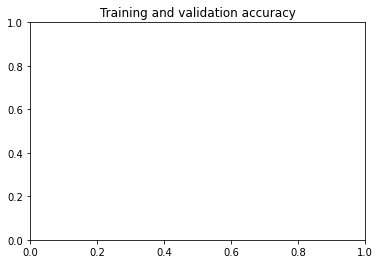

In [ ]:
import matplotlib.pyplot as plt


plt.title('Training and validation accuracy')
plt.plot(Epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()



Visualizing convolutional layers

In [ ]:
import os
import numpy as np

import torch
from torch.optim import Adam
from torchvision import models

import pandas as pd

from misc_functions import preprocess_image, recreate_image, save_image


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0
        # Create the folder to export images if not exists
        if not os.path.exists('../generated'):
            os.makedirs('../generated')

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        # random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        random_image = pd.read_csv("/home/mann/Downloads/archive/fashion-mnist_test.csv").iloc[0,1:].to_numpy()
        random_image = np.dstack([random_image]*3)
        random_image = np.array(random_image).reshape(28,28,3)
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)

    def visualise_layer_without_hooks(self):
        # Process image and return variable
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (224, 224, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                x = layer(x)
                if index == self.selected_layer:
                    # Only need to forward until the selected layer is reached
                    # Now, x is the output of the selected layer
                    break
            # Here, we get the specific filter from the output of the convolution operation
            # x is a tensor of shape 1x512x28x28.(For layer 17)
            # So there are 512 unique filter outputs
            # Following line selects a filter from 512 filters so self.conv_output will become
            # a tensor of shape 28x28
            self.conv_output = x[0, self.selected_filter]
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output)
            print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.data.numpy()))
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
            # Save image
            if i % 5 == 0:
                im_path = '../generated/layer_vis_l' + str(self.selected_layer) + \
                    '_f' + str(self.selected_filter) + '_iter' + str(i) + '.jpg'
                save_image(self.created_image, im_path)


if __name__ == '__main__':
    cnn_layer = 17
    filter_pos = 5
    # Fully connected layer is not needed
    # pretrained_model = models.vgg16(pretrained=True).features
    pretrained_model = models.vgg16()
    pretrained_model.load_state_dict(torch.load("/home/mann/model.pth"))
    pretrained_model = pretrained_model.features
    layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

    # Layer visualization with pytorch hooks
    layer_vis.visualise_layer_with_hooks()

    # Layer visualization without pytorch hooks
    # layer_vis.visualise_layer_without_hooks()


In [ ]:
import torch

from misc_functions import get_example_params, convert_to_grayscale, save_gradient_images


class VanillaBackprop():
    """
        Produces gradients generated with vanilla back propagation from the image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()
        # Hook the first layer to get the gradient
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]

        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        first_layer.register_backward_hook(hook_function)

    def generate_gradients(self, input_image, target_class):
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        model_output.backward(gradient=one_hot_output)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


if __name__ == '__main__':
    # Get params
    target_example = 1  # Snake
    (original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
        get_example_params(target_example)
    # Vanilla backprop
    VBP = VanillaBackprop(pretrained_model)
    # Generate gradients
    vanilla_grads = VBP.generate_gradients(prep_img, target_class)
    # Save colored gradients
    save_gradient_images(vanilla_grads, file_name_to_export + '_bpVanilla_BP_color')
    # Convert to grayscale
    grayscale_vanilla_grads = convert_to_grayscale(vanilla_grads)
    # Save grayscale gradients
    save_gradient_images(grayscale_vanilla_grads, file_name_to_export + '_Vanilla_BP_gray')
    print('Vanilla backprop completed')
